In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# %cd /content/gdrive/MyDrive/multilogue-net
% cd /content/drive/MyDrive/11-777 MMML/multilogue-net

/content/drive/.shortcut-targets-by-id/1sKygtzdMExNjy2GJE2k9Z6m8S3ehIYG3/11-777 MMML/multilogue-net


In [3]:
! pip install -r requirements.txt

  Using cached absl-py-0.8.1.tar.gz (103 kB)
  Using cached astroid-2.3.3-py3-none-any.whl (205 kB)
  Using cached attrs-19.3.0-py2.py3-none-any.whl (39 kB)
  Using cached autopep8-1.5.tar.gz (116 kB)
  Using cached awscli-1.16.259-py2.py3-none-any.whl (2.3 MB)
  Using cached backcall-0.1.0.zip (11 kB)
  Using cached bleach-3.1.2-py2.py3-none-any.whl (151 kB)
  Using cached botocore-1.12.249-py2.py3-none-any.whl (5.7 MB)
  Using cached certifi-2019.11.28-py2.py3-none-any.whl (156 kB)
  Using cached cffi-1.13.2-cp37-cp37m-manylinux1_x86_64.whl (398 kB)
  Using cached colorama-0.4.1-py2.py3-none-any.whl (15 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached decorator-4.4.1-py2.py3-none-any.whl (9.2 kB)
  Using cached defusedxml-0.6.0-py2.py3-none-any.whl (23 kB)
  Using cached docutils-0.15.2-py3-none-any.whl (547 kB)
  Using cached dominate-2.4.0-py2.py3-none-any.whl (29 kB)
  Using cached enum34-1.1.6-py3-none-any.whl (12 kB)
  Using cached gast-0.3.2.tar.gz 

In [13]:
import numpy as np, torch, torch.nn as nn, torch.optim as optim
import argparse, time, pandas as pd, os
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from model_nce import RegressionModelNCE, MaskedMSELoss, BiModalAttention,CrossLingualNCELoss
from dataloader import MOSEIRegression_NCE

np.random.seed(393)
torch.cuda.device([0])

In [24]:
args = {
    "no_cuda": False,
    "lr": 1e-4,
    "l2": 1e-4,
    "rec_dropout": 0.1,
    "dropout": 0.25,
    "batch_size":64,
    "epochs":150,
    "log_dir": 'logs/moseas_regression_NCE_FR+ESTranslate'
}
os.makedirs(args["log_dir"], exist_ok = True)

In [25]:
# Run on either GPU or CPU
args["cuda"] = torch.cuda.is_available() and not args["no_cuda"]
if args["cuda"]:
    print('Running on GPU')
else:
    print('Running on CPU')
print("Tensorboard logs in " + args["log_dir"])

Running on GPU
Tensorboard logs in logs/moseas_regression_NCE_FR+ESTranslate


In [26]:
def get_train_valid_sampler(trainset, valid=0.1):
    size = len(trainset)
    idx = range(size)
    split = int(valid*size)
    return SubsetRandomSampler(idx[split:]), SubsetRandomSampler(idx[:split])

def get_MOSEI_loaders_NCE(path, batch_size=128, valid=0.1, num_workers=0, pin_memory=False, mode="french"):
    trainset = MOSEIRegression_NCE(path=path)
    train_sampler, valid_sampler = get_train_valid_sampler(trainset, valid)
    train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, collate_fn=trainset.collate_fn, num_workers=num_workers, pin_memory=pin_memory)
    valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler, collate_fn=trainset.collate_fn, num_workers=num_workers, pin_memory=pin_memory)
    print(mode)
    testset = MOSEIRegression_NCE(path=path, train=False,mode=mode)
    print("testset.len: ",testset.len)
    test_loader = DataLoader(testset, batch_size=batch_size, collate_fn=testset.collate_fn, num_workers=num_workers, pin_memory=pin_memory)
    return train_loader, valid_loader, test_loader

In [44]:
def train_or_eval_model(model, MSEloss, NCEloss, dataloader, epoch, optimizer=None, train=False):    
    losses, preds, labels, masks = [], [], [], []
    assert not train or optimizer!=None
    if train:
        model.train()
    else:
        model.eval()
    for data in dataloader:
        if train:
            optimizer.zero_grad()
        textf1, textf2, visuf, acouf, qmask, umask, label = [d.cuda() for d in data] if cuda else data
        print(textf1.shape, textf2.shape)
        # jiu jiu hai zi
        # l = label.detach().numpy()
        # print("train_or_eval", (abs(l) <= 1e-5).sum())
        pred, hidden_at1, hidden_at2, hidden_vt1, hidden_vt2 = model(textf1, textf2, acouf, visuf, textf1, qmask, umask) 
        labels_ = label.view(-1) 
        umask_ = umask.view(-1)

        mseloss = MSEloss(pred, labels_, umask_)
        nceloss = NCEloss(hidden_at1, hidden_at2, hidden_vt1, hidden_vt2)
        loss = mseloss+nceloss

        preds.append(pred.data.cpu().numpy())
        labels.append(labels_.data.cpu().numpy())
        masks.append(umask_.cpu().numpy())
        loss_detach = mseloss.item()*masks[-1].sum() + nceloss.detach().cpu().numpy()
        # print(mseloss.item()*masks[-1].sum())
        # print(nceloss.detach().cpu().numpy())
        losses.append(loss_detach)
        if train:
            loss.backward()
            optimizer.step()
    if preds!=[]:
        preds  = np.concatenate(preds)
        labels = np.concatenate(labels)
        masks  = np.concatenate(masks)
    else:
        return float('nan'), float('nan'), float('nan'), [], [], []
    avg_loss = round(np.sum(losses)/np.sum(masks),4)
    mae = round(mean_absolute_error(labels,preds,sample_weight=masks),4)
    pred_lab = pd.DataFrame(list(filter(lambda x: x[2]==1, zip(labels, preds, masks))))
    pear = round(pearsonr(pred_lab[0], pred_lab[1])[0], 4)
    return avg_loss, mae, pear, labels, preds, masks

In [45]:
def log_res(train_loss, test_loss, train_mae, test_mae, train_pear, test_pear):
    print("Train Loss - MOSEAS Regression: ", train_loss)
    print("Test Loss - MOSEAS Regression: ", test_loss)
    print("Train MAE - MOSEAS Regression: ", train_mae)
    print("Test MAE - MOSEAS Regression: ", test_mae)
    print("Train Pearson - MOSEAS Regression: ", train_pear)
    print("Test Pearson - MOSEAS Regression: ", test_pear)

    all_train_loss.append(train_loss)
    all_test_loss.append(test_loss)
    all_train_mae.append(train_mae)
    all_test_mae.append(test_mae)
    all_train_pear.append(train_pear)
    all_test_pear.append(test_pear)

In [28]:

batch_size = args["batch_size"]
# batch_size = 1
n_classes  = 6
cuda       = args["cuda"]
n_epochs   = args["epochs"]
# MOSEI
# D_m_text, D_m_audio, D_m_video, D_m_context = 300, 384, 35, 300
# MOSEAS
# D_m_text, D_m_audio, D_m_video, D_m_context = 300, 25, 35, 300
# MOSEAS_full
D_m_text, D_m_audio, D_m_video, D_m_context = 300, 25, 35, 300
D_g, D_p, D_e, D_h, D_a = 150, 150, 100, 100, 100

# check data section

In [ ]:
import pickle

full_french_data = pickle.load(open('/content/gdrive/MyDrive/multilogue-net/data/moseas_full_regression.pickle', 'rb'))
# keys = full_french_data[0]
len(full_french_data)
all_videos_seg, all_speakers, all_labels, text_feat, audio_feat, visual_feat, train_videos, test_videos = full_french_data

In [ ]:
text_feat['0sLJvUj7Z7M']

In [ ]:
import pickle
# spanish_data = pickle.load(open('/content/gdrive/MyDrive/moseas_french/moseas_spanish/spanish_french_lang_features_with_id.pickle', 'rb'))
spanish_data = pickle.load(open('/content/drive/MyDrive/moseas_french/moseas_spanish/spanish_french_lang_features_with_id.pickle', 'rb'))

In [ ]:
ids, feats = spanish_data

In [ ]:
for f in feats:
    print(len(f))

In [ ]:
video, seg = 'sLJv_Uj7Z7M_0'.rsplit("_",1)
video, seg

('sLJv_Uj7Z7M', '0')

In [ ]:
new_spanish_data = {}

In [ ]:
spanish_text_feat = {}

for key, vals in all_videos_seg.items():
   for v in vals:
      # v = v[1:]
      if v in ids:
          idx = ids.index(v)
          # print(idx, v)
          video, seg = v.rsplit("_", 1)
          # if (len(feats[idx]) == 0):
          #   print(idx)
          #   print(video)
          if video in spanish_text_feat:
            spanish_text_feat[video].append(feats[idx].mean(axis=0))
          else:
            spanish_text_feat[video] = [feats[idx].mean(axis=0)]

In [ ]:
moseas_regression_data_sp = (all_videos_seg, all_speakers, all_labels, text_feat, spanish_text_feat, audio_feat, visual_feat, train_videos, test_videos)

In [ ]:
import pickle
full_data = pickle.load(open('/content/gdrive/MyDrive/multilogue-net/data/moseas_full_regression_spanish.pickle', 'rb'))
all_videos_seg, all_speakers, all_labels, text_feat, spanish_text_feat, audio_feat, visual_feat, train_videos, test_videos = full_data

In [ ]:
for vid in all_videos_seg:
    if vid not in spanish_text_feat:
        print(vid)
    else:
        print(spanish_text_feat[vid])
        print(torch.FloatTensor(text_feat[vid]).shape, torch.FloatTensor(spanish_text_feat[vid]).shape)

In [ ]:

for k, v in text_feat.items():
    if k in spanish_text_feat:
      if (len(v) != len(spanish_text_feat[k])):
          print('len not eq', k)
    else:
      print('not in', k)
      for d in [all_videos_seg, all_speakers, all_labels, text_feat, audio_feat, visual_feat, train_videos, test_videos]:
        d.pop(k)

In [ ]:
for k, v in text_feat.items():
    if k in spanish_text_feat:
        print(len(v), v[0].shape, len(spanish_text_feat[k]), spanish_text_feat[k][0].shape)

In [ ]:
with open("/content/gdrive/MyDrive/multilogue-net/data/moseas_full_regression_spanish.pickle", "wb") as f:
    pickle.dump(moseas_regression_data_sp,f)

# train model section

## train NCE, FR+Spanish translate, only conditioned on visual

In [46]:
# Instantiate model
model = RegressionModelNCE(D_m_text, D_m_audio, D_m_video, D_m_context, D_g, D_p, D_e, D_h, dropout_rec=args["rec_dropout"], dropout=args["dropout"])

if cuda:
    model.cuda()
MSEloss = MaskedMSELoss()
NCEloss = CrossLingualNCELoss(visual=True, audio=False)

# Get optimizer and relevant dataloaders
optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['l2'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7,patience=10,verbose=True)

# amelia
train_loader, valid_loader, test_loader = get_MOSEI_loaders_NCE('/content/drive/MyDrive/11-777 MMML/multilogue-net/data/moseas_full_regression_french_spanishtranslate.pickle', valid=0.0, batch_size=batch_size, num_workers=0)
# abbey
# train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/gdrive/MyDrive/multilogue-net/data/moseas_full_regression_spanish.pickle', valid=0.0, batch_size=batch_size, num_workers=0)

# train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/gdrive/MyDrive/multilogue-net/data/regression.pkl', valid=0.0, batch_size=batch_size, num_workers=0)
best_loss, best_label, best_pred, best_mask, best_pear = None, None, None, None, None
all_train_loss, all_test_loss, all_train_mae, all_test_mae, all_train_pear, all_test_pear = [],[],[],[],[],[]

french
testset.len:  57


In [47]:
# Training loop
for e in tqdm(range(n_epochs), desc = 'MOSEAS Regression'):
    train_loss, train_mae, train_pear,_,_,_ = train_or_eval_model(model, MSEloss, NCEloss, train_loader, e, optimizer, True)
    test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, MSEloss, NCEloss, test_loader, e)
    log_res(train_loss, test_loss, train_mae, test_mae, train_pear, test_pear)

    if best_loss == None or best_loss > test_loss:
        best_loss, best_mae, best_label, best_pred, best_mask, best_pear =\
                test_loss, test_mae, test_label, test_pred, test_mask, test_pear
        print(f"saving checkpoint for epoch {e}")
        torch.save(model.state_dict(),f"{args['log_dir']}/epoch{e}_testloss_{best_loss}_testmae_{best_mae}_testpear_{best_pear}.t7")

print('Test performance..')
print('Loss {} MAE {} r {}'.format(best_loss, round(mean_absolute_error(best_label,best_pred,sample_weight=best_mask),4), best_pear))

MOSEAS Regression:   0%|          | 0/150 [00:00<?, ?it/s]

torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   1%|          | 1/150 [00:12<31:01, 12.50s/it]

Train Loss - MOSEAS Regression:  0.5945
Test Loss - MOSEAS Regression:  0.5089
Train MAE - MOSEAS Regression:  0.5811
Test MAE - MOSEAS Regression:  0.5485
Train Pearson - MOSEAS Regression:  -0.1089
Test Pearson - MOSEAS Regression:  -0.079
saving checkpoint for epoch 0
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   1%|▏         | 2/150 [00:25<31:34, 12.80s/it]

Train Loss - MOSEAS Regression:  0.5258
Test Loss - MOSEAS Regression:  0.5075
Train MAE - MOSEAS Regression:  0.5611
Test MAE - MOSEAS Regression:  0.5646
Train Pearson - MOSEAS Regression:  -0.0541
Test Pearson - MOSEAS Regression:  -0.0688
saving checkpoint for epoch 1
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   2%|▏         | 3/150 [00:38<31:10, 12.72s/it]

Train Loss - MOSEAS Regression:  0.5143
Test Loss - MOSEAS Regression:  0.4975
Train MAE - MOSEAS Regression:  0.5589
Test MAE - MOSEAS Regression:  0.5566
Train Pearson - MOSEAS Regression:  -0.0096
Test Pearson - MOSEAS Regression:  -0.0488
saving checkpoint for epoch 2
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   3%|▎         | 4/150 [00:51<31:27, 12.93s/it]

Train Loss - MOSEAS Regression:  0.5081
Test Loss - MOSEAS Regression:  0.4872
Train MAE - MOSEAS Regression:  0.5514
Test MAE - MOSEAS Regression:  0.5387
Train Pearson - MOSEAS Regression:  -0.0104
Test Pearson - MOSEAS Regression:  -0.0104
saving checkpoint for epoch 3
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([49, 36, 300]) torch.Size([49, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   3%|▎         | 5/150 [01:04<31:21, 12.98s/it]

Train Loss - MOSEAS Regression:  0.4984
Test Loss - MOSEAS Regression:  0.4851
Train MAE - MOSEAS Regression:  0.5419
Test MAE - MOSEAS Regression:  0.5345
Train Pearson - MOSEAS Regression:  0.0241
Test Pearson - MOSEAS Regression:  0.0441
saving checkpoint for epoch 4
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([49, 64, 300]) torch.Size([49, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   4%|▍         | 6/150 [01:17<30:55, 12.89s/it]

Train Loss - MOSEAS Regression:  0.4989
Test Loss - MOSEAS Regression:  0.481
Train MAE - MOSEAS Regression:  0.5391
Test MAE - MOSEAS Regression:  0.5332
Train Pearson - MOSEAS Regression:  0.029
Test Pearson - MOSEAS Regression:  0.074
saving checkpoint for epoch 5
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   5%|▍         | 7/150 [01:29<30:31, 12.80s/it]

Train Loss - MOSEAS Regression:  0.4948
Test Loss - MOSEAS Regression:  0.4769
Train MAE - MOSEAS Regression:  0.5366
Test MAE - MOSEAS Regression:  0.5331
Train Pearson - MOSEAS Regression:  0.0464
Test Pearson - MOSEAS Regression:  0.0922
saving checkpoint for epoch 6
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   5%|▌         | 8/150 [01:43<30:42, 12.97s/it]

Train Loss - MOSEAS Regression:  0.4887
Test Loss - MOSEAS Regression:  0.474
Train MAE - MOSEAS Regression:  0.5375
Test MAE - MOSEAS Regression:  0.5336
Train Pearson - MOSEAS Regression:  0.0621
Test Pearson - MOSEAS Regression:  0.1077
saving checkpoint for epoch 7
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   6%|▌         | 9/150 [01:56<30:52, 13.14s/it]

Train Loss - MOSEAS Regression:  0.4844
Test Loss - MOSEAS Regression:  0.472
Train MAE - MOSEAS Regression:  0.5327
Test MAE - MOSEAS Regression:  0.5336
Train Pearson - MOSEAS Regression:  0.0914
Test Pearson - MOSEAS Regression:  0.1218
saving checkpoint for epoch 8
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([37, 36, 300]) torch.Size([37, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   7%|▋         | 10/150 [02:08<30:00, 12.86s/it]

Train Loss - MOSEAS Regression:  0.4768
Test Loss - MOSEAS Regression:  0.4704
Train MAE - MOSEAS Regression:  0.5314
Test MAE - MOSEAS Regression:  0.5328
Train Pearson - MOSEAS Regression:  0.1242
Test Pearson - MOSEAS Regression:  0.1354
saving checkpoint for epoch 9
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   7%|▋         | 11/150 [02:21<29:55, 12.92s/it]

Train Loss - MOSEAS Regression:  0.481
Test Loss - MOSEAS Regression:  0.4689
Train MAE - MOSEAS Regression:  0.5352
Test MAE - MOSEAS Regression:  0.5321
Train Pearson - MOSEAS Regression:  0.1032
Test Pearson - MOSEAS Regression:  0.1473
saving checkpoint for epoch 10
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([49, 36, 300]) torch.Size([49, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   8%|▊         | 12/150 [02:34<29:24, 12.79s/it]

Train Loss - MOSEAS Regression:  0.4722
Test Loss - MOSEAS Regression:  0.4682
Train MAE - MOSEAS Regression:  0.5268
Test MAE - MOSEAS Regression:  0.5307
Train Pearson - MOSEAS Regression:  0.1492
Test Pearson - MOSEAS Regression:  0.1587
saving checkpoint for epoch 11
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([49, 64, 300]) torch.Size([49, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   9%|▊         | 13/150 [02:46<28:42, 12.57s/it]

Train Loss - MOSEAS Regression:  0.4757
Test Loss - MOSEAS Regression:  0.4668
Train MAE - MOSEAS Regression:  0.5271
Test MAE - MOSEAS Regression:  0.5302
Train Pearson - MOSEAS Regression:  0.1341
Test Pearson - MOSEAS Regression:  0.1669
saving checkpoint for epoch 12
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   9%|▉         | 14/150 [02:59<29:00, 12.80s/it]

Train Loss - MOSEAS Regression:  0.4755
Test Loss - MOSEAS Regression:  0.465
Train MAE - MOSEAS Regression:  0.5288
Test MAE - MOSEAS Regression:  0.5305
Train Pearson - MOSEAS Regression:  0.1342
Test Pearson - MOSEAS Regression:  0.1727
saving checkpoint for epoch 13
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  10%|█         | 15/150 [03:13<29:10, 12.96s/it]

Train Loss - MOSEAS Regression:  0.4687
Test Loss - MOSEAS Regression:  0.4638
Train MAE - MOSEAS Regression:  0.5266
Test MAE - MOSEAS Regression:  0.5301
Train Pearson - MOSEAS Regression:  0.1668
Test Pearson - MOSEAS Regression:  0.1793
saving checkpoint for epoch 14
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  11%|█         | 16/150 [03:26<29:30, 13.21s/it]

Train Loss - MOSEAS Regression:  0.4684
Test Loss - MOSEAS Regression:  0.4629
Train MAE - MOSEAS Regression:  0.5247
Test MAE - MOSEAS Regression:  0.5291
Train Pearson - MOSEAS Regression:  0.1694
Test Pearson - MOSEAS Regression:  0.186
saving checkpoint for epoch 15
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  11%|█▏        | 17/150 [03:39<29:09, 13.15s/it]

Train Loss - MOSEAS Regression:  0.467
Test Loss - MOSEAS Regression:  0.4621
Train MAE - MOSEAS Regression:  0.5239
Test MAE - MOSEAS Regression:  0.5285
Train Pearson - MOSEAS Regression:  0.1738
Test Pearson - MOSEAS Regression:  0.191
saving checkpoint for epoch 16
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  12%|█▏        | 18/150 [03:53<28:59, 13.18s/it]

Train Loss - MOSEAS Regression:  0.4626
Test Loss - MOSEAS Regression:  0.4615
Train MAE - MOSEAS Regression:  0.5225
Test MAE - MOSEAS Regression:  0.5277
Train Pearson - MOSEAS Regression:  0.1981
Test Pearson - MOSEAS Regression:  0.1958
saving checkpoint for epoch 17
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  13%|█▎        | 19/150 [04:06<28:39, 13.12s/it]

Train Loss - MOSEAS Regression:  0.4565
Test Loss - MOSEAS Regression:  0.4599
Train MAE - MOSEAS Regression:  0.5192
Test MAE - MOSEAS Regression:  0.5282
Train Pearson - MOSEAS Regression:  0.2248
Test Pearson - MOSEAS Regression:  0.1996
saving checkpoint for epoch 18
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  13%|█▎        | 20/150 [04:19<28:48, 13.30s/it]

Train Loss - MOSEAS Regression:  0.4488
Test Loss - MOSEAS Regression:  0.459
Train MAE - MOSEAS Regression:  0.5141
Test MAE - MOSEAS Regression:  0.5282
Train Pearson - MOSEAS Regression:  0.2579
Test Pearson - MOSEAS Regression:  0.2032
saving checkpoint for epoch 19
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  14%|█▍        | 21/150 [04:33<28:33, 13.28s/it]

Train Loss - MOSEAS Regression:  0.4561
Test Loss - MOSEAS Regression:  0.4585
Train MAE - MOSEAS Regression:  0.5167
Test MAE - MOSEAS Regression:  0.527
Train Pearson - MOSEAS Regression:  0.2267
Test Pearson - MOSEAS Regression:  0.2069
saving checkpoint for epoch 20
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  15%|█▍        | 22/150 [04:45<27:38, 12.96s/it]

Train Loss - MOSEAS Regression:  0.4494
Test Loss - MOSEAS Regression:  0.4577
Train MAE - MOSEAS Regression:  0.5137
Test MAE - MOSEAS Regression:  0.5283
Train Pearson - MOSEAS Regression:  0.2554
Test Pearson - MOSEAS Regression:  0.2095
saving checkpoint for epoch 21
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  15%|█▌        | 23/150 [04:57<27:14, 12.87s/it]

Train Loss - MOSEAS Regression:  0.4465
Test Loss - MOSEAS Regression:  0.4574
Train MAE - MOSEAS Regression:  0.5141
Test MAE - MOSEAS Regression:  0.5287
Train Pearson - MOSEAS Regression:  0.2671
Test Pearson - MOSEAS Regression:  0.212
saving checkpoint for epoch 22
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  16%|█▌        | 24/150 [05:11<27:11, 12.95s/it]

Train Loss - MOSEAS Regression:  0.4512
Test Loss - MOSEAS Regression:  0.4565
Train MAE - MOSEAS Regression:  0.5141
Test MAE - MOSEAS Regression:  0.5254
Train Pearson - MOSEAS Regression:  0.249
Test Pearson - MOSEAS Regression:  0.2166
saving checkpoint for epoch 23
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  17%|█▋        | 25/150 [05:24<27:07, 13.02s/it]

Train Loss - MOSEAS Regression:  0.4456
Test Loss - MOSEAS Regression:  0.4574
Train MAE - MOSEAS Regression:  0.5102
Test MAE - MOSEAS Regression:  0.5293
Train Pearson - MOSEAS Regression:  0.27
Test Pearson - MOSEAS Regression:  0.2158
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  17%|█▋        | 26/150 [05:37<27:13, 13.18s/it]

Train Loss - MOSEAS Regression:  0.4431
Test Loss - MOSEAS Regression:  0.4557
Train MAE - MOSEAS Regression:  0.5134
Test MAE - MOSEAS Regression:  0.5272
Train Pearson - MOSEAS Regression:  0.2815
Test Pearson - MOSEAS Regression:  0.2203
saving checkpoint for epoch 25
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  18%|█▊        | 27/150 [05:50<26:59, 13.16s/it]

Train Loss - MOSEAS Regression:  0.4419
Test Loss - MOSEAS Regression:  0.4547
Train MAE - MOSEAS Regression:  0.5075
Test MAE - MOSEAS Regression:  0.5241
Train Pearson - MOSEAS Regression:  0.2838
Test Pearson - MOSEAS Regression:  0.2256
saving checkpoint for epoch 26
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([47, 64, 300]) torch.Size([47, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  19%|█▊        | 28/150 [06:03<26:24, 12.99s/it]

Train Loss - MOSEAS Regression:  0.4388
Test Loss - MOSEAS Regression:  0.4543
Train MAE - MOSEAS Regression:  0.5046
Test MAE - MOSEAS Regression:  0.5232
Train Pearson - MOSEAS Regression:  0.3005
Test Pearson - MOSEAS Regression:  0.2289
saving checkpoint for epoch 27
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  19%|█▉        | 29/150 [06:16<26:06, 12.95s/it]

Train Loss - MOSEAS Regression:  0.4364
Test Loss - MOSEAS Regression:  0.4572
Train MAE - MOSEAS Regression:  0.505
Test MAE - MOSEAS Regression:  0.5294
Train Pearson - MOSEAS Regression:  0.3039
Test Pearson - MOSEAS Regression:  0.2255
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  20%|██        | 30/150 [06:29<26:08, 13.07s/it]

Train Loss - MOSEAS Regression:  0.4344
Test Loss - MOSEAS Regression:  0.4534
Train MAE - MOSEAS Regression:  0.5072
Test MAE - MOSEAS Regression:  0.5256
Train Pearson - MOSEAS Regression:  0.3172
Test Pearson - MOSEAS Regression:  0.2332
saving checkpoint for epoch 29
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  21%|██        | 31/150 [06:43<26:09, 13.18s/it]

Train Loss - MOSEAS Regression:  0.4337
Test Loss - MOSEAS Regression:  0.4541
Train MAE - MOSEAS Regression:  0.502
Test MAE - MOSEAS Regression:  0.521
Train Pearson - MOSEAS Regression:  0.3153
Test Pearson - MOSEAS Regression:  0.2395
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  21%|██▏       | 32/150 [06:55<25:36, 13.02s/it]

Train Loss - MOSEAS Regression:  0.4337
Test Loss - MOSEAS Regression:  0.4566
Train MAE - MOSEAS Regression:  0.5012
Test MAE - MOSEAS Regression:  0.5296
Train Pearson - MOSEAS Regression:  0.3158
Test Pearson - MOSEAS Regression:  0.2355
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  22%|██▏       | 33/150 [07:08<25:09, 12.91s/it]

Train Loss - MOSEAS Regression:  0.4341
Test Loss - MOSEAS Regression:  0.4513
Train MAE - MOSEAS Regression:  0.5061
Test MAE - MOSEAS Regression:  0.5241
Train Pearson - MOSEAS Regression:  0.3189
Test Pearson - MOSEAS Regression:  0.2432
saving checkpoint for epoch 32
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([39, 36, 300]) torch.Size([39, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  23%|██▎       | 34/150 [07:21<24:42, 12.78s/it]

Train Loss - MOSEAS Regression:  0.4258
Test Loss - MOSEAS Regression:  0.4498
Train MAE - MOSEAS Regression:  0.4976
Test MAE - MOSEAS Regression:  0.5197
Train Pearson - MOSEAS Regression:  0.3389
Test Pearson - MOSEAS Regression:  0.2501
saving checkpoint for epoch 33
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  23%|██▎       | 35/150 [07:33<24:35, 12.83s/it]

Train Loss - MOSEAS Regression:  0.4246
Test Loss - MOSEAS Regression:  0.4494
Train MAE - MOSEAS Regression:  0.4972
Test MAE - MOSEAS Regression:  0.5226
Train Pearson - MOSEAS Regression:  0.347
Test Pearson - MOSEAS Regression:  0.2506
saving checkpoint for epoch 34
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  24%|██▍       | 36/150 [07:46<24:23, 12.84s/it]

Train Loss - MOSEAS Regression:  0.4232
Test Loss - MOSEAS Regression:  0.452
Train MAE - MOSEAS Regression:  0.4989
Test MAE - MOSEAS Regression:  0.5258
Train Pearson - MOSEAS Regression:  0.3483
Test Pearson - MOSEAS Regression:  0.249
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  25%|██▍       | 37/150 [07:59<24:08, 12.82s/it]

Train Loss - MOSEAS Regression:  0.4207
Test Loss - MOSEAS Regression:  0.4483
Train MAE - MOSEAS Regression:  0.4967
Test MAE - MOSEAS Regression:  0.5187
Train Pearson - MOSEAS Regression:  0.3549
Test Pearson - MOSEAS Regression:  0.2565
saving checkpoint for epoch 36
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  25%|██▌       | 38/150 [08:13<24:20, 13.04s/it]

Train Loss - MOSEAS Regression:  0.4208
Test Loss - MOSEAS Regression:  0.4475
Train MAE - MOSEAS Regression:  0.4935
Test MAE - MOSEAS Regression:  0.5197
Train Pearson - MOSEAS Regression:  0.363
Test Pearson - MOSEAS Regression:  0.2575
saving checkpoint for epoch 37
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  26%|██▌       | 39/150 [08:25<23:49, 12.88s/it]

Train Loss - MOSEAS Regression:  0.4201
Test Loss - MOSEAS Regression:  0.4523
Train MAE - MOSEAS Regression:  0.4986
Test MAE - MOSEAS Regression:  0.5263
Train Pearson - MOSEAS Regression:  0.3603
Test Pearson - MOSEAS Regression:  0.2549
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  27%|██▋       | 40/150 [08:38<23:28, 12.81s/it]

Train Loss - MOSEAS Regression:  0.4146
Test Loss - MOSEAS Regression:  0.4471
Train MAE - MOSEAS Regression:  0.4925
Test MAE - MOSEAS Regression:  0.519
Train Pearson - MOSEAS Regression:  0.3713
Test Pearson - MOSEAS Regression:  0.2618
saving checkpoint for epoch 39
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  27%|██▋       | 41/150 [08:51<23:15, 12.80s/it]

Train Loss - MOSEAS Regression:  0.411
Test Loss - MOSEAS Regression:  0.4492
Train MAE - MOSEAS Regression:  0.4885
Test MAE - MOSEAS Regression:  0.5229
Train Pearson - MOSEAS Regression:  0.383
Test Pearson - MOSEAS Regression:  0.2602
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  28%|██▊       | 42/150 [09:04<23:17, 12.94s/it]

Train Loss - MOSEAS Regression:  0.4111
Test Loss - MOSEAS Regression:  0.4481
Train MAE - MOSEAS Regression:  0.4929
Test MAE - MOSEAS Regression:  0.5213
Train Pearson - MOSEAS Regression:  0.3826
Test Pearson - MOSEAS Regression:  0.262
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  29%|██▊       | 43/150 [09:17<22:57, 12.87s/it]

Train Loss - MOSEAS Regression:  0.4115
Test Loss - MOSEAS Regression:  0.4475
Train MAE - MOSEAS Regression:  0.4921
Test MAE - MOSEAS Regression:  0.5201
Train Pearson - MOSEAS Regression:  0.3799
Test Pearson - MOSEAS Regression:  0.2639
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  29%|██▉       | 44/150 [09:29<22:28, 12.72s/it]

Train Loss - MOSEAS Regression:  0.4045
Test Loss - MOSEAS Regression:  0.4469
Train MAE - MOSEAS Regression:  0.4858
Test MAE - MOSEAS Regression:  0.5195
Train Pearson - MOSEAS Regression:  0.4005
Test Pearson - MOSEAS Regression:  0.2666
saving checkpoint for epoch 43
torch.Size([47, 64, 300]) torch.Size([47, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  30%|███       | 45/150 [09:41<21:56, 12.54s/it]

Train Loss - MOSEAS Regression:  0.4065
Test Loss - MOSEAS Regression:  0.4476
Train MAE - MOSEAS Regression:  0.4888
Test MAE - MOSEAS Regression:  0.5206
Train Pearson - MOSEAS Regression:  0.3939
Test Pearson - MOSEAS Regression:  0.2675
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  31%|███       | 46/150 [09:54<22:10, 12.79s/it]

Train Loss - MOSEAS Regression:  0.4028
Test Loss - MOSEAS Regression:  0.4462
Train MAE - MOSEAS Regression:  0.4846
Test MAE - MOSEAS Regression:  0.5189
Train Pearson - MOSEAS Regression:  0.4031
Test Pearson - MOSEAS Regression:  0.2706
saving checkpoint for epoch 45
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  31%|███▏      | 47/150 [10:07<21:59, 12.81s/it]

Train Loss - MOSEAS Regression:  0.4018
Test Loss - MOSEAS Regression:  0.4483
Train MAE - MOSEAS Regression:  0.4851
Test MAE - MOSEAS Regression:  0.5219
Train Pearson - MOSEAS Regression:  0.4055
Test Pearson - MOSEAS Regression:  0.2691
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  32%|███▏      | 48/150 [10:20<21:52, 12.87s/it]

Train Loss - MOSEAS Regression:  0.3962
Test Loss - MOSEAS Regression:  0.4463
Train MAE - MOSEAS Regression:  0.4816
Test MAE - MOSEAS Regression:  0.5186
Train Pearson - MOSEAS Regression:  0.4222
Test Pearson - MOSEAS Regression:  0.2729
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  33%|███▎      | 49/150 [10:33<21:29, 12.77s/it]

Train Loss - MOSEAS Regression:  0.401
Test Loss - MOSEAS Regression:  0.4517
Train MAE - MOSEAS Regression:  0.4836
Test MAE - MOSEAS Regression:  0.5248
Train Pearson - MOSEAS Regression:  0.4101
Test Pearson - MOSEAS Regression:  0.2665
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  33%|███▎      | 50/150 [10:46<21:23, 12.83s/it]

Train Loss - MOSEAS Regression:  0.3989
Test Loss - MOSEAS Regression:  0.4469
Train MAE - MOSEAS Regression:  0.4848
Test MAE - MOSEAS Regression:  0.5189
Train Pearson - MOSEAS Regression:  0.4148
Test Pearson - MOSEAS Regression:  0.2747
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  34%|███▍      | 51/150 [10:58<20:57, 12.70s/it]

Train Loss - MOSEAS Regression:  0.3996
Test Loss - MOSEAS Regression:  0.4488
Train MAE - MOSEAS Regression:  0.4824
Test MAE - MOSEAS Regression:  0.5221
Train Pearson - MOSEAS Regression:  0.4144
Test Pearson - MOSEAS Regression:  0.2742
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  35%|███▍      | 52/150 [11:11<20:39, 12.65s/it]

Train Loss - MOSEAS Regression:  0.3921
Test Loss - MOSEAS Regression:  0.4473
Train MAE - MOSEAS Regression:  0.4799
Test MAE - MOSEAS Regression:  0.5204
Train Pearson - MOSEAS Regression:  0.4311
Test Pearson - MOSEAS Regression:  0.2778
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  35%|███▌      | 53/150 [11:23<20:25, 12.64s/it]

Train Loss - MOSEAS Regression:  0.3921
Test Loss - MOSEAS Regression:  0.4505
Train MAE - MOSEAS Regression:  0.4777
Test MAE - MOSEAS Regression:  0.5236
Train Pearson - MOSEAS Regression:  0.4309
Test Pearson - MOSEAS Regression:  0.2763
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  36%|███▌      | 54/150 [11:36<20:11, 12.62s/it]

Train Loss - MOSEAS Regression:  0.3936
Test Loss - MOSEAS Regression:  0.4478
Train MAE - MOSEAS Regression:  0.4825
Test MAE - MOSEAS Regression:  0.521
Train Pearson - MOSEAS Regression:  0.4258
Test Pearson - MOSEAS Regression:  0.2787
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  37%|███▋      | 55/150 [11:48<19:47, 12.50s/it]

Train Loss - MOSEAS Regression:  0.3911
Test Loss - MOSEAS Regression:  0.4509
Train MAE - MOSEAS Regression:  0.4801
Test MAE - MOSEAS Regression:  0.5242
Train Pearson - MOSEAS Regression:  0.4319
Test Pearson - MOSEAS Regression:  0.2766
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([47, 36, 300]) torch.Size([47, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  37%|███▋      | 56/150 [12:01<19:35, 12.51s/it]

Train Loss - MOSEAS Regression:  0.3904
Test Loss - MOSEAS Regression:  0.4471
Train MAE - MOSEAS Regression:  0.4794
Test MAE - MOSEAS Regression:  0.5207
Train Pearson - MOSEAS Regression:  0.4336
Test Pearson - MOSEAS Regression:  0.2837
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([41, 36, 300]) torch.Size([41, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  38%|███▊      | 57/150 [12:13<19:18, 12.46s/it]

Train Loss - MOSEAS Regression:  0.3839
Test Loss - MOSEAS Regression:  0.4476
Train MAE - MOSEAS Regression:  0.4751
Test MAE - MOSEAS Regression:  0.5216
Train Pearson - MOSEAS Regression:  0.4502
Test Pearson - MOSEAS Regression:  0.2858
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  39%|███▊      | 58/150 [12:26<19:27, 12.69s/it]

Train Loss - MOSEAS Regression:  0.3841
Test Loss - MOSEAS Regression:  0.4515
Train MAE - MOSEAS Regression:  0.4739
Test MAE - MOSEAS Regression:  0.5246
Train Pearson - MOSEAS Regression:  0.4501
Test Pearson - MOSEAS Regression:  0.2851
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([43, 36, 300]) torch.Size([43, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  39%|███▉      | 59/150 [12:38<18:53, 12.46s/it]

Train Loss - MOSEAS Regression:  0.387
Test Loss - MOSEAS Regression:  0.4446
Train MAE - MOSEAS Regression:  0.4789
Test MAE - MOSEAS Regression:  0.5166
Train Pearson - MOSEAS Regression:  0.4448
Test Pearson - MOSEAS Regression:  0.2959
saving checkpoint for epoch 58
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  40%|████      | 60/150 [12:52<19:14, 12.82s/it]

Train Loss - MOSEAS Regression:  0.3786
Test Loss - MOSEAS Regression:  0.4504
Train MAE - MOSEAS Regression:  0.47
Test MAE - MOSEAS Regression:  0.5237
Train Pearson - MOSEAS Regression:  0.4632
Test Pearson - MOSEAS Regression:  0.2934
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  41%|████      | 61/150 [13:05<19:14, 12.97s/it]

Train Loss - MOSEAS Regression:  0.3843
Test Loss - MOSEAS Regression:  0.4425
Train MAE - MOSEAS Regression:  0.476
Test MAE - MOSEAS Regression:  0.5145
Train Pearson - MOSEAS Regression:  0.4502
Test Pearson - MOSEAS Regression:  0.3027
saving checkpoint for epoch 60
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  41%|████▏     | 62/150 [13:18<19:06, 13.03s/it]

Train Loss - MOSEAS Regression:  0.3823
Test Loss - MOSEAS Regression:  0.4464
Train MAE - MOSEAS Regression:  0.4732
Test MAE - MOSEAS Regression:  0.5205
Train Pearson - MOSEAS Regression:  0.4532
Test Pearson - MOSEAS Regression:  0.3009
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  42%|████▏     | 63/150 [13:31<18:39, 12.87s/it]

Train Loss - MOSEAS Regression:  0.3789
Test Loss - MOSEAS Regression:  0.438
Train MAE - MOSEAS Regression:  0.4732
Test MAE - MOSEAS Regression:  0.5118
Train Pearson - MOSEAS Regression:  0.461
Test Pearson - MOSEAS Regression:  0.3099
saving checkpoint for epoch 62
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  43%|████▎     | 64/150 [13:43<18:19, 12.79s/it]

Train Loss - MOSEAS Regression:  0.3823
Test Loss - MOSEAS Regression:  0.4389
Train MAE - MOSEAS Regression:  0.4746
Test MAE - MOSEAS Regression:  0.5149
Train Pearson - MOSEAS Regression:  0.4527
Test Pearson - MOSEAS Regression:  0.3088
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([45, 64, 300]) torch.Size([45, 64, 300])
torch.Size([55, 64, 300]) torch.Size([55, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  43%|████▎     | 65/150 [13:55<17:25, 12.31s/it]

Train Loss - MOSEAS Regression:  0.3785
Test Loss - MOSEAS Regression:  0.4349
Train MAE - MOSEAS Regression:  0.4705
Test MAE - MOSEAS Regression:  0.5112
Train Pearson - MOSEAS Regression:  0.4633
Test Pearson - MOSEAS Regression:  0.3137
saving checkpoint for epoch 64
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  44%|████▍     | 66/150 [14:08<17:35, 12.57s/it]

Train Loss - MOSEAS Regression:  0.3733
Test Loss - MOSEAS Regression:  0.4357
Train MAE - MOSEAS Regression:  0.4683
Test MAE - MOSEAS Regression:  0.512
Train Pearson - MOSEAS Regression:  0.4749
Test Pearson - MOSEAS Regression:  0.314
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  45%|████▍     | 67/150 [14:20<17:22, 12.56s/it]

Train Loss - MOSEAS Regression:  0.3756
Test Loss - MOSEAS Regression:  0.4356
Train MAE - MOSEAS Regression:  0.4682
Test MAE - MOSEAS Regression:  0.5116
Train Pearson - MOSEAS Regression:  0.4705
Test Pearson - MOSEAS Regression:  0.3148
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  45%|████▌     | 68/150 [14:32<17:00, 12.45s/it]

Train Loss - MOSEAS Regression:  0.3721
Test Loss - MOSEAS Regression:  0.4362
Train MAE - MOSEAS Regression:  0.4684
Test MAE - MOSEAS Regression:  0.5123
Train Pearson - MOSEAS Regression:  0.4766
Test Pearson - MOSEAS Regression:  0.3157
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  46%|████▌     | 69/150 [14:45<16:59, 12.59s/it]

Train Loss - MOSEAS Regression:  0.3745
Test Loss - MOSEAS Regression:  0.4341
Train MAE - MOSEAS Regression:  0.4697
Test MAE - MOSEAS Regression:  0.5103
Train Pearson - MOSEAS Regression:  0.4708
Test Pearson - MOSEAS Regression:  0.3195
saving checkpoint for epoch 68
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  47%|████▋     | 70/150 [14:58<16:51, 12.64s/it]

Train Loss - MOSEAS Regression:  0.3687
Test Loss - MOSEAS Regression:  0.4356
Train MAE - MOSEAS Regression:  0.4646
Test MAE - MOSEAS Regression:  0.5123
Train Pearson - MOSEAS Regression:  0.4836
Test Pearson - MOSEAS Regression:  0.3193
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  47%|████▋     | 71/150 [15:10<16:27, 12.50s/it]

Train Loss - MOSEAS Regression:  0.3716
Test Loss - MOSEAS Regression:  0.4331
Train MAE - MOSEAS Regression:  0.467
Test MAE - MOSEAS Regression:  0.5093
Train Pearson - MOSEAS Regression:  0.4769
Test Pearson - MOSEAS Regression:  0.3228
saving checkpoint for epoch 70
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  48%|████▊     | 72/150 [15:23<16:23, 12.61s/it]

Train Loss - MOSEAS Regression:  0.369
Test Loss - MOSEAS Regression:  0.4323
Train MAE - MOSEAS Regression:  0.4649
Test MAE - MOSEAS Regression:  0.5089
Train Pearson - MOSEAS Regression:  0.4826
Test Pearson - MOSEAS Regression:  0.3254
saving checkpoint for epoch 71
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([45, 36, 300]) torch.Size([45, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  49%|████▊     | 73/150 [15:36<16:18, 12.70s/it]

Train Loss - MOSEAS Regression:  0.3667
Test Loss - MOSEAS Regression:  0.4333
Train MAE - MOSEAS Regression:  0.4622
Test MAE - MOSEAS Regression:  0.5103
Train Pearson - MOSEAS Regression:  0.4883
Test Pearson - MOSEAS Regression:  0.3261
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  49%|████▉     | 74/150 [15:49<16:08, 12.75s/it]

Train Loss - MOSEAS Regression:  0.3647
Test Loss - MOSEAS Regression:  0.4305
Train MAE - MOSEAS Regression:  0.4653
Test MAE - MOSEAS Regression:  0.5063
Train Pearson - MOSEAS Regression:  0.4925
Test Pearson - MOSEAS Regression:  0.3317
saving checkpoint for epoch 73
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  50%|█████     | 75/150 [16:02<16:13, 12.98s/it]

Train Loss - MOSEAS Regression:  0.3668
Test Loss - MOSEAS Regression:  0.4345
Train MAE - MOSEAS Regression:  0.4621
Test MAE - MOSEAS Regression:  0.5113
Train Pearson - MOSEAS Regression:  0.4883
Test Pearson - MOSEAS Regression:  0.3314
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  51%|█████     | 76/150 [16:15<15:54, 12.90s/it]

Train Loss - MOSEAS Regression:  0.3638
Test Loss - MOSEAS Regression:  0.4297
Train MAE - MOSEAS Regression:  0.4632
Test MAE - MOSEAS Regression:  0.5065
Train Pearson - MOSEAS Regression:  0.4934
Test Pearson - MOSEAS Regression:  0.3347
saving checkpoint for epoch 75
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  51%|█████▏    | 77/150 [16:28<15:45, 12.96s/it]

Train Loss - MOSEAS Regression:  0.3649
Test Loss - MOSEAS Regression:  0.4287
Train MAE - MOSEAS Regression:  0.4637
Test MAE - MOSEAS Regression:  0.5053
Train Pearson - MOSEAS Regression:  0.491
Test Pearson - MOSEAS Regression:  0.3369
saving checkpoint for epoch 76
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  52%|█████▏    | 78/150 [16:41<15:38, 13.03s/it]

Train Loss - MOSEAS Regression:  0.3612
Test Loss - MOSEAS Regression:  0.4291
Train MAE - MOSEAS Regression:  0.461
Test MAE - MOSEAS Regression:  0.5068
Train Pearson - MOSEAS Regression:  0.4998
Test Pearson - MOSEAS Regression:  0.3376
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  53%|█████▎    | 79/150 [16:54<15:07, 12.78s/it]

Train Loss - MOSEAS Regression:  0.3601
Test Loss - MOSEAS Regression:  0.4274
Train MAE - MOSEAS Regression:  0.4603
Test MAE - MOSEAS Regression:  0.5052
Train Pearson - MOSEAS Regression:  0.5012
Test Pearson - MOSEAS Regression:  0.3406
saving checkpoint for epoch 78
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  53%|█████▎    | 80/150 [17:07<15:06, 12.95s/it]

Train Loss - MOSEAS Regression:  0.3622
Test Loss - MOSEAS Regression:  0.4291
Train MAE - MOSEAS Regression:  0.4607
Test MAE - MOSEAS Regression:  0.5076
Train Pearson - MOSEAS Regression:  0.4969
Test Pearson - MOSEAS Regression:  0.3399
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  54%|█████▍    | 81/150 [17:20<14:53, 12.94s/it]

Train Loss - MOSEAS Regression:  0.3619
Test Loss - MOSEAS Regression:  0.4308
Train MAE - MOSEAS Regression:  0.4599
Test MAE - MOSEAS Regression:  0.5093
Train Pearson - MOSEAS Regression:  0.4976
Test Pearson - MOSEAS Regression:  0.3405
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  55%|█████▍    | 82/150 [17:32<14:20, 12.66s/it]

Train Loss - MOSEAS Regression:  0.3599
Test Loss - MOSEAS Regression:  0.4263
Train MAE - MOSEAS Regression:  0.462
Test MAE - MOSEAS Regression:  0.504
Train Pearson - MOSEAS Regression:  0.5024
Test Pearson - MOSEAS Regression:  0.3452
saving checkpoint for epoch 81
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  55%|█████▌    | 83/150 [17:45<14:23, 12.89s/it]

Train Loss - MOSEAS Regression:  0.3601
Test Loss - MOSEAS Regression:  0.4294
Train MAE - MOSEAS Regression:  0.4586
Test MAE - MOSEAS Regression:  0.5079
Train Pearson - MOSEAS Regression:  0.5017
Test Pearson - MOSEAS Regression:  0.3448
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  56%|█████▌    | 84/150 [17:58<14:08, 12.86s/it]

Train Loss - MOSEAS Regression:  0.357
Test Loss - MOSEAS Regression:  0.4246
Train MAE - MOSEAS Regression:  0.4591
Test MAE - MOSEAS Regression:  0.5025
Train Pearson - MOSEAS Regression:  0.508
Test Pearson - MOSEAS Regression:  0.3493
saving checkpoint for epoch 83
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  57%|█████▋    | 85/150 [18:11<13:58, 12.90s/it]

Train Loss - MOSEAS Regression:  0.3525
Test Loss - MOSEAS Regression:  0.4253
Train MAE - MOSEAS Regression:  0.4554
Test MAE - MOSEAS Regression:  0.5043
Train Pearson - MOSEAS Regression:  0.5176
Test Pearson - MOSEAS Regression:  0.3501
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([55, 64, 300]) torch.Size([55, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  57%|█████▋    | 86/150 [18:23<13:26, 12.60s/it]

Train Loss - MOSEAS Regression:  0.3543
Test Loss - MOSEAS Regression:  0.426
Train MAE - MOSEAS Regression:  0.458
Test MAE - MOSEAS Regression:  0.5052
Train Pearson - MOSEAS Regression:  0.513
Test Pearson - MOSEAS Regression:  0.3507
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  58%|█████▊    | 87/150 [18:36<13:29, 12.84s/it]

Train Loss - MOSEAS Regression:  0.3524
Test Loss - MOSEAS Regression:  0.4231
Train MAE - MOSEAS Regression:  0.4562
Test MAE - MOSEAS Regression:  0.5014
Train Pearson - MOSEAS Regression:  0.5176
Test Pearson - MOSEAS Regression:  0.3533
saving checkpoint for epoch 86
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  59%|█████▊    | 88/150 [18:50<13:27, 13.02s/it]

Train Loss - MOSEAS Regression:  0.3518
Test Loss - MOSEAS Regression:  0.4267
Train MAE - MOSEAS Regression:  0.4549
Test MAE - MOSEAS Regression:  0.5066
Train Pearson - MOSEAS Regression:  0.5188
Test Pearson - MOSEAS Regression:  0.3514
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  59%|█████▉    | 89/150 [19:03<13:16, 13.05s/it]

Train Loss - MOSEAS Regression:  0.3544
Test Loss - MOSEAS Regression:  0.4219
Train MAE - MOSEAS Regression:  0.4571
Test MAE - MOSEAS Regression:  0.5002
Train Pearson - MOSEAS Regression:  0.5129
Test Pearson - MOSEAS Regression:  0.3567
saving checkpoint for epoch 88
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  60%|██████    | 90/150 [19:16<13:04, 13.07s/it]

Train Loss - MOSEAS Regression:  0.354
Test Loss - MOSEAS Regression:  0.4209
Train MAE - MOSEAS Regression:  0.4586
Test MAE - MOSEAS Regression:  0.5002
Train Pearson - MOSEAS Regression:  0.5138
Test Pearson - MOSEAS Regression:  0.3582
saving checkpoint for epoch 89
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  61%|██████    | 91/150 [19:29<12:52, 13.09s/it]

Train Loss - MOSEAS Regression:  0.3537
Test Loss - MOSEAS Regression:  0.4307
Train MAE - MOSEAS Regression:  0.4546
Test MAE - MOSEAS Regression:  0.5103
Train Pearson - MOSEAS Regression:  0.5166
Test Pearson - MOSEAS Regression:  0.3519
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  61%|██████▏   | 92/150 [19:43<12:46, 13.22s/it]

Train Loss - MOSEAS Regression:  0.3527
Test Loss - MOSEAS Regression:  0.4202
Train MAE - MOSEAS Regression:  0.4563
Test MAE - MOSEAS Regression:  0.4987
Train Pearson - MOSEAS Regression:  0.5166
Test Pearson - MOSEAS Regression:  0.3614
saving checkpoint for epoch 91
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([43, 36, 300]) torch.Size([43, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  62%|██████▏   | 93/150 [19:55<12:16, 12.92s/it]

Train Loss - MOSEAS Regression:  0.3486
Test Loss - MOSEAS Regression:  0.4216
Train MAE - MOSEAS Regression:  0.4537
Test MAE - MOSEAS Regression:  0.5031
Train Pearson - MOSEAS Regression:  0.5246
Test Pearson - MOSEAS Regression:  0.3627
torch.Size([55, 64, 300]) torch.Size([55, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  63%|██████▎   | 94/150 [20:07<11:55, 12.78s/it]

Train Loss - MOSEAS Regression:  0.3481
Test Loss - MOSEAS Regression:  0.4182
Train MAE - MOSEAS Regression:  0.4544
Test MAE - MOSEAS Regression:  0.4988
Train Pearson - MOSEAS Regression:  0.5256
Test Pearson - MOSEAS Regression:  0.3651
saving checkpoint for epoch 93
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  63%|██████▎   | 95/150 [20:21<11:52, 12.96s/it]

Train Loss - MOSEAS Regression:  0.3437
Test Loss - MOSEAS Regression:  0.4177
Train MAE - MOSEAS Regression:  0.4512
Test MAE - MOSEAS Regression:  0.4985
Train Pearson - MOSEAS Regression:  0.5347
Test Pearson - MOSEAS Regression:  0.3665
saving checkpoint for epoch 94
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  64%|██████▍   | 96/150 [20:34<11:36, 12.90s/it]

Train Loss - MOSEAS Regression:  0.3444
Test Loss - MOSEAS Regression:  0.4174
Train MAE - MOSEAS Regression:  0.4504
Test MAE - MOSEAS Regression:  0.4991
Train Pearson - MOSEAS Regression:  0.5332
Test Pearson - MOSEAS Regression:  0.3681
saving checkpoint for epoch 95
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([49, 36, 300]) torch.Size([49, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  65%|██████▍   | 97/150 [20:47<11:24, 12.92s/it]

Train Loss - MOSEAS Regression:  0.3452
Test Loss - MOSEAS Regression:  0.4212
Train MAE - MOSEAS Regression:  0.4524
Test MAE - MOSEAS Regression:  0.5035
Train Pearson - MOSEAS Regression:  0.5317
Test Pearson - MOSEAS Regression:  0.3662
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  65%|██████▌   | 98/150 [21:00<11:22, 13.13s/it]

Train Loss - MOSEAS Regression:  0.3433
Test Loss - MOSEAS Regression:  0.419
Train MAE - MOSEAS Regression:  0.4518
Test MAE - MOSEAS Regression:  0.4977
Train Pearson - MOSEAS Regression:  0.5357
Test Pearson - MOSEAS Regression:  0.3694
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([45, 36, 300]) torch.Size([45, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  66%|██████▌   | 99/150 [21:13<10:57, 12.89s/it]

Train Loss - MOSEAS Regression:  0.343
Test Loss - MOSEAS Regression:  0.4236
Train MAE - MOSEAS Regression:  0.4509
Test MAE - MOSEAS Regression:  0.5055
Train Pearson - MOSEAS Regression:  0.5359
Test Pearson - MOSEAS Regression:  0.3673
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  67%|██████▋   | 100/150 [21:26<10:57, 13.14s/it]

Train Loss - MOSEAS Regression:  0.3434
Test Loss - MOSEAS Regression:  0.419
Train MAE - MOSEAS Regression:  0.4496
Test MAE - MOSEAS Regression:  0.4978
Train Pearson - MOSEAS Regression:  0.5355
Test Pearson - MOSEAS Regression:  0.3702
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  67%|██████▋   | 101/150 [21:40<10:49, 13.25s/it]

Train Loss - MOSEAS Regression:  0.3414
Test Loss - MOSEAS Regression:  0.424
Train MAE - MOSEAS Regression:  0.4496
Test MAE - MOSEAS Regression:  0.5058
Train Pearson - MOSEAS Regression:  0.5389
Test Pearson - MOSEAS Regression:  0.3653
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  68%|██████▊   | 102/150 [21:52<10:24, 13.02s/it]

Train Loss - MOSEAS Regression:  0.3412
Test Loss - MOSEAS Regression:  0.4159
Train MAE - MOSEAS Regression:  0.4482
Test MAE - MOSEAS Regression:  0.4975
Train Pearson - MOSEAS Regression:  0.539
Test Pearson - MOSEAS Regression:  0.3739
saving checkpoint for epoch 101
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  69%|██████▊   | 103/150 [22:05<10:02, 12.82s/it]

Train Loss - MOSEAS Regression:  0.3406
Test Loss - MOSEAS Regression:  0.4146
Train MAE - MOSEAS Regression:  0.451
Test MAE - MOSEAS Regression:  0.4971
Train Pearson - MOSEAS Regression:  0.5404
Test Pearson - MOSEAS Regression:  0.3775
saving checkpoint for epoch 102
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  69%|██████▉   | 104/150 [22:17<09:38, 12.59s/it]

Train Loss - MOSEAS Regression:  0.3401
Test Loss - MOSEAS Regression:  0.4179
Train MAE - MOSEAS Regression:  0.4478
Test MAE - MOSEAS Regression:  0.5021
Train Pearson - MOSEAS Regression:  0.5413
Test Pearson - MOSEAS Regression:  0.3765
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  70%|███████   | 105/150 [22:30<09:41, 12.92s/it]

Train Loss - MOSEAS Regression:  0.3403
Test Loss - MOSEAS Regression:  0.4136
Train MAE - MOSEAS Regression:  0.4499
Test MAE - MOSEAS Regression:  0.4952
Train Pearson - MOSEAS Regression:  0.5409
Test Pearson - MOSEAS Regression:  0.3796
saving checkpoint for epoch 104
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  71%|███████   | 106/150 [22:44<09:37, 13.13s/it]

Train Loss - MOSEAS Regression:  0.3388
Test Loss - MOSEAS Regression:  0.4131
Train MAE - MOSEAS Regression:  0.4474
Test MAE - MOSEAS Regression:  0.4968
Train Pearson - MOSEAS Regression:  0.5435
Test Pearson - MOSEAS Regression:  0.3782
saving checkpoint for epoch 105
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  71%|███████▏  | 107/150 [22:58<09:30, 13.26s/it]

Train Loss - MOSEAS Regression:  0.3372
Test Loss - MOSEAS Regression:  0.4166
Train MAE - MOSEAS Regression:  0.4467
Test MAE - MOSEAS Regression:  0.5013
Train Pearson - MOSEAS Regression:  0.5486
Test Pearson - MOSEAS Regression:  0.3756
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([37, 36, 300]) torch.Size([37, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  72%|███████▏  | 108/150 [23:10<09:09, 13.08s/it]

Train Loss - MOSEAS Regression:  0.339
Test Loss - MOSEAS Regression:  0.4136
Train MAE - MOSEAS Regression:  0.4506
Test MAE - MOSEAS Regression:  0.4976
Train Pearson - MOSEAS Regression:  0.5431
Test Pearson - MOSEAS Regression:  0.3793
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  73%|███████▎  | 109/150 [23:23<08:56, 13.09s/it]

Train Loss - MOSEAS Regression:  0.3367
Test Loss - MOSEAS Regression:  0.4162
Train MAE - MOSEAS Regression:  0.4468
Test MAE - MOSEAS Regression:  0.4957
Train Pearson - MOSEAS Regression:  0.5491
Test Pearson - MOSEAS Regression:  0.379
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([55, 64, 300]) torch.Size([55, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  73%|███████▎  | 110/150 [23:36<08:39, 12.99s/it]

Train Loss - MOSEAS Regression:  0.3394
Test Loss - MOSEAS Regression:  0.4165
Train MAE - MOSEAS Regression:  0.4489
Test MAE - MOSEAS Regression:  0.5008
Train Pearson - MOSEAS Regression:  0.5426
Test Pearson - MOSEAS Regression:  0.3787
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  74%|███████▍  | 111/150 [23:49<08:29, 13.05s/it]

Train Loss - MOSEAS Regression:  0.3359
Test Loss - MOSEAS Regression:  0.4172
Train MAE - MOSEAS Regression:  0.4458
Test MAE - MOSEAS Regression:  0.5018
Train Pearson - MOSEAS Regression:  0.5505
Test Pearson - MOSEAS Regression:  0.3777
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([43, 36, 300]) torch.Size([43, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  75%|███████▍  | 112/150 [24:02<08:16, 13.07s/it]

Train Loss - MOSEAS Regression:  0.3432
Test Loss - MOSEAS Regression:  0.4188
Train MAE - MOSEAS Regression:  0.4548
Test MAE - MOSEAS Regression:  0.4954
Train Pearson - MOSEAS Regression:  0.5409
Test Pearson - MOSEAS Regression:  0.3833
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  75%|███████▌  | 113/150 [24:16<08:04, 13.11s/it]

Train Loss - MOSEAS Regression:  0.3401
Test Loss - MOSEAS Regression:  0.4178
Train MAE - MOSEAS Regression:  0.4464
Test MAE - MOSEAS Regression:  0.5032
Train Pearson - MOSEAS Regression:  0.5436
Test Pearson - MOSEAS Regression:  0.3829
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([49, 36, 300]) torch.Size([49, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  76%|███████▌  | 114/150 [24:28<07:48, 13.02s/it]

Train Loss - MOSEAS Regression:  0.3373
Test Loss - MOSEAS Regression:  0.4093
Train MAE - MOSEAS Regression:  0.4465
Test MAE - MOSEAS Regression:  0.4932
Train Pearson - MOSEAS Regression:  0.5464
Test Pearson - MOSEAS Regression:  0.3874
saving checkpoint for epoch 113
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  77%|███████▋  | 115/150 [24:42<07:38, 13.11s/it]

Train Loss - MOSEAS Regression:  0.3345
Test Loss - MOSEAS Regression:  0.4084
Train MAE - MOSEAS Regression:  0.4457
Test MAE - MOSEAS Regression:  0.4935
Train Pearson - MOSEAS Regression:  0.5535
Test Pearson - MOSEAS Regression:  0.389
saving checkpoint for epoch 114
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([54, 64, 300]) torch.Size([54, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  77%|███████▋  | 116/150 [24:54<07:16, 12.82s/it]

Train Loss - MOSEAS Regression:  0.3346
Test Loss - MOSEAS Regression:  0.4097
Train MAE - MOSEAS Regression:  0.4435
Test MAE - MOSEAS Regression:  0.4959
Train Pearson - MOSEAS Regression:  0.554
Test Pearson - MOSEAS Regression:  0.3897
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  78%|███████▊  | 117/150 [25:07<07:03, 12.83s/it]

Train Loss - MOSEAS Regression:  0.3288
Test Loss - MOSEAS Regression:  0.4095
Train MAE - MOSEAS Regression:  0.4409
Test MAE - MOSEAS Regression:  0.4913
Train Pearson - MOSEAS Regression:  0.5646
Test Pearson - MOSEAS Regression:  0.3908
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  79%|███████▊  | 118/150 [25:18<06:40, 12.51s/it]

Train Loss - MOSEAS Regression:  0.3337
Test Loss - MOSEAS Regression:  0.4169
Train MAE - MOSEAS Regression:  0.4427
Test MAE - MOSEAS Regression:  0.5022
Train Pearson - MOSEAS Regression:  0.555
Test Pearson - MOSEAS Regression:  0.3843
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([44, 36, 300]) torch.Size([44, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  79%|███████▉  | 119/150 [25:31<06:32, 12.66s/it]

Train Loss - MOSEAS Regression:  0.3293
Test Loss - MOSEAS Regression:  0.4102
Train MAE - MOSEAS Regression:  0.4421
Test MAE - MOSEAS Regression:  0.4921
Train Pearson - MOSEAS Regression:  0.5617
Test Pearson - MOSEAS Regression:  0.3891
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  80%|████████  | 120/150 [25:45<06:23, 12.79s/it]

Train Loss - MOSEAS Regression:  0.3316
Test Loss - MOSEAS Regression:  0.414
Train MAE - MOSEAS Regression:  0.4438
Test MAE - MOSEAS Regression:  0.4995
Train Pearson - MOSEAS Regression:  0.5575
Test Pearson - MOSEAS Regression:  0.387
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([45, 36, 300]) torch.Size([45, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  81%|████████  | 121/150 [25:57<06:11, 12.83s/it]

Train Loss - MOSEAS Regression:  0.3286
Test Loss - MOSEAS Regression:  0.4082
Train MAE - MOSEAS Regression:  0.4406
Test MAE - MOSEAS Regression:  0.4919
Train Pearson - MOSEAS Regression:  0.5627
Test Pearson - MOSEAS Regression:  0.3916
saving checkpoint for epoch 120
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  81%|████████▏ | 122/150 [26:11<06:06, 13.08s/it]

Train Loss - MOSEAS Regression:  0.329
Test Loss - MOSEAS Regression:  0.4073
Train MAE - MOSEAS Regression:  0.4412
Test MAE - MOSEAS Regression:  0.4924
Train Pearson - MOSEAS Regression:  0.5623
Test Pearson - MOSEAS Regression:  0.3928
saving checkpoint for epoch 121
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  82%|████████▏ | 123/150 [26:24<05:51, 13.03s/it]

Train Loss - MOSEAS Regression:  0.3283
Test Loss - MOSEAS Regression:  0.4071
Train MAE - MOSEAS Regression:  0.4404
Test MAE - MOSEAS Regression:  0.4913
Train Pearson - MOSEAS Regression:  0.5633
Test Pearson - MOSEAS Regression:  0.3944
saving checkpoint for epoch 122
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  83%|████████▎ | 124/150 [26:37<05:42, 13.15s/it]

Train Loss - MOSEAS Regression:  0.3253
Test Loss - MOSEAS Regression:  0.407
Train MAE - MOSEAS Regression:  0.4385
Test MAE - MOSEAS Regression:  0.4919
Train Pearson - MOSEAS Regression:  0.5694
Test Pearson - MOSEAS Regression:  0.3943
saving checkpoint for epoch 123
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  83%|████████▎ | 125/150 [26:51<05:32, 13.30s/it]

Train Loss - MOSEAS Regression:  0.325
Test Loss - MOSEAS Regression:  0.4072
Train MAE - MOSEAS Regression:  0.4393
Test MAE - MOSEAS Regression:  0.4916
Train Pearson - MOSEAS Regression:  0.5694
Test Pearson - MOSEAS Regression:  0.3948
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  84%|████████▍ | 126/150 [27:04<05:16, 13.18s/it]

Train Loss - MOSEAS Regression:  0.3242
Test Loss - MOSEAS Regression:  0.4069
Train MAE - MOSEAS Regression:  0.4383
Test MAE - MOSEAS Regression:  0.4922
Train Pearson - MOSEAS Regression:  0.5709
Test Pearson - MOSEAS Regression:  0.3954
saving checkpoint for epoch 125
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  85%|████████▍ | 127/150 [27:17<05:02, 13.15s/it]

Train Loss - MOSEAS Regression:  0.3222
Test Loss - MOSEAS Regression:  0.4078
Train MAE - MOSEAS Regression:  0.435
Test MAE - MOSEAS Regression:  0.4939
Train Pearson - MOSEAS Regression:  0.5749
Test Pearson - MOSEAS Regression:  0.3958
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  85%|████████▌ | 128/150 [27:30<04:50, 13.19s/it]

Train Loss - MOSEAS Regression:  0.3231
Test Loss - MOSEAS Regression:  0.407
Train MAE - MOSEAS Regression:  0.4376
Test MAE - MOSEAS Regression:  0.4929
Train Pearson - MOSEAS Regression:  0.5728
Test Pearson - MOSEAS Regression:  0.396
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  86%|████████▌ | 129/150 [27:43<04:31, 12.92s/it]

Train Loss - MOSEAS Regression:  0.3237
Test Loss - MOSEAS Regression:  0.4069
Train MAE - MOSEAS Regression:  0.4375
Test MAE - MOSEAS Regression:  0.4915
Train Pearson - MOSEAS Regression:  0.5724
Test Pearson - MOSEAS Regression:  0.3966
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  87%|████████▋ | 130/150 [27:56<04:20, 13.03s/it]

Train Loss - MOSEAS Regression:  0.323
Test Loss - MOSEAS Regression:  0.409
Train MAE - MOSEAS Regression:  0.435
Test MAE - MOSEAS Regression:  0.4951
Train Pearson - MOSEAS Regression:  0.5735
Test Pearson - MOSEAS Regression:  0.3939
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  87%|████████▋ | 131/150 [28:09<04:06, 12.95s/it]

Train Loss - MOSEAS Regression:  0.3252
Test Loss - MOSEAS Regression:  0.4093
Train MAE - MOSEAS Regression:  0.4391
Test MAE - MOSEAS Regression:  0.4944
Train Pearson - MOSEAS Regression:  0.5691
Test Pearson - MOSEAS Regression:  0.3934
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  88%|████████▊ | 132/150 [28:22<03:56, 13.14s/it]

Train Loss - MOSEAS Regression:  0.3206
Test Loss - MOSEAS Regression:  0.4093
Train MAE - MOSEAS Regression:  0.4337
Test MAE - MOSEAS Regression:  0.4935
Train Pearson - MOSEAS Regression:  0.5778
Test Pearson - MOSEAS Regression:  0.3921
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  89%|████████▊ | 133/150 [28:36<03:45, 13.29s/it]

Train Loss - MOSEAS Regression:  0.3178
Test Loss - MOSEAS Regression:  0.4098
Train MAE - MOSEAS Regression:  0.4334
Test MAE - MOSEAS Regression:  0.4935
Train Pearson - MOSEAS Regression:  0.5826
Test Pearson - MOSEAS Regression:  0.3914
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  89%|████████▉ | 134/150 [28:49<03:33, 13.32s/it]

Train Loss - MOSEAS Regression:  0.3152
Test Loss - MOSEAS Regression:  0.4098
Train MAE - MOSEAS Regression:  0.4305
Test MAE - MOSEAS Regression:  0.4942
Train Pearson - MOSEAS Regression:  0.5876
Test Pearson - MOSEAS Regression:  0.3917
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([47, 36, 300]) torch.Size([47, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  90%|█████████ | 135/150 [29:02<03:18, 13.25s/it]

Train Loss - MOSEAS Regression:  0.3179
Test Loss - MOSEAS Regression:  0.4093
Train MAE - MOSEAS Regression:  0.4342
Test MAE - MOSEAS Regression:  0.4928
Train Pearson - MOSEAS Regression:  0.5826
Test Pearson - MOSEAS Regression:  0.3941
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  91%|█████████ | 136/150 [29:15<03:04, 13.18s/it]

Train Loss - MOSEAS Regression:  0.3175
Test Loss - MOSEAS Regression:  0.4089
Train MAE - MOSEAS Regression:  0.4348
Test MAE - MOSEAS Regression:  0.4924
Train Pearson - MOSEAS Regression:  0.5831
Test Pearson - MOSEAS Regression:  0.395
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  91%|█████████▏| 137/150 [29:29<02:52, 13.24s/it]

Train Loss - MOSEAS Regression:  0.3181
Test Loss - MOSEAS Regression:  0.413
Train MAE - MOSEAS Regression:  0.4343
Test MAE - MOSEAS Regression:  0.4983
Train Pearson - MOSEAS Regression:  0.5821
Test Pearson - MOSEAS Regression:  0.3922
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  92%|█████████▏| 138/150 [29:42<02:37, 13.10s/it]

Train Loss - MOSEAS Regression:  0.3203
Test Loss - MOSEAS Regression:  0.4126
Train MAE - MOSEAS Regression:  0.4359
Test MAE - MOSEAS Regression:  0.4976
Train Pearson - MOSEAS Regression:  0.5781
Test Pearson - MOSEAS Regression:  0.3921
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([55, 64, 300]) torch.Size([55, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  93%|█████████▎| 139/150 [29:55<02:23, 13.06s/it]

Train Loss - MOSEAS Regression:  0.3197
Test Loss - MOSEAS Regression:  0.4107
Train MAE - MOSEAS Regression:  0.4361
Test MAE - MOSEAS Regression:  0.4923
Train Pearson - MOSEAS Regression:  0.5806
Test Pearson - MOSEAS Regression:  0.3948
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  93%|█████████▎| 140/150 [30:08<02:12, 13.24s/it]

Train Loss - MOSEAS Regression:  0.3153
Test Loss - MOSEAS Regression:  0.4087
Train MAE - MOSEAS Regression:  0.4328
Test MAE - MOSEAS Regression:  0.4925
Train Pearson - MOSEAS Regression:  0.5868
Test Pearson - MOSEAS Regression:  0.3954
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([39, 36, 300]) torch.Size([39, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  94%|█████████▍| 141/150 [30:21<01:57, 13.11s/it]

Train Loss - MOSEAS Regression:  0.3159
Test Loss - MOSEAS Regression:  0.4119
Train MAE - MOSEAS Regression:  0.4311
Test MAE - MOSEAS Regression:  0.4975
Train Pearson - MOSEAS Regression:  0.5866
Test Pearson - MOSEAS Regression:  0.3924
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  95%|█████████▍| 142/150 [30:33<01:43, 12.88s/it]

Train Loss - MOSEAS Regression:  0.317
Test Loss - MOSEAS Regression:  0.4132
Train MAE - MOSEAS Regression:  0.4345
Test MAE - MOSEAS Regression:  0.493
Train Pearson - MOSEAS Regression:  0.585
Test Pearson - MOSEAS Regression:  0.395
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  95%|█████████▌| 143/150 [30:46<01:29, 12.81s/it]

Train Loss - MOSEAS Regression:  0.3155
Test Loss - MOSEAS Regression:  0.4088
Train MAE - MOSEAS Regression:  0.4303
Test MAE - MOSEAS Regression:  0.4936
Train Pearson - MOSEAS Regression:  0.5866
Test Pearson - MOSEAS Regression:  0.3953
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  96%|█████████▌| 144/150 [30:59<01:17, 12.89s/it]

Train Loss - MOSEAS Regression:  0.3179
Test Loss - MOSEAS Regression:  0.4087
Train MAE - MOSEAS Regression:  0.4328
Test MAE - MOSEAS Regression:  0.4934
Train Pearson - MOSEAS Regression:  0.5828
Test Pearson - MOSEAS Regression:  0.3954
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  97%|█████████▋| 145/150 [31:11<01:03, 12.71s/it]

Train Loss - MOSEAS Regression:  0.3165
Test Loss - MOSEAS Regression:  0.4094
Train MAE - MOSEAS Regression:  0.4334
Test MAE - MOSEAS Regression:  0.4919
Train Pearson - MOSEAS Regression:  0.5859
Test Pearson - MOSEAS Regression:  0.3967
torch.Size([47, 64, 300]) torch.Size([47, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  97%|█████████▋| 146/150 [31:23<00:49, 12.39s/it]

Train Loss - MOSEAS Regression:  0.3149
Test Loss - MOSEAS Regression:  0.4084
Train MAE - MOSEAS Regression:  0.432
Test MAE - MOSEAS Regression:  0.4921
Train Pearson - MOSEAS Regression:  0.5875
Test Pearson - MOSEAS Regression:  0.3965
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  98%|█████████▊| 147/150 [31:35<00:37, 12.40s/it]

Train Loss - MOSEAS Regression:  0.3116
Test Loss - MOSEAS Regression:  0.4079
Train MAE - MOSEAS Regression:  0.4295
Test MAE - MOSEAS Regression:  0.4928
Train Pearson - MOSEAS Regression:  0.5937
Test Pearson - MOSEAS Regression:  0.3959
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  99%|█████████▊| 148/150 [31:49<00:25, 12.60s/it]

Train Loss - MOSEAS Regression:  0.3148
Test Loss - MOSEAS Regression:  0.4084
Train MAE - MOSEAS Regression:  0.4329
Test MAE - MOSEAS Regression:  0.492
Train Pearson - MOSEAS Regression:  0.5878
Test Pearson - MOSEAS Regression:  0.3962
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  99%|█████████▉| 149/150 [32:02<00:12, 12.73s/it]

Train Loss - MOSEAS Regression:  0.3112
Test Loss - MOSEAS Regression:  0.4098
Train MAE - MOSEAS Regression:  0.4297
Test MAE - MOSEAS Regression:  0.4942
Train Pearson - MOSEAS Regression:  0.5944
Test Pearson - MOSEAS Regression:  0.3942
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression: 100%|██████████| 150/150 [32:15<00:00, 12.90s/it]

Train Loss - MOSEAS Regression:  0.3075
Test Loss - MOSEAS Regression:  0.4102
Train MAE - MOSEAS Regression:  0.4252
Test MAE - MOSEAS Regression:  0.4931
Train Pearson - MOSEAS Regression:  0.6009
Test Pearson - MOSEAS Regression:  0.3937
Test performance..
Loss 0.4069 MAE 0.49219998717308044 r 0.3954


Performances for NCE, Fr+ES translation, only conditioned on V


Text(0.5, 0, 'Epoch')

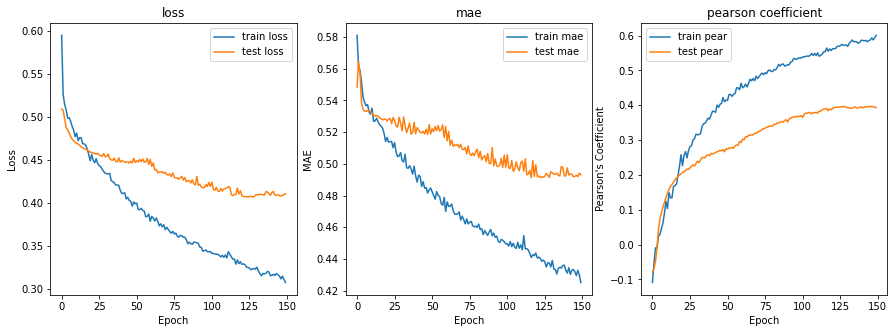

In [48]:

import matplotlib.pyplot as plt
print("Performances for NCE, Fr+ES translation, only conditioned on V")
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.plot(all_train_loss, label="train loss")
ax1.plot(all_test_loss, label="test loss")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.legend(loc="best")
ax1.set_title("loss")

ax2.plot(all_train_mae, label="train mae")
ax2.plot(all_test_mae, label="test mae")
ax2.set_title("mae")
ax2.set_ylabel("MAE")
ax2.set_xlabel("Epoch")
ax2.legend(loc="best")

ax3.plot(all_train_pear, label="train pear")
ax3.plot(all_test_pear, label="test pear")
ax3.set_title("pearson coefficient")
ax3.legend(loc="best")
ax3.set_ylabel("Pearson's Coefficient")
ax3.set_xlabel("Epoch")

# plt.show()

In [49]:
import pickle

with open("/content/drive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_regression_NCE_FR+ESTranslate/training_res_conditioned_V.pickle", "wb") as f:
    pickle.dump({"all_train_loss": all_train_loss,
    "all_test_loss": all_test_loss,
    "all_train_mae": all_train_mae,
    "all_test_mae":all_test_mae,
    "all_train_pear":all_train_pear,
    "all_test_pear": all_test_pear},f)

In [50]:
train_loader, valid_loader, test_loader = get_MOSEI_loaders_NCE('/content/drive/MyDrive/11-777 MMML/multilogue-net/data/moseas_spanish_duptextfornce_full_regression.pickle', valid=0.0, batch_size=batch_size, num_workers=0)

french
testset.len:  52


In [51]:
# evaluate on actual ES data, duptextforNCE
test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, MSEloss, NCEloss, test_loader,0)
print(test_loss)
print(test_mae)
print(test_pear)

torch.Size([105, 52, 300]) torch.Size([105, 52, 300])
0.8933
0.7794
0.3368


## train other setting

In [ ]:
# Instantiate model
model = RegressionModelNCE(D_m_text, D_m_audio, D_m_video, D_m_context, D_g, D_p, D_e, D_h, dropout_rec=args["rec_dropout"], dropout=args["dropout"])

if cuda:
    model.cuda()
MSEloss = MaskedMSELoss()
NCEloss = CrossLingualNCELoss()

# Get optimizer and relevant dataloaders
optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['l2'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7,patience=10,verbose=True)

# amelia
train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/drive/MyDrive/11-777 MMML/multilogue-net/data/moseas_full_regression_french_spanishtranslate.pickle', valid=0.0, batch_size=batch_size, num_workers=0)
# abbey
# train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/gdrive/MyDrive/multilogue-net/data/moseas_full_regression_spanish.pickle', valid=0.0, batch_size=batch_size, num_workers=0)

# train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/gdrive/MyDrive/multilogue-net/data/regression.pkl', valid=0.0, batch_size=batch_size, num_workers=0)
best_loss, best_label, best_pred, best_mask, best_pear = None, None, None, None, None
all_train_loss, all_test_loss, all_train_mae, all_test_mae, all_train_pear, all_test_pear = [],[],[],[],[],[]

In [ ]:
# Training loop
for e in tqdm(range(n_epochs), desc = 'MOSEAS Regression'):
    train_loss, train_mae, train_pear,_,_,_ = train_or_eval_model(model, MSEloss, NCEloss, train_loader, e, optimizer, True)
    test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, MSEloss, NCEloss, test_loader, e)
    log_res(train_loss, test_loss, train_mae, test_mae, train_pear, test_pear)

    if best_loss == None or best_loss > test_loss:
        best_loss, best_mae, best_label, best_pred, best_mask, best_pear =\
                test_loss, test_mae, test_label, test_pred, test_mask, test_pear
        print(f"saving checkpoint for epoch {e}")
        torch.save(model.state_dict(),f"/content/drive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_regression/epoch{e}_testloss_{best_loss}_testmae_{best_mae}_testpear_{best_pear}.t7")

print('Test performance..')
print('Loss {} MAE {} r {}'.format(best_loss, round(mean_absolute_error(best_label,best_pred,sample_weight=best_mask),4), best_pear))

MOSEAS Regression:   0%|          | 0/250 [00:00<?, ?it/s]/content/drive/.shortcut-targets-by-id/1sKygtzdMExNjy2GJE2k9Z6m8S3ehIYG3/11-777 MMML/multilogue-net/dataloader.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return self._deactive((torch.FloatTensor(self.videoText1[vid]),\


torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
598.1312522888184
1.3970752
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
562.4518976211548
1.3972825
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
519.7386310100555
1.396158
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
423.70714497566223
1.3956367
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   0%|          | 1/250 [00:16<1:06:51, 16.11s/it]

536.0751185417175
1.3951669
Train Loss - MOSEAS Regression:  0.5327
Test Loss - MOSEAS Regression:  0.4868
Train MAE - MOSEAS Regression:  0.5568
Test MAE - MOSEAS Regression:  0.5466
Train Pearson - MOSEAS Regression:  -0.0214
Test Pearson - MOSEAS Regression:  -0.0271
saving checkpoint for epoch 0
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
596.2772313952446
1.3953781
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
663.982177734375
1.3952564
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
488.07524502277374
1.3951585
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
262.1110290288925
1.3953071
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   1%|          | 2/250 [00:34<1:12:49, 17.62s/it]

531.3421010971069
1.3945
Train Loss - MOSEAS Regression:  0.5091
Test Loss - MOSEAS Regression:  0.4826
Train MAE - MOSEAS Regression:  0.5558
Test MAE - MOSEAS Regression:  0.5448
Train Pearson - MOSEAS Regression:  0.0122
Test Pearson - MOSEAS Regression:  0.0175
saving checkpoint for epoch 1
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
566.2624597549438
1.39529
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
723.359393298626
1.3946583
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
457.2436997294426
1.3943801
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
230.48374146223068
1.3946911
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   1%|          | 3/250 [00:51<1:11:42, 17.42s/it]

524.9942650794983
1.3939303
Train Loss - MOSEAS Regression:  0.5007
Test Loss - MOSEAS Regression:  0.4768
Train MAE - MOSEAS Regression:  0.5466
Test MAE - MOSEAS Regression:  0.5313
Train Pearson - MOSEAS Regression:  0.0199
Test Pearson - MOSEAS Regression:  0.108
saving checkpoint for epoch 2
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
586.8400856852531
1.3941727
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
512.6541624069214
1.3938603
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
485.43518257141113
1.3941529
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
370.50738751888275
1.3934801
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   2%|▏         | 4/250 [01:10<1:13:42, 17.98s/it]

527.6259784698486
1.3934419
Train Loss - MOSEAS Regression:  0.4952
Test Loss - MOSEAS Regression:  0.4792
Train MAE - MOSEAS Regression:  0.538
Test MAE - MOSEAS Regression:  0.5314
Train Pearson - MOSEAS Regression:  0.0535
Test Pearson - MOSEAS Regression:  0.142
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
584.8061558902264
1.3936274
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
522.539083480835
1.3934677
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
565.9120498299599
1.3932271
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
269.53433960676193
1.3931305
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   2%|▏         | 5/250 [01:29<1:14:20, 18.21s/it]

518.2451920509338
1.3929887
Train Loss - MOSEAS Regression:  0.492
Test Loss - MOSEAS Regression:  0.4707
Train MAE - MOSEAS Regression:  0.5336
Test MAE - MOSEAS Regression:  0.5306
Train Pearson - MOSEAS Regression:  0.0714
Test Pearson - MOSEAS Regression:  0.1443
saving checkpoint for epoch 4
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
520.9406795203686
1.3933098
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
552.0743982791901
1.3928938
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
572.9905934035778
1.3927324
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
252.36926075816154
1.3926904
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   2%|▏         | 6/250 [01:47<1:14:20, 18.28s/it]

517.0078225135803
1.39258
Train Loss - MOSEAS Regression:  0.4808
Test Loss - MOSEAS Regression:  0.4696
Train MAE - MOSEAS Regression:  0.535
Test MAE - MOSEAS Regression:  0.5355
Train Pearson - MOSEAS Regression:  0.1132
Test Pearson - MOSEAS Regression:  0.1482
saving checkpoint for epoch 5
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
499.5749080777168
1.3925581
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
696.363297522068
1.3925631
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
418.0822653770447
1.3924081
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
313.27824997901917
1.3922124
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   3%|▎         | 7/250 [02:06<1:14:12, 18.32s/it]

514.60724401474
1.3922073
Train Loss - MOSEAS Regression:  0.4881
Test Loss - MOSEAS Regression:  0.4674
Train MAE - MOSEAS Regression:  0.5407
Test MAE - MOSEAS Regression:  0.533
Train Pearson - MOSEAS Regression:  0.0834
Test Pearson - MOSEAS Regression:  0.1602
saving checkpoint for epoch 6
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
596.6983515322208
1.3920896
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
529.5178937911987
1.3920342
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
440.0139930844307
1.392347
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
314.6916956305504
1.391921
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   3%|▎         | 8/250 [02:24<1:13:42, 18.27s/it]

513.5787348747253
1.3918781
Train Loss - MOSEAS Regression:  0.4764
Test Loss - MOSEAS Regression:  0.4665
Train MAE - MOSEAS Regression:  0.53
Test MAE - MOSEAS Regression:  0.5293
Train Pearson - MOSEAS Regression:  0.1313
Test Pearson - MOSEAS Regression:  0.17
saving checkpoint for epoch 7
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
517.4492220580578
1.3918285
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
455.27336224913597
1.3917645
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
553.122122168541
1.3919529
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
346.9809651374817
1.3914084
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   4%|▎         | 9/250 [02:42<1:12:54, 18.15s/it]

512.7549405097961
1.391592
Train Loss - MOSEAS Regression:  0.4743
Test Loss - MOSEAS Regression:  0.4657
Train MAE - MOSEAS Regression:  0.5265
Test MAE - MOSEAS Regression:  0.5284
Train Pearson - MOSEAS Regression:  0.1452
Test Pearson - MOSEAS Regression:  0.1765
saving checkpoint for epoch 8
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
552.3399068713188
1.3916647
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
578.732965528965
1.3914908
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
552.8064937591553
1.3914069
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
195.45537972450256
1.3913565
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   4%|▍         | 10/250 [02:59<1:10:51, 17.71s/it]

511.9943833351135
1.3913224
Train Loss - MOSEAS Regression:  0.476
Test Loss - MOSEAS Regression:  0.465
Train MAE - MOSEAS Regression:  0.5263
Test MAE - MOSEAS Regression:  0.5277
Train Pearson - MOSEAS Regression:  0.1404
Test Pearson - MOSEAS Regression:  0.1821
saving checkpoint for epoch 9
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
451.0073722600937
1.391639
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
572.0612765550613
1.391015
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
484.8227760195732
1.3909471
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
342.5853042602539
1.3910958
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   4%|▍         | 11/250 [03:17<1:11:19, 17.91s/it]

509.8427724838257
1.3910753
Train Loss - MOSEAS Regression:  0.4687
Test Loss - MOSEAS Regression:  0.4631
Train MAE - MOSEAS Regression:  0.524
Test MAE - MOSEAS Regression:  0.5281
Train Pearson - MOSEAS Regression:  0.1741
Test Pearson - MOSEAS Regression:  0.1871
saving checkpoint for epoch 10
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
439.86603605747223
1.3908712
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
464.96258813142776
1.3908491
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
551.9991445541382
1.3910501
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
361.5055724978447
1.3908522
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   5%|▍         | 12/250 [03:35<1:11:14, 17.96s/it]

508.5411458015442
1.3908486
Train Loss - MOSEAS Regression:  0.4606
Test Loss - MOSEAS Regression:  0.4619
Train MAE - MOSEAS Regression:  0.5208
Test MAE - MOSEAS Regression:  0.5284
Train Pearson - MOSEAS Regression:  0.2093
Test Pearson - MOSEAS Regression:  0.1914
saving checkpoint for epoch 11
torch.Size([54, 64, 300]) torch.Size([54, 64, 300])
540.476925611496
1.3908427
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
544.911039352417
1.39058
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
462.16895174980164
1.390964
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
273.8439302444458
1.3905598
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   5%|▌         | 13/250 [03:52<1:09:36, 17.62s/it]

507.98207902908325
1.3906503
Train Loss - MOSEAS Regression:  0.4614
Test Loss - MOSEAS Regression:  0.4614
Train MAE - MOSEAS Regression:  0.5208
Test MAE - MOSEAS Regression:  0.5276
Train Pearson - MOSEAS Regression:  0.2068
Test Pearson - MOSEAS Regression:  0.1952
saving checkpoint for epoch 12
torch.Size([47, 64, 300]) torch.Size([47, 64, 300])
450.68470388650894
1.3904155
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
508.5811980366707
1.3905089
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
579.5087172687054
1.3903399
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
278.07947528362274
1.3905652
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   6%|▌         | 14/250 [04:08<1:08:05, 17.31s/it]

507.2711706161499
1.3904777
Train Loss - MOSEAS Regression:  0.4602
Test Loss - MOSEAS Regression:  0.4607
Train MAE - MOSEAS Regression:  0.5207
Test MAE - MOSEAS Regression:  0.5278
Train Pearson - MOSEAS Regression:  0.2128
Test Pearson - MOSEAS Regression:  0.1981
saving checkpoint for epoch 13
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
648.011634349823
1.3902054
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
440.0515892505646
1.3902782
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
504.8192898631096
1.3905811
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
188.88308238983154
1.3902212
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   6%|▌         | 15/250 [04:27<1:09:11, 17.66s/it]

508.88352155685425
1.3903065
Train Loss - MOSEAS Regression:  0.4513
Test Loss - MOSEAS Regression:  0.4622
Train MAE - MOSEAS Regression:  0.517
Test MAE - MOSEAS Regression:  0.5254
Train Pearson - MOSEAS Regression:  0.2497
Test Pearson - MOSEAS Regression:  0.2014
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
475.4598757624626
1.3907216
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
518.9553780853748
1.3900626
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
484.7314524054527
1.3899226
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
314.4209682941437
1.3898559
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   6%|▋         | 16/250 [04:45<1:08:55, 17.67s/it]

507.9303574562073
1.3901503
Train Loss - MOSEAS Regression:  0.4543
Test Loss - MOSEAS Regression:  0.4613
Train MAE - MOSEAS Regression:  0.5135
Test MAE - MOSEAS Regression:  0.5251
Train Pearson - MOSEAS Regression:  0.2412
Test Pearson - MOSEAS Regression:  0.205
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
518.552628993988
1.389907
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
461.72462153434753
1.3899035
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
494.63118451833725
1.3904114
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
320.18228366971016
1.3896878
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   7%|▋         | 17/250 [05:02<1:08:38, 17.67s/it]

505.71037673950195
1.3900107
Train Loss - MOSEAS Regression:  0.4547
Test Loss - MOSEAS Regression:  0.4593
Train MAE - MOSEAS Regression:  0.5156
Test MAE - MOSEAS Regression:  0.5257
Train Pearson - MOSEAS Regression:  0.2399
Test Pearson - MOSEAS Regression:  0.2091
saving checkpoint for epoch 16
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
563.8369903564453
1.3897576
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
515.6796898841858
1.3897676
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
375.9439026415348
1.3899697
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
315.86850678920746
1.3898835
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   7%|▋         | 18/250 [05:20<1:08:47, 17.79s/it]

504.67522144317627
1.3898776
Train Loss - MOSEAS Regression:  0.4487
Test Loss - MOSEAS Regression:  0.4584
Train MAE - MOSEAS Regression:  0.5127
Test MAE - MOSEAS Regression:  0.5265
Train Pearson - MOSEAS Regression:  0.2604
Test Pearson - MOSEAS Regression:  0.2123
saving checkpoint for epoch 17
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
528.9284715056419
1.3895724
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
497.0545797049999
1.3897178
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
455.2209527492523
1.3901376
torch.Size([47, 36, 300]) torch.Size([47, 36, 300])
279.6522864103317
1.389688
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   8%|▊         | 19/250 [05:38<1:07:57, 17.65s/it]

505.0022978782654
1.3897493
Train Loss - MOSEAS Regression:  0.4461
Test Loss - MOSEAS Regression:  0.4587
Train MAE - MOSEAS Regression:  0.5108
Test MAE - MOSEAS Regression:  0.5245
Train Pearson - MOSEAS Regression:  0.2709
Test Pearson - MOSEAS Regression:  0.2155
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
532.0438299179077
1.3898835
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
523.1679823994637
1.3894308
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
464.19268199801445
1.3895354
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
233.59885436296463
1.389333
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   8%|▊         | 20/250 [05:56<1:08:51, 17.96s/it]

504.41980504989624
1.3896348
Train Loss - MOSEAS Regression:  0.4441
Test Loss - MOSEAS Regression:  0.4582
Train MAE - MOSEAS Regression:  0.5087
Test MAE - MOSEAS Regression:  0.5243
Train Pearson - MOSEAS Regression:  0.2804
Test Pearson - MOSEAS Regression:  0.2186
saving checkpoint for epoch 19
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
556.9222459793091
1.3896668
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
484.7700021266937
1.3894327
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
415.2845633029938
1.389282
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
287.4118706583977
1.3892431
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   8%|▊         | 21/250 [06:14<1:08:02, 17.83s/it]

503.8710036277771
1.3895363
Train Loss - MOSEAS Regression:  0.4419
Test Loss - MOSEAS Regression:  0.4577
Train MAE - MOSEAS Regression:  0.5104
Test MAE - MOSEAS Regression:  0.528
Train Pearson - MOSEAS Regression:  0.2864
Test Pearson - MOSEAS Regression:  0.2205
saving checkpoint for epoch 20
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
545.7642653882504
1.3892303
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
438.2729011774063
1.3892462
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
465.88671776652336
1.3893073
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
282.17742070555687
1.3895895
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   9%|▉         | 22/250 [06:31<1:07:10, 17.68s/it]

502.63235092163086
1.3894343
Train Loss - MOSEAS Regression:  0.4388
Test Loss - MOSEAS Regression:  0.4565
Train MAE - MOSEAS Regression:  0.5098
Test MAE - MOSEAS Regression:  0.5248
Train Pearson - MOSEAS Regression:  0.2998
Test Pearson - MOSEAS Regression:  0.2247
saving checkpoint for epoch 21
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
538.3123947381973
1.3892202
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
465.61634612083435
1.389502
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
510.57143676280975
1.3890795
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
223.30441546440125
1.3891902
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:   9%|▉         | 23/250 [06:49<1:06:58, 17.70s/it]

503.5638327598572
1.3893452
Train Loss - MOSEAS Regression:  0.4402
Test Loss - MOSEAS Regression:  0.4574
Train MAE - MOSEAS Regression:  0.5046
Test MAE - MOSEAS Regression:  0.523
Train Pearson - MOSEAS Regression:  0.2957
Test Pearson - MOSEAS Regression:  0.2275
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
526.0680466890335
1.3890343
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
574.1751888394356
1.3894199
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
426.36738044023514
1.3890239
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
195.02659353613853
1.3890243
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  10%|▉         | 24/250 [07:06<1:05:49, 17.48s/it]

502.7832384109497
1.3892604
Train Loss - MOSEAS Regression:  0.4362
Test Loss - MOSEAS Regression:  0.4567
Train MAE - MOSEAS Regression:  0.5049
Test MAE - MOSEAS Regression:  0.5282
Train Pearson - MOSEAS Regression:  0.3069
Test Pearson - MOSEAS Regression:  0.2294
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
531.5445034503937
1.3891126
torch.Size([54, 64, 300]) torch.Size([54, 64, 300])
472.97612315416336
1.3888705
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
438.04942643642426
1.3894222
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
267.7346773445606
1.3889289
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  10%|█         | 25/250 [07:24<1:05:42, 17.52s/it]

500.237859249115
1.3891653
Train Loss - MOSEAS Regression:  0.4333
Test Loss - MOSEAS Regression:  0.4544
Train MAE - MOSEAS Regression:  0.5067
Test MAE - MOSEAS Regression:  0.5239
Train Pearson - MOSEAS Regression:  0.3202
Test Pearson - MOSEAS Regression:  0.2339
saving checkpoint for epoch 24
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
440.5547305345535
1.3889838
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
509.35786628723145
1.3888246
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
559.5096480250359
1.3892672
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
195.11316525936127
1.3887382
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  10%|█         | 26/250 [07:41<1:05:22, 17.51s/it]

501.64927911758423
1.3890727
Train Loss - MOSEAS Regression:  0.4318
Test Loss - MOSEAS Regression:  0.4557
Train MAE - MOSEAS Regression:  0.5002
Test MAE - MOSEAS Regression:  0.5218
Train Pearson - MOSEAS Regression:  0.3242
Test Pearson - MOSEAS Regression:  0.2369
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
527.0259529650211
1.3888495
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
459.0948611497879
1.3888464
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
437.74994361400604
1.3892558
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
279.63186979293823
1.3888035
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  11%|█         | 27/250 [08:00<1:06:39, 17.93s/it]

499.36773920059204
1.3889923
Train Loss - MOSEAS Regression:  0.4316
Test Loss - MOSEAS Regression:  0.4536
Train MAE - MOSEAS Regression:  0.5018
Test MAE - MOSEAS Regression:  0.5244
Train Pearson - MOSEAS Regression:  0.3237
Test Pearson - MOSEAS Regression:  0.2389
saving checkpoint for epoch 26
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
554.3618717193604
1.3890542
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
440.49496710300446
1.3886187
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
397.34738278388977
1.3886874
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
302.79745477437973
1.3885894
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  11%|█         | 28/250 [08:16<1:04:48, 17.52s/it]

499.1987886428833
1.3889079
Train Loss - MOSEAS Regression:  0.4294
Test Loss - MOSEAS Regression:  0.4534
Train MAE - MOSEAS Regression:  0.502
Test MAE - MOSEAS Regression:  0.5247
Train Pearson - MOSEAS Regression:  0.3294
Test Pearson - MOSEAS Regression:  0.2418
saving checkpoint for epoch 27
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
391.75065183639526
1.3886585
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
485.5641809105873
1.3886561
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
550.4262846708298
1.3889561
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
251.47860145568848
1.3885425
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  12%|█▏        | 29/250 [08:34<1:04:10, 17.42s/it]

498.5798406600952
1.3888185
Train Loss - MOSEAS Regression:  0.4254
Test Loss - MOSEAS Regression:  0.4529
Train MAE - MOSEAS Regression:  0.4981
Test MAE - MOSEAS Regression:  0.5224
Train Pearson - MOSEAS Regression:  0.343
Test Pearson - MOSEAS Regression:  0.2456
saving checkpoint for epoch 28
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
449.2924626171589
1.3890404
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
499.8719173669815
1.3885864
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
514.0221601724625
1.3884969
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
226.60527527332306
1.3886716
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  12%|█▏        | 30/250 [08:53<1:05:27, 17.85s/it]

498.0261697769165
1.3887382
Train Loss - MOSEAS Regression:  0.4281
Test Loss - MOSEAS Regression:  0.4524
Train MAE - MOSEAS Regression:  0.4984
Test MAE - MOSEAS Regression:  0.5231
Train Pearson - MOSEAS Regression:  0.3349
Test Pearson - MOSEAS Regression:  0.2484
saving checkpoint for epoch 29
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
454.3270519375801
1.388959
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
578.8481467962265
1.3884147
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
363.0780672132969
1.3885591
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
266.87130868434906
1.38836
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  12%|█▏        | 31/250 [09:11<1:05:36, 17.97s/it]

498.413818359375
1.3886647
Train Loss - MOSEAS Regression:  0.4214
Test Loss - MOSEAS Regression:  0.4527
Train MAE - MOSEAS Regression:  0.4959
Test MAE - MOSEAS Regression:  0.5246
Train Pearson - MOSEAS Regression:  0.3554
Test Pearson - MOSEAS Regression:  0.2516
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
443.085569858551
1.3884484
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
449.1506319344044
1.3884819
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
535.7131329774857
1.3886893
torch.Size([43, 36, 300]) torch.Size([43, 36, 300])
214.93225342035294
1.3883278
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  13%|█▎        | 32/250 [09:28<1:04:42, 17.81s/it]

498.0113968849182
1.3885841
Train Loss - MOSEAS Regression:  0.4163
Test Loss - MOSEAS Regression:  0.4524
Train MAE - MOSEAS Regression:  0.4941
Test MAE - MOSEAS Regression:  0.5208
Train Pearson - MOSEAS Regression:  0.369
Test Pearson - MOSEAS Regression:  0.2554
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
528.5578495264053
1.3882754
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
446.78821325302124
1.3887035
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
491.70217898488045
1.388329
torch.Size([37, 36, 300]) torch.Size([37, 36, 300])
183.29791301488876
1.3882257
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  13%|█▎        | 33/250 [09:46<1:04:11, 17.75s/it]

497.2905192375183
1.388506
Train Loss - MOSEAS Regression:  0.4182
Test Loss - MOSEAS Regression:  0.4517
Train MAE - MOSEAS Regression:  0.4914
Test MAE - MOSEAS Regression:  0.524
Train Pearson - MOSEAS Regression:  0.365
Test Pearson - MOSEAS Regression:  0.2582
saving checkpoint for epoch 32
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
464.75573602318764
1.388164
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
496.05803632736206
1.3885576
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
403.6505227088928
1.388401
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
280.2215254306793
1.3881466
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  14%|█▎        | 34/250 [10:04<1:04:10, 17.83s/it]

494.68792390823364
1.3884275
Train Loss - MOSEAS Regression:  0.4167
Test Loss - MOSEAS Regression:  0.4493
Train MAE - MOSEAS Regression:  0.4957
Test MAE - MOSEAS Regression:  0.5208
Train Pearson - MOSEAS Regression:  0.3716
Test Pearson - MOSEAS Regression:  0.2618
saving checkpoint for epoch 33
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
410.7150385379791
1.3885891
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
519.2750373184681
1.3882093
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
406.41272377967834
1.3880422
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
286.6315077841282
1.3881025
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  14%|█▍        | 35/250 [10:22<1:04:11, 17.92s/it]

494.0990152359009
1.3883526
Train Loss - MOSEAS Regression:  0.4113
Test Loss - MOSEAS Regression:  0.4488
Train MAE - MOSEAS Regression:  0.4894
Test MAE - MOSEAS Regression:  0.5198
Train Pearson - MOSEAS Regression:  0.3837
Test Pearson - MOSEAS Regression:  0.2651
saving checkpoint for epoch 34
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
507.718424141407
1.3883317
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
524.9150595664978
1.3882263
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
339.32154190540314
1.3879952
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
247.72557151317596
1.3879842
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  14%|█▍        | 36/250 [10:39<1:03:03, 17.68s/it]

498.17689275741577
1.3882909
Train Loss - MOSEAS Regression:  0.4104
Test Loss - MOSEAS Regression:  0.4525
Train MAE - MOSEAS Regression:  0.4911
Test MAE - MOSEAS Regression:  0.5245
Train Pearson - MOSEAS Regression:  0.3854
Test Pearson - MOSEAS Regression:  0.2653
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
465.16036677360535
1.3880506
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
455.2069230079651
1.3881179
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
472.3568245768547
1.3880422
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
244.52223029732704
1.3884522
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  15%|█▍        | 37/250 [10:57<1:03:11, 17.80s/it]

492.8600335121155
1.3882339
Train Loss - MOSEAS Regression:  0.4148
Test Loss - MOSEAS Regression:  0.4477
Train MAE - MOSEAS Regression:  0.4931
Test MAE - MOSEAS Regression:  0.5184
Train Pearson - MOSEAS Regression:  0.3722
Test Pearson - MOSEAS Regression:  0.27
saving checkpoint for epoch 36
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
468.9046401977539
1.3879955
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
438.90095114707947
1.3883588
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
378.9508958160877
1.3881083
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
332.65265160799026
1.3879886
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  15%|█▌        | 38/250 [11:16<1:04:11, 18.17s/it]

491.56653356552124
1.3881752
Train Loss - MOSEAS Regression:  0.4103
Test Loss - MOSEAS Regression:  0.4465
Train MAE - MOSEAS Regression:  0.4928
Test MAE - MOSEAS Regression:  0.5181
Train Pearson - MOSEAS Regression:  0.3853
Test Pearson - MOSEAS Regression:  0.2724
saving checkpoint for epoch 37
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
393.2810080051422
1.3880653
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
434.9436056613922
1.3879278
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
568.7540304660797
1.3882347
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
218.39808547496796
1.3878183
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  16%|█▌        | 39/250 [11:34<1:03:43, 18.12s/it]

490.69957208633423
1.3881226
Train Loss - MOSEAS Regression:  0.4093
Test Loss - MOSEAS Regression:  0.4457
Train MAE - MOSEAS Regression:  0.4874
Test MAE - MOSEAS Regression:  0.5182
Train Pearson - MOSEAS Regression:  0.3923
Test Pearson - MOSEAS Regression:  0.2751
saving checkpoint for epoch 38
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
400.86619848012924
1.3878334
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
428.32848501205444
1.3880231
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
435.85371109843254
1.3879702
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
356.73591870069504
1.3879514
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  16%|█▌        | 40/250 [11:52<1:02:44, 17.93s/it]

490.4702796936035
1.3880707
Train Loss - MOSEAS Regression:  0.4109
Test Loss - MOSEAS Regression:  0.4455
Train MAE - MOSEAS Regression:  0.4933
Test MAE - MOSEAS Regression:  0.5184
Train Pearson - MOSEAS Regression:  0.3899
Test Pearson - MOSEAS Regression:  0.2774
saving checkpoint for epoch 39
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
435.66132098436356
1.3877693
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
426.5610342621803
1.3882389
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
493.4315865635872
1.3877509
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
219.25001645088196
1.3879019
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  16%|█▋        | 41/250 [12:10<1:02:37, 17.98s/it]

489.62769842147827
1.3880229
Train Loss - MOSEAS Regression:  0.3991
Test Loss - MOSEAS Regression:  0.4448
Train MAE - MOSEAS Regression:  0.4826
Test MAE - MOSEAS Regression:  0.5166
Train Pearson - MOSEAS Regression:  0.4165
Test Pearson - MOSEAS Regression:  0.2806
saving checkpoint for epoch 40
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
430.1911586523056
1.3878043
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
485.3864500820637
1.3877015
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
437.66861993074417
1.3880955
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
241.1630277633667
1.387878
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  17%|█▋        | 42/250 [12:28<1:02:47, 18.11s/it]

489.9601049423218
1.3879724
Train Loss - MOSEAS Regression:  0.404
Test Loss - MOSEAS Regression:  0.4451
Train MAE - MOSEAS Regression:  0.4883
Test MAE - MOSEAS Regression:  0.5187
Train Pearson - MOSEAS Regression:  0.4034
Test Pearson - MOSEAS Regression:  0.2819
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
473.3391754627228
1.3876256
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
388.9197762608528
1.3877466
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
418.28350257873535
1.3880239
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
283.96060585975647
1.3876611
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  17%|█▋        | 43/250 [12:45<1:01:25, 17.81s/it]

488.36792278289795
1.3879223
Train Loss - MOSEAS Regression:  0.3965
Test Loss - MOSEAS Regression:  0.4436
Train MAE - MOSEAS Regression:  0.4804
Test MAE - MOSEAS Regression:  0.5167
Train Pearson - MOSEAS Regression:  0.4232
Test Pearson - MOSEAS Regression:  0.2837
saving checkpoint for epoch 42
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
522.2666121721268
1.3880001
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
368.70001435279846
1.3876643
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
432.6811950802803
1.3877203
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
251.50970041751862
1.3877175
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  18%|█▊        | 44/250 [13:04<1:01:41, 17.97s/it]

491.11373949050903
1.3878744
Train Loss - MOSEAS Regression:  0.3992
Test Loss - MOSEAS Regression:  0.4461
Train MAE - MOSEAS Regression:  0.4849
Test MAE - MOSEAS Regression:  0.5188
Train Pearson - MOSEAS Regression:  0.4149
Test Pearson - MOSEAS Regression:  0.2812
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
440.8035852909088
1.3877549
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
390.51054283976555
1.3875561
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
474.8522459566593
1.3879826
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
268.50918024778366
1.3875346
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  18%|█▊        | 45/250 [13:21<1:01:10, 17.90s/it]

489.5244197845459
1.3878388
Train Loss - MOSEAS Regression:  0.399
Test Loss - MOSEAS Regression:  0.4447
Train MAE - MOSEAS Regression:  0.485
Test MAE - MOSEAS Regression:  0.5164
Train Pearson - MOSEAS Regression:  0.4144
Test Pearson - MOSEAS Regression:  0.2854
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
453.95153760910034
1.387944
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
468.80482310056686
1.3876452
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
400.8228734135628
1.3876128
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
226.81484985351562
1.3876193
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  18%|█▊        | 46/250 [13:40<1:01:09, 17.99s/it]

491.48335790634155
1.3877932
Train Loss - MOSEAS Regression:  0.3929
Test Loss - MOSEAS Regression:  0.4464
Train MAE - MOSEAS Regression:  0.4796
Test MAE - MOSEAS Regression:  0.5189
Train Pearson - MOSEAS Regression:  0.4319
Test Pearson - MOSEAS Regression:  0.2848
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
483.67814150452614
1.3876495
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
385.7006746530533
1.387607
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
442.7505363225937
1.3877404
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
246.96960550546646
1.3878279
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  19%|█▉        | 47/250 [13:57<1:00:44, 17.95s/it]

490.492817401886
1.3877549
Train Loss - MOSEAS Regression:  0.3951
Test Loss - MOSEAS Regression:  0.4455
Train MAE - MOSEAS Regression:  0.4846
Test MAE - MOSEAS Regression:  0.5173
Train Pearson - MOSEAS Regression:  0.427
Test Pearson - MOSEAS Regression:  0.2871
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
398.54371359944344
1.3875537
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
469.63998222351074
1.3877655
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
472.8924986720085
1.3875139
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
219.00013715028763
1.3874781
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  19%|█▉        | 48/250 [14:14<59:32, 17.68s/it]  

491.7316017150879
1.3877163
Train Loss - MOSEAS Regression:  0.3954
Test Loss - MOSEAS Regression:  0.4467
Train MAE - MOSEAS Regression:  0.4811
Test MAE - MOSEAS Regression:  0.5187
Train Pearson - MOSEAS Regression:  0.4246
Test Pearson - MOSEAS Regression:  0.2867
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
467.8374598622322
1.3874614
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
484.0767570734024
1.3875434
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
418.83386662602425
1.3877863
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
184.3629091978073
1.3875561
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  20%|█▉        | 49/250 [14:33<59:42, 17.82s/it]

490.6161332130432
1.3876836
Train Loss - MOSEAS Regression:  0.3941
Test Loss - MOSEAS Regression:  0.4457
Train MAE - MOSEAS Regression:  0.4835
Test MAE - MOSEAS Regression:  0.5173
Train Pearson - MOSEAS Regression:  0.4286
Test Pearson - MOSEAS Regression:  0.2893
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
415.48705184459686
1.3877542
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
362.6047432422638
1.3875146
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
502.55479869246483
1.3874397
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
256.31008487939835
1.3874761
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  20%|██        | 50/250 [14:51<59:45, 17.93s/it]

492.07565546035767
1.3876467
Train Loss - MOSEAS Regression:  0.3895
Test Loss - MOSEAS Regression:  0.447
Train MAE - MOSEAS Regression:  0.4761
Test MAE - MOSEAS Regression:  0.5191
Train Pearson - MOSEAS Regression:  0.4394
Test Pearson - MOSEAS Regression:  0.2899
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
446.0228379666805
1.3877383
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
470.98808911442757
1.3874519
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
341.2719011902809
1.387422
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
278.37849992513657
1.3874354
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  20%|██        | 51/250 [15:09<59:54, 18.06s/it]

488.3230447769165
1.3876208
Train Loss - MOSEAS Regression:  0.3894
Test Loss - MOSEAS Regression:  0.4436
Train MAE - MOSEAS Regression:  0.4786
Test MAE - MOSEAS Regression:  0.5159
Train Pearson - MOSEAS Regression:  0.4407
Test Pearson - MOSEAS Regression:  0.2947
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
449.38798040151596
1.3877268
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
392.1663810610771
1.3874896
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
412.71553072333336
1.3874369
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
278.1741988658905
1.3873882
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  21%|██        | 52/250 [15:27<59:39, 18.08s/it]

488.84022760391235
1.3876002
Train Loss - MOSEAS Regression:  0.3884
Test Loss - MOSEAS Regression:  0.444
Train MAE - MOSEAS Regression:  0.4759
Test MAE - MOSEAS Regression:  0.5164
Train Pearson - MOSEAS Regression:  0.4412
Test Pearson - MOSEAS Regression:  0.2955
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
386.0484444499016
1.3875546
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
391.3192668557167
1.3874569
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
585.0421011447906
1.3875546
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
191.99817699193954
1.3873767
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  21%|██        | 53/250 [15:46<59:32, 18.13s/it]

488.04706478118896
1.3875855
Train Loss - MOSEAS Regression:  0.3939
Test Loss - MOSEAS Regression:  0.4433
Train MAE - MOSEAS Regression:  0.4806
Test MAE - MOSEAS Regression:  0.5154
Train Pearson - MOSEAS Regression:  0.4282
Test Pearson - MOSEAS Regression:  0.2979
saving checkpoint for epoch 52
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
331.1876886487007
1.3874568
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
458.8937759399414
1.3873553
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
459.3018193244934
1.3873904
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
275.39825919270515
1.3874924
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  22%|██▏       | 54/250 [16:02<57:28, 17.59s/it]

486.9190607070923
1.3875642
Train Loss - MOSEAS Regression:  0.3864
Test Loss - MOSEAS Regression:  0.4423
Train MAE - MOSEAS Regression:  0.4759
Test MAE - MOSEAS Regression:  0.5149
Train Pearson - MOSEAS Regression:  0.4446
Test Pearson - MOSEAS Regression:  0.2995
saving checkpoint for epoch 53
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
398.6605718135834
1.3874102
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
431.40468671917915
1.3873644
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
430.1178576052189
1.3876057
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
243.8976519703865
1.3873479
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  22%|██▏       | 55/250 [16:19<56:42, 17.45s/it]

486.14201974868774
1.387544
Train Loss - MOSEAS Regression:  0.3812
Test Loss - MOSEAS Regression:  0.4416
Train MAE - MOSEAS Regression:  0.4732
Test MAE - MOSEAS Regression:  0.5146
Train Pearson - MOSEAS Regression:  0.4579
Test Pearson - MOSEAS Regression:  0.3022
saving checkpoint for epoch 54
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
382.185249209404
1.3873171
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
461.5466783642769
1.3876476
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
464.2490291297436
1.3874049
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
234.27047353982925
1.3873304
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  22%|██▏       | 56/250 [16:37<57:00, 17.63s/it]

485.4434823989868
1.3875256
Train Loss - MOSEAS Regression:  0.3909
Test Loss - MOSEAS Regression:  0.441
Train MAE - MOSEAS Regression:  0.4817
Test MAE - MOSEAS Regression:  0.5136
Train Pearson - MOSEAS Regression:  0.436
Test Pearson - MOSEAS Regression:  0.3052
saving checkpoint for epoch 55
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
535.3414478898048
1.387553
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
381.40123522281647
1.3873998
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
394.22384226322174
1.3873174
torch.Size([49, 36, 300]) torch.Size([49, 36, 300])
212.69617080688477
1.3873167
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  23%|██▎       | 57/250 [16:54<56:04, 17.43s/it]

493.53050565719604
1.3875003
Train Loss - MOSEAS Regression:  0.3862
Test Loss - MOSEAS Regression:  0.4483
Train MAE - MOSEAS Regression:  0.4745
Test MAE - MOSEAS Regression:  0.5205
Train Pearson - MOSEAS Regression:  0.4503
Test Pearson - MOSEAS Regression:  0.3019
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
466.14604115486145
1.3873653
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
411.6464154422283
1.3875375
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
390.98212191462517
1.387387
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
248.20030945539474
1.3872331
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  23%|██▎       | 58/250 [17:12<56:38, 17.70s/it]

488.10026693344116
1.3874807
Train Loss - MOSEAS Regression:  0.3845
Test Loss - MOSEAS Regression:  0.4434
Train MAE - MOSEAS Regression:  0.4795
Test MAE - MOSEAS Regression:  0.5141
Train Pearson - MOSEAS Regression:  0.4597
Test Pearson - MOSEAS Regression:  0.3072
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
551.2486502528191
1.3872678
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
308.483441054821
1.3873378
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
433.5372269153595
1.3875692
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
225.9940106868744
1.3872828
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  24%|██▎       | 59/250 [17:30<56:14, 17.67s/it]

490.36765909194946
1.3874495
Train Loss - MOSEAS Regression:  0.3851
Test Loss - MOSEAS Regression:  0.4454
Train MAE - MOSEAS Regression:  0.4739
Test MAE - MOSEAS Regression:  0.5177
Train Pearson - MOSEAS Regression:  0.455
Test Pearson - MOSEAS Regression:  0.3052
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
418.1951183080673
1.3875003
torch.Size([39, 64, 300]) torch.Size([39, 64, 300])
332.8240407705307
1.3872437
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
519.9022237360477
1.3872366
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
246.74884763360023
1.38729
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  24%|██▍       | 60/250 [17:47<55:14, 17.44s/it]

485.0184574127197
1.3874309
Train Loss - MOSEAS Regression:  0.3847
Test Loss - MOSEAS Regression:  0.4406
Train MAE - MOSEAS Regression:  0.4789
Test MAE - MOSEAS Regression:  0.5129
Train Pearson - MOSEAS Regression:  0.4604
Test Pearson - MOSEAS Regression:  0.3092
saving checkpoint for epoch 59
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
427.51545667648315
1.387267
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
408.62914061546326
1.3872259
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
509.2908911406994
1.3872786
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
177.30355009436607
1.3875301
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  24%|██▍       | 61/250 [18:04<55:04, 17.49s/it]

487.51737928390503
1.3874081
Train Loss - MOSEAS Regression:  0.3859
Test Loss - MOSEAS Regression:  0.4428
Train MAE - MOSEAS Regression:  0.4746
Test MAE - MOSEAS Regression:  0.5151
Train Pearson - MOSEAS Regression:  0.4556
Test Pearson - MOSEAS Regression:  0.3076
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
505.3242976665497
1.3874015
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
365.5372193455696
1.3872213
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
371.5044856071472
1.3872828
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
251.96075397729874
1.3873061
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  25%|██▍       | 62/250 [18:22<55:02, 17.57s/it]

483.937864780426
1.3873887
Train Loss - MOSEAS Regression:  0.3788
Test Loss - MOSEAS Regression:  0.4396
Train MAE - MOSEAS Regression:  0.4737
Test MAE - MOSEAS Regression:  0.5119
Train Pearson - MOSEAS Regression:  0.4689
Test Pearson - MOSEAS Regression:  0.3099
saving checkpoint for epoch 61
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
357.0394402742386
1.3872485
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
419.80272817611694
1.3872378
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
529.2728115916252
1.3872074
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
190.18346428871155
1.3874484
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  25%|██▌       | 63/250 [18:39<54:14, 17.40s/it]

483.6035170555115
1.3873734
Train Loss - MOSEAS Regression:  0.3793
Test Loss - MOSEAS Regression:  0.4393
Train MAE - MOSEAS Regression:  0.47
Test MAE - MOSEAS Regression:  0.5116
Train Pearson - MOSEAS Regression:  0.4646
Test Pearson - MOSEAS Regression:  0.3117
saving checkpoint for epoch 62
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
368.34944242239
1.3872509
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
414.32009840011597
1.3871721
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
421.69652742147446
1.3874668
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
276.9965879917145
1.3871305
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  26%|██▌       | 64/250 [18:57<54:42, 17.65s/it]

482.8528633117676
1.3873533
Train Loss - MOSEAS Regression:  0.3755
Test Loss - MOSEAS Regression:  0.4386
Train MAE - MOSEAS Regression:  0.47
Test MAE - MOSEAS Regression:  0.5114
Train Pearson - MOSEAS Regression:  0.4706
Test Pearson - MOSEAS Regression:  0.3139
saving checkpoint for epoch 63
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
393.86762326955795
1.3874186
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
450.45496702194214
1.387219
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
384.85583740472794
1.3871412
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
244.8829571902752
1.3871102
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  26%|██▌       | 65/250 [19:15<54:08, 17.56s/it]

481.8667645454407
1.3873293
Train Loss - MOSEAS Regression:  0.3736
Test Loss - MOSEAS Regression:  0.4377
Train MAE - MOSEAS Regression:  0.4691
Test MAE - MOSEAS Regression:  0.511
Train Pearson - MOSEAS Regression:  0.4753
Test Pearson - MOSEAS Regression:  0.3169
saving checkpoint for epoch 64
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
369.0811091661453
1.3871752
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
429.081231713295
1.3873892
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
394.17566657066345
1.3871753
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
277.4684674143791
1.3871074
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  26%|██▋       | 66/250 [19:33<54:13, 17.68s/it]

481.9942259788513
1.3873053
Train Loss - MOSEAS Regression:  0.3726
Test Loss - MOSEAS Regression:  0.4378
Train MAE - MOSEAS Regression:  0.468
Test MAE - MOSEAS Regression:  0.5112
Train Pearson - MOSEAS Regression:  0.4783
Test Pearson - MOSEAS Regression:  0.3187
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
450.7804388701916
1.387145
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
393.06188678741455
1.3871641
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
380.95880150794983
1.3873897
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
237.84569630026817
1.3870776
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  27%|██▋       | 67/250 [19:51<54:10, 17.76s/it]

481.9918899536133
1.3872838
Train Loss - MOSEAS Regression:  0.3708
Test Loss - MOSEAS Regression:  0.4378
Train MAE - MOSEAS Regression:  0.4664
Test MAE - MOSEAS Regression:  0.5108
Train Pearson - MOSEAS Regression:  0.4805
Test Pearson - MOSEAS Regression:  0.319
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
454.5121605396271
1.3873312
torch.Size([55, 64, 300]) torch.Size([55, 64, 300])
409.9279079735279
1.387085
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
395.6872571706772
1.3870933
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
202.85347962379456
1.3871138
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  27%|██▋       | 68/250 [20:07<52:39, 17.36s/it]

482.7357659339905
1.3872664
Train Loss - MOSEAS Regression:  0.3708
Test Loss - MOSEAS Regression:  0.4385
Train MAE - MOSEAS Regression:  0.4669
Test MAE - MOSEAS Regression:  0.5112
Train Pearson - MOSEAS Regression:  0.48
Test Pearson - MOSEAS Regression:  0.3188
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
475.1271948516369
1.3870903
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
449.9719207584858
1.3871319
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
322.76390862464905
1.3871326
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
216.03832259774208
1.3873551
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  28%|██▊       | 69/250 [20:25<52:34, 17.43s/it]

481.1221318244934
1.3872508
Train Loss - MOSEAS Regression:  0.3711
Test Loss - MOSEAS Regression:  0.4371
Train MAE - MOSEAS Regression:  0.4666
Test MAE - MOSEAS Regression:  0.5092
Train Pearson - MOSEAS Regression:  0.4793
Test Pearson - MOSEAS Regression:  0.321
saving checkpoint for epoch 68
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
514.8812401294708
1.3871
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
396.84094059467316
1.387145
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
375.4998028576374
1.3873055
torch.Size([44, 36, 300]) torch.Size([44, 36, 300])
162.01318261027336
1.3870635
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  28%|██▊       | 70/250 [20:42<52:24, 17.47s/it]

486.41750621795654
1.387236
Train Loss - MOSEAS Regression:  0.3674
Test Loss - MOSEAS Regression:  0.4419
Train MAE - MOSEAS Regression:  0.4632
Test MAE - MOSEAS Regression:  0.5137
Train Pearson - MOSEAS Regression:  0.4884
Test Pearson - MOSEAS Regression:  0.3189
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
449.8402862548828
1.3870873
torch.Size([54, 64, 300]) torch.Size([54, 64, 300])
401.82236808538437
1.3870522
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
457.17517709732056
1.387246
torch.Size([32, 36, 300]) torch.Size([32, 36, 300])
159.83087047934532
1.387142
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  28%|██▊       | 71/250 [20:58<50:37, 16.97s/it]

483.21478271484375
1.3872219
Train Loss - MOSEAS Regression:  0.3723
Test Loss - MOSEAS Regression:  0.439
Train MAE - MOSEAS Regression:  0.4685
Test MAE - MOSEAS Regression:  0.5099
Train Pearson - MOSEAS Regression:  0.4779
Test Pearson - MOSEAS Regression:  0.3229
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
406.04756450653076
1.3870583
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
399.39458549022675
1.387122
torch.Size([54, 64, 300]) torch.Size([54, 64, 300])
344.8763920068741
1.3870617
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
304.7759379148483
1.3871523
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  29%|██▉       | 72/250 [21:15<50:01, 16.86s/it]

483.0807409286499
1.3872058
Train Loss - MOSEAS Regression:  0.3688
Test Loss - MOSEAS Regression:  0.4388
Train MAE - MOSEAS Regression:  0.4638
Test MAE - MOSEAS Regression:  0.5107
Train Pearson - MOSEAS Regression:  0.484
Test Pearson - MOSEAS Regression:  0.3242
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
464.54350170493126
1.3870614
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
395.47247663140297
1.3870889
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
320.4436027407646
1.3870467
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
263.54369685053825
1.3872123
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  29%|██▉       | 73/250 [21:32<49:48, 16.88s/it]

480.55398416519165
1.387191
Train Loss - MOSEAS Regression:  0.366
Test Loss - MOSEAS Regression:  0.4365
Train MAE - MOSEAS Regression:  0.4643
Test MAE - MOSEAS Regression:  0.5092
Train Pearson - MOSEAS Regression:  0.49
Test Pearson - MOSEAS Regression:  0.3266
saving checkpoint for epoch 72
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
466.31908214092255
1.3872178
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
364.07593035697937
1.3870876
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
356.9343311190605
1.3870214
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
254.94614535570145
1.3870666
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  30%|██▉       | 74/250 [21:49<50:09, 17.10s/it]

478.68476915359497
1.3871737
Train Loss - MOSEAS Regression:  0.3656
Test Loss - MOSEAS Regression:  0.4348
Train MAE - MOSEAS Regression:  0.4636
Test MAE - MOSEAS Regression:  0.5081
Train Pearson - MOSEAS Regression:  0.4921
Test Pearson - MOSEAS Regression:  0.3278
saving checkpoint for epoch 73
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
425.2099072933197
1.387027
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
365.28389275074005
1.3870711
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
466.4155574440956
1.387054
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
190.41808608174324
1.3872552
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  30%|███       | 75/250 [22:07<50:34, 17.34s/it]

479.4358506202698
1.3871531
Train Loss - MOSEAS Regression:  0.3669
Test Loss - MOSEAS Regression:  0.4355
Train MAE - MOSEAS Regression:  0.4638
Test MAE - MOSEAS Regression:  0.509
Train Pearson - MOSEAS Regression:  0.489
Test Pearson - MOSEAS Regression:  0.3267
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
396.86048126220703
1.387064
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
467.5947998762131
1.3871671
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
417.2071498632431
1.3869795
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
157.42894291877747
1.3869829
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  30%|███       | 76/250 [22:25<50:36, 17.45s/it]

477.89417266845703
1.3871334
Train Loss - MOSEAS Regression:  0.3648
Test Loss - MOSEAS Regression:  0.4341
Train MAE - MOSEAS Regression:  0.4644
Test MAE - MOSEAS Regression:  0.5079
Train Pearson - MOSEAS Regression:  0.4928
Test Pearson - MOSEAS Regression:  0.3292
saving checkpoint for epoch 75
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
454.53607216477394
1.387175
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
459.50080499053
1.386956
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
333.7783754467964
1.3870658
torch.Size([45, 36, 300]) torch.Size([45, 36, 300])
188.3570585846901
1.3869603
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  31%|███       | 77/250 [22:42<50:10, 17.40s/it]

476.1475167274475
1.3871167
Train Loss - MOSEAS Regression:  0.3641
Test Loss - MOSEAS Regression:  0.4325
Train MAE - MOSEAS Regression:  0.4609
Test MAE - MOSEAS Regression:  0.5069
Train Pearson - MOSEAS Regression:  0.4944
Test Pearson - MOSEAS Regression:  0.334
saving checkpoint for epoch 76
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
393.9879620075226
1.3869784
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
394.37001371383667
1.3869923
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
383.37474954128265
1.3870429
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
256.4342061281204
1.3871572
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  31%|███       | 78/250 [23:00<50:10, 17.51s/it]

476.39431285858154
1.3870994
Train Loss - MOSEAS Regression:  0.362
Test Loss - MOSEAS Regression:  0.4328
Train MAE - MOSEAS Regression:  0.4621
Test MAE - MOSEAS Regression:  0.5072
Train Pearson - MOSEAS Regression:  0.4991
Test Pearson - MOSEAS Regression:  0.3357
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
449.0192114710808
1.3869607
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
373.2719845175743
1.3869728
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
418.2071464061737
1.3871543
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
206.2162122130394
1.3869355
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  32%|███▏      | 79/250 [23:18<50:04, 17.57s/it]

475.8265929222107
1.387084
Train Loss - MOSEAS Regression:  0.3667
Test Loss - MOSEAS Regression:  0.4323
Train MAE - MOSEAS Regression:  0.463
Test MAE - MOSEAS Regression:  0.5063
Train Pearson - MOSEAS Regression:  0.4886
Test Pearson - MOSEAS Regression:  0.3372
saving checkpoint for epoch 78
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
336.990318775177
1.3870173
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
404.844742000103
1.3871408
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
440.8042760193348
1.3869388
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
231.46978586912155
1.3869095
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  32%|███▏      | 80/250 [23:36<50:30, 17.83s/it]

474.5778064727783
1.3870696
Train Loss - MOSEAS Regression:  0.3585
Test Loss - MOSEAS Regression:  0.4311
Train MAE - MOSEAS Regression:  0.4594
Test MAE - MOSEAS Regression:  0.5046
Train Pearson - MOSEAS Regression:  0.5087
Test Pearson - MOSEAS Regression:  0.3399
saving checkpoint for epoch 79
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
347.69644010066986
1.3870058
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
459.96321016550064
1.3870816
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
424.6259710788727
1.3869324
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
197.98199129104614
1.3869293
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  32%|███▏      | 81/250 [23:54<50:16, 17.85s/it]

482.58372688293457
1.3870548
Train Loss - MOSEAS Regression:  0.3626
Test Loss - MOSEAS Regression:  0.4384
Train MAE - MOSEAS Regression:  0.4605
Test MAE - MOSEAS Regression:  0.512
Train Pearson - MOSEAS Regression:  0.4992
Test Pearson - MOSEAS Regression:  0.3366
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
399.61138367652893
1.3869516
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
439.2227922677994
1.3871148
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
307.28655993938446
1.3869534
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
294.6749038696289
1.3869245
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  33%|███▎      | 82/250 [24:12<50:25, 18.01s/it]

477.1541132926941
1.387046
Train Loss - MOSEAS Regression:  0.3652
Test Loss - MOSEAS Regression:  0.4335
Train MAE - MOSEAS Regression:  0.4641
Test MAE - MOSEAS Regression:  0.5048
Train Pearson - MOSEAS Regression:  0.4931
Test Pearson - MOSEAS Regression:  0.3423
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
450.9605852365494
1.3869283
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
324.1506573855877
1.3869162
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
474.4176490008831
1.3868963
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
175.0737648010254
1.3871144
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  33%|███▎      | 83/250 [24:29<48:46, 17.53s/it]

473.34731340408325
1.3870277
Train Loss - MOSEAS Regression:  0.3611
Test Loss - MOSEAS Regression:  0.43
Train MAE - MOSEAS Regression:  0.4607
Test MAE - MOSEAS Regression:  0.5046
Train Pearson - MOSEAS Regression:  0.5004
Test Pearson - MOSEAS Regression:  0.3432
saving checkpoint for epoch 82
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
432.47597590088844
1.3870413
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
315.5744559466839
1.3869855
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
447.89185106754303
1.3869487
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
212.6030671596527
1.3869178
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  34%|███▎      | 84/250 [24:48<49:46, 17.99s/it]

470.94844579696655
1.3870168
Train Loss - MOSEAS Regression:  0.3571
Test Loss - MOSEAS Regression:  0.4278
Train MAE - MOSEAS Regression:  0.4565
Test MAE - MOSEAS Regression:  0.5034
Train Pearson - MOSEAS Regression:  0.5102
Test Pearson - MOSEAS Regression:  0.3476
saving checkpoint for epoch 83
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
432.56073838472366
1.3869097
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
392.78334856033325
1.3869424
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
342.9624748826027
1.387105
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
254.99324986338615
1.386903
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])
470.63640546798706
1.3870046
Train Loss - MOSEAS Regression:  0.3608
Test Loss - MOSEAS Regression:  0.4276
Train MAE - MOSEAS Regression:  0.4624
Test MAE - MOSEAS Regression:  0.5037
Train Pearson - MOSEAS Regression:  0.5022
Test Pearson - MOSEAS Regression:  0.3488
saving checkpoint for epoch 84


MOSEAS Regression:  34%|███▍      | 85/250 [25:06<49:20, 17.94s/it]

torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
443.0339830517769
1.3870203
torch.Size([54, 64, 300]) torch.Size([54, 64, 300])
414.6578639447689
1.3868991
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
312.2409191131592
1.3869407
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
230.48434710502625
1.3868864
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  34%|███▍      | 86/250 [25:22<47:55, 17.53s/it]

470.7773895263672
1.3869951
Train Loss - MOSEAS Regression:  0.355
Test Loss - MOSEAS Regression:  0.4277
Train MAE - MOSEAS Regression:  0.4571
Test MAE - MOSEAS Regression:  0.504
Train Pearson - MOSEAS Regression:  0.5134
Test Pearson - MOSEAS Regression:  0.3491
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
441.26459062099457
1.3868717
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
389.64045694470406
1.3868916
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
370.16810765862465
1.3870373
torch.Size([57, 36, 300]) torch.Size([57, 36, 300])
204.57265377044678
1.3869014
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  35%|███▍      | 87/250 [25:39<47:02, 17.31s/it]

468.407705783844
1.3869883
Train Loss - MOSEAS Regression:  0.3564
Test Loss - MOSEAS Regression:  0.4255
Train MAE - MOSEAS Regression:  0.4586
Test MAE - MOSEAS Regression:  0.5011
Train Pearson - MOSEAS Regression:  0.5114
Test Pearson - MOSEAS Regression:  0.3515
saving checkpoint for epoch 86
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
364.6507620513439
1.3869345
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
369.1535025537014
1.3869269
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
460.1573547720909
1.3870039
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
217.37425979971886
1.3869004
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  35%|███▌      | 88/250 [25:57<47:09, 17.46s/it]

471.60973834991455
1.3869836
Train Loss - MOSEAS Regression:  0.3578
Test Loss - MOSEAS Regression:  0.4284
Train MAE - MOSEAS Regression:  0.4599
Test MAE - MOSEAS Regression:  0.5047
Train Pearson - MOSEAS Regression:  0.5075
Test Pearson - MOSEAS Regression:  0.3515
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
365.69052851200104
1.3869287
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
470.9319007396698
1.386989
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
326.71964448690414
1.3869314
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
230.7460037767887
1.386921
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  36%|███▌      | 89/250 [26:16<48:02, 17.91s/it]

467.9481997489929
1.3869787
Train Loss - MOSEAS Regression:  0.3534
Test Loss - MOSEAS Regression:  0.4251
Train MAE - MOSEAS Regression:  0.4582
Test MAE - MOSEAS Regression:  0.5007
Train Pearson - MOSEAS Regression:  0.5164
Test Pearson - MOSEAS Regression:  0.3548
saving checkpoint for epoch 88
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
377.86264634132385
1.387037
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
400.9867305159569
1.3869503
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
420.3159734606743
1.3868732
torch.Size([39, 36, 300]) torch.Size([39, 36, 300])
191.0204758644104
1.3870708
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  36%|███▌      | 90/250 [26:34<47:41, 17.88s/it]

470.17601108551025
1.3869675
Train Loss - MOSEAS Regression:  0.3525
Test Loss - MOSEAS Regression:  0.4271
Train MAE - MOSEAS Regression:  0.4548
Test MAE - MOSEAS Regression:  0.5039
Train Pearson - MOSEAS Regression:  0.5185
Test Pearson - MOSEAS Regression:  0.3552
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
340.9503198862076
1.3870783
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
326.49612843990326
1.3868717
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
431.1031413078308
1.3868477
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
292.0091616511345
1.3868382
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  36%|███▋      | 91/250 [26:51<47:14, 17.83s/it]

466.8074297904968
1.3869581
Train Loss - MOSEAS Regression:  0.3526
Test Loss - MOSEAS Regression:  0.4241
Train MAE - MOSEAS Regression:  0.4543
Test MAE - MOSEAS Regression:  0.5001
Train Pearson - MOSEAS Regression:  0.5186
Test Pearson - MOSEAS Regression:  0.358
saving checkpoint for epoch 90
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
412.74814799427986
1.3870091
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
432.8130985200405
1.3868304
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
340.44610249996185
1.3869326
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
202.47504436969757
1.3868297
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  37%|███▋      | 92/250 [27:10<47:24, 18.00s/it]

467.96080112457275
1.3869452
Train Loss - MOSEAS Regression:  0.352
Test Loss - MOSEAS Regression:  0.4251
Train MAE - MOSEAS Regression:  0.4545
Test MAE - MOSEAS Regression:  0.5024
Train Pearson - MOSEAS Regression:  0.5191
Test Pearson - MOSEAS Regression:  0.3575
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
292.47071412205696
1.38687
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
398.8546550273895
1.3869946
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
489.0110008120537
1.3868135
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
201.1326160132885
1.3868654
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  37%|███▋      | 93/250 [27:27<46:42, 17.85s/it]

466.8607635498047
1.386935
Train Loss - MOSEAS Regression:  0.3503
Test Loss - MOSEAS Regression:  0.4241
Train MAE - MOSEAS Regression:  0.4549
Test MAE - MOSEAS Regression:  0.5005
Train Pearson - MOSEAS Regression:  0.5226
Test Pearson - MOSEAS Regression:  0.3582
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
430.79553747177124
1.3869586
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
376.8658458888531
1.3868452
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
416.76429176330566
1.3868482
torch.Size([47, 36, 300]) torch.Size([47, 36, 300])
158.5537161231041
1.3868544
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  38%|███▊      | 94/250 [27:44<45:15, 17.41s/it]

466.87014055252075
1.3869238
Train Loss - MOSEAS Regression:  0.3506
Test Loss - MOSEAS Regression:  0.4241
Train MAE - MOSEAS Regression:  0.4555
Test MAE - MOSEAS Regression:  0.5017
Train Pearson - MOSEAS Regression:  0.5217
Test Pearson - MOSEAS Regression:  0.3593
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
323.6630852520466
1.3868454
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
385.71375048160553
1.3868761
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
412.25569665431976
1.3869267
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
257.3223931789398
1.3868057
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  38%|███▊      | 95/250 [28:01<44:57, 17.40s/it]

464.5430974960327
1.3869117
Train Loss - MOSEAS Regression:  0.3496
Test Loss - MOSEAS Regression:  0.422
Train MAE - MOSEAS Regression:  0.452
Test MAE - MOSEAS Regression:  0.4994
Train Pearson - MOSEAS Regression:  0.5238
Test Pearson - MOSEAS Regression:  0.3616
saving checkpoint for epoch 94
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
337.6031792163849
1.3868096
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
418.19722190499306
1.3868318
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
395.90765368938446
1.3868452
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
223.55263829231262
1.3869387
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  38%|███▊      | 96/250 [28:18<44:31, 17.35s/it]

465.7737879753113
1.3869029
Train Loss - MOSEAS Regression:  0.3487
Test Loss - MOSEAS Regression:  0.4232
Train MAE - MOSEAS Regression:  0.4559
Test MAE - MOSEAS Regression:  0.4986
Train Pearson - MOSEAS Regression:  0.5267
Test Pearson - MOSEAS Regression:  0.3639
torch.Size([55, 64, 300]) torch.Size([55, 64, 300])
389.6288985013962
1.3868179
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
318.3826093673706
1.386978
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
409.8800023198128
1.3868213
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
263.3449923992157
1.3867972
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  39%|███▉      | 97/250 [28:35<44:09, 17.32s/it]

466.1244878768921
1.3868864
Train Loss - MOSEAS Regression:  0.3502
Test Loss - MOSEAS Regression:  0.4235
Train MAE - MOSEAS Regression:  0.4536
Test MAE - MOSEAS Regression:  0.5028
Train Pearson - MOSEAS Regression:  0.525
Test Pearson - MOSEAS Regression:  0.3657
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
417.2098934650421
1.3869245
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
287.3195677995682
1.3867911
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
358.8188362419605
1.3868065
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
300.7916230559349
1.3867848
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  39%|███▉      | 98/250 [28:53<44:07, 17.42s/it]

459.9908423423767
1.3868759
Train Loss - MOSEAS Regression:  0.3459
Test Loss - MOSEAS Regression:  0.4179
Train MAE - MOSEAS Regression:  0.4515
Test MAE - MOSEAS Regression:  0.4972
Train Pearson - MOSEAS Regression:  0.5313
Test Pearson - MOSEAS Regression:  0.3706
saving checkpoint for epoch 97
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
415.3594602942467
1.386823
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
396.99864333868027
1.3869195
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
381.9530054628849
1.3867623
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
166.8981553018093
1.3868287
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  40%|███▉      | 99/250 [29:12<44:58, 17.87s/it]

458.6581563949585
1.3868644
Train Loss - MOSEAS Regression:  0.3451
Test Loss - MOSEAS Regression:  0.4167
Train MAE - MOSEAS Regression:  0.452
Test MAE - MOSEAS Regression:  0.4964
Train Pearson - MOSEAS Regression:  0.5335
Test Pearson - MOSEAS Regression:  0.3726
saving checkpoint for epoch 98
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
372.43260741233826
1.3869128
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
346.52098605036736
1.3867755
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
427.6626053452492
1.3867687
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
212.78742024302483
1.386775
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  40%|████      | 100/250 [29:30<44:43, 17.89s/it]

458.50749921798706
1.3868539
Train Loss - MOSEAS Regression:  0.3447
Test Loss - MOSEAS Regression:  0.4166
Train MAE - MOSEAS Regression:  0.4511
Test MAE - MOSEAS Regression:  0.4967
Train Pearson - MOSEAS Regression:  0.5338
Test Pearson - MOSEAS Regression:  0.3735
saving checkpoint for epoch 99
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
413.4539740085602
1.3868072
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
403.8696174621582
1.386864
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
337.5308712720871
1.3867674
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
211.31064653396606
1.3867612
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  40%|████      | 101/250 [29:48<44:30, 17.92s/it]

458.9445333480835
1.3868471
Train Loss - MOSEAS Regression:  0.3464
Test Loss - MOSEAS Regression:  0.417
Train MAE - MOSEAS Regression:  0.4526
Test MAE - MOSEAS Regression:  0.4972
Train Pearson - MOSEAS Regression:  0.5304
Test Pearson - MOSEAS Regression:  0.3739
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
301.74951171875
1.3868119
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
434.7780134379864
1.3867743
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
367.1947579085827
1.3867593
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
242.56966400146484
1.3868382
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  41%|████      | 102/250 [30:06<44:01, 17.85s/it]

461.96968603134155
1.386842
Train Loss - MOSEAS Regression:  0.3414
Test Loss - MOSEAS Regression:  0.4197
Train MAE - MOSEAS Regression:  0.4494
Test MAE - MOSEAS Regression:  0.4966
Train Pearson - MOSEAS Regression:  0.5415
Test Pearson - MOSEAS Regression:  0.3737
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
422.6162081360817
1.386723
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
393.72074273228645
1.386878
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
351.44953921437263
1.3867273
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
188.07998895645142
1.3867145
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  41%|████      | 103/250 [30:22<42:43, 17.44s/it]

465.38666582107544
1.3868282
Train Loss - MOSEAS Regression:  0.3438
Test Loss - MOSEAS Regression:  0.4228
Train MAE - MOSEAS Regression:  0.4488
Test MAE - MOSEAS Regression:  0.5029
Train Pearson - MOSEAS Regression:  0.5379
Test Pearson - MOSEAS Regression:  0.3714
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
349.83467876911163
1.3867831
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
357.5834663808346
1.3867648
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
424.65624660253525
1.3868518
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
223.0236291885376
1.3866985
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  42%|████▏     | 104/250 [30:40<43:07, 17.73s/it]

463.98195791244507
1.386822
Train Loss - MOSEAS Regression:  0.3436
Test Loss - MOSEAS Regression:  0.4215
Train MAE - MOSEAS Regression:  0.4526
Test MAE - MOSEAS Regression:  0.4975
Train Pearson - MOSEAS Regression:  0.5367
Test Pearson - MOSEAS Regression:  0.3738
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
381.3308515548706
1.3867252
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
383.3347749710083
1.386754
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
352.41399708390236
1.3867149
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
238.06244838237762
1.3868151
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  42%|████▏     | 105/250 [30:57<42:10, 17.45s/it]

459.72571992874146
1.3868117
Train Loss - MOSEAS Regression:  0.3436
Test Loss - MOSEAS Regression:  0.4177
Train MAE - MOSEAS Regression:  0.4501
Test MAE - MOSEAS Regression:  0.4983
Train Pearson - MOSEAS Regression:  0.5356
Test Pearson - MOSEAS Regression:  0.3756
torch.Size([47, 64, 300]) torch.Size([47, 64, 300])
306.4835713505745
1.3866895
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
392.6547095775604
1.3867202
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
406.5821560025215
1.3868587
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
243.32849726080894
1.3867204
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  42%|████▏     | 106/250 [31:15<41:44, 17.40s/it]

457.03475046157837
1.3868055
Train Loss - MOSEAS Regression:  0.3421
Test Loss - MOSEAS Regression:  0.4152
Train MAE - MOSEAS Regression:  0.4477
Test MAE - MOSEAS Regression:  0.4956
Train Pearson - MOSEAS Regression:  0.5395
Test Pearson - MOSEAS Regression:  0.3778
saving checkpoint for epoch 105
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
382.00570809841156
1.3866974
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
418.3568878173828
1.3868221
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
356.9754736125469
1.3867645
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
207.87641787528992
1.3867468
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  43%|████▎     | 107/250 [31:33<42:01, 17.63s/it]

461.14710903167725
1.3868012
Train Loss - MOSEAS Regression:  0.3462
Test Loss - MOSEAS Regression:  0.419
Train MAE - MOSEAS Regression:  0.4541
Test MAE - MOSEAS Regression:  0.4958
Train Pearson - MOSEAS Regression:  0.5325
Test Pearson - MOSEAS Regression:  0.3792
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
411.95733869075775
1.3868334
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
406.6555790901184
1.3867307
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
347.6485208272934
1.3867702
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
199.92827582359314
1.3867207
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  43%|████▎     | 108/250 [31:52<42:35, 18.00s/it]

462.12083673477173
1.3867933
Train Loss - MOSEAS Regression:  0.3464
Test Loss - MOSEAS Regression:  0.4198
Train MAE - MOSEAS Regression:  0.4515
Test MAE - MOSEAS Regression:  0.5012
Train Pearson - MOSEAS Regression:  0.5331
Test Pearson - MOSEAS Regression:  0.3781
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
339.11444675922394
1.3867391
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
352.3350912332535
1.3868651
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
440.9101655483246
1.3866943
torch.Size([49, 36, 300]) torch.Size([49, 36, 300])
212.6759616136551
1.3867364
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  44%|████▎     | 109/250 [32:09<42:07, 17.93s/it]

458.1254439353943
1.3867872
Train Loss - MOSEAS Regression:  0.3411
Test Loss - MOSEAS Regression:  0.4162
Train MAE - MOSEAS Regression:  0.4489
Test MAE - MOSEAS Regression:  0.4951
Train Pearson - MOSEAS Regression:  0.5414
Test Pearson - MOSEAS Regression:  0.3802
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
421.1697190999985
1.3867245
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
365.86075630784035
1.3867304
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
392.71995559334755
1.3867993
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
161.70538571476936
1.3867841
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  44%|████▍     | 110/250 [32:28<42:14, 18.10s/it]

457.0262289047241
1.3867842
Train Loss - MOSEAS Regression:  0.3402
Test Loss - MOSEAS Regression:  0.4152
Train MAE - MOSEAS Regression:  0.4485
Test MAE - MOSEAS Regression:  0.4958
Train Pearson - MOSEAS Regression:  0.5426
Test Pearson - MOSEAS Regression:  0.3802
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
335.6500964164734
1.3868127
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
401.7957203388214
1.3867397
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
383.1437690258026
1.3866844
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
194.6265361905098
1.3867102
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  44%|████▍     | 111/250 [32:45<41:09, 17.76s/it]

458.8054904937744
1.3867811
Train Loss - MOSEAS Regression:  0.3335
Test Loss - MOSEAS Regression:  0.4168
Train MAE - MOSEAS Regression:  0.4445
Test MAE - MOSEAS Regression:  0.4977
Train Pearson - MOSEAS Regression:  0.5559
Test Pearson - MOSEAS Regression:  0.3789
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
386.3895320892334
1.3868254
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
356.23434767127037
1.3866999
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
398.82670998573303
1.3867283
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
182.43347772955894
1.3867017
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  45%|████▍     | 112/250 [33:03<40:50, 17.76s/it]

458.069149017334
1.3867774
Train Loss - MOSEAS Regression:  0.3357
Test Loss - MOSEAS Regression:  0.4162
Train MAE - MOSEAS Regression:  0.445
Test MAE - MOSEAS Regression:  0.4949
Train Pearson - MOSEAS Regression:  0.5516
Test Pearson - MOSEAS Regression:  0.3793
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
350.38786724209785
1.3867003
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
404.7393543124199
1.3867956
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
282.5694742202759
1.3867435
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
286.83954495191574
1.3867157
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  45%|████▌     | 113/250 [33:20<40:28, 17.73s/it]

457.1349034309387
1.3867731
Train Loss - MOSEAS Regression:  0.3359
Test Loss - MOSEAS Regression:  0.4153
Train MAE - MOSEAS Regression:  0.4441
Test MAE - MOSEAS Regression:  0.4948
Train Pearson - MOSEAS Regression:  0.5505
Test Pearson - MOSEAS Regression:  0.3806
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
399.6799783706665
1.3867145
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
304.8898392021656
1.3868399
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
471.6825146973133
1.3866954
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
146.84839010238647
1.3867142
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  46%|████▌     | 114/250 [33:38<40:31, 17.88s/it]

458.08369159698486
1.3867698
Train Loss - MOSEAS Regression:  0.3355
Test Loss - MOSEAS Regression:  0.4162
Train MAE - MOSEAS Regression:  0.4413
Test MAE - MOSEAS Regression:  0.4979
Train Pearson - MOSEAS Regression:  0.5519
Test Pearson - MOSEAS Regression:  0.3809
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
376.99491584300995
1.3868115
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
346.15290546417236
1.3867233
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
421.7001984119415
1.3866985
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
181.775763630867
1.3867303
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  46%|████▌     | 115/250 [33:57<40:49, 18.14s/it]

455.5928635597229
1.3867662
Train Loss - MOSEAS Regression:  0.3364
Test Loss - MOSEAS Regression:  0.4139
Train MAE - MOSEAS Regression:  0.446
Test MAE - MOSEAS Regression:  0.4953
Train Pearson - MOSEAS Regression:  0.5499
Test Pearson - MOSEAS Regression:  0.3831
saving checkpoint for epoch 114
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
373.5093400776386
1.3866769
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
365.1639086008072
1.38673
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
378.3477945923805
1.386768
torch.Size([39, 36, 300]) torch.Size([39, 36, 300])
202.6437024474144
1.3867847
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])
455.2958264350891
1.3867617
Train Loss - MOSEAS Regression:  0.3346
Test Loss - MOSEAS Regression:  0.4137
Train MAE - MOSEAS Regression:  0.4464
Test MAE - MOSEAS Regression:  0.4946
Train Pearson - MOSEAS Regression:  0.5534
Test Pearson - MOSEAS Regression:  0.3844
saving checkpoint for epoch 115


MOSEAS Regression:  46%|████▋     | 116/250 [34:14<39:34, 17.72s/it]

torch.Size([45, 64, 300]) torch.Size([45, 64, 300])
280.52706003189087
1.3867147
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
516.8498611450195
1.3867407
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
328.20776557922363
1.3867512
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
188.53341662883759
1.3866897
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  47%|████▋     | 117/250 [34:31<38:58, 17.58s/it]

460.32397270202637
1.3867615
Train Loss - MOSEAS Regression:  0.3332
Test Loss - MOSEAS Regression:  0.4182
Train MAE - MOSEAS Regression:  0.4438
Test MAE - MOSEAS Regression:  0.5005
Train Pearson - MOSEAS Regression:  0.5562
Test Pearson - MOSEAS Regression:  0.3827
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
331.35870030522346
1.3866917
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
412.3760251700878
1.3867197
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
367.669236689806
1.386684
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
234.42724111676216
1.3867767
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  47%|████▋     | 118/250 [34:47<37:35, 17.09s/it]

457.0520238876343
1.3867571
Train Loss - MOSEAS Regression:  0.3413
Test Loss - MOSEAS Regression:  0.4153
Train MAE - MOSEAS Regression:  0.4494
Test MAE - MOSEAS Regression:  0.4947
Train Pearson - MOSEAS Regression:  0.5413
Test Pearson - MOSEAS Regression:  0.3856
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
438.04677921533585
1.3867483
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
316.66851568222046
1.3867216
torch.Size([49, 64, 300]) torch.Size([49, 64, 300])
315.34341767430305
1.3866842
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
247.2558969259262
1.3866956
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  48%|████▊     | 119/250 [35:04<37:23, 17.13s/it]

456.1668348312378
1.3867486
Train Loss - MOSEAS Regression:  0.3341
Test Loss - MOSEAS Regression:  0.4145
Train MAE - MOSEAS Regression:  0.4439
Test MAE - MOSEAS Regression:  0.4972
Train Pearson - MOSEAS Regression:  0.5539
Test Pearson - MOSEAS Regression:  0.3849
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
371.5270671546459
1.3868006
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
418.68804332613945
1.3866667
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
320.7436009645462
1.386703
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
196.2093961238861
1.3866596
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  48%|████▊     | 120/250 [35:23<37:56, 17.51s/it]

454.42708826065063
1.386737
Train Loss - MOSEAS Regression:  0.3315
Test Loss - MOSEAS Regression:  0.4129
Train MAE - MOSEAS Regression:  0.4426
Test MAE - MOSEAS Regression:  0.4949
Train Pearson - MOSEAS Regression:  0.5593
Test Pearson - MOSEAS Regression:  0.3855
saving checkpoint for epoch 119
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
402.8072655200958
1.3867366
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
471.5671115517616
1.386662
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
261.82971727848053
1.3867149
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
166.5044236779213
1.3867035
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  48%|████▊     | 121/250 [35:42<38:31, 17.92s/it]

455.4173655509949
1.3867266
Train Loss - MOSEAS Regression:  0.3304
Test Loss - MOSEAS Regression:  0.4138
Train MAE - MOSEAS Regression:  0.442
Test MAE - MOSEAS Regression:  0.4946
Train Pearson - MOSEAS Regression:  0.5626
Test Pearson - MOSEAS Regression:  0.3857
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
295.60338592529297
1.386663
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
411.2182083427906
1.3867306
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
439.24086225032806
1.3866575
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
167.89009854197502
1.3866645
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  49%|████▉     | 122/250 [35:59<37:56, 17.79s/it]

458.7499852180481
1.3867185
Train Loss - MOSEAS Regression:  0.3332
Test Loss - MOSEAS Regression:  0.4168
Train MAE - MOSEAS Regression:  0.4421
Test MAE - MOSEAS Regression:  0.4995
Train Pearson - MOSEAS Regression:  0.5579
Test Pearson - MOSEAS Regression:  0.3821
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
357.7789306640625
1.3866636
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
327.7051968574524
1.3866844
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
356.92924880981445
1.3866582
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
269.46603441238403
1.3867061
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  49%|████▉     | 123/250 [36:17<37:49, 17.87s/it]

457.4295058250427
1.3867104
Train Loss - MOSEAS Regression:  0.3327
Test Loss - MOSEAS Regression:  0.4156
Train MAE - MOSEAS Regression:  0.4456
Test MAE - MOSEAS Regression:  0.4946
Train Pearson - MOSEAS Regression:  0.5566
Test Pearson - MOSEAS Regression:  0.386
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
506.71356201171875
1.3866711
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
339.85014939308167
1.3866565
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
311.0401727259159
1.3866849
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
141.93850180506706
1.3866549
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  50%|████▉     | 124/250 [36:35<37:46, 17.99s/it]

460.3927044868469
1.3867035
Train Loss - MOSEAS Regression:  0.3296
Test Loss - MOSEAS Regression:  0.4183
Train MAE - MOSEAS Regression:  0.4391
Test MAE - MOSEAS Regression:  0.5006
Train Pearson - MOSEAS Regression:  0.5631
Test Pearson - MOSEAS Regression:  0.3823
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
315.08729404211044
1.3866532
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
359.4193806052208
1.3866518
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
443.73809576034546
1.3866804
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
179.51450729370117
1.3866355
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  50%|█████     | 125/250 [36:53<36:57, 17.74s/it]

458.90906524658203
1.3866986
Train Loss - MOSEAS Regression:  0.3291
Test Loss - MOSEAS Regression:  0.4169
Train MAE - MOSEAS Regression:  0.4414
Test MAE - MOSEAS Regression:  0.4952
Train Pearson - MOSEAS Regression:  0.5633
Test Pearson - MOSEAS Regression:  0.3868
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
393.9741355776787
1.3866279
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
321.03129640221596
1.3867252
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
382.4575642347336
1.386604
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
207.21720641851425
1.3866768
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  50%|█████     | 126/250 [37:10<36:40, 17.75s/it]

454.9157452583313
1.3866911
Train Loss - MOSEAS Regression:  0.3309
Test Loss - MOSEAS Regression:  0.4133
Train MAE - MOSEAS Regression:  0.4446
Test MAE - MOSEAS Regression:  0.4954
Train Pearson - MOSEAS Regression:  0.5599
Test Pearson - MOSEAS Regression:  0.388
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
336.3065233230591
1.3866464
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
412.10563373565674
1.3866225
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
347.4990841150284
1.3867141
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
197.25930181145668
1.3866342
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  51%|█████     | 127/250 [37:28<36:35, 17.85s/it]

453.0982189178467
1.3866829
Train Loss - MOSEAS Regression:  0.328
Test Loss - MOSEAS Regression:  0.4117
Train MAE - MOSEAS Regression:  0.4393
Test MAE - MOSEAS Regression:  0.4939
Train Pearson - MOSEAS Regression:  0.5659
Test Pearson - MOSEAS Regression:  0.3899
saving checkpoint for epoch 126
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
361.4897280931473
1.3867013
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
386.11569929122925
1.3866149
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
344.7101318836212
1.3866293
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
192.55003952980042
1.3866059
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  51%|█████     | 128/250 [37:46<36:04, 17.74s/it]

455.02106380462646
1.3866765
Train Loss - MOSEAS Regression:  0.3259
Test Loss - MOSEAS Regression:  0.4134
Train MAE - MOSEAS Regression:  0.4375
Test MAE - MOSEAS Regression:  0.4963
Train Pearson - MOSEAS Regression:  0.5696
Test Pearson - MOSEAS Regression:  0.3883
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
363.19195663928986
1.3866136
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
328.1022053062916
1.3865969
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
369.0768789052963
1.3866878
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
223.29193979501724
1.386605
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  52%|█████▏    | 129/250 [38:04<35:45, 17.73s/it]

455.4429302215576
1.3866737
Train Loss - MOSEAS Regression:  0.3256
Test Loss - MOSEAS Regression:  0.4138
Train MAE - MOSEAS Regression:  0.4393
Test MAE - MOSEAS Regression:  0.4941
Train Pearson - MOSEAS Regression:  0.57
Test Pearson - MOSEAS Regression:  0.3906
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
384.0251533985138
1.3866212
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
364.11577719449997
1.3866806
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
340.12858790159225
1.3866231
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
185.06422808766365
1.3866068
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  52%|█████▏    | 130/250 [38:22<35:34, 17.79s/it]

455.7747116088867
1.3866689
Train Loss - MOSEAS Regression:  0.3229
Test Loss - MOSEAS Regression:  0.4141
Train MAE - MOSEAS Regression:  0.436
Test MAE - MOSEAS Regression:  0.4967
Train Pearson - MOSEAS Regression:  0.5745
Test Pearson - MOSEAS Regression:  0.3888
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
370.4168818593025
1.3866224
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
324.9010174870491
1.386727
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
307.463027715683
1.3865914
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
277.7289473116398
1.3865888
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  52%|█████▏    | 131/250 [38:40<35:38, 17.97s/it]

454.20069122314453
1.3866638
Train Loss - MOSEAS Regression:  0.3248
Test Loss - MOSEAS Regression:  0.4127
Train MAE - MOSEAS Regression:  0.4365
Test MAE - MOSEAS Regression:  0.4952
Train Pearson - MOSEAS Regression:  0.5714
Test Pearson - MOSEAS Regression:  0.3899
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
350.6495589017868
1.386615
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
427.7235050201416
1.3866593
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
289.567112326622
1.3866487
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
216.83916771411896
1.3866112
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  53%|█████▎    | 132/250 [38:58<35:34, 18.09s/it]

455.4073634147644
1.3866589
Train Loss - MOSEAS Regression:  0.3258
Test Loss - MOSEAS Regression:  0.4138
Train MAE - MOSEAS Regression:  0.4404
Test MAE - MOSEAS Regression:  0.4939
Train Pearson - MOSEAS Regression:  0.5711
Test Pearson - MOSEAS Regression:  0.392
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
347.6876260638237
1.3866155
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
332.769965082407
1.3866737
torch.Size([54, 64, 300]) torch.Size([54, 64, 300])
383.46485140919685
1.3865986
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
228.38907131552696
1.3865929
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  53%|█████▎    | 133/250 [39:16<34:46, 17.83s/it]

454.8468818664551
1.3866572
Train Loss - MOSEAS Regression:  0.3277
Test Loss - MOSEAS Regression:  0.4133
Train MAE - MOSEAS Regression:  0.4383
Test MAE - MOSEAS Regression:  0.4965
Train Pearson - MOSEAS Regression:  0.5669
Test Pearson - MOSEAS Regression:  0.3904
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
411.4934767484665
1.3866765
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
334.88923558592796
1.3865876
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
306.14745450019836
1.38659
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
231.22589215636253
1.3865969
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  54%|█████▎    | 134/250 [39:33<34:01, 17.60s/it]

452.10632944107056
1.3866539
Train Loss - MOSEAS Regression:  0.3256
Test Loss - MOSEAS Regression:  0.4108
Train MAE - MOSEAS Regression:  0.4399
Test MAE - MOSEAS Regression:  0.4933
Train Pearson - MOSEAS Regression:  0.5697
Test Pearson - MOSEAS Regression:  0.3937
saving checkpoint for epoch 133
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
341.1262201368809
1.3866074
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
339.97101843357086
1.3865973
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
373.4044221639633
1.3866946
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
232.52233117818832
1.3866035
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  54%|█████▍    | 135/250 [39:50<33:52, 17.67s/it]

451.04340505599976
1.3866515
Train Loss - MOSEAS Regression:  0.3264
Test Loss - MOSEAS Regression:  0.4098
Train MAE - MOSEAS Regression:  0.4413
Test MAE - MOSEAS Regression:  0.4925
Train Pearson - MOSEAS Regression:  0.569
Test Pearson - MOSEAS Regression:  0.3958
saving checkpoint for epoch 134
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
265.1391245126724
1.3865905
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
390.4245537519455
1.3866533
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
372.03317975997925
1.3866066
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
230.7900350689888
1.3865969
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  54%|█████▍    | 136/250 [40:09<33:53, 17.84s/it]

449.91161727905273
1.3866485
Train Loss - MOSEAS Regression:  0.3192
Test Loss - MOSEAS Regression:  0.4088
Train MAE - MOSEAS Regression:  0.4329
Test MAE - MOSEAS Regression:  0.4924
Train Pearson - MOSEAS Regression:  0.5816
Test Pearson - MOSEAS Regression:  0.3962
saving checkpoint for epoch 135
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
383.38558316230774
1.3865879
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
336.8457011580467
1.3865728
torch.Size([55, 64, 300]) torch.Size([55, 64, 300])
307.6560034751892
1.386593
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
230.34664392471313
1.3866233
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  55%|█████▍    | 137/250 [40:24<32:17, 17.15s/it]

451.1538233757019
1.3866448
Train Loss - MOSEAS Regression:  0.3191
Test Loss - MOSEAS Regression:  0.4099
Train MAE - MOSEAS Regression:  0.4333
Test MAE - MOSEAS Regression:  0.4942
Train Pearson - MOSEAS Regression:  0.5818
Test Pearson - MOSEAS Regression:  0.3946
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
288.79223120212555
1.3866198
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
490.5176372528076
1.3866417
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
287.42428505420685
1.3865817
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
204.1593102812767
1.3865844
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  55%|█████▌    | 138/250 [40:43<32:39, 17.50s/it]

451.5764465332031
1.3866408
Train Loss - MOSEAS Regression:  0.3223
Test Loss - MOSEAS Regression:  0.4103
Train MAE - MOSEAS Regression:  0.4364
Test MAE - MOSEAS Regression:  0.494
Train Pearson - MOSEAS Regression:  0.5757
Test Pearson - MOSEAS Regression:  0.3936
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
288.32241147756577
1.3866854
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
424.6421854197979
1.3865871
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
382.37999629974365
1.3865526
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
173.29670172929764
1.3865767
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  56%|█████▌    | 139/250 [41:00<32:31, 17.58s/it]

452.81365156173706
1.3866365
Train Loss - MOSEAS Regression:  0.3218
Test Loss - MOSEAS Regression:  0.4114
Train MAE - MOSEAS Regression:  0.4365
Test MAE - MOSEAS Regression:  0.4945
Train Pearson - MOSEAS Regression:  0.5771
Test Pearson - MOSEAS Regression:  0.3917
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
368.09001207351685
1.3865824
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
330.841667085886
1.3865882
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
341.9514638185501
1.3866787
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
218.08181238174438
1.3865628
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  56%|█████▌    | 140/250 [41:19<32:44, 17.86s/it]

454.4015564918518
1.3866332
Train Loss - MOSEAS Regression:  0.3193
Test Loss - MOSEAS Regression:  0.4129
Train MAE - MOSEAS Regression:  0.436
Test MAE - MOSEAS Regression:  0.4957
Train Pearson - MOSEAS Regression:  0.581
Test Pearson - MOSEAS Regression:  0.3896
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
330.66501170396805
1.3866606
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
276.95598673820496
1.386601
torch.Size([49, 64, 300]) torch.Size([49, 64, 300])
388.3902107477188
1.3865911
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
260.48831310868263
1.3865572
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  56%|█████▋    | 141/250 [41:36<32:02, 17.64s/it]

456.0359516143799
1.3866307
Train Loss - MOSEAS Regression:  0.3187
Test Loss - MOSEAS Regression:  0.4143
Train MAE - MOSEAS Regression:  0.4354
Test MAE - MOSEAS Regression:  0.4955
Train Pearson - MOSEAS Regression:  0.5829
Test Pearson - MOSEAS Regression:  0.3895
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
407.6925103068352
1.3865757
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
296.80790930986404
1.3865645
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
321.4318301975727
1.386667
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
224.0775614976883
1.3865657
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  57%|█████▋    | 142/250 [41:53<31:29, 17.50s/it]

460.7613687515259
1.3866268
Train Loss - MOSEAS Regression:  0.3171
Test Loss - MOSEAS Regression:  0.4186
Train MAE - MOSEAS Regression:  0.4304
Test MAE - MOSEAS Regression:  0.502
Train Pearson - MOSEAS Regression:  0.5857
Test Pearson - MOSEAS Regression:  0.3858
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
402.22482177615166
1.3866498
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
349.32825565338135
1.3865619
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
302.743524312973
1.3865888
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
203.5143092572689
1.3865702
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  57%|█████▋    | 143/250 [42:11<31:21, 17.59s/it]

455.3502130508423
1.3866227
Train Loss - MOSEAS Regression:  0.319
Test Loss - MOSEAS Regression:  0.4137
Train MAE - MOSEAS Regression:  0.4353
Test MAE - MOSEAS Regression:  0.4957
Train Pearson - MOSEAS Regression:  0.5817
Test Pearson - MOSEAS Regression:  0.3899
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
407.29480826854706
1.3865672
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
334.03936418890953
1.3865772
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
327.10759234428406
1.3865592
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
196.6321662068367
1.3866402
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  58%|█████▊    | 144/250 [42:28<30:50, 17.46s/it]

454.9278202056885
1.3866163
Train Loss - MOSEAS Regression:  0.3209
Test Loss - MOSEAS Regression:  0.4133
Train MAE - MOSEAS Regression:  0.4365
Test MAE - MOSEAS Regression:  0.4961
Train Pearson - MOSEAS Regression:  0.5788
Test Pearson - MOSEAS Regression:  0.3889
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
375.2010375261307
1.3865676
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
372.0987377166748
1.3866397
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
324.40188241004944
1.386582
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
176.43291372060776
1.3865469
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  58%|█████▊    | 145/250 [42:47<31:09, 17.81s/it]

455.9458336830139
1.38661
Train Loss - MOSEAS Regression:  0.3166
Test Loss - MOSEAS Regression:  0.4143
Train MAE - MOSEAS Regression:  0.4318
Test MAE - MOSEAS Regression:  0.4975
Train Pearson - MOSEAS Regression:  0.5871
Test Pearson - MOSEAS Regression:  0.3879
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
370.8105520308018
1.386546
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
300.8081810474396
1.3866632
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
441.36567664146423
1.386543
torch.Size([47, 36, 300]) torch.Size([47, 36, 300])
136.59756043553352
1.3865528
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  58%|█████▊    | 146/250 [43:04<30:37, 17.67s/it]

456.76946353912354
1.386606
Train Loss - MOSEAS Regression:  0.317
Test Loss - MOSEAS Regression:  0.415
Train MAE - MOSEAS Regression:  0.4329
Test MAE - MOSEAS Regression:  0.4967
Train Pearson - MOSEAS Regression:  0.5853
Test Pearson - MOSEAS Regression:  0.3887
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
315.53797602653503
1.3865819
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
361.66857236623764
1.3866148
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
397.1223848462105
1.3865404
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
170.53176084160805
1.3865576
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  59%|█████▉    | 147/250 [43:23<30:52, 17.98s/it]

459.6502103805542
1.386601
Train Loss - MOSEAS Regression:  0.3158
Test Loss - MOSEAS Regression:  0.4176
Train MAE - MOSEAS Regression:  0.4319
Test MAE - MOSEAS Regression:  0.497
Train Pearson - MOSEAS Regression:  0.5879
Test Pearson - MOSEAS Regression:  0.3883
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
327.6530137360096
1.3866508
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
356.6099841892719
1.3865552
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
333.20125579833984
1.3865354
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
232.69399166107178
1.3865364
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  59%|█████▉    | 148/250 [43:41<30:43, 18.07s/it]

454.53559827804565
1.3865919
Train Loss - MOSEAS Regression:  0.3171
Test Loss - MOSEAS Regression:  0.413
Train MAE - MOSEAS Regression:  0.4334
Test MAE - MOSEAS Regression:  0.4947
Train Pearson - MOSEAS Regression:  0.5849
Test Pearson - MOSEAS Regression:  0.3922
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
341.89035817980766
1.3865585
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
303.50184267759323
1.3866415
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
423.9245949983597
1.386529
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
171.74883791804314
1.3865352
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  60%|█████▉    | 149/250 [43:59<30:20, 18.02s/it]

453.64850091934204
1.3865864
Train Loss - MOSEAS Regression:  0.3148
Test Loss - MOSEAS Regression:  0.4122
Train MAE - MOSEAS Regression:  0.4303
Test MAE - MOSEAS Regression:  0.4947
Train Pearson - MOSEAS Regression:  0.589
Test Pearson - MOSEAS Regression:  0.3924
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
393.6788960695267
1.3865471
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
382.6088933944702
1.3865975
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
275.9849227666855
1.3865614
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
184.04704982042313
1.3865294
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  60%|██████    | 150/250 [44:17<30:08, 18.09s/it]

454.34924268722534
1.3865836
Train Loss - MOSEAS Regression:  0.3136
Test Loss - MOSEAS Regression:  0.4128
Train MAE - MOSEAS Regression:  0.4304
Test MAE - MOSEAS Regression:  0.496
Train Pearson - MOSEAS Regression:  0.5913
Test Pearson - MOSEAS Regression:  0.3933
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
441.06947404146194
1.3865324
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
322.18391424417496
1.3865345
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
312.72758066654205
1.3865199
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
173.99188768863678
1.3866112
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  60%|██████    | 151/250 [44:35<29:30, 17.89s/it]

454.5646834373474
1.3865843
Train Loss - MOSEAS Regression:  0.3171
Test Loss - MOSEAS Regression:  0.413
Train MAE - MOSEAS Regression:  0.4334
Test MAE - MOSEAS Regression:  0.4945
Train Pearson - MOSEAS Regression:  0.5852
Test Pearson - MOSEAS Regression:  0.3952
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
327.3427249789238
1.3865322
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
379.22389113903046
1.3866045
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
319.77397298812866
1.3865578
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
217.14363741874695
1.3865266
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  61%|██████    | 152/250 [44:52<29:09, 17.85s/it]

453.3737382888794
1.3865814
Train Loss - MOSEAS Regression:  0.3154
Test Loss - MOSEAS Regression:  0.4119
Train MAE - MOSEAS Regression:  0.4308
Test MAE - MOSEAS Regression:  0.4951
Train Pearson - MOSEAS Regression:  0.5879
Test Pearson - MOSEAS Regression:  0.396
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
360.798086553812
1.3865336
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
307.71081697940826
1.38656
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
414.7241276502609
1.38657
torch.Size([44, 36, 300]) torch.Size([44, 36, 300])
143.45439440011978
1.3865753
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  61%|██████    | 153/250 [45:10<28:45, 17.78s/it]

452.0238118171692
1.3865776
Train Loss - MOSEAS Regression:  0.3112
Test Loss - MOSEAS Regression:  0.4107
Train MAE - MOSEAS Regression:  0.4273
Test MAE - MOSEAS Regression:  0.4939
Train Pearson - MOSEAS Regression:  0.5955
Test Pearson - MOSEAS Regression:  0.3968
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
337.4906796216965
1.3865376
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
304.86329954862595
1.3865364
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
383.9932680130005
1.386584
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
217.1824877858162
1.3865249
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  62%|██████▏   | 154/250 [45:28<28:33, 17.84s/it]

452.3067011833191
1.3865747
Train Loss - MOSEAS Regression:  0.3154
Test Loss - MOSEAS Regression:  0.411
Train MAE - MOSEAS Regression:  0.4318
Test MAE - MOSEAS Regression:  0.4947
Train Pearson - MOSEAS Regression:  0.5879
Test Pearson - MOSEAS Regression:  0.3964
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
383.8860793411732
1.3865732
torch.Size([47, 64, 300]) torch.Size([47, 64, 300])
335.5880232453346
1.3865259
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
331.02958327531815
1.386543
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
187.30827793478966
1.386527
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  62%|██████▏   | 155/250 [45:45<27:50, 17.59s/it]

453.4284210205078
1.3865738
Train Loss - MOSEAS Regression:  0.314
Test Loss - MOSEAS Regression:  0.412
Train MAE - MOSEAS Regression:  0.4295
Test MAE - MOSEAS Regression:  0.4961
Train Pearson - MOSEAS Regression:  0.5904
Test Pearson - MOSEAS Regression:  0.3964
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
341.8561999797821
1.386539
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
281.8017601966858
1.3865262
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
380.7407435774803
1.3865738
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
227.18364721536636
1.3865192
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  62%|██████▏   | 156/250 [46:03<27:46, 17.73s/it]

455.5018243789673
1.3865741
Train Loss - MOSEAS Regression:  0.3124
Test Loss - MOSEAS Regression:  0.4138
Train MAE - MOSEAS Regression:  0.4299
Test MAE - MOSEAS Regression:  0.4943
Train Pearson - MOSEAS Regression:  0.5938
Test Pearson - MOSEAS Regression:  0.3988
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
365.2056837975979
1.3865287
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
341.9859873056412
1.3865273
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
358.205144405365
1.3866022
torch.Size([41, 36, 300]) torch.Size([41, 36, 300])
156.02508556842804
1.3865824
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  63%|██████▎   | 157/250 [46:20<27:19, 17.63s/it]

451.2797055244446
1.3865695
Train Loss - MOSEAS Regression:  0.3098
Test Loss - MOSEAS Regression:  0.41
Train MAE - MOSEAS Regression:  0.4269
Test MAE - MOSEAS Regression:  0.494
Train Pearson - MOSEAS Regression:  0.5977
Test Pearson - MOSEAS Regression:  0.3972
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
280.85003793239594
1.3865178
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
415.4412809610367
1.3865726
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
333.5268345475197
1.3865465
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
199.42774057388306
1.3865287
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  63%|██████▎   | 158/250 [46:38<27:10, 17.72s/it]

451.8465700149536
1.3865662
Train Loss - MOSEAS Regression:  0.3118
Test Loss - MOSEAS Regression:  0.4105
Train MAE - MOSEAS Regression:  0.4277
Test MAE - MOSEAS Regression:  0.4937
Train Pearson - MOSEAS Regression:  0.5945
Test Pearson - MOSEAS Regression:  0.3967
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
345.8672754764557
1.386518
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
302.6801920235157
1.3866053
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
333.0479764640331
1.3865272
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
244.97015243768692
1.3865113
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  64%|██████▎   | 159/250 [46:57<27:04, 17.86s/it]

454.5327687263489
1.3865669
Train Loss - MOSEAS Regression:  0.3111
Test Loss - MOSEAS Regression:  0.413
Train MAE - MOSEAS Regression:  0.43
Test MAE - MOSEAS Regression:  0.4941
Train Pearson - MOSEAS Regression:  0.5957
Test Pearson - MOSEAS Regression:  0.3961
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
361.91076278686523
1.3865767
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
313.2600648403168
1.3865476
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
313.5751238465309
1.386521
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
229.79422742128372
1.3865263
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  64%|██████▍   | 160/250 [47:15<26:59, 17.99s/it]

454.95305585861206
1.3865626
Train Loss - MOSEAS Regression:  0.3091
Test Loss - MOSEAS Regression:  0.4134
Train MAE - MOSEAS Regression:  0.4276
Test MAE - MOSEAS Regression:  0.4972
Train Pearson - MOSEAS Regression:  0.599
Test Pearson - MOSEAS Regression:  0.3949
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
299.6189553439617
1.3865318
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
373.61725330352783
1.3865545
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
387.8532485961914
1.3865117
torch.Size([49, 36, 300]) torch.Size([49, 36, 300])
159.53978925943375
1.3865169
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  64%|██████▍   | 161/250 [47:32<26:21, 17.77s/it]

451.52558040618896
1.3865588
Train Loss - MOSEAS Regression:  0.3096
Test Loss - MOSEAS Regression:  0.4102
Train MAE - MOSEAS Regression:  0.4275
Test MAE - MOSEAS Regression:  0.4941
Train Pearson - MOSEAS Regression:  0.598
Test Pearson - MOSEAS Regression:  0.3975
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
287.9392002224922
1.3865103
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
334.50947856903076
1.386504
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
440.28087025880814
1.3865392
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
163.1123611330986
1.3865117
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  65%|██████▍   | 162/250 [47:49<25:30, 17.39s/it]

455.115656375885
1.3865587
Train Loss - MOSEAS Regression:  0.311
Test Loss - MOSEAS Regression:  0.4135
Train MAE - MOSEAS Regression:  0.4316
Test MAE - MOSEAS Regression:  0.4948
Train Pearson - MOSEAS Regression:  0.5968
Test Pearson - MOSEAS Regression:  0.3988
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
389.91822838783264
1.3865645
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
383.07713752985
1.3865085
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
277.7150784432888
1.3865306
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
170.90073066949844
1.3865299
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  65%|██████▌   | 163/250 [48:08<25:51, 17.84s/it]

456.1162648200989
1.3865534
Train Loss - MOSEAS Regression:  0.3099
Test Loss - MOSEAS Regression:  0.4144
Train MAE - MOSEAS Regression:  0.4285
Test MAE - MOSEAS Regression:  0.4991
Train Pearson - MOSEAS Regression:  0.5982
Test Pearson - MOSEAS Regression:  0.3952
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
294.86323618888855
1.3865272
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
370.15058666467667
1.3865029
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
344.95152872800827
1.3865125
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
217.1655897796154
1.3865576
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  66%|██████▌   | 164/250 [48:25<25:32, 17.82s/it]

453.0641984939575
1.38655
Train Loss - MOSEAS Regression:  0.3113
Test Loss - MOSEAS Regression:  0.4116
Train MAE - MOSEAS Regression:  0.4295
Test MAE - MOSEAS Regression:  0.4953
Train Pearson - MOSEAS Regression:  0.5953
Test Pearson - MOSEAS Regression:  0.3966
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
339.4318996667862
1.3865578
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
289.77330055832863
1.3865187
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
439.60153245925903
1.3865043
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
140.52587834000587
1.386514
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  66%|██████▌   | 165/250 [48:43<25:16, 17.84s/it]

452.73840522766113
1.3865469
Train Loss - MOSEAS Regression:  0.3068
Test Loss - MOSEAS Regression:  0.4113
Train MAE - MOSEAS Regression:  0.4277
Test MAE - MOSEAS Regression:  0.4944
Train Pearson - MOSEAS Regression:  0.6037
Test Pearson - MOSEAS Regression:  0.3974
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
307.05926156044006
1.3865001
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
329.96228232979774
1.3865099
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
299.5748380422592
1.3865268
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
276.8475646972656
1.3865204
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  66%|██████▋   | 166/250 [49:01<24:51, 17.75s/it]

455.3339924812317
1.3865474
Train Loss - MOSEAS Regression:  0.3078
Test Loss - MOSEAS Regression:  0.4137
Train MAE - MOSEAS Regression:  0.4263
Test MAE - MOSEAS Regression:  0.4948
Train Pearson - MOSEAS Regression:  0.6012
Test Pearson - MOSEAS Regression:  0.3985
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
301.0323825478554
1.3865203
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
329.20538955926895
1.3865485
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
400.7655611038208
1.3865039
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
184.43642178177834
1.3865261
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  67%|██████▋   | 167/250 [49:19<24:57, 18.04s/it]

453.78764247894287
1.3865447
Train Loss - MOSEAS Regression:  0.3083
Test Loss - MOSEAS Regression:  0.4123
Train MAE - MOSEAS Regression:  0.4278
Test MAE - MOSEAS Regression:  0.4953
Train Pearson - MOSEAS Regression:  0.6003
Test Pearson - MOSEAS Regression:  0.3969
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
347.3842696547508
1.386508
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
287.71099877357483
1.3864992
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
358.68939086794853
1.386548
torch.Size([57, 36, 300]) torch.Size([57, 36, 300])
214.2243264913559
1.3865254
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  67%|██████▋   | 168/250 [49:37<24:20, 17.82s/it]

453.43960762023926
1.3865422
Train Loss - MOSEAS Regression:  0.3065
Test Loss - MOSEAS Regression:  0.412
Train MAE - MOSEAS Regression:  0.4272
Test MAE - MOSEAS Regression:  0.4959
Train Pearson - MOSEAS Regression:  0.6037
Test Pearson - MOSEAS Regression:  0.3964
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
340.06403481960297
1.3865051
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
359.5620020329952
1.386538
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
348.96717658638954
1.3864963
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
155.0272325873375
1.3865108
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  68%|██████▊   | 169/250 [49:54<23:47, 17.62s/it]

453.82498598098755
1.3865427
Train Loss - MOSEAS Regression:  0.3053
Test Loss - MOSEAS Regression:  0.4123
Train MAE - MOSEAS Regression:  0.4262
Test MAE - MOSEAS Regression:  0.4955
Train Pearson - MOSEAS Regression:  0.6056
Test Pearson - MOSEAS Regression:  0.397
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
289.0344300866127
1.3865011
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
374.83366522192955
1.3865025
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
339.1073077917099
1.3865054
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
209.474456012249
1.3865343
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  68%|██████▊   | 170/250 [50:11<23:15, 17.45s/it]

459.8215298652649
1.3865448
Train Loss - MOSEAS Regression:  0.3076
Test Loss - MOSEAS Regression:  0.4178
Train MAE - MOSEAS Regression:  0.4288
Test MAE - MOSEAS Regression:  0.4974
Train Pearson - MOSEAS Regression:  0.6022
Test Pearson - MOSEAS Regression:  0.3964
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
325.93964102864265
1.3865616
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
385.25515615940094
1.3865123
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
323.7570801973343
1.3865129
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
178.06946262717247
1.3865148
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  68%|██████▊   | 171/250 [50:29<23:16, 17.68s/it]

455.85364294052124
1.3865399
Train Loss - MOSEAS Regression:  0.3077
Test Loss - MOSEAS Regression:  0.4142
Train MAE - MOSEAS Regression:  0.4274
Test MAE - MOSEAS Regression:  0.4978
Train Pearson - MOSEAS Regression:  0.6019
Test Pearson - MOSEAS Regression:  0.3934
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
319.5783796310425
1.3865128
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
267.36635661125183
1.3865232
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
365.69987684488297
1.3865072
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
243.4130497276783
1.3865242
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  69%|██████▉   | 172/250 [50:47<23:03, 17.73s/it]

456.53217601776123
1.3865421
Train Loss - MOSEAS Regression:  0.3034
Test Loss - MOSEAS Regression:  0.4148
Train MAE - MOSEAS Regression:  0.4227
Test MAE - MOSEAS Regression:  0.4967
Train Pearson - MOSEAS Regression:  0.609
Test Pearson - MOSEAS Regression:  0.3951
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
380.18938505649567
1.3865309
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
369.91241297125816
1.3865082
torch.Size([47, 64, 300]) torch.Size([47, 64, 300])
301.4328674674034
1.38656
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
155.6748031079769
1.3865132
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  69%|██████▉   | 173/250 [51:03<22:11, 17.29s/it]

456.2792272567749
1.386539
Train Loss - MOSEAS Regression:  0.3063
Test Loss - MOSEAS Regression:  0.4146
Train MAE - MOSEAS Regression:  0.4278
Test MAE - MOSEAS Regression:  0.4968
Train Pearson - MOSEAS Regression:  0.6041
Test Pearson - MOSEAS Regression:  0.3938
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
328.3683296442032
1.3864987
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
354.1627487540245
1.3865421
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
336.20861983299255
1.3865094
torch.Size([57, 36, 300]) torch.Size([57, 36, 300])
175.2414608001709
1.3865166
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  70%|██████▉   | 174/250 [51:20<21:42, 17.14s/it]

456.4304437637329
1.3865356
Train Loss - MOSEAS Regression:  0.3029
Test Loss - MOSEAS Regression:  0.4147
Train MAE - MOSEAS Regression:  0.4226
Test MAE - MOSEAS Regression:  0.4975
Train Pearson - MOSEAS Regression:  0.6104
Test Pearson - MOSEAS Regression:  0.3924
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
337.37683832645416
1.3865428
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
411.1269633471966
1.3864987
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
303.00785315036774
1.3865087
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
142.1027559041977
1.3865017
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  70%|███████   | 175/250 [51:38<21:54, 17.53s/it]

457.24199867248535
1.3865335
Train Loss - MOSEAS Regression:  0.3028
Test Loss - MOSEAS Regression:  0.4154
Train MAE - MOSEAS Regression:  0.4238
Test MAE - MOSEAS Regression:  0.4973
Train Pearson - MOSEAS Regression:  0.6098
Test Pearson - MOSEAS Regression:  0.3922
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
398.5385605096817
1.3865428
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
320.4442158341408
1.3865066
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
302.826292514801
1.3864999
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
163.7564080953598
1.3865044
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  70%|███████   | 176/250 [51:57<22:00, 17.85s/it]

457.3752508163452
1.3865283
Train Loss - MOSEAS Regression:  0.3008
Test Loss - MOSEAS Regression:  0.4155
Train MAE - MOSEAS Regression:  0.4222
Test MAE - MOSEAS Regression:  0.4982
Train Pearson - MOSEAS Regression:  0.6133
Test Pearson - MOSEAS Regression:  0.391
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
334.01349091529846
1.3865426
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
363.0582255125046
1.386492
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
287.6616327762604
1.3864968
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
205.40011397004128
1.386508
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  71%|███████   | 177/250 [52:15<21:49, 17.94s/it]

457.89036083221436
1.386528
Train Loss - MOSEAS Regression:  0.3019
Test Loss - MOSEAS Regression:  0.416
Train MAE - MOSEAS Regression:  0.422
Test MAE - MOSEAS Regression:  0.4972
Train Pearson - MOSEAS Regression:  0.6116
Test Pearson - MOSEAS Regression:  0.3926
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
308.47437208890915
1.3865032
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
335.00329196453094
1.386522
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
310.64397156238556
1.3865422
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
229.80169653892517
1.3864907
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  71%|███████   | 178/250 [52:33<21:29, 17.91s/it]

456.7744975090027
1.3865206
Train Loss - MOSEAS Regression:  0.3004
Test Loss - MOSEAS Regression:  0.415
Train MAE - MOSEAS Regression:  0.4211
Test MAE - MOSEAS Regression:  0.4982
Train Pearson - MOSEAS Regression:  0.614
Test Pearson - MOSEAS Regression:  0.391
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
246.81491321325302
1.3865085
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
366.1279854774475
1.3864758
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
369.061349183321
1.3865281
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
207.01161682605743
1.3864942
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  72%|███████▏  | 179/250 [52:52<21:23, 18.08s/it]

456.467622756958
1.3865165
Train Loss - MOSEAS Regression:  0.3017
Test Loss - MOSEAS Regression:  0.4147
Train MAE - MOSEAS Regression:  0.4218
Test MAE - MOSEAS Regression:  0.4976
Train Pearson - MOSEAS Regression:  0.6118
Test Pearson - MOSEAS Regression:  0.3934
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
322.411979585886
1.3864928
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
335.7426892518997
1.3864863
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
365.36286798119545
1.3865203
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
151.28840178251266
1.386503
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  72%|███████▏  | 180/250 [53:10<21:08, 18.12s/it]

459.67659759521484
1.3865156
Train Loss - MOSEAS Regression:  0.2981
Test Loss - MOSEAS Regression:  0.4176
Train MAE - MOSEAS Regression:  0.4195
Test MAE - MOSEAS Regression:  0.4982
Train Pearson - MOSEAS Regression:  0.6182
Test Pearson - MOSEAS Regression:  0.3947
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
346.88469874858856
1.3865217
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
360.9944077730179
1.386481
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
305.7389235496521
1.3864753
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
177.58959844708443
1.3865092
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  72%|███████▏  | 181/250 [53:27<20:35, 17.91s/it]

456.09198331832886
1.3865069
Train Loss - MOSEAS Regression:  0.3022
Test Loss - MOSEAS Regression:  0.4144
Train MAE - MOSEAS Regression:  0.4241
Test MAE - MOSEAS Regression:  0.4988
Train Pearson - MOSEAS Regression:  0.6109
Test Pearson - MOSEAS Regression:  0.3941
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
308.68825230002403
1.3865384
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
369.23108530044556
1.3864799
torch.Size([47, 64, 300]) torch.Size([47, 64, 300])
295.802992105484
1.3865128
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
217.7481449842453
1.3864803
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  73%|███████▎  | 182/250 [53:44<20:03, 17.70s/it]

457.33770990371704
1.3864999
Train Loss - MOSEAS Regression:  0.3023
Test Loss - MOSEAS Regression:  0.4155
Train MAE - MOSEAS Regression:  0.4216
Test MAE - MOSEAS Regression:  0.5003
Train Pearson - MOSEAS Regression:  0.6117
Test Pearson - MOSEAS Regression:  0.393
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
339.4898416996002
1.3864752
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
257.10441648960114
1.3865495
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
335.5346666574478
1.3864684
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
244.83387941122055
1.3864671
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  73%|███████▎  | 183/250 [54:03<20:08, 18.04s/it]

457.14069414138794
1.3865005
Train Loss - MOSEAS Regression:  0.2986
Test Loss - MOSEAS Regression:  0.4153
Train MAE - MOSEAS Regression:  0.4204
Test MAE - MOSEAS Regression:  0.4965
Train Pearson - MOSEAS Regression:  0.6176
Test Pearson - MOSEAS Regression:  0.3982
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
326.55134531855583
1.3865244
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
362.30692291259766
1.386466
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
281.504942715168
1.3864715
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
197.707102060318
1.3864647
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  74%|███████▎  | 184/250 [54:21<19:46, 17.98s/it]

456.23737621307373
1.3864968
Train Loss - MOSEAS Regression:  0.2964
Test Loss - MOSEAS Regression:  0.4145
Train MAE - MOSEAS Regression:  0.4203
Test MAE - MOSEAS Regression:  0.496
Train Pearson - MOSEAS Regression:  0.6212
Test Pearson - MOSEAS Regression:  0.398
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
374.27670407295227
1.386477
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
322.7949243783951
1.3864655
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
273.516997218132
1.3864591
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
227.01532244682312
1.3864783
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  74%|███████▍  | 185/250 [54:38<19:17, 17.80s/it]

456.2654414176941
1.3864895
Train Loss - MOSEAS Regression:  0.3038
Test Loss - MOSEAS Regression:  0.4145
Train MAE - MOSEAS Regression:  0.4221
Test MAE - MOSEAS Regression:  0.4991
Train Pearson - MOSEAS Regression:  0.6097
Test Pearson - MOSEAS Regression:  0.3957
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
353.1292827129364
1.3864617
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
308.3004745543003
1.3864707
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
322.62480542063713
1.3864634
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
201.58690170943737
1.3864882
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  74%|███████▍  | 186/250 [54:56<18:50, 17.66s/it]

455.3611364364624
1.3864877
Train Loss - MOSEAS Regression:  0.3008
Test Loss - MOSEAS Regression:  0.4137
Train MAE - MOSEAS Regression:  0.4222
Test MAE - MOSEAS Regression:  0.4977
Train Pearson - MOSEAS Regression:  0.6134
Test Pearson - MOSEAS Regression:  0.3951
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
344.0882850885391
1.3864558
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
391.4716047644615
1.3864746
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
267.6069990694523
1.3864684
torch.Size([71, 36, 300]) torch.Size([71, 36, 300])
159.34664592146873
1.3864647
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  75%|███████▍  | 187/250 [55:13<18:16, 17.41s/it]

459.2674970626831
1.3864883
Train Loss - MOSEAS Regression:  0.295
Test Loss - MOSEAS Regression:  0.4173
Train MAE - MOSEAS Regression:  0.4201
Test MAE - MOSEAS Regression:  0.4986
Train Pearson - MOSEAS Regression:  0.6238
Test Pearson - MOSEAS Regression:  0.3942
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
322.53347566723824
1.3864578
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
265.73936888575554
1.3864598
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
355.3155420422554
1.3864539
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
228.7917946279049
1.3864801
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  75%|███████▌  | 188/250 [55:30<17:54, 17.33s/it]

460.64381074905396
1.3864894
Train Loss - MOSEAS Regression:  0.2975
Test Loss - MOSEAS Regression:  0.4185
Train MAE - MOSEAS Regression:  0.4195
Test MAE - MOSEAS Regression:  0.5003
Train Pearson - MOSEAS Regression:  0.6189
Test Pearson - MOSEAS Regression:  0.3908
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
309.1323366165161
1.3864574
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
300.1855633556843
1.3864661
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
321.4045245051384
1.3865068
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
248.43809884786606
1.3865097
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  76%|███████▌  | 189/250 [55:47<17:36, 17.32s/it]

461.03270959854126
1.3864851
Train Loss - MOSEAS Regression:  0.2992
Test Loss - MOSEAS Regression:  0.4189
Train MAE - MOSEAS Regression:  0.4205
Test MAE - MOSEAS Regression:  0.5027
Train Pearson - MOSEAS Regression:  0.617
Test Pearson - MOSEAS Regression:  0.3884
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
305.6295289993286
1.3864598
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
299.81958988308907
1.3864629
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
358.18078109622
1.3864632
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
201.0348578095436
1.3864838
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  76%|███████▌  | 190/250 [56:03<17:00, 17.01s/it]

466.7623543739319
1.386489
Train Loss - MOSEAS Regression:  0.2955
Test Loss - MOSEAS Regression:  0.424
Train MAE - MOSEAS Regression:  0.4183
Test MAE - MOSEAS Regression:  0.5023
Train Pearson - MOSEAS Regression:  0.6229
Test Pearson - MOSEAS Regression:  0.3924
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
299.44513696432114
1.3864598
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
319.8519312441349
1.3864611
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
344.13179779052734
1.3864963
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
218.22192531824112
1.3864739
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  76%|███████▋  | 191/250 [56:21<16:48, 17.09s/it]

460.34996509552
1.3864846
Train Loss - MOSEAS Regression:  0.2998
Test Loss - MOSEAS Regression:  0.4182
Train MAE - MOSEAS Regression:  0.4204
Test MAE - MOSEAS Regression:  0.5017
Train Pearson - MOSEAS Regression:  0.615
Test Pearson - MOSEAS Regression:  0.3894
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
346.8726178407669
1.3864717
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
312.77868515253067
1.3864522
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
356.2897151708603
1.3865023
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
142.96683996915817
1.3864576
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  77%|███████▋  | 192/250 [56:39<16:48, 17.38s/it]

462.2175350189209
1.3864849
Train Loss - MOSEAS Regression:  0.2941
Test Loss - MOSEAS Regression:  0.4199
Train MAE - MOSEAS Regression:  0.4175
Test MAE - MOSEAS Regression:  0.5013
Train Pearson - MOSEAS Regression:  0.6247
Test Pearson - MOSEAS Regression:  0.389
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
395.93553325533867
1.3864555
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
309.2064006924629
1.3864481
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
317.16344195604324
1.3864611
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
151.31334686279297
1.3865173
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  77%|███████▋  | 193/250 [56:56<16:36, 17.48s/it]

462.8447742462158
1.3864827
Train Loss - MOSEAS Regression:  0.2978
Test Loss - MOSEAS Regression:  0.4205
Train MAE - MOSEAS Regression:  0.4201
Test MAE - MOSEAS Regression:  0.5012
Train Pearson - MOSEAS Regression:  0.6187
Test Pearson - MOSEAS Regression:  0.3887
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
361.6954246163368
1.3864434
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
331.13635647296906
1.3864702
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
296.20036578178406
1.3864517
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
166.66788882017136
1.3864917
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  78%|███████▊  | 194/250 [57:14<16:13, 17.39s/it]

464.18838357925415
1.3864762
Train Loss - MOSEAS Regression:  0.2932
Test Loss - MOSEAS Regression:  0.4217
Train MAE - MOSEAS Regression:  0.4158
Test MAE - MOSEAS Regression:  0.5047
Train Pearson - MOSEAS Regression:  0.6269
Test Pearson - MOSEAS Regression:  0.3841
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
360.07884407043457
1.3864436
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
261.2981055378914
1.3864598
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
361.0572507381439
1.3864925
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
183.41857254505157
1.3864437
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  78%|███████▊  | 195/250 [57:31<15:55, 17.38s/it]

464.54253816604614
1.3864789
Train Loss - MOSEAS Regression:  0.2958
Test Loss - MOSEAS Regression:  0.422
Train MAE - MOSEAS Regression:  0.4183
Test MAE - MOSEAS Regression:  0.5015
Train Pearson - MOSEAS Regression:  0.6218
Test Pearson - MOSEAS Regression:  0.3881
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
358.3585685491562
1.3864803
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
292.3391852378845
1.386457
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
328.7223063111305
1.3864422
torch.Size([39, 36, 300]) torch.Size([39, 36, 300])
177.93056577444077
1.3868105
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  78%|███████▊  | 196/250 [57:48<15:40, 17.42s/it]

461.6491241455078
1.3864738
Train Loss - MOSEAS Regression:  0.2937
Test Loss - MOSEAS Regression:  0.4194
Train MAE - MOSEAS Regression:  0.4145
Test MAE - MOSEAS Regression:  0.5023
Train Pearson - MOSEAS Regression:  0.6254
Test Pearson - MOSEAS Regression:  0.3868
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
353.3828212916851
1.386471
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
363.16162490844727
1.3864455
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
324.6122101545334
1.3864603
torch.Size([47, 36, 300]) torch.Size([47, 36, 300])
114.65528798103333
1.3864568
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  79%|███████▉  | 197/250 [58:06<15:19, 17.35s/it]

462.84783411026
1.3864727
Train Loss - MOSEAS Regression:  0.2933
Test Loss - MOSEAS Regression:  0.4205
Train MAE - MOSEAS Regression:  0.4161
Test MAE - MOSEAS Regression:  0.5037
Train Pearson - MOSEAS Regression:  0.6261
Test Pearson - MOSEAS Regression:  0.387
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
270.0438309311867
1.386447
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
409.01076304912567
1.386442
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
311.6210859119892
1.3865054
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
160.6699904203415
1.3864523
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  79%|███████▉  | 198/250 [58:24<15:17, 17.64s/it]

462.67845582962036
1.3864741
Train Loss - MOSEAS Regression:  0.2921
Test Loss - MOSEAS Regression:  0.4203
Train MAE - MOSEAS Regression:  0.4167
Test MAE - MOSEAS Regression:  0.5016
Train Pearson - MOSEAS Regression:  0.6283
Test Pearson - MOSEAS Regression:  0.3891
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
251.9777569770813
1.3865237
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
309.51532965898514
1.386438
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
384.72532284259796
1.3864505
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
208.37897318601608
1.3864447
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  80%|███████▉  | 199/250 [58:42<15:11, 17.88s/it]

462.60511779785156
1.3864734
Train Loss - MOSEAS Regression:  0.293
Test Loss - MOSEAS Regression:  0.4203
Train MAE - MOSEAS Regression:  0.4189
Test MAE - MOSEAS Regression:  0.5017
Train Pearson - MOSEAS Regression:  0.6268
Test Pearson - MOSEAS Regression:  0.3882
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
325.0910519361496
1.3864422
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
319.6875629425049
1.3864505
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
304.7709991335869
1.3864808
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
204.07399266958237
1.3864474
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  80%|████████  | 200/250 [59:01<14:58, 17.96s/it]

464.3657240867615
1.3864722
Train Loss - MOSEAS Regression:  0.2927
Test Loss - MOSEAS Regression:  0.4219
Train MAE - MOSEAS Regression:  0.4156
Test MAE - MOSEAS Regression:  0.5038
Train Pearson - MOSEAS Regression:  0.6273
Test Pearson - MOSEAS Regression:  0.3862
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
346.39520037174225
1.3864789
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
314.90212094783783
1.3864381
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
282.36975359916687
1.386462
torch.Size([47, 36, 300]) torch.Size([47, 36, 300])
207.67235550284386
1.3865441
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  80%|████████  | 201/250 [59:19<14:41, 17.99s/it]

463.8892078399658
1.3864713
Train Loss - MOSEAS Regression:  0.2921
Test Loss - MOSEAS Regression:  0.4214
Train MAE - MOSEAS Regression:  0.4168
Test MAE - MOSEAS Regression:  0.5025
Train Pearson - MOSEAS Regression:  0.628
Test Pearson - MOSEAS Regression:  0.3874
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
304.4222078323364
1.3864374
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
343.36108803749084
1.386472
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
348.88976722955704
1.3864374
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
143.17668744921684
1.3864388
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  81%|████████  | 202/250 [59:36<14:16, 17.84s/it]

468.4377121925354
1.3864714
Train Loss - MOSEAS Regression:  0.2892
Test Loss - MOSEAS Regression:  0.4256
Train MAE - MOSEAS Regression:  0.4153
Test MAE - MOSEAS Regression:  0.5035
Train Pearson - MOSEAS Regression:  0.6334
Test Pearson - MOSEAS Regression:  0.3898
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
352.004929035902
1.3864279
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
318.8692801594734
1.3864794
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
339.6337968111038
1.3864305
torch.Size([55, 36, 300]) torch.Size([55, 36, 300])
145.44386386871338
1.3864383
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  81%|████████  | 203/250 [59:53<13:44, 17.54s/it]

463.5771346092224
1.3864632
Train Loss - MOSEAS Regression:  0.2933
Test Loss - MOSEAS Regression:  0.4212
Train MAE - MOSEAS Regression:  0.4179
Test MAE - MOSEAS Regression:  0.504
Train Pearson - MOSEAS Regression:  0.6261
Test Pearson - MOSEAS Regression:  0.3875
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
303.1584520339966
1.3864293
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
363.45179402828217
1.3864641
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
304.60243943333626
1.3864352
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
177.5639762878418
1.3864214
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  82%|████████▏ | 204/250 [1:00:10<13:24, 17.49s/it]

463.2202162742615
1.386461
Train Loss - MOSEAS Regression:  0.2915
Test Loss - MOSEAS Regression:  0.4208
Train MAE - MOSEAS Regression:  0.4146
Test MAE - MOSEAS Regression:  0.5034
Train Pearson - MOSEAS Regression:  0.6297
Test Pearson - MOSEAS Regression:  0.3882
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
361.38293981552124
1.3864245
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
245.66337820887566
1.3864323
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
352.71967363357544
1.3864708
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
189.21707305312157
1.3864696
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  82%|████████▏ | 205/250 [1:00:27<13:01, 17.37s/it]

469.7348642349243
1.3864646
Train Loss - MOSEAS Regression:  0.2915
Test Loss - MOSEAS Regression:  0.4267
Train MAE - MOSEAS Regression:  0.4177
Test MAE - MOSEAS Regression:  0.5039
Train Pearson - MOSEAS Regression:  0.6309
Test Pearson - MOSEAS Regression:  0.3905
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
391.8706625699997
1.3864384
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
272.2781053185463
1.3864868
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
275.22450548410416
1.3864267
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
224.68475556373596
1.3864322
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  82%|████████▏ | 206/250 [1:00:45<12:42, 17.33s/it]

461.33283948898315
1.3864546
Train Loss - MOSEAS Regression:  0.2954
Test Loss - MOSEAS Regression:  0.4191
Train MAE - MOSEAS Regression:  0.419
Test MAE - MOSEAS Regression:  0.5026
Train Pearson - MOSEAS Regression:  0.623
Test Pearson - MOSEAS Regression:  0.389
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
362.11890149116516
1.3864629
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
285.63226759433746
1.3864434
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
319.116989672184
1.3864198
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
175.215744972229
1.3864253
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  83%|████████▎ | 207/250 [1:01:02<12:23, 17.30s/it]

459.9889669418335
1.386451
Train Loss - MOSEAS Regression:  0.2898
Test Loss - MOSEAS Regression:  0.4179
Train MAE - MOSEAS Regression:  0.4147
Test MAE - MOSEAS Regression:  0.5021
Train Pearson - MOSEAS Regression:  0.6329
Test Pearson - MOSEAS Regression:  0.389
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
310.17237827181816
1.386421
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
269.3841589987278
1.3864417
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
383.1208562850952
1.3864411
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
169.0547290444374
1.3864403
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  83%|████████▎ | 208/250 [1:01:19<12:05, 17.28s/it]

461.3294506072998
1.3864521
Train Loss - MOSEAS Regression:  0.2872
Test Loss - MOSEAS Regression:  0.4191
Train MAE - MOSEAS Regression:  0.4124
Test MAE - MOSEAS Regression:  0.5012
Train Pearson - MOSEAS Regression:  0.6369
Test Pearson - MOSEAS Regression:  0.39
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
355.4885846376419
1.3864613
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
333.8272898197174
1.3864181
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
304.6675366461277
1.3864161
torch.Size([57, 36, 300]) torch.Size([57, 36, 300])
140.21304255723953
1.3864312
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  84%|████████▎ | 209/250 [1:01:37<11:55, 17.46s/it]

461.5258741378784
1.3864527
Train Loss - MOSEAS Regression:  0.2878
Test Loss - MOSEAS Regression:  0.4193
Train MAE - MOSEAS Regression:  0.4126
Test MAE - MOSEAS Regression:  0.5018
Train Pearson - MOSEAS Regression:  0.6352
Test Pearson - MOSEAS Regression:  0.3887
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
264.5006031990051
1.3864462
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
332.8033740222454
1.3864397
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
263.0717103481293
1.3864584
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
266.80907651782036
1.3864377
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  84%|████████▍ | 210/250 [1:01:55<11:44, 17.60s/it]

462.3151216506958
1.3864527
Train Loss - MOSEAS Regression:  0.286
Test Loss - MOSEAS Regression:  0.42
Train MAE - MOSEAS Regression:  0.4124
Test MAE - MOSEAS Regression:  0.5024
Train Pearson - MOSEAS Regression:  0.638
Test Pearson - MOSEAS Regression:  0.3875
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
319.626188993454
1.38643
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
293.06616139411926
1.3864788
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
349.87277948856354
1.386417
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
169.55628156661987
1.38642
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  84%|████████▍ | 211/250 [1:02:13<11:27, 17.62s/it]

464.9453544616699
1.3864536
Train Loss - MOSEAS Regression:  0.2873
Test Loss - MOSEAS Regression:  0.4224
Train MAE - MOSEAS Regression:  0.4124
Test MAE - MOSEAS Regression:  0.5035
Train Pearson - MOSEAS Regression:  0.636
Test Pearson - MOSEAS Regression:  0.3856
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
332.42558524012566
1.3864176
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
319.418761074543
1.3864232
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
316.23650193214417
1.3864679
torch.Size([65, 36, 300]) torch.Size([65, 36, 300])
147.0705844759941
1.3864243
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  85%|████████▍ | 212/250 [1:02:30<11:11, 17.68s/it]

465.20244884490967
1.386455
Train Loss - MOSEAS Regression:  0.283
Test Loss - MOSEAS Regression:  0.4226
Train MAE - MOSEAS Regression:  0.409
Test MAE - MOSEAS Regression:  0.5042
Train Pearson - MOSEAS Regression:  0.6431
Test Pearson - MOSEAS Regression:  0.3847
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
284.1700894832611
1.3864274
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
314.4431160092354
1.3864263
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
300.99707981944084
1.3864213
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
218.49144212901592
1.3864334
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  85%|████████▌ | 213/250 [1:02:47<10:38, 17.25s/it]

467.53755283355713
1.3864586
Train Loss - MOSEAS Regression:  0.2837
Test Loss - MOSEAS Regression:  0.4248
Train MAE - MOSEAS Regression:  0.4096
Test MAE - MOSEAS Regression:  0.5053
Train Pearson - MOSEAS Regression:  0.6417
Test Pearson - MOSEAS Regression:  0.3842
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
373.24398666620255
1.386427
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
316.7846013903618
1.3864601
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
311.316571444273
1.3864248
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
126.50114119052887
1.3864317
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  86%|████████▌ | 214/250 [1:03:04<10:23, 17.33s/it]

467.7348647117615
1.3864586
Train Loss - MOSEAS Regression:  0.2862
Test Loss - MOSEAS Regression:  0.4249
Train MAE - MOSEAS Regression:  0.4128
Test MAE - MOSEAS Regression:  0.5065
Train Pearson - MOSEAS Regression:  0.6375
Test Pearson - MOSEAS Regression:  0.3835
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
340.83631467819214
1.3864233
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
295.1443480849266
1.3864211
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
273.16717940568924
1.3864453
torch.Size([142, 36, 300]) torch.Size([142, 36, 300])
212.96048164367676
1.3864638
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  86%|████████▌ | 215/250 [1:03:22<10:10, 17.45s/it]

470.0165033340454
1.3864625
Train Loss - MOSEAS Regression:  0.2848
Test Loss - MOSEAS Regression:  0.427
Train MAE - MOSEAS Regression:  0.4124
Test MAE - MOSEAS Regression:  0.5059
Train Pearson - MOSEAS Regression:  0.64
Test Pearson - MOSEAS Regression:  0.3848
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
294.38060879707336
1.3864675
torch.Size([54, 64, 300]) torch.Size([54, 64, 300])
272.87536239624023
1.3864495
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
352.48439025878906
1.38643
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
203.49129444360733
1.3864355
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  86%|████████▋ | 216/250 [1:03:39<09:54, 17.49s/it]

467.8879566192627
1.3864615
Train Loss - MOSEAS Regression:  0.285
Test Loss - MOSEAS Regression:  0.4251
Train MAE - MOSEAS Regression:  0.4129
Test MAE - MOSEAS Regression:  0.5063
Train Pearson - MOSEAS Regression:  0.6395
Test Pearson - MOSEAS Regression:  0.3822
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
316.63568300008774
1.3864322
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
328.5751208662987
1.3864245
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
309.54028487205505
1.3864784
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
160.6196056008339
1.3864477
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  87%|████████▋ | 217/250 [1:03:58<09:47, 17.80s/it]

469.78648710250854
1.3864629
Train Loss - MOSEAS Regression:  0.2831
Test Loss - MOSEAS Regression:  0.4268
Train MAE - MOSEAS Regression:  0.4108
Test MAE - MOSEAS Regression:  0.5063
Train Pearson - MOSEAS Regression:  0.6427
Test Pearson - MOSEAS Regression:  0.3816
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
293.6877338886261
1.386438
torch.Size([55, 64, 300]) torch.Size([55, 64, 300])
309.4320316314697
1.386469
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
325.804625749588
1.3864683
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
200.6465196609497
1.3864312
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  87%|████████▋ | 218/250 [1:04:14<09:14, 17.31s/it]

472.91893243789673
1.386462
Train Loss - MOSEAS Regression:  0.2866
Test Loss - MOSEAS Regression:  0.4296
Train MAE - MOSEAS Regression:  0.4155
Test MAE - MOSEAS Regression:  0.5074
Train Pearson - MOSEAS Regression:  0.6373
Test Pearson - MOSEAS Regression:  0.3802
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
323.88949903845787
1.3864653
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
294.7585516870022
1.3864408
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
372.9642863571644
1.3864295
torch.Size([49, 36, 300]) torch.Size([49, 36, 300])
131.2340242266655
1.3864443
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  88%|████████▊ | 219/250 [1:04:32<08:57, 17.33s/it]

473.81073474884033
1.3864572
Train Loss - MOSEAS Regression:  0.2849
Test Loss - MOSEAS Regression:  0.4304
Train MAE - MOSEAS Regression:  0.4107
Test MAE - MOSEAS Regression:  0.5108
Train Pearson - MOSEAS Regression:  0.6412
Test Pearson - MOSEAS Regression:  0.3764
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
284.4742170870304
1.3864636
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
315.9127679467201
1.3864522
torch.Size([57, 64, 300]) torch.Size([57, 64, 300])
326.0784955024719
1.3864359
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
194.7166097164154
1.3864337
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  88%|████████▊ | 220/250 [1:04:48<08:33, 17.12s/it]

471.78520345687866
1.3864609
Train Loss - MOSEAS Regression:  0.2845
Test Loss - MOSEAS Regression:  0.4286
Train MAE - MOSEAS Regression:  0.4114
Test MAE - MOSEAS Regression:  0.5071
Train Pearson - MOSEAS Regression:  0.6404
Test Pearson - MOSEAS Regression:  0.3808
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
274.99782049655914
1.3864293
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
325.2164091169834
1.3864267
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
349.20879006385803
1.3864598
torch.Size([54, 36, 300]) torch.Size([54, 36, 300])
165.5916166305542
1.3864882
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  88%|████████▊ | 221/250 [1:05:06<08:22, 17.33s/it]

474.0714154243469
1.3864617
Train Loss - MOSEAS Regression:  0.283
Test Loss - MOSEAS Regression:  0.4307
Train MAE - MOSEAS Regression:  0.4118
Test MAE - MOSEAS Regression:  0.5075
Train Pearson - MOSEAS Regression:  0.6435
Test Pearson - MOSEAS Regression:  0.3819
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
238.32099547982216
1.3864316
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
407.63347321748734
1.3864231
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
308.97499227523804
1.3864706
torch.Size([49, 36, 300]) torch.Size([49, 36, 300])
168.90564465522766
1.386457
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  89%|████████▉ | 222/250 [1:05:23<08:02, 17.25s/it]

468.4615330696106
1.3864567
Train Loss - MOSEAS Regression:  0.2852
Test Loss - MOSEAS Regression:  0.4256
Train MAE - MOSEAS Regression:  0.4106
Test MAE - MOSEAS Regression:  0.5066
Train Pearson - MOSEAS Regression:  0.6393
Test Pearson - MOSEAS Regression:  0.3822
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
305.3987784385681
1.3864772
torch.Size([61, 64, 300]) torch.Size([61, 64, 300])
312.20836266875267
1.3864341
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
351.8219483792782
1.3864267
torch.Size([93, 36, 300]) torch.Size([93, 36, 300])
148.42600613832474
1.3864375
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  89%|████████▉ | 223/250 [1:05:41<07:50, 17.41s/it]

467.7355885505676
1.386456
Train Loss - MOSEAS Regression:  0.2837
Test Loss - MOSEAS Regression:  0.4249
Train MAE - MOSEAS Regression:  0.4098
Test MAE - MOSEAS Regression:  0.5063
Train Pearson - MOSEAS Regression:  0.642
Test Pearson - MOSEAS Regression:  0.3829
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
317.61474680900574
1.3864694
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
322.9328181743622
1.3864222
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
265.102482393384
1.3864338
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
186.51282441616058
1.3864199
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  90%|████████▉ | 224/250 [1:05:58<07:31, 17.36s/it]

468.0376925468445
1.3864565
Train Loss - MOSEAS Regression:  0.2772
Test Loss - MOSEAS Regression:  0.4252
Train MAE - MOSEAS Regression:  0.4054
Test MAE - MOSEAS Regression:  0.5057
Train Pearson - MOSEAS Regression:  0.6523
Test Pearson - MOSEAS Regression:  0.3843
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
280.1386584639549
1.386432
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
405.71022748947144
1.3864567
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
233.0360143184662
1.3864241
torch.Size([72, 36, 300]) torch.Size([72, 36, 300])
191.1959264278412
1.3864313
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  90%|█████████ | 225/250 [1:06:16<07:19, 17.58s/it]

467.9093098640442
1.3864553
Train Loss - MOSEAS Regression:  0.2817
Test Loss - MOSEAS Regression:  0.4251
Train MAE - MOSEAS Regression:  0.4092
Test MAE - MOSEAS Regression:  0.5055
Train Pearson - MOSEAS Regression:  0.6449
Test Pearson - MOSEAS Regression:  0.384
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
394.2420800924301
1.3864429
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
305.74091416597366
1.3864257
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
262.2621537744999
1.3864293
torch.Size([43, 36, 300]) torch.Size([43, 36, 300])
128.61822390556335
1.3864446
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  90%|█████████ | 226/250 [1:06:33<06:55, 17.30s/it]

466.94940090179443
1.3864524
Train Loss - MOSEAS Regression:  0.2769
Test Loss - MOSEAS Regression:  0.4242
Train MAE - MOSEAS Regression:  0.4061
Test MAE - MOSEAS Regression:  0.5057
Train Pearson - MOSEAS Regression:  0.6529
Test Pearson - MOSEAS Regression:  0.3832
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
330.1477560997009
1.3864609
torch.Size([65, 64, 300]) torch.Size([65, 64, 300])
276.35267373919487
1.3864208
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
327.7324676513672
1.3864286
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
175.96851333975792
1.3864297
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  91%|█████████ | 227/250 [1:06:51<06:42, 17.51s/it]

467.8056035041809
1.386452
Train Loss - MOSEAS Regression:  0.2818
Test Loss - MOSEAS Regression:  0.425
Train MAE - MOSEAS Regression:  0.4104
Test MAE - MOSEAS Regression:  0.5058
Train Pearson - MOSEAS Regression:  0.6449
Test Pearson - MOSEAS Regression:  0.3833
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
300.67664980888367
1.3864198
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
308.8225784599781
1.3864169
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
337.44184124469757
1.3864675
torch.Size([61, 36, 300]) torch.Size([61, 36, 300])
138.65716210007668
1.3864243
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  91%|█████████ | 228/250 [1:07:09<06:29, 17.72s/it]

470.32531929016113
1.3864524
Train Loss - MOSEAS Regression:  0.2755
Test Loss - MOSEAS Regression:  0.4273
Train MAE - MOSEAS Regression:  0.4061
Test MAE - MOSEAS Regression:  0.5062
Train Pearson - MOSEAS Regression:  0.6552
Test Pearson - MOSEAS Regression:  0.3837
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
342.70763701200485
1.3864416
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
278.7945653498173
1.3864343
torch.Size([72, 64, 300]) torch.Size([72, 64, 300])
314.04929834604263
1.3864152
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
170.16907662153244
1.3864107
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  92%|█████████▏| 229/250 [1:07:26<06:10, 17.63s/it]

469.309148311615
1.3864484
Train Loss - MOSEAS Regression:  0.2806
Test Loss - MOSEAS Regression:  0.4264
Train MAE - MOSEAS Regression:  0.4088
Test MAE - MOSEAS Regression:  0.507
Train Pearson - MOSEAS Regression:  0.6467
Test Pearson - MOSEAS Regression:  0.3813
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
283.82972180843353
1.3864248
torch.Size([45, 64, 300]) torch.Size([45, 64, 300])
262.2857982516289
1.3864498
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
339.0298502445221
1.3864412
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
219.5436350107193
1.3864057
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  92%|█████████▏| 230/250 [1:07:42<05:43, 17.16s/it]

471.4247646331787
1.386449
Train Loss - MOSEAS Regression:  0.2804
Test Loss - MOSEAS Regression:  0.4283
Train MAE - MOSEAS Regression:  0.4086
Test MAE - MOSEAS Regression:  0.5078
Train Pearson - MOSEAS Regression:  0.6471
Test Pearson - MOSEAS Regression:  0.3808
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
294.4339781999588
1.3864055
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
323.5396632552147
1.3864279
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
290.2644607722759
1.386461
torch.Size([82, 36, 300]) torch.Size([82, 36, 300])
186.06864213943481
1.386429
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  92%|█████████▏| 231/250 [1:08:01<05:35, 17.68s/it]

473.1474680900574
1.3864461
Train Loss - MOSEAS Regression:  0.2777
Test Loss - MOSEAS Regression:  0.4298
Train MAE - MOSEAS Regression:  0.406
Test MAE - MOSEAS Regression:  0.5088
Train Pearson - MOSEAS Regression:  0.6512
Test Pearson - MOSEAS Regression:  0.3797
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
322.1210491657257
1.3864563
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
248.17119669914246
1.3864155
torch.Size([86, 64, 300]) torch.Size([86, 64, 300])
343.90923404693604
1.3864065
torch.Size([62, 36, 300]) torch.Size([62, 36, 300])
180.82379254698753
1.3864145
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  93%|█████████▎| 232/250 [1:08:19<05:17, 17.65s/it]

474.152485370636
1.3864384
Train Loss - MOSEAS Regression:  0.2779
Test Loss - MOSEAS Regression:  0.4307
Train MAE - MOSEAS Regression:  0.4068
Test MAE - MOSEAS Regression:  0.5112
Train Pearson - MOSEAS Regression:  0.6513
Test Pearson - MOSEAS Regression:  0.3756
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
303.9741664528847
1.3864565
torch.Size([62, 64, 300]) torch.Size([62, 64, 300])
247.06691324710846
1.3864114
torch.Size([93, 64, 300]) torch.Size([93, 64, 300])
380.7194380760193
1.3864025
torch.Size([86, 36, 300]) torch.Size([86, 36, 300])
156.2047652900219
1.3864114
torch.Size([138, 57, 300]) torch.Size([138, 57, 300])


MOSEAS Regression:  93%|█████████▎| 233/250 [1:08:37<05:02, 17.78s/it]

474.6794400215149
1.3864384
Train Loss - MOSEAS Regression:  0.2761
Test Loss - MOSEAS Regression:  0.4312
Train MAE - MOSEAS Regression:  0.4074
Test MAE - MOSEAS Regression:  0.5099
Train Pearson - MOSEAS Regression:  0.6538
Test Pearson - MOSEAS Regression:  0.3774
torch.Size([142, 64, 300]) torch.Size([142, 64, 300])
301.4687329530716
1.3864436
torch.Size([71, 64, 300]) torch.Size([71, 64, 300])
314.47839868068695
1.3864002
torch.Size([82, 64, 300]) torch.Size([82, 64, 300])
346.7461795806885
1.3864038
torch.Size([47, 36, 300]) torch.Size([47, 36, 300])


MOSEAS Regression:  93%|█████████▎| 233/250 [1:08:50<05:01, 17.73s/it]


KeyboardInterrupt: ignored

# multilogue-net results without NCE, with only french data as feature text1 and text2, with partial acoustic data

In [ ]:
# Training loop
for e in tqdm(range(n_epochs), desc = 'MOSEAS Regression'):
    train_loss, train_mae, train_pear,_,_,_ = train_or_eval_model(model, MSEloss, NCEloss, train_loader, e, optimizer, True)
    test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, MSEloss, NCEloss, test_loader, e)
    log_res(train_loss, test_loss, train_mae, test_mae, train_pear, test_pear)

    if best_loss == None or best_loss > test_loss:
        best_loss, best_mae, best_label, best_pred, best_mask, best_pear =\
                test_loss, test_mae, test_label, test_pred, test_mask, test_pear
        print(f"saving checkpoint for epoch {e}")
        torch.save(model.state_dict(),f"/content/gdrive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_regression/epoch{e}_testloss_{best_loss}_testmae_{best_mae}_testpear_{best_pear}.t7")

print('Test performance..')
print('Loss {} MAE {} r {}'.format(best_loss, round(mean_absolute_error(best_label,best_pred,sample_weight=best_mask),4), best_pear))

MOSEAS Regression:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss - MOSEAS Regression:  0.5308
Test Loss - MOSEAS Regression:  0.5143
Train MAE - MOSEAS Regression:  0.5635
Test MAE - MOSEAS Regression:  0.5723
Train Pearson - MOSEAS Regression:  -0.0619
Test Pearson - MOSEAS Regression:  -0.0745
saving checkpoint for epoch 0


MOSEAS Regression:   1%|          | 2/250 [00:42<1:26:47, 21.00s/it]

Train Loss - MOSEAS Regression:  0.5339
Test Loss - MOSEAS Regression:  0.5053
Train MAE - MOSEAS Regression:  0.5746
Test MAE - MOSEAS Regression:  0.5666
Train Pearson - MOSEAS Regression:  -0.0397
Test Pearson - MOSEAS Regression:  -0.0623
saving checkpoint for epoch 1


MOSEAS Regression:   1%|          | 3/250 [01:01<1:21:19, 19.76s/it]

Train Loss - MOSEAS Regression:  0.5184
Test Loss - MOSEAS Regression:  0.4885
Train MAE - MOSEAS Regression:  0.5609
Test MAE - MOSEAS Regression:  0.5455
Train Pearson - MOSEAS Regression:  -0.0395
Test Pearson - MOSEAS Regression:  -0.0369
saving checkpoint for epoch 2


MOSEAS Regression:   2%|▏         | 4/250 [01:20<1:21:01, 19.76s/it]

Train Loss - MOSEAS Regression:  0.5049
Test Loss - MOSEAS Regression:  0.4866
Train MAE - MOSEAS Regression:  0.5496
Test MAE - MOSEAS Regression:  0.5346
Train Pearson - MOSEAS Regression:  -0.0176
Test Pearson - MOSEAS Regression:  0.0219
saving checkpoint for epoch 3


MOSEAS Regression:   2%|▏         | 5/250 [01:39<1:18:32, 19.24s/it]

Train Loss - MOSEAS Regression:  0.495
Test Loss - MOSEAS Regression:  0.4894
Train MAE - MOSEAS Regression:  0.5367
Test MAE - MOSEAS Regression:  0.5374
Train Pearson - MOSEAS Regression:  0.0402
Test Pearson - MOSEAS Regression:  0.0948


MOSEAS Regression:   2%|▏         | 6/250 [01:58<1:17:57, 19.17s/it]

Train Loss - MOSEAS Regression:  0.5014
Test Loss - MOSEAS Regression:  0.4843
Train MAE - MOSEAS Regression:  0.5386
Test MAE - MOSEAS Regression:  0.5339
Train Pearson - MOSEAS Regression:  0.0263
Test Pearson - MOSEAS Regression:  0.1204
saving checkpoint for epoch 5


MOSEAS Regression:   3%|▎         | 7/250 [02:17<1:18:13, 19.31s/it]

Train Loss - MOSEAS Regression:  0.4915
Test Loss - MOSEAS Regression:  0.476
Train MAE - MOSEAS Regression:  0.5323
Test MAE - MOSEAS Regression:  0.5295
Train Pearson - MOSEAS Regression:  0.06
Test Pearson - MOSEAS Regression:  0.122
saving checkpoint for epoch 6


MOSEAS Regression:   3%|▎         | 8/250 [02:36<1:16:43, 19.02s/it]

Train Loss - MOSEAS Regression:  0.4904
Test Loss - MOSEAS Regression:  0.4726
Train MAE - MOSEAS Regression:  0.538
Test MAE - MOSEAS Regression:  0.5319
Train Pearson - MOSEAS Regression:  0.0438
Test Pearson - MOSEAS Regression:  0.1269
saving checkpoint for epoch 7


MOSEAS Regression:   4%|▎         | 9/250 [02:52<1:13:06, 18.20s/it]

Train Loss - MOSEAS Regression:  0.479
Test Loss - MOSEAS Regression:  0.4709
Train MAE - MOSEAS Regression:  0.534
Test MAE - MOSEAS Regression:  0.5315
Train Pearson - MOSEAS Regression:  0.1056
Test Pearson - MOSEAS Regression:  0.1415
saving checkpoint for epoch 8


MOSEAS Regression:   4%|▍         | 10/250 [03:12<1:14:22, 18.59s/it]

Train Loss - MOSEAS Regression:  0.4862
Test Loss - MOSEAS Regression:  0.47
Train MAE - MOSEAS Regression:  0.5348
Test MAE - MOSEAS Regression:  0.5293
Train Pearson - MOSEAS Regression:  0.0665
Test Pearson - MOSEAS Regression:  0.1562
saving checkpoint for epoch 9


MOSEAS Regression:   4%|▍         | 11/250 [03:30<1:13:24, 18.43s/it]

Train Loss - MOSEAS Regression:  0.4792
Test Loss - MOSEAS Regression:  0.4701
Train MAE - MOSEAS Regression:  0.533
Test MAE - MOSEAS Regression:  0.528
Train Pearson - MOSEAS Regression:  0.109
Test Pearson - MOSEAS Regression:  0.1651


MOSEAS Regression:   5%|▍         | 12/250 [03:50<1:15:23, 19.01s/it]

Train Loss - MOSEAS Regression:  0.4727
Test Loss - MOSEAS Regression:  0.4681
Train MAE - MOSEAS Regression:  0.5271
Test MAE - MOSEAS Regression:  0.528
Train Pearson - MOSEAS Regression:  0.1471
Test Pearson - MOSEAS Regression:  0.1709
saving checkpoint for epoch 11


MOSEAS Regression:   5%|▌         | 13/250 [04:09<1:15:05, 19.01s/it]

Train Loss - MOSEAS Regression:  0.4744
Test Loss - MOSEAS Regression:  0.4659
Train MAE - MOSEAS Regression:  0.5269
Test MAE - MOSEAS Regression:  0.5295
Train Pearson - MOSEAS Regression:  0.1337
Test Pearson - MOSEAS Regression:  0.1756
saving checkpoint for epoch 12


MOSEAS Regression:   6%|▌         | 14/250 [04:28<1:14:59, 19.07s/it]

Train Loss - MOSEAS Regression:  0.4736
Test Loss - MOSEAS Regression:  0.4649
Train MAE - MOSEAS Regression:  0.5293
Test MAE - MOSEAS Regression:  0.5287
Train Pearson - MOSEAS Regression:  0.1384
Test Pearson - MOSEAS Regression:  0.1818
saving checkpoint for epoch 13


MOSEAS Regression:   6%|▌         | 15/250 [04:47<1:14:40, 19.07s/it]

Train Loss - MOSEAS Regression:  0.4709
Test Loss - MOSEAS Regression:  0.4637
Train MAE - MOSEAS Regression:  0.5278
Test MAE - MOSEAS Regression:  0.5285
Train Pearson - MOSEAS Regression:  0.1537
Test Pearson - MOSEAS Regression:  0.1882
saving checkpoint for epoch 14


MOSEAS Regression:   6%|▋         | 16/250 [05:04<1:12:09, 18.50s/it]

Train Loss - MOSEAS Regression:  0.4675
Test Loss - MOSEAS Regression:  0.4641
Train MAE - MOSEAS Regression:  0.5244
Test MAE - MOSEAS Regression:  0.5263
Train Pearson - MOSEAS Regression:  0.172
Test Pearson - MOSEAS Regression:  0.1932


MOSEAS Regression:   7%|▋         | 17/250 [05:24<1:13:17, 18.87s/it]

Train Loss - MOSEAS Regression:  0.4674
Test Loss - MOSEAS Regression:  0.4632
Train MAE - MOSEAS Regression:  0.5224
Test MAE - MOSEAS Regression:  0.5257
Train Pearson - MOSEAS Regression:  0.1759
Test Pearson - MOSEAS Regression:  0.1987
saving checkpoint for epoch 16


MOSEAS Regression:   7%|▋         | 18/250 [05:41<1:10:54, 18.34s/it]

Train Loss - MOSEAS Regression:  0.4651
Test Loss - MOSEAS Regression:  0.4615
Train MAE - MOSEAS Regression:  0.5212
Test MAE - MOSEAS Regression:  0.5256
Train Pearson - MOSEAS Regression:  0.1874
Test Pearson - MOSEAS Regression:  0.204
saving checkpoint for epoch 17


MOSEAS Regression:   8%|▊         | 19/250 [06:00<1:10:51, 18.41s/it]

Train Loss - MOSEAS Regression:  0.4619
Test Loss - MOSEAS Regression:  0.4599
Train MAE - MOSEAS Regression:  0.521
Test MAE - MOSEAS Regression:  0.5257
Train Pearson - MOSEAS Regression:  0.2018
Test Pearson - MOSEAS Regression:  0.2098
saving checkpoint for epoch 18


MOSEAS Regression:   8%|▊         | 20/250 [06:19<1:11:54, 18.76s/it]

Train Loss - MOSEAS Regression:  0.4648
Test Loss - MOSEAS Regression:  0.4589
Train MAE - MOSEAS Regression:  0.5224
Test MAE - MOSEAS Regression:  0.5249
Train Pearson - MOSEAS Regression:  0.1868
Test Pearson - MOSEAS Regression:  0.2154
saving checkpoint for epoch 19


MOSEAS Regression:   8%|▊         | 21/250 [06:38<1:11:38, 18.77s/it]

Train Loss - MOSEAS Regression:  0.4623
Test Loss - MOSEAS Regression:  0.4582
Train MAE - MOSEAS Regression:  0.5209
Test MAE - MOSEAS Regression:  0.524
Train Pearson - MOSEAS Regression:  0.2002
Test Pearson - MOSEAS Regression:  0.2195
saving checkpoint for epoch 20


MOSEAS Regression:   9%|▉         | 22/250 [06:56<1:10:42, 18.61s/it]

Train Loss - MOSEAS Regression:  0.4565
Test Loss - MOSEAS Regression:  0.4564
Train MAE - MOSEAS Regression:  0.5186
Test MAE - MOSEAS Regression:  0.5246
Train Pearson - MOSEAS Regression:  0.2269
Test Pearson - MOSEAS Regression:  0.225
saving checkpoint for epoch 21


MOSEAS Regression:   9%|▉         | 23/250 [07:16<1:11:14, 18.83s/it]

Train Loss - MOSEAS Regression:  0.4551
Test Loss - MOSEAS Regression:  0.4563
Train MAE - MOSEAS Regression:  0.5162
Test MAE - MOSEAS Regression:  0.5227
Train Pearson - MOSEAS Regression:  0.2336
Test Pearson - MOSEAS Regression:  0.2282
saving checkpoint for epoch 22


MOSEAS Regression:  10%|▉         | 24/250 [07:35<1:11:09, 18.89s/it]

Train Loss - MOSEAS Regression:  0.4548
Test Loss - MOSEAS Regression:  0.4551
Train MAE - MOSEAS Regression:  0.5168
Test MAE - MOSEAS Regression:  0.5223
Train Pearson - MOSEAS Regression:  0.2359
Test Pearson - MOSEAS Regression:  0.232
saving checkpoint for epoch 23


MOSEAS Regression:  10%|█         | 25/250 [07:54<1:11:12, 18.99s/it]

Train Loss - MOSEAS Regression:  0.4447
Test Loss - MOSEAS Regression:  0.4532
Train MAE - MOSEAS Regression:  0.5107
Test MAE - MOSEAS Regression:  0.5237
Train Pearson - MOSEAS Regression:  0.2791
Test Pearson - MOSEAS Regression:  0.2367
saving checkpoint for epoch 24


MOSEAS Regression:  10%|█         | 26/250 [08:15<1:12:34, 19.44s/it]

Train Loss - MOSEAS Regression:  0.4496
Test Loss - MOSEAS Regression:  0.4538
Train MAE - MOSEAS Regression:  0.5148
Test MAE - MOSEAS Regression:  0.5207
Train Pearson - MOSEAS Regression:  0.2577
Test Pearson - MOSEAS Regression:  0.2385


MOSEAS Regression:  11%|█         | 27/250 [08:34<1:12:36, 19.54s/it]

Train Loss - MOSEAS Regression:  0.4442
Test Loss - MOSEAS Regression:  0.453
Train MAE - MOSEAS Regression:  0.5086
Test MAE - MOSEAS Regression:  0.5201
Train Pearson - MOSEAS Regression:  0.2812
Test Pearson - MOSEAS Regression:  0.2419
saving checkpoint for epoch 26


MOSEAS Regression:  11%|█         | 28/250 [08:53<1:11:02, 19.20s/it]

Train Loss - MOSEAS Regression:  0.4418
Test Loss - MOSEAS Regression:  0.4507
Train MAE - MOSEAS Regression:  0.5088
Test MAE - MOSEAS Regression:  0.5209
Train Pearson - MOSEAS Regression:  0.2891
Test Pearson - MOSEAS Regression:  0.2467
saving checkpoint for epoch 27


MOSEAS Regression:  12%|█▏        | 29/250 [09:13<1:11:44, 19.48s/it]

Train Loss - MOSEAS Regression:  0.4493
Test Loss - MOSEAS Regression:  0.45
Train MAE - MOSEAS Regression:  0.5148
Test MAE - MOSEAS Regression:  0.5238
Train Pearson - MOSEAS Regression:  0.2603
Test Pearson - MOSEAS Regression:  0.2499
saving checkpoint for epoch 28


MOSEAS Regression:  12%|█▏        | 30/250 [09:31<1:10:23, 19.20s/it]

Train Loss - MOSEAS Regression:  0.4406
Test Loss - MOSEAS Regression:  0.4495
Train MAE - MOSEAS Regression:  0.511
Test MAE - MOSEAS Regression:  0.5197
Train Pearson - MOSEAS Regression:  0.2942
Test Pearson - MOSEAS Regression:  0.2522
saving checkpoint for epoch 29


MOSEAS Regression:  12%|█▏        | 31/250 [09:51<1:10:52, 19.42s/it]

Train Loss - MOSEAS Regression:  0.4398
Test Loss - MOSEAS Regression:  0.4519
Train MAE - MOSEAS Regression:  0.5057
Test MAE - MOSEAS Regression:  0.5178
Train Pearson - MOSEAS Regression:  0.2961
Test Pearson - MOSEAS Regression:  0.2522


MOSEAS Regression:  13%|█▎        | 32/250 [10:09<1:08:53, 18.96s/it]

Train Loss - MOSEAS Regression:  0.439
Test Loss - MOSEAS Regression:  0.4477
Train MAE - MOSEAS Regression:  0.5056
Test MAE - MOSEAS Regression:  0.5201
Train Pearson - MOSEAS Regression:  0.3005
Test Pearson - MOSEAS Regression:  0.2571
saving checkpoint for epoch 31


MOSEAS Regression:  13%|█▎        | 33/250 [10:27<1:07:18, 18.61s/it]

Train Loss - MOSEAS Regression:  0.435
Test Loss - MOSEAS Regression:  0.4471
Train MAE - MOSEAS Regression:  0.5057
Test MAE - MOSEAS Regression:  0.5212
Train Pearson - MOSEAS Regression:  0.3128
Test Pearson - MOSEAS Regression:  0.2599
saving checkpoint for epoch 32


MOSEAS Regression:  14%|█▎        | 34/250 [10:46<1:07:25, 18.73s/it]

Train Loss - MOSEAS Regression:  0.4332
Test Loss - MOSEAS Regression:  0.4472
Train MAE - MOSEAS Regression:  0.5056
Test MAE - MOSEAS Regression:  0.5178
Train Pearson - MOSEAS Regression:  0.317
Test Pearson - MOSEAS Regression:  0.2619


MOSEAS Regression:  14%|█▍        | 35/250 [11:06<1:08:28, 19.11s/it]

Train Loss - MOSEAS Regression:  0.429
Test Loss - MOSEAS Regression:  0.4453
Train MAE - MOSEAS Regression:  0.4983
Test MAE - MOSEAS Regression:  0.519
Train Pearson - MOSEAS Regression:  0.3309
Test Pearson - MOSEAS Regression:  0.2664
saving checkpoint for epoch 34


MOSEAS Regression:  14%|█▍        | 36/250 [11:25<1:08:17, 19.15s/it]

Train Loss - MOSEAS Regression:  0.4244
Test Loss - MOSEAS Regression:  0.4446
Train MAE - MOSEAS Regression:  0.4991
Test MAE - MOSEAS Regression:  0.5181
Train Pearson - MOSEAS Regression:  0.3474
Test Pearson - MOSEAS Regression:  0.2695
saving checkpoint for epoch 35


MOSEAS Regression:  15%|█▍        | 37/250 [11:45<1:08:44, 19.36s/it]

Train Loss - MOSEAS Regression:  0.4245
Test Loss - MOSEAS Regression:  0.4442
Train MAE - MOSEAS Regression:  0.4987
Test MAE - MOSEAS Regression:  0.5177
Train Pearson - MOSEAS Regression:  0.3451
Test Pearson - MOSEAS Regression:  0.2711
saving checkpoint for epoch 36


MOSEAS Regression:  15%|█▌        | 38/250 [12:03<1:07:15, 19.03s/it]

Train Loss - MOSEAS Regression:  0.4283
Test Loss - MOSEAS Regression:  0.4453
Train MAE - MOSEAS Regression:  0.4992
Test MAE - MOSEAS Regression:  0.5159
Train Pearson - MOSEAS Regression:  0.3327
Test Pearson - MOSEAS Regression:  0.2725


MOSEAS Regression:  16%|█▌        | 39/250 [12:21<1:05:30, 18.63s/it]

Train Loss - MOSEAS Regression:  0.423
Test Loss - MOSEAS Regression:  0.4436
Train MAE - MOSEAS Regression:  0.4983
Test MAE - MOSEAS Regression:  0.5179
Train Pearson - MOSEAS Regression:  0.3486
Test Pearson - MOSEAS Regression:  0.2747
saving checkpoint for epoch 38


MOSEAS Regression:  16%|█▌        | 40/250 [12:41<1:06:15, 18.93s/it]

Train Loss - MOSEAS Regression:  0.4195
Test Loss - MOSEAS Regression:  0.4438
Train MAE - MOSEAS Regression:  0.4954
Test MAE - MOSEAS Regression:  0.5157
Train Pearson - MOSEAS Regression:  0.36
Test Pearson - MOSEAS Regression:  0.277


MOSEAS Regression:  16%|█▋        | 41/250 [12:59<1:05:16, 18.74s/it]

Train Loss - MOSEAS Regression:  0.4183
Test Loss - MOSEAS Regression:  0.4428
Train MAE - MOSEAS Regression:  0.4956
Test MAE - MOSEAS Regression:  0.5171
Train Pearson - MOSEAS Regression:  0.3626
Test Pearson - MOSEAS Regression:  0.2788
saving checkpoint for epoch 40


MOSEAS Regression:  17%|█▋        | 42/250 [13:19<1:06:07, 19.08s/it]

Train Loss - MOSEAS Regression:  0.415
Test Loss - MOSEAS Regression:  0.4433
Train MAE - MOSEAS Regression:  0.4921
Test MAE - MOSEAS Regression:  0.5158
Train Pearson - MOSEAS Regression:  0.3721
Test Pearson - MOSEAS Regression:  0.2807


MOSEAS Regression:  17%|█▋        | 43/250 [13:38<1:06:01, 19.14s/it]

Train Loss - MOSEAS Regression:  0.4135
Test Loss - MOSEAS Regression:  0.4458
Train MAE - MOSEAS Regression:  0.4923
Test MAE - MOSEAS Regression:  0.5206
Train Pearson - MOSEAS Regression:  0.3767
Test Pearson - MOSEAS Regression:  0.2793


MOSEAS Regression:  18%|█▊        | 44/250 [13:59<1:06:57, 19.50s/it]

Train Loss - MOSEAS Regression:  0.4185
Test Loss - MOSEAS Regression:  0.4442
Train MAE - MOSEAS Regression:  0.4968
Test MAE - MOSEAS Regression:  0.5164
Train Pearson - MOSEAS Regression:  0.3653
Test Pearson - MOSEAS Regression:  0.2821


MOSEAS Regression:  18%|█▊        | 45/250 [14:19<1:07:09, 19.66s/it]

Train Loss - MOSEAS Regression:  0.4109
Test Loss - MOSEAS Regression:  0.4427
Train MAE - MOSEAS Regression:  0.4886
Test MAE - MOSEAS Regression:  0.5174
Train Pearson - MOSEAS Regression:  0.3848
Test Pearson - MOSEAS Regression:  0.2829
saving checkpoint for epoch 44


MOSEAS Regression:  18%|█▊        | 46/250 [14:37<1:05:27, 19.25s/it]

Train Loss - MOSEAS Regression:  0.4084
Test Loss - MOSEAS Regression:  0.4422
Train MAE - MOSEAS Regression:  0.4872
Test MAE - MOSEAS Regression:  0.5165
Train Pearson - MOSEAS Regression:  0.391
Test Pearson - MOSEAS Regression:  0.2852
saving checkpoint for epoch 45


MOSEAS Regression:  19%|█▉        | 47/250 [14:55<1:04:32, 19.08s/it]

Train Loss - MOSEAS Regression:  0.4067
Test Loss - MOSEAS Regression:  0.4429
Train MAE - MOSEAS Regression:  0.4903
Test MAE - MOSEAS Regression:  0.5164
Train Pearson - MOSEAS Regression:  0.3947
Test Pearson - MOSEAS Regression:  0.2865


MOSEAS Regression:  19%|█▉        | 48/250 [15:13<1:02:30, 18.57s/it]

Train Loss - MOSEAS Regression:  0.4069
Test Loss - MOSEAS Regression:  0.4425
Train MAE - MOSEAS Regression:  0.4861
Test MAE - MOSEAS Regression:  0.5173
Train Pearson - MOSEAS Regression:  0.3947
Test Pearson - MOSEAS Regression:  0.2871


MOSEAS Regression:  20%|█▉        | 49/250 [15:32<1:02:50, 18.76s/it]

Train Loss - MOSEAS Regression:  0.4059
Test Loss - MOSEAS Regression:  0.4436
Train MAE - MOSEAS Regression:  0.4899
Test MAE - MOSEAS Regression:  0.5164
Train Pearson - MOSEAS Regression:  0.3994
Test Pearson - MOSEAS Regression:  0.2902


MOSEAS Regression:  20%|██        | 50/250 [15:51<1:02:26, 18.73s/it]

Train Loss - MOSEAS Regression:  0.4003
Test Loss - MOSEAS Regression:  0.4449
Train MAE - MOSEAS Regression:  0.4807
Test MAE - MOSEAS Regression:  0.5194
Train Pearson - MOSEAS Regression:  0.4161
Test Pearson - MOSEAS Regression:  0.2874


MOSEAS Regression:  20%|██        | 51/250 [16:09<1:01:15, 18.47s/it]

Train Loss - MOSEAS Regression:  0.4034
Test Loss - MOSEAS Regression:  0.4436
Train MAE - MOSEAS Regression:  0.4873
Test MAE - MOSEAS Regression:  0.5169
Train Pearson - MOSEAS Regression:  0.4055
Test Pearson - MOSEAS Regression:  0.2913


MOSEAS Regression:  21%|██        | 52/250 [16:26<1:00:07, 18.22s/it]

Train Loss - MOSEAS Regression:  0.3984
Test Loss - MOSEAS Regression:  0.4429
Train MAE - MOSEAS Regression:  0.4797
Test MAE - MOSEAS Regression:  0.5177
Train Pearson - MOSEAS Regression:  0.4165
Test Pearson - MOSEAS Regression:  0.2906


MOSEAS Regression:  21%|██        | 53/250 [16:46<1:01:06, 18.61s/it]

Train Loss - MOSEAS Regression:  0.3963
Test Loss - MOSEAS Regression:  0.4435
Train MAE - MOSEAS Regression:  0.4813
Test MAE - MOSEAS Regression:  0.517
Train Pearson - MOSEAS Regression:  0.4223
Test Pearson - MOSEAS Regression:  0.2935


MOSEAS Regression:  22%|██▏       | 54/250 [17:06<1:02:24, 19.11s/it]

Train Loss - MOSEAS Regression:  0.3994
Test Loss - MOSEAS Regression:  0.4434
Train MAE - MOSEAS Regression:  0.4812
Test MAE - MOSEAS Regression:  0.5178
Train Pearson - MOSEAS Regression:  0.414
Test Pearson - MOSEAS Regression:  0.2932


MOSEAS Regression:  22%|██▏       | 55/250 [17:24<1:01:12, 18.83s/it]

Train Loss - MOSEAS Regression:  0.3982
Test Loss - MOSEAS Regression:  0.4434
Train MAE - MOSEAS Regression:  0.4824
Test MAE - MOSEAS Regression:  0.5176
Train Pearson - MOSEAS Regression:  0.416
Test Pearson - MOSEAS Regression:  0.2955


MOSEAS Regression:  22%|██▏       | 56/250 [17:43<1:00:57, 18.85s/it]

Train Loss - MOSEAS Regression:  0.3915
Test Loss - MOSEAS Regression:  0.4438
Train MAE - MOSEAS Regression:  0.4792
Test MAE - MOSEAS Regression:  0.5179
Train Pearson - MOSEAS Regression:  0.4336
Test Pearson - MOSEAS Regression:  0.2967


MOSEAS Regression:  23%|██▎       | 57/250 [18:02<1:00:26, 18.79s/it]

Train Loss - MOSEAS Regression:  0.3934
Test Loss - MOSEAS Regression:  0.4442
Train MAE - MOSEAS Regression:  0.4775
Test MAE - MOSEAS Regression:  0.5181
Train Pearson - MOSEAS Regression:  0.4292
Test Pearson - MOSEAS Regression:  0.2972


MOSEAS Regression:  23%|██▎       | 58/250 [18:20<1:00:02, 18.76s/it]

Train Loss - MOSEAS Regression:  0.3929
Test Loss - MOSEAS Regression:  0.4436
Train MAE - MOSEAS Regression:  0.48
Test MAE - MOSEAS Regression:  0.5168
Train Pearson - MOSEAS Regression:  0.4301
Test Pearson - MOSEAS Regression:  0.2999


MOSEAS Regression:  24%|██▎       | 59/250 [18:40<1:00:52, 19.12s/it]

Train Loss - MOSEAS Regression:  0.3879
Test Loss - MOSEAS Regression:  0.444
Train MAE - MOSEAS Regression:  0.4746
Test MAE - MOSEAS Regression:  0.5174
Train Pearson - MOSEAS Regression:  0.4424
Test Pearson - MOSEAS Regression:  0.2993


MOSEAS Regression:  24%|██▍       | 60/250 [18:59<1:00:28, 19.10s/it]

Train Loss - MOSEAS Regression:  0.3923
Test Loss - MOSEAS Regression:  0.4471
Train MAE - MOSEAS Regression:  0.4834
Test MAE - MOSEAS Regression:  0.517
Train Pearson - MOSEAS Regression:  0.433
Test Pearson - MOSEAS Regression:  0.3033


MOSEAS Regression:  24%|██▍       | 61/250 [19:17<59:07, 18.77s/it]  

Train Loss - MOSEAS Regression:  0.391
Test Loss - MOSEAS Regression:  0.4439
Train MAE - MOSEAS Regression:  0.4773
Test MAE - MOSEAS Regression:  0.5173
Train Pearson - MOSEAS Regression:  0.4369
Test Pearson - MOSEAS Regression:  0.3028


MOSEAS Regression:  25%|██▍       | 62/250 [19:36<58:26, 18.65s/it]

Train Loss - MOSEAS Regression:  0.3872
Test Loss - MOSEAS Regression:  0.4421
Train MAE - MOSEAS Regression:  0.4757
Test MAE - MOSEAS Regression:  0.515
Train Pearson - MOSEAS Regression:  0.4428
Test Pearson - MOSEAS Regression:  0.3079
saving checkpoint for epoch 61


MOSEAS Regression:  25%|██▌       | 63/250 [19:56<59:06, 18.97s/it]

Train Loss - MOSEAS Regression:  0.389
Test Loss - MOSEAS Regression:  0.4404
Train MAE - MOSEAS Regression:  0.4781
Test MAE - MOSEAS Regression:  0.5144
Train Pearson - MOSEAS Regression:  0.4385
Test Pearson - MOSEAS Regression:  0.3104
saving checkpoint for epoch 62


MOSEAS Regression:  26%|██▌       | 64/250 [20:14<58:06, 18.75s/it]

Train Loss - MOSEAS Regression:  0.3847
Test Loss - MOSEAS Regression:  0.4399
Train MAE - MOSEAS Regression:  0.4746
Test MAE - MOSEAS Regression:  0.5141
Train Pearson - MOSEAS Regression:  0.4494
Test Pearson - MOSEAS Regression:  0.3124
saving checkpoint for epoch 63


MOSEAS Regression:  26%|██▌       | 65/250 [20:32<57:32, 18.66s/it]

Train Loss - MOSEAS Regression:  0.3827
Test Loss - MOSEAS Regression:  0.4393
Train MAE - MOSEAS Regression:  0.4735
Test MAE - MOSEAS Regression:  0.5137
Train Pearson - MOSEAS Regression:  0.4539
Test Pearson - MOSEAS Regression:  0.3147
saving checkpoint for epoch 64


MOSEAS Regression:  26%|██▋       | 66/250 [20:52<58:10, 18.97s/it]

Train Loss - MOSEAS Regression:  0.3813
Test Loss - MOSEAS Regression:  0.4417
Train MAE - MOSEAS Regression:  0.4715
Test MAE - MOSEAS Regression:  0.5151
Train Pearson - MOSEAS Regression:  0.457
Test Pearson - MOSEAS Regression:  0.3133


MOSEAS Regression:  27%|██▋       | 67/250 [21:12<58:28, 19.17s/it]

Train Loss - MOSEAS Regression:  0.3807
Test Loss - MOSEAS Regression:  0.4418
Train MAE - MOSEAS Regression:  0.4741
Test MAE - MOSEAS Regression:  0.5141
Train Pearson - MOSEAS Regression:  0.4602
Test Pearson - MOSEAS Regression:  0.3154


MOSEAS Regression:  27%|██▋       | 68/250 [21:32<58:50, 19.40s/it]

Train Loss - MOSEAS Regression:  0.3796
Test Loss - MOSEAS Regression:  0.4434
Train MAE - MOSEAS Regression:  0.4711
Test MAE - MOSEAS Regression:  0.5155
Train Pearson - MOSEAS Regression:  0.4605
Test Pearson - MOSEAS Regression:  0.3123


MOSEAS Regression:  28%|██▊       | 69/250 [21:49<57:06, 18.93s/it]

Train Loss - MOSEAS Regression:  0.3761
Test Loss - MOSEAS Regression:  0.4449
Train MAE - MOSEAS Regression:  0.4691
Test MAE - MOSEAS Regression:  0.5153
Train Pearson - MOSEAS Regression:  0.4683
Test Pearson - MOSEAS Regression:  0.3128


MOSEAS Regression:  28%|██▊       | 70/250 [22:08<56:54, 18.97s/it]

Train Loss - MOSEAS Regression:  0.3789
Test Loss - MOSEAS Regression:  0.444
Train MAE - MOSEAS Regression:  0.4714
Test MAE - MOSEAS Regression:  0.515
Train Pearson - MOSEAS Regression:  0.4622
Test Pearson - MOSEAS Regression:  0.313


MOSEAS Regression:  28%|██▊       | 71/250 [22:29<57:41, 19.34s/it]

Train Loss - MOSEAS Regression:  0.3802
Test Loss - MOSEAS Regression:  0.4415
Train MAE - MOSEAS Regression:  0.4705
Test MAE - MOSEAS Regression:  0.5129
Train Pearson - MOSEAS Regression:  0.4591
Test Pearson - MOSEAS Regression:  0.3175


MOSEAS Regression:  29%|██▉       | 72/250 [22:46<55:25, 18.68s/it]

Train Loss - MOSEAS Regression:  0.3812
Test Loss - MOSEAS Regression:  0.4401
Train MAE - MOSEAS Regression:  0.4728
Test MAE - MOSEAS Regression:  0.5121
Train Pearson - MOSEAS Regression:  0.4569
Test Pearson - MOSEAS Regression:  0.3211


MOSEAS Regression:  29%|██▉       | 73/250 [23:05<55:52, 18.94s/it]

Train Loss - MOSEAS Regression:  0.3765
Test Loss - MOSEAS Regression:  0.4415
Train MAE - MOSEAS Regression:  0.4681
Test MAE - MOSEAS Regression:  0.5137
Train Pearson - MOSEAS Regression:  0.4696
Test Pearson - MOSEAS Regression:  0.3206


MOSEAS Regression:  30%|██▉       | 74/250 [23:23<54:37, 18.62s/it]

Train Loss - MOSEAS Regression:  0.3773
Test Loss - MOSEAS Regression:  0.4434
Train MAE - MOSEAS Regression:  0.4723
Test MAE - MOSEAS Regression:  0.5131
Train Pearson - MOSEAS Regression:  0.4698
Test Pearson - MOSEAS Regression:  0.3242


MOSEAS Regression:  30%|███       | 75/250 [23:41<53:49, 18.46s/it]

Train Loss - MOSEAS Regression:  0.3777
Test Loss - MOSEAS Regression:  0.4428
Train MAE - MOSEAS Regression:  0.4702
Test MAE - MOSEAS Regression:  0.5149
Train Pearson - MOSEAS Regression:  0.4673
Test Pearson - MOSEAS Regression:  0.3224


MOSEAS Regression:  30%|███       | 76/250 [23:59<53:09, 18.33s/it]

Train Loss - MOSEAS Regression:  0.3727
Test Loss - MOSEAS Regression:  0.4399
Train MAE - MOSEAS Regression:  0.4683
Test MAE - MOSEAS Regression:  0.5112
Train Pearson - MOSEAS Regression:  0.4765
Test Pearson - MOSEAS Regression:  0.3271


MOSEAS Regression:  31%|███       | 77/250 [24:17<52:35, 18.24s/it]

Train Loss - MOSEAS Regression:  0.3749
Test Loss - MOSEAS Regression:  0.4414
Train MAE - MOSEAS Regression:  0.4668
Test MAE - MOSEAS Regression:  0.5136
Train Pearson - MOSEAS Regression:  0.4717
Test Pearson - MOSEAS Regression:  0.3245


MOSEAS Regression:  31%|███       | 78/250 [24:35<52:05, 18.17s/it]

Train Loss - MOSEAS Regression:  0.377
Test Loss - MOSEAS Regression:  0.4386
Train MAE - MOSEAS Regression:  0.4716
Test MAE - MOSEAS Regression:  0.5102
Train Pearson - MOSEAS Regression:  0.4665
Test Pearson - MOSEAS Regression:  0.3287
saving checkpoint for epoch 77


MOSEAS Regression:  32%|███▏      | 79/250 [24:53<51:32, 18.08s/it]

Train Loss - MOSEAS Regression:  0.3716
Test Loss - MOSEAS Regression:  0.4379
Train MAE - MOSEAS Regression:  0.4681
Test MAE - MOSEAS Regression:  0.5112
Train Pearson - MOSEAS Regression:  0.4782
Test Pearson - MOSEAS Regression:  0.3278
saving checkpoint for epoch 78


MOSEAS Regression:  32%|███▏      | 80/250 [25:13<52:29, 18.53s/it]

Train Loss - MOSEAS Regression:  0.372
Test Loss - MOSEAS Regression:  0.436
Train MAE - MOSEAS Regression:  0.4644
Test MAE - MOSEAS Regression:  0.509
Train Pearson - MOSEAS Regression:  0.4779
Test Pearson - MOSEAS Regression:  0.3298
saving checkpoint for epoch 79


MOSEAS Regression:  32%|███▏      | 81/250 [25:32<53:08, 18.87s/it]

Train Loss - MOSEAS Regression:  0.3715
Test Loss - MOSEAS Regression:  0.4361
Train MAE - MOSEAS Regression:  0.4687
Test MAE - MOSEAS Regression:  0.509
Train Pearson - MOSEAS Regression:  0.4812
Test Pearson - MOSEAS Regression:  0.3311


MOSEAS Regression:  33%|███▎      | 82/250 [25:52<53:35, 19.14s/it]

Train Loss - MOSEAS Regression:  0.3688
Test Loss - MOSEAS Regression:  0.4363
Train MAE - MOSEAS Regression:  0.4636
Test MAE - MOSEAS Regression:  0.5101
Train Pearson - MOSEAS Regression:  0.4864
Test Pearson - MOSEAS Regression:  0.3302


MOSEAS Regression:  33%|███▎      | 83/250 [26:11<52:47, 18.97s/it]

Train Loss - MOSEAS Regression:  0.3695
Test Loss - MOSEAS Regression:  0.4417
Train MAE - MOSEAS Regression:  0.466
Test MAE - MOSEAS Regression:  0.5118
Train Pearson - MOSEAS Regression:  0.4862
Test Pearson - MOSEAS Regression:  0.3314


MOSEAS Regression:  34%|███▎      | 84/250 [26:30<52:43, 19.06s/it]

Train Loss - MOSEAS Regression:  0.3748
Test Loss - MOSEAS Regression:  0.451
Train MAE - MOSEAS Regression:  0.4671
Test MAE - MOSEAS Regression:  0.5218
Train Pearson - MOSEAS Regression:  0.479
Test Pearson - MOSEAS Regression:  0.3229


MOSEAS Regression:  34%|███▍      | 85/250 [26:49<52:31, 19.10s/it]

Train Loss - MOSEAS Regression:  0.376
Test Loss - MOSEAS Regression:  0.4455
Train MAE - MOSEAS Regression:  0.4741
Test MAE - MOSEAS Regression:  0.5135
Train Pearson - MOSEAS Regression:  0.4777
Test Pearson - MOSEAS Regression:  0.3318


MOSEAS Regression:  34%|███▍      | 86/250 [27:09<52:24, 19.17s/it]

Train Loss - MOSEAS Regression:  0.3738
Test Loss - MOSEAS Regression:  0.4491
Train MAE - MOSEAS Regression:  0.4662
Test MAE - MOSEAS Regression:  0.5204
Train Pearson - MOSEAS Regression:  0.4842
Test Pearson - MOSEAS Regression:  0.3272


MOSEAS Regression:  35%|███▍      | 87/250 [27:28<51:57, 19.12s/it]

Train Loss - MOSEAS Regression:  0.3743
Test Loss - MOSEAS Regression:  0.4377
Train MAE - MOSEAS Regression:  0.4707
Test MAE - MOSEAS Regression:  0.5089
Train Pearson - MOSEAS Regression:  0.4798
Test Pearson - MOSEAS Regression:  0.3364


MOSEAS Regression:  35%|███▌      | 88/250 [27:47<51:38, 19.12s/it]

Train Loss - MOSEAS Regression:  0.3685
Test Loss - MOSEAS Regression:  0.4381
Train MAE - MOSEAS Regression:  0.4624
Test MAE - MOSEAS Regression:  0.5119
Train Pearson - MOSEAS Regression:  0.4901
Test Pearson - MOSEAS Regression:  0.3351


MOSEAS Regression:  36%|███▌      | 89/250 [28:06<51:24, 19.16s/it]

Train Loss - MOSEAS Regression:  0.3693
Test Loss - MOSEAS Regression:  0.4309
Train MAE - MOSEAS Regression:  0.4658
Test MAE - MOSEAS Regression:  0.5052
Train Pearson - MOSEAS Regression:  0.4869
Test Pearson - MOSEAS Regression:  0.3413
saving checkpoint for epoch 88


MOSEAS Regression:  36%|███▌      | 90/250 [28:25<50:59, 19.12s/it]

Train Loss - MOSEAS Regression:  0.3654
Test Loss - MOSEAS Regression:  0.4322
Train MAE - MOSEAS Regression:  0.4618
Test MAE - MOSEAS Regression:  0.5074
Train Pearson - MOSEAS Regression:  0.4942
Test Pearson - MOSEAS Regression:  0.34


MOSEAS Regression:  36%|███▋      | 91/250 [28:45<51:12, 19.32s/it]

Train Loss - MOSEAS Regression:  0.3635
Test Loss - MOSEAS Regression:  0.4304
Train MAE - MOSEAS Regression:  0.4622
Test MAE - MOSEAS Regression:  0.505
Train Pearson - MOSEAS Regression:  0.4995
Test Pearson - MOSEAS Regression:  0.343
saving checkpoint for epoch 90


MOSEAS Regression:  37%|███▋      | 92/250 [29:04<51:01, 19.38s/it]

Train Loss - MOSEAS Regression:  0.3642
Test Loss - MOSEAS Regression:  0.4298
Train MAE - MOSEAS Regression:  0.4599
Test MAE - MOSEAS Regression:  0.5053
Train Pearson - MOSEAS Regression:  0.4965
Test Pearson - MOSEAS Regression:  0.3441
saving checkpoint for epoch 91


MOSEAS Regression:  37%|███▋      | 93/250 [29:23<50:08, 19.16s/it]

Train Loss - MOSEAS Regression:  0.3619
Test Loss - MOSEAS Regression:  0.4287
Train MAE - MOSEAS Regression:  0.4604
Test MAE - MOSEAS Regression:  0.5042
Train Pearson - MOSEAS Regression:  0.5007
Test Pearson - MOSEAS Regression:  0.3456
saving checkpoint for epoch 92


MOSEAS Regression:  38%|███▊      | 94/250 [29:42<49:56, 19.21s/it]

Train Loss - MOSEAS Regression:  0.3613
Test Loss - MOSEAS Regression:  0.4291
Train MAE - MOSEAS Regression:  0.4588
Test MAE - MOSEAS Regression:  0.5048
Train Pearson - MOSEAS Regression:  0.5012
Test Pearson - MOSEAS Regression:  0.3453


MOSEAS Regression:  38%|███▊      | 95/250 [30:01<49:31, 19.17s/it]

Train Loss - MOSEAS Regression:  0.359
Test Loss - MOSEAS Regression:  0.4298
Train MAE - MOSEAS Regression:  0.4589
Test MAE - MOSEAS Regression:  0.5055
Train Pearson - MOSEAS Regression:  0.505
Test Pearson - MOSEAS Regression:  0.3448


MOSEAS Regression:  38%|███▊      | 96/250 [30:20<48:35, 18.93s/it]

Train Loss - MOSEAS Regression:  0.3612
Test Loss - MOSEAS Regression:  0.43
Train MAE - MOSEAS Regression:  0.4589
Test MAE - MOSEAS Regression:  0.5052
Train Pearson - MOSEAS Regression:  0.5006
Test Pearson - MOSEAS Regression:  0.3452


MOSEAS Regression:  39%|███▉      | 97/250 [30:39<48:35, 19.06s/it]

Train Loss - MOSEAS Regression:  0.3589
Test Loss - MOSEAS Regression:  0.4309
Train MAE - MOSEAS Regression:  0.4589
Test MAE - MOSEAS Regression:  0.5057
Train Pearson - MOSEAS Regression:  0.5056
Test Pearson - MOSEAS Regression:  0.3459


MOSEAS Regression:  39%|███▉      | 98/250 [30:57<47:43, 18.84s/it]

Train Loss - MOSEAS Regression:  0.3566
Test Loss - MOSEAS Regression:  0.4313
Train MAE - MOSEAS Regression:  0.4569
Test MAE - MOSEAS Regression:  0.5062
Train Pearson - MOSEAS Regression:  0.5099
Test Pearson - MOSEAS Regression:  0.3464


MOSEAS Regression:  40%|███▉      | 99/250 [31:17<47:41, 18.95s/it]

Train Loss - MOSEAS Regression:  0.3597
Test Loss - MOSEAS Regression:  0.4305
Train MAE - MOSEAS Regression:  0.4593
Test MAE - MOSEAS Regression:  0.5051
Train Pearson - MOSEAS Regression:  0.5037
Test Pearson - MOSEAS Regression:  0.3476


MOSEAS Regression:  40%|████      | 100/250 [31:35<46:55, 18.77s/it]

Train Loss - MOSEAS Regression:  0.3561
Test Loss - MOSEAS Regression:  0.4305
Train MAE - MOSEAS Regression:  0.4562
Test MAE - MOSEAS Regression:  0.5056
Train Pearson - MOSEAS Regression:  0.5107
Test Pearson - MOSEAS Regression:  0.3477


MOSEAS Regression:  40%|████      | 101/250 [31:54<46:47, 18.84s/it]

Train Loss - MOSEAS Regression:  0.3557
Test Loss - MOSEAS Regression:  0.4303
Train MAE - MOSEAS Regression:  0.456
Test MAE - MOSEAS Regression:  0.5042
Train Pearson - MOSEAS Regression:  0.5117
Test Pearson - MOSEAS Regression:  0.3485


MOSEAS Regression:  41%|████      | 102/250 [32:14<47:12, 19.14s/it]

Train Loss - MOSEAS Regression:  0.3526
Test Loss - MOSEAS Regression:  0.4312
Train MAE - MOSEAS Regression:  0.4548
Test MAE - MOSEAS Regression:  0.5063
Train Pearson - MOSEAS Regression:  0.5191
Test Pearson - MOSEAS Regression:  0.347


MOSEAS Regression:  41%|████      | 103/250 [32:32<46:33, 19.00s/it]

Train Loss - MOSEAS Regression:  0.3579
Test Loss - MOSEAS Regression:  0.4302
Train MAE - MOSEAS Regression:  0.4586
Test MAE - MOSEAS Regression:  0.5039
Train Pearson - MOSEAS Regression:  0.5076
Test Pearson - MOSEAS Regression:  0.3505


MOSEAS Regression:  42%|████▏     | 104/250 [32:52<46:35, 19.15s/it]

Train Loss - MOSEAS Regression:  0.3593
Test Loss - MOSEAS Regression:  0.4297
Train MAE - MOSEAS Regression:  0.4593
Test MAE - MOSEAS Regression:  0.5048
Train Pearson - MOSEAS Regression:  0.5043
Test Pearson - MOSEAS Regression:  0.3511


MOSEAS Regression:  42%|████▏     | 105/250 [33:11<46:27, 19.23s/it]

Train Loss - MOSEAS Regression:  0.3509
Test Loss - MOSEAS Regression:  0.428
Train MAE - MOSEAS Regression:  0.4537
Test MAE - MOSEAS Regression:  0.5026
Train Pearson - MOSEAS Regression:  0.5217
Test Pearson - MOSEAS Regression:  0.3538
saving checkpoint for epoch 104


MOSEAS Regression:  42%|████▏     | 106/250 [33:30<45:48, 19.09s/it]

Train Loss - MOSEAS Regression:  0.3513
Test Loss - MOSEAS Regression:  0.4286
Train MAE - MOSEAS Regression:  0.4542
Test MAE - MOSEAS Regression:  0.5046
Train Pearson - MOSEAS Regression:  0.521
Test Pearson - MOSEAS Regression:  0.3535


MOSEAS Regression:  43%|████▎     | 107/250 [33:49<45:14, 18.98s/it]

Train Loss - MOSEAS Regression:  0.3525
Test Loss - MOSEAS Regression:  0.4284
Train MAE - MOSEAS Regression:  0.4544
Test MAE - MOSEAS Regression:  0.5027
Train Pearson - MOSEAS Regression:  0.5183
Test Pearson - MOSEAS Regression:  0.3559


MOSEAS Regression:  43%|████▎     | 108/250 [34:06<43:47, 18.51s/it]

Train Loss - MOSEAS Regression:  0.3485
Test Loss - MOSEAS Regression:  0.431
Train MAE - MOSEAS Regression:  0.4514
Test MAE - MOSEAS Regression:  0.5071
Train Pearson - MOSEAS Regression:  0.5262
Test Pearson - MOSEAS Regression:  0.3531


MOSEAS Regression:  44%|████▎     | 109/250 [34:26<44:32, 18.96s/it]

Train Loss - MOSEAS Regression:  0.3533
Test Loss - MOSEAS Regression:  0.4276
Train MAE - MOSEAS Regression:  0.4558
Test MAE - MOSEAS Regression:  0.5025
Train Pearson - MOSEAS Regression:  0.5163
Test Pearson - MOSEAS Regression:  0.3558
saving checkpoint for epoch 108


MOSEAS Regression:  44%|████▍     | 110/250 [34:46<44:42, 19.16s/it]

Train Loss - MOSEAS Regression:  0.3514
Test Loss - MOSEAS Regression:  0.4281
Train MAE - MOSEAS Regression:  0.4559
Test MAE - MOSEAS Regression:  0.504
Train Pearson - MOSEAS Regression:  0.5204
Test Pearson - MOSEAS Regression:  0.3554


MOSEAS Regression:  44%|████▍     | 111/250 [35:05<44:28, 19.20s/it]

Train Loss - MOSEAS Regression:  0.3466
Test Loss - MOSEAS Regression:  0.4284
Train MAE - MOSEAS Regression:  0.4501
Test MAE - MOSEAS Regression:  0.5042
Train Pearson - MOSEAS Regression:  0.5299
Test Pearson - MOSEAS Regression:  0.3559


MOSEAS Regression:  45%|████▍     | 112/250 [35:25<44:32, 19.37s/it]

Train Loss - MOSEAS Regression:  0.348
Test Loss - MOSEAS Regression:  0.4289
Train MAE - MOSEAS Regression:  0.4535
Test MAE - MOSEAS Regression:  0.5025
Train Pearson - MOSEAS Regression:  0.5278
Test Pearson - MOSEAS Regression:  0.358


MOSEAS Regression:  45%|████▌     | 113/250 [35:44<44:11, 19.35s/it]

Train Loss - MOSEAS Regression:  0.3506
Test Loss - MOSEAS Regression:  0.4359
Train MAE - MOSEAS Regression:  0.4532
Test MAE - MOSEAS Regression:  0.511
Train Pearson - MOSEAS Regression:  0.5245
Test Pearson - MOSEAS Regression:  0.3512


MOSEAS Regression:  46%|████▌     | 114/250 [36:03<43:36, 19.24s/it]

Train Loss - MOSEAS Regression:  0.3529
Test Loss - MOSEAS Regression:  0.4292
Train MAE - MOSEAS Regression:  0.4565
Test MAE - MOSEAS Regression:  0.5023
Train Pearson - MOSEAS Regression:  0.5181
Test Pearson - MOSEAS Regression:  0.3602


MOSEAS Regression:  46%|████▌     | 115/250 [36:21<42:23, 18.84s/it]

Train Loss - MOSEAS Regression:  0.3523
Test Loss - MOSEAS Regression:  0.43
Train MAE - MOSEAS Regression:  0.4561
Test MAE - MOSEAS Regression:  0.5058
Train Pearson - MOSEAS Regression:  0.5186
Test Pearson - MOSEAS Regression:  0.3574


MOSEAS Regression:  46%|████▋     | 116/250 [36:39<41:40, 18.66s/it]

Train Loss - MOSEAS Regression:  0.348
Test Loss - MOSEAS Regression:  0.4254
Train MAE - MOSEAS Regression:  0.4518
Test MAE - MOSEAS Regression:  0.5025
Train Pearson - MOSEAS Regression:  0.5275
Test Pearson - MOSEAS Regression:  0.3602
saving checkpoint for epoch 115


MOSEAS Regression:  47%|████▋     | 117/250 [36:59<42:01, 18.96s/it]

Train Loss - MOSEAS Regression:  0.3477
Test Loss - MOSEAS Regression:  0.4227
Train MAE - MOSEAS Regression:  0.4513
Test MAE - MOSEAS Regression:  0.4996
Train Pearson - MOSEAS Regression:  0.5294
Test Pearson - MOSEAS Regression:  0.363
saving checkpoint for epoch 116


MOSEAS Regression:  47%|████▋     | 118/250 [37:16<40:23, 18.36s/it]

Train Loss - MOSEAS Regression:  0.3479
Test Loss - MOSEAS Regression:  0.4303
Train MAE - MOSEAS Regression:  0.4512
Test MAE - MOSEAS Regression:  0.5072
Train Pearson - MOSEAS Regression:  0.5298
Test Pearson - MOSEAS Regression:  0.3566


MOSEAS Regression:  48%|████▊     | 119/250 [37:34<40:08, 18.38s/it]

Train Loss - MOSEAS Regression:  0.3476
Test Loss - MOSEAS Regression:  0.4276
Train MAE - MOSEAS Regression:  0.4526
Test MAE - MOSEAS Regression:  0.5015
Train Pearson - MOSEAS Regression:  0.5294
Test Pearson - MOSEAS Regression:  0.3612


MOSEAS Regression:  48%|████▊     | 120/250 [37:52<39:15, 18.12s/it]

Train Loss - MOSEAS Regression:  0.3492
Test Loss - MOSEAS Regression:  0.4272
Train MAE - MOSEAS Regression:  0.4528
Test MAE - MOSEAS Regression:  0.504
Train Pearson - MOSEAS Regression:  0.5246
Test Pearson - MOSEAS Regression:  0.3607


MOSEAS Regression:  48%|████▊     | 121/250 [38:12<40:13, 18.71s/it]

Train Loss - MOSEAS Regression:  0.3452
Test Loss - MOSEAS Regression:  0.4229
Train MAE - MOSEAS Regression:  0.4502
Test MAE - MOSEAS Regression:  0.4994
Train Pearson - MOSEAS Regression:  0.5327
Test Pearson - MOSEAS Regression:  0.3636


MOSEAS Regression:  49%|████▉     | 122/250 [38:32<40:42, 19.08s/it]

Train Loss - MOSEAS Regression:  0.3429
Test Loss - MOSEAS Regression:  0.4249
Train MAE - MOSEAS Regression:  0.4483
Test MAE - MOSEAS Regression:  0.5024
Train Pearson - MOSEAS Regression:  0.5375
Test Pearson - MOSEAS Regression:  0.3611


MOSEAS Regression:  49%|████▉     | 123/250 [38:52<40:50, 19.30s/it]

Train Loss - MOSEAS Regression:  0.3445
Test Loss - MOSEAS Regression:  0.4245
Train MAE - MOSEAS Regression:  0.4485
Test MAE - MOSEAS Regression:  0.4994
Train Pearson - MOSEAS Regression:  0.5339
Test Pearson - MOSEAS Regression:  0.3651


MOSEAS Regression:  50%|████▉     | 124/250 [39:11<40:31, 19.30s/it]

Train Loss - MOSEAS Regression:  0.3426
Test Loss - MOSEAS Regression:  0.4257
Train MAE - MOSEAS Regression:  0.4492
Test MAE - MOSEAS Regression:  0.5016
Train Pearson - MOSEAS Regression:  0.5377
Test Pearson - MOSEAS Regression:  0.3631


MOSEAS Regression:  50%|█████     | 125/250 [39:30<40:00, 19.20s/it]

Train Loss - MOSEAS Regression:  0.3375
Test Loss - MOSEAS Regression:  0.4257
Train MAE - MOSEAS Regression:  0.4446
Test MAE - MOSEAS Regression:  0.5025
Train Pearson - MOSEAS Regression:  0.5479
Test Pearson - MOSEAS Regression:  0.3625


MOSEAS Regression:  50%|█████     | 126/250 [39:48<38:54, 18.83s/it]

Train Loss - MOSEAS Regression:  0.343
Test Loss - MOSEAS Regression:  0.4255
Train MAE - MOSEAS Regression:  0.4499
Test MAE - MOSEAS Regression:  0.5003
Train Pearson - MOSEAS Regression:  0.5369
Test Pearson - MOSEAS Regression:  0.3651


MOSEAS Regression:  51%|█████     | 127/250 [40:07<38:48, 18.93s/it]

Train Loss - MOSEAS Regression:  0.3386
Test Loss - MOSEAS Regression:  0.4252
Train MAE - MOSEAS Regression:  0.4448
Test MAE - MOSEAS Regression:  0.5028
Train Pearson - MOSEAS Regression:  0.5456
Test Pearson - MOSEAS Regression:  0.3633


MOSEAS Regression:  51%|█████     | 128/250 [40:28<39:22, 19.36s/it]

Train Loss - MOSEAS Regression:  0.3398
Test Loss - MOSEAS Regression:  0.4234
Train MAE - MOSEAS Regression:  0.4469
Test MAE - MOSEAS Regression:  0.5009
Train Pearson - MOSEAS Regression:  0.5431
Test Pearson - MOSEAS Regression:  0.3659


MOSEAS Regression:  52%|█████▏    | 129/250 [40:46<38:18, 19.00s/it]

Train Loss - MOSEAS Regression:  0.3408
Test Loss - MOSEAS Regression:  0.4243
Train MAE - MOSEAS Regression:  0.4475
Test MAE - MOSEAS Regression:  0.5012
Train Pearson - MOSEAS Regression:  0.5411
Test Pearson - MOSEAS Regression:  0.3662


MOSEAS Regression:  52%|█████▏    | 130/250 [41:04<37:42, 18.85s/it]

Train Loss - MOSEAS Regression:  0.34
Test Loss - MOSEAS Regression:  0.4258
Train MAE - MOSEAS Regression:  0.4483
Test MAE - MOSEAS Regression:  0.5039
Train Pearson - MOSEAS Regression:  0.5427
Test Pearson - MOSEAS Regression:  0.3661


MOSEAS Regression:  52%|█████▏    | 131/250 [41:24<37:51, 19.09s/it]

Train Loss - MOSEAS Regression:  0.3392
Test Loss - MOSEAS Regression:  0.4213
Train MAE - MOSEAS Regression:  0.4462
Test MAE - MOSEAS Regression:  0.4989
Train Pearson - MOSEAS Regression:  0.5445
Test Pearson - MOSEAS Regression:  0.3693
saving checkpoint for epoch 130


MOSEAS Regression:  53%|█████▎    | 132/250 [41:44<38:15, 19.46s/it]

Train Loss - MOSEAS Regression:  0.3371
Test Loss - MOSEAS Regression:  0.4232
Train MAE - MOSEAS Regression:  0.4442
Test MAE - MOSEAS Regression:  0.4994
Train Pearson - MOSEAS Regression:  0.5482
Test Pearson - MOSEAS Regression:  0.3693


MOSEAS Regression:  53%|█████▎    | 133/250 [42:04<38:22, 19.68s/it]

Train Loss - MOSEAS Regression:  0.3358
Test Loss - MOSEAS Regression:  0.4246
Train MAE - MOSEAS Regression:  0.4433
Test MAE - MOSEAS Regression:  0.5024
Train Pearson - MOSEAS Regression:  0.5511
Test Pearson - MOSEAS Regression:  0.3679


MOSEAS Regression:  54%|█████▎    | 134/250 [42:23<37:14, 19.26s/it]

Train Loss - MOSEAS Regression:  0.3335
Test Loss - MOSEAS Regression:  0.4235
Train MAE - MOSEAS Regression:  0.4439
Test MAE - MOSEAS Regression:  0.4995
Train Pearson - MOSEAS Regression:  0.5552
Test Pearson - MOSEAS Regression:  0.3706


MOSEAS Regression:  54%|█████▍    | 135/250 [42:40<36:00, 18.79s/it]

Train Loss - MOSEAS Regression:  0.3372
Test Loss - MOSEAS Regression:  0.4225
Train MAE - MOSEAS Regression:  0.4471
Test MAE - MOSEAS Regression:  0.4997
Train Pearson - MOSEAS Regression:  0.5484
Test Pearson - MOSEAS Regression:  0.3718


MOSEAS Regression:  54%|█████▍    | 136/250 [42:59<35:50, 18.86s/it]

Train Loss - MOSEAS Regression:  0.3384
Test Loss - MOSEAS Regression:  0.4221
Train MAE - MOSEAS Regression:  0.445
Test MAE - MOSEAS Regression:  0.5004
Train Pearson - MOSEAS Regression:  0.5471
Test Pearson - MOSEAS Regression:  0.3722


MOSEAS Regression:  55%|█████▍    | 137/250 [43:19<35:48, 19.01s/it]

Train Loss - MOSEAS Regression:  0.3386
Test Loss - MOSEAS Regression:  0.4245
Train MAE - MOSEAS Regression:  0.446
Test MAE - MOSEAS Regression:  0.4989
Train Pearson - MOSEAS Regression:  0.5476
Test Pearson - MOSEAS Regression:  0.3748


MOSEAS Regression:  55%|█████▌    | 138/250 [43:37<35:09, 18.84s/it]

Train Loss - MOSEAS Regression:  0.3374
Test Loss - MOSEAS Regression:  0.4241
Train MAE - MOSEAS Regression:  0.4446
Test MAE - MOSEAS Regression:  0.5022
Train Pearson - MOSEAS Regression:  0.5488
Test Pearson - MOSEAS Regression:  0.3705


MOSEAS Regression:  56%|█████▌    | 139/250 [43:57<35:07, 18.98s/it]

Train Loss - MOSEAS Regression:  0.3382
Test Loss - MOSEAS Regression:  0.422
Train MAE - MOSEAS Regression:  0.448
Test MAE - MOSEAS Regression:  0.5008
Train Pearson - MOSEAS Regression:  0.5465
Test Pearson - MOSEAS Regression:  0.371


MOSEAS Regression:  56%|█████▌    | 140/250 [44:16<35:14, 19.22s/it]

Train Loss - MOSEAS Regression:  0.3337
Test Loss - MOSEAS Regression:  0.4199
Train MAE - MOSEAS Regression:  0.4425
Test MAE - MOSEAS Regression:  0.4985
Train Pearson - MOSEAS Regression:  0.5554
Test Pearson - MOSEAS Regression:  0.3722
saving checkpoint for epoch 139


MOSEAS Regression:  56%|█████▋    | 141/250 [44:36<35:18, 19.44s/it]

Train Loss - MOSEAS Regression:  0.3335
Test Loss - MOSEAS Regression:  0.42
Train MAE - MOSEAS Regression:  0.444
Test MAE - MOSEAS Regression:  0.4982
Train Pearson - MOSEAS Regression:  0.5551
Test Pearson - MOSEAS Regression:  0.3715


MOSEAS Regression:  57%|█████▋    | 142/250 [44:55<34:48, 19.33s/it]

Train Loss - MOSEAS Regression:  0.3317
Test Loss - MOSEAS Regression:  0.4229
Train MAE - MOSEAS Regression:  0.4399
Test MAE - MOSEAS Regression:  0.5013
Train Pearson - MOSEAS Regression:  0.559
Test Pearson - MOSEAS Regression:  0.3698


MOSEAS Regression:  57%|█████▋    | 143/250 [45:13<33:43, 18.91s/it]

Train Loss - MOSEAS Regression:  0.3323
Test Loss - MOSEAS Regression:  0.4222
Train MAE - MOSEAS Regression:  0.4431
Test MAE - MOSEAS Regression:  0.499
Train Pearson - MOSEAS Regression:  0.5574
Test Pearson - MOSEAS Regression:  0.3713


MOSEAS Regression:  58%|█████▊    | 144/250 [45:33<33:40, 19.06s/it]

Train Loss - MOSEAS Regression:  0.3339
Test Loss - MOSEAS Regression:  0.4209
Train MAE - MOSEAS Regression:  0.4434
Test MAE - MOSEAS Regression:  0.4985
Train Pearson - MOSEAS Regression:  0.5548
Test Pearson - MOSEAS Regression:  0.373


MOSEAS Regression:  58%|█████▊    | 145/250 [45:51<33:04, 18.90s/it]

Train Loss - MOSEAS Regression:  0.3299
Test Loss - MOSEAS Regression:  0.4224
Train MAE - MOSEAS Regression:  0.4395
Test MAE - MOSEAS Regression:  0.5016
Train Pearson - MOSEAS Regression:  0.5622
Test Pearson - MOSEAS Regression:  0.3706


MOSEAS Regression:  58%|█████▊    | 146/250 [46:10<32:35, 18.80s/it]

Train Loss - MOSEAS Regression:  0.3305
Test Loss - MOSEAS Regression:  0.4208
Train MAE - MOSEAS Regression:  0.4406
Test MAE - MOSEAS Regression:  0.4986
Train Pearson - MOSEAS Regression:  0.561
Test Pearson - MOSEAS Regression:  0.3724


MOSEAS Regression:  59%|█████▉    | 147/250 [46:28<32:13, 18.77s/it]

Train Loss - MOSEAS Regression:  0.3294
Test Loss - MOSEAS Regression:  0.4235
Train MAE - MOSEAS Regression:  0.4417
Test MAE - MOSEAS Regression:  0.5019
Train Pearson - MOSEAS Regression:  0.5625
Test Pearson - MOSEAS Regression:  0.3696


MOSEAS Regression:  59%|█████▉    | 148/250 [46:47<31:41, 18.64s/it]

Train Loss - MOSEAS Regression:  0.3299
Test Loss - MOSEAS Regression:  0.425
Train MAE - MOSEAS Regression:  0.4405
Test MAE - MOSEAS Regression:  0.5029
Train Pearson - MOSEAS Regression:  0.5618
Test Pearson - MOSEAS Regression:  0.3679


MOSEAS Regression:  60%|█████▉    | 149/250 [47:06<31:47, 18.89s/it]

Train Loss - MOSEAS Regression:  0.3274
Test Loss - MOSEAS Regression:  0.4228
Train MAE - MOSEAS Regression:  0.4388
Test MAE - MOSEAS Regression:  0.4992
Train Pearson - MOSEAS Regression:  0.5672
Test Pearson - MOSEAS Regression:  0.3714


MOSEAS Regression:  60%|██████    | 150/250 [47:25<31:30, 18.91s/it]

Train Loss - MOSEAS Regression:  0.3277
Test Loss - MOSEAS Regression:  0.424
Train MAE - MOSEAS Regression:  0.4394
Test MAE - MOSEAS Regression:  0.5027
Train Pearson - MOSEAS Regression:  0.5665
Test Pearson - MOSEAS Regression:  0.3692


MOSEAS Regression:  60%|██████    | 151/250 [47:45<31:35, 19.14s/it]

Train Loss - MOSEAS Regression:  0.3276
Test Loss - MOSEAS Regression:  0.4251
Train MAE - MOSEAS Regression:  0.4402
Test MAE - MOSEAS Regression:  0.5032
Train Pearson - MOSEAS Regression:  0.5663
Test Pearson - MOSEAS Regression:  0.3706


MOSEAS Regression:  61%|██████    | 152/250 [48:04<31:01, 18.99s/it]

Train Loss - MOSEAS Regression:  0.3283
Test Loss - MOSEAS Regression:  0.4225
Train MAE - MOSEAS Regression:  0.4402
Test MAE - MOSEAS Regression:  0.4995
Train Pearson - MOSEAS Regression:  0.5661
Test Pearson - MOSEAS Regression:  0.3734


MOSEAS Regression:  61%|██████    | 153/250 [48:23<30:45, 19.03s/it]

Train Loss - MOSEAS Regression:  0.3276
Test Loss - MOSEAS Regression:  0.4246
Train MAE - MOSEAS Regression:  0.4388
Test MAE - MOSEAS Regression:  0.5034
Train Pearson - MOSEAS Regression:  0.5664
Test Pearson - MOSEAS Regression:  0.3699


MOSEAS Regression:  62%|██████▏   | 154/250 [48:42<30:48, 19.25s/it]

Train Loss - MOSEAS Regression:  0.3302
Test Loss - MOSEAS Regression:  0.4225
Train MAE - MOSEAS Regression:  0.4421
Test MAE - MOSEAS Regression:  0.5013
Train Pearson - MOSEAS Regression:  0.561
Test Pearson - MOSEAS Regression:  0.3734


MOSEAS Regression:  62%|██████▏   | 155/250 [49:02<30:47, 19.45s/it]

Train Loss - MOSEAS Regression:  0.323
Test Loss - MOSEAS Regression:  0.4228
Train MAE - MOSEAS Regression:  0.4373
Test MAE - MOSEAS Regression:  0.4998
Train Pearson - MOSEAS Regression:  0.5764
Test Pearson - MOSEAS Regression:  0.3749


MOSEAS Regression:  62%|██████▏   | 156/250 [49:21<30:07, 19.23s/it]

Train Loss - MOSEAS Regression:  0.3225
Test Loss - MOSEAS Regression:  0.4226
Train MAE - MOSEAS Regression:  0.4346
Test MAE - MOSEAS Regression:  0.5019
Train Pearson - MOSEAS Regression:  0.5753
Test Pearson - MOSEAS Regression:  0.3749


MOSEAS Regression:  63%|██████▎   | 157/250 [49:39<29:05, 18.77s/it]

Train Loss - MOSEAS Regression:  0.3255
Test Loss - MOSEAS Regression:  0.4193
Train MAE - MOSEAS Regression:  0.4377
Test MAE - MOSEAS Regression:  0.4984
Train Pearson - MOSEAS Regression:  0.5698
Test Pearson - MOSEAS Regression:  0.3766
saving checkpoint for epoch 156


MOSEAS Regression:  63%|██████▎   | 158/250 [49:56<27:51, 18.17s/it]

Train Loss - MOSEAS Regression:  0.3228
Test Loss - MOSEAS Regression:  0.4189
Train MAE - MOSEAS Regression:  0.4361
Test MAE - MOSEAS Regression:  0.4976
Train Pearson - MOSEAS Regression:  0.5753
Test Pearson - MOSEAS Regression:  0.3787
saving checkpoint for epoch 157


MOSEAS Regression:  64%|██████▎   | 159/250 [50:13<27:20, 18.03s/it]

Train Loss - MOSEAS Regression:  0.319
Test Loss - MOSEAS Regression:  0.4234
Train MAE - MOSEAS Regression:  0.4315
Test MAE - MOSEAS Regression:  0.5028
Train Pearson - MOSEAS Regression:  0.5826
Test Pearson - MOSEAS Regression:  0.3766


MOSEAS Regression:  64%|██████▍   | 160/250 [50:33<27:36, 18.41s/it]

Train Loss - MOSEAS Regression:  0.3211
Test Loss - MOSEAS Regression:  0.4226
Train MAE - MOSEAS Regression:  0.4343
Test MAE - MOSEAS Regression:  0.499
Train Pearson - MOSEAS Regression:  0.5785
Test Pearson - MOSEAS Regression:  0.3786


MOSEAS Regression:  64%|██████▍   | 161/250 [50:51<27:19, 18.42s/it]

Train Loss - MOSEAS Regression:  0.3202
Test Loss - MOSEAS Regression:  0.4268
Train MAE - MOSEAS Regression:  0.4317
Test MAE - MOSEAS Regression:  0.5063
Train Pearson - MOSEAS Regression:  0.58
Test Pearson - MOSEAS Regression:  0.3724


MOSEAS Regression:  65%|██████▍   | 162/250 [51:10<27:18, 18.62s/it]

Train Loss - MOSEAS Regression:  0.3201
Test Loss - MOSEAS Regression:  0.4211
Train MAE - MOSEAS Regression:  0.4331
Test MAE - MOSEAS Regression:  0.499
Train Pearson - MOSEAS Regression:  0.5796
Test Pearson - MOSEAS Regression:  0.3764


MOSEAS Regression:  65%|██████▌   | 163/250 [51:28<26:52, 18.53s/it]

Train Loss - MOSEAS Regression:  0.323
Test Loss - MOSEAS Regression:  0.4213
Train MAE - MOSEAS Regression:  0.4376
Test MAE - MOSEAS Regression:  0.4997
Train Pearson - MOSEAS Regression:  0.5744
Test Pearson - MOSEAS Regression:  0.376


MOSEAS Regression:  66%|██████▌   | 164/250 [51:47<26:33, 18.53s/it]

Train Loss - MOSEAS Regression:  0.3213
Test Loss - MOSEAS Regression:  0.4243
Train MAE - MOSEAS Regression:  0.4347
Test MAE - MOSEAS Regression:  0.5035
Train Pearson - MOSEAS Regression:  0.578
Test Pearson - MOSEAS Regression:  0.3729


MOSEAS Regression:  66%|██████▌   | 165/250 [52:06<26:22, 18.62s/it]

Train Loss - MOSEAS Regression:  0.3187
Test Loss - MOSEAS Regression:  0.4222
Train MAE - MOSEAS Regression:  0.4351
Test MAE - MOSEAS Regression:  0.4989
Train Pearson - MOSEAS Regression:  0.5826
Test Pearson - MOSEAS Regression:  0.3751


MOSEAS Regression:  66%|██████▋   | 166/250 [52:25<26:26, 18.89s/it]

Train Loss - MOSEAS Regression:  0.3188
Test Loss - MOSEAS Regression:  0.4228
Train MAE - MOSEAS Regression:  0.4341
Test MAE - MOSEAS Regression:  0.5015
Train Pearson - MOSEAS Regression:  0.582
Test Pearson - MOSEAS Regression:  0.3738


MOSEAS Regression:  67%|██████▋   | 167/250 [52:45<26:38, 19.26s/it]

Train Loss - MOSEAS Regression:  0.3181
Test Loss - MOSEAS Regression:  0.4226
Train MAE - MOSEAS Regression:  0.4318
Test MAE - MOSEAS Regression:  0.5015
Train Pearson - MOSEAS Regression:  0.5831
Test Pearson - MOSEAS Regression:  0.3746


MOSEAS Regression:  67%|██████▋   | 168/250 [53:03<25:28, 18.64s/it]

Train Loss - MOSEAS Regression:  0.3207
Test Loss - MOSEAS Regression:  0.4242
Train MAE - MOSEAS Regression:  0.436
Test MAE - MOSEAS Regression:  0.4999
Train Pearson - MOSEAS Regression:  0.5796
Test Pearson - MOSEAS Regression:  0.3768


MOSEAS Regression:  68%|██████▊   | 169/250 [53:22<25:30, 18.90s/it]

Train Loss - MOSEAS Regression:  0.3193
Test Loss - MOSEAS Regression:  0.43
Train MAE - MOSEAS Regression:  0.4315
Test MAE - MOSEAS Regression:  0.5084
Train Pearson - MOSEAS Regression:  0.5832
Test Pearson - MOSEAS Regression:  0.3712


MOSEAS Regression:  68%|██████▊   | 170/250 [53:41<25:15, 18.95s/it]

Train Loss - MOSEAS Regression:  0.3208
Test Loss - MOSEAS Regression:  0.4219
Train MAE - MOSEAS Regression:  0.4354
Test MAE - MOSEAS Regression:  0.5003
Train Pearson - MOSEAS Regression:  0.5788
Test Pearson - MOSEAS Regression:  0.3767


MOSEAS Regression:  68%|██████▊   | 171/250 [53:58<24:17, 18.45s/it]

Train Loss - MOSEAS Regression:  0.3151
Test Loss - MOSEAS Regression:  0.4236
Train MAE - MOSEAS Regression:  0.4326
Test MAE - MOSEAS Regression:  0.5034
Train Pearson - MOSEAS Regression:  0.5886
Test Pearson - MOSEAS Regression:  0.3738


MOSEAS Regression:  69%|██████▉   | 172/250 [54:17<23:51, 18.35s/it]

Train Loss - MOSEAS Regression:  0.3177
Test Loss - MOSEAS Regression:  0.4229
Train MAE - MOSEAS Regression:  0.4332
Test MAE - MOSEAS Regression:  0.5021
Train Pearson - MOSEAS Regression:  0.5839
Test Pearson - MOSEAS Regression:  0.376


MOSEAS Regression:  69%|██████▉   | 173/250 [54:36<23:56, 18.66s/it]

Train Loss - MOSEAS Regression:  0.3198
Test Loss - MOSEAS Regression:  0.423
Train MAE - MOSEAS Regression:  0.4351
Test MAE - MOSEAS Regression:  0.4992
Train Pearson - MOSEAS Regression:  0.5817
Test Pearson - MOSEAS Regression:  0.3791


MOSEAS Regression:  70%|██████▉   | 174/250 [54:55<23:39, 18.68s/it]

Train Loss - MOSEAS Regression:  0.3143
Test Loss - MOSEAS Regression:  0.4247
Train MAE - MOSEAS Regression:  0.4306
Test MAE - MOSEAS Regression:  0.5045
Train Pearson - MOSEAS Regression:  0.5903
Test Pearson - MOSEAS Regression:  0.3767


MOSEAS Regression:  70%|███████   | 175/250 [55:12<22:47, 18.23s/it]

Train Loss - MOSEAS Regression:  0.3149
Test Loss - MOSEAS Regression:  0.4198
Train MAE - MOSEAS Regression:  0.4305
Test MAE - MOSEAS Regression:  0.4986
Train Pearson - MOSEAS Regression:  0.589
Test Pearson - MOSEAS Regression:  0.3818


MOSEAS Regression:  70%|███████   | 176/250 [55:31<22:45, 18.46s/it]

Train Loss - MOSEAS Regression:  0.3135
Test Loss - MOSEAS Regression:  0.419
Train MAE - MOSEAS Regression:  0.4292
Test MAE - MOSEAS Regression:  0.4984
Train Pearson - MOSEAS Regression:  0.5917
Test Pearson - MOSEAS Regression:  0.3835


MOSEAS Regression:  71%|███████   | 177/250 [55:49<22:22, 18.39s/it]

Train Loss - MOSEAS Regression:  0.3152
Test Loss - MOSEAS Regression:  0.4236
Train MAE - MOSEAS Regression:  0.4307
Test MAE - MOSEAS Regression:  0.5048
Train Pearson - MOSEAS Regression:  0.5895
Test Pearson - MOSEAS Regression:  0.3786


MOSEAS Regression:  71%|███████   | 178/250 [56:09<22:33, 18.79s/it]

Train Loss - MOSEAS Regression:  0.318
Test Loss - MOSEAS Regression:  0.4196
Train MAE - MOSEAS Regression:  0.4335
Test MAE - MOSEAS Regression:  0.4992
Train Pearson - MOSEAS Regression:  0.5834
Test Pearson - MOSEAS Regression:  0.3804


MOSEAS Regression:  72%|███████▏  | 179/250 [56:28<22:19, 18.87s/it]

Train Loss - MOSEAS Regression:  0.3142
Test Loss - MOSEAS Regression:  0.4211
Train MAE - MOSEAS Regression:  0.4327
Test MAE - MOSEAS Regression:  0.4998
Train Pearson - MOSEAS Regression:  0.5914
Test Pearson - MOSEAS Regression:  0.3787


MOSEAS Regression:  72%|███████▏  | 180/250 [56:47<22:08, 18.98s/it]

Train Loss - MOSEAS Regression:  0.3152
Test Loss - MOSEAS Regression:  0.4265
Train MAE - MOSEAS Regression:  0.4293
Test MAE - MOSEAS Regression:  0.5058
Train Pearson - MOSEAS Regression:  0.5892
Test Pearson - MOSEAS Regression:  0.3729


MOSEAS Regression:  72%|███████▏  | 181/250 [57:06<21:48, 18.96s/it]

Train Loss - MOSEAS Regression:  0.3147
Test Loss - MOSEAS Regression:  0.4232
Train MAE - MOSEAS Regression:  0.4309
Test MAE - MOSEAS Regression:  0.5017
Train Pearson - MOSEAS Regression:  0.5892
Test Pearson - MOSEAS Regression:  0.3744


MOSEAS Regression:  73%|███████▎  | 182/250 [57:26<21:42, 19.16s/it]

Train Loss - MOSEAS Regression:  0.3126
Test Loss - MOSEAS Regression:  0.423
Train MAE - MOSEAS Regression:  0.4294
Test MAE - MOSEAS Regression:  0.5012
Train Pearson - MOSEAS Regression:  0.5932
Test Pearson - MOSEAS Regression:  0.3744


MOSEAS Regression:  73%|███████▎  | 183/250 [57:45<21:29, 19.25s/it]

Train Loss - MOSEAS Regression:  0.3074
Test Loss - MOSEAS Regression:  0.4239
Train MAE - MOSEAS Regression:  0.425
Test MAE - MOSEAS Regression:  0.5033
Train Pearson - MOSEAS Regression:  0.6022
Test Pearson - MOSEAS Regression:  0.374


MOSEAS Regression:  74%|███████▎  | 184/250 [58:03<20:45, 18.87s/it]

Train Loss - MOSEAS Regression:  0.3137
Test Loss - MOSEAS Regression:  0.4274
Train MAE - MOSEAS Regression:  0.4292
Test MAE - MOSEAS Regression:  0.5069
Train Pearson - MOSEAS Regression:  0.5911
Test Pearson - MOSEAS Regression:  0.3713


MOSEAS Regression:  74%|███████▍  | 185/250 [58:23<20:38, 19.05s/it]

Train Loss - MOSEAS Regression:  0.3118
Test Loss - MOSEAS Regression:  0.4239
Train MAE - MOSEAS Regression:  0.4293
Test MAE - MOSEAS Regression:  0.5017
Train Pearson - MOSEAS Regression:  0.5951
Test Pearson - MOSEAS Regression:  0.3753


MOSEAS Regression:  74%|███████▍  | 186/250 [58:41<20:00, 18.75s/it]

Train Loss - MOSEAS Regression:  0.3073
Test Loss - MOSEAS Regression:  0.4242
Train MAE - MOSEAS Regression:  0.4255
Test MAE - MOSEAS Regression:  0.5024
Train Pearson - MOSEAS Regression:  0.6023
Test Pearson - MOSEAS Regression:  0.3766


MOSEAS Regression:  75%|███████▍  | 187/250 [59:00<19:54, 18.96s/it]

Train Loss - MOSEAS Regression:  0.3117
Test Loss - MOSEAS Regression:  0.4252
Train MAE - MOSEAS Regression:  0.4292
Test MAE - MOSEAS Regression:  0.5054
Train Pearson - MOSEAS Regression:  0.5951
Test Pearson - MOSEAS Regression:  0.3754


MOSEAS Regression:  75%|███████▌  | 188/250 [59:18<19:21, 18.74s/it]

Train Loss - MOSEAS Regression:  0.3055
Test Loss - MOSEAS Regression:  0.4238
Train MAE - MOSEAS Regression:  0.4259
Test MAE - MOSEAS Regression:  0.5024
Train Pearson - MOSEAS Regression:  0.6057
Test Pearson - MOSEAS Regression:  0.3779


MOSEAS Regression:  76%|███████▌  | 189/250 [59:36<18:51, 18.56s/it]

Train Loss - MOSEAS Regression:  0.3099
Test Loss - MOSEAS Regression:  0.4255
Train MAE - MOSEAS Regression:  0.4281
Test MAE - MOSEAS Regression:  0.5028
Train Pearson - MOSEAS Regression:  0.5982
Test Pearson - MOSEAS Regression:  0.3773


MOSEAS Regression:  76%|███████▌  | 190/250 [59:55<18:29, 18.49s/it]

Train Loss - MOSEAS Regression:  0.3069
Test Loss - MOSEAS Regression:  0.4249
Train MAE - MOSEAS Regression:  0.4252
Test MAE - MOSEAS Regression:  0.504
Train Pearson - MOSEAS Regression:  0.6028
Test Pearson - MOSEAS Regression:  0.3769


MOSEAS Regression:  76%|███████▋  | 191/250 [1:00:15<18:38, 18.95s/it]

Train Loss - MOSEAS Regression:  0.3062
Test Loss - MOSEAS Regression:  0.4239
Train MAE - MOSEAS Regression:  0.4248
Test MAE - MOSEAS Regression:  0.5034
Train Pearson - MOSEAS Regression:  0.6041
Test Pearson - MOSEAS Regression:  0.3777


MOSEAS Regression:  77%|███████▋  | 192/250 [1:00:34<18:22, 19.01s/it]

Train Loss - MOSEAS Regression:  0.3068
Test Loss - MOSEAS Regression:  0.4246
Train MAE - MOSEAS Regression:  0.4263
Test MAE - MOSEAS Regression:  0.5018
Train Pearson - MOSEAS Regression:  0.6039
Test Pearson - MOSEAS Regression:  0.3794


MOSEAS Regression:  77%|███████▋  | 193/250 [1:00:53<18:01, 18.97s/it]

Train Loss - MOSEAS Regression:  0.3119
Test Loss - MOSEAS Regression:  0.4243
Train MAE - MOSEAS Regression:  0.4312
Test MAE - MOSEAS Regression:  0.5033
Train Pearson - MOSEAS Regression:  0.5942
Test Pearson - MOSEAS Regression:  0.3764


MOSEAS Regression:  78%|███████▊  | 194/250 [1:01:11<17:23, 18.64s/it]

Train Loss - MOSEAS Regression:  0.3084
Test Loss - MOSEAS Regression:  0.4398
Train MAE - MOSEAS Regression:  0.4236
Test MAE - MOSEAS Regression:  0.5162
Train Pearson - MOSEAS Regression:  0.6026
Test Pearson - MOSEAS Regression:  0.3678


MOSEAS Regression:  78%|███████▊  | 195/250 [1:01:29<17:07, 18.69s/it]

Train Loss - MOSEAS Regression:  0.3117
Test Loss - MOSEAS Regression:  0.4306
Train MAE - MOSEAS Regression:  0.4297
Test MAE - MOSEAS Regression:  0.5048
Train Pearson - MOSEAS Regression:  0.5982
Test Pearson - MOSEAS Regression:  0.3747


MOSEAS Regression:  78%|███████▊  | 196/250 [1:01:48<16:41, 18.54s/it]

Train Loss - MOSEAS Regression:  0.3076
Test Loss - MOSEAS Regression:  0.4303
Train MAE - MOSEAS Regression:  0.4253
Test MAE - MOSEAS Regression:  0.5095
Train Pearson - MOSEAS Regression:  0.6019
Test Pearson - MOSEAS Regression:  0.3679


MOSEAS Regression:  79%|███████▉  | 197/250 [1:02:07<16:28, 18.66s/it]

Train Loss - MOSEAS Regression:  0.3075
Test Loss - MOSEAS Regression:  0.4262
Train MAE - MOSEAS Regression:  0.4283
Test MAE - MOSEAS Regression:  0.5046
Train Pearson - MOSEAS Regression:  0.6021
Test Pearson - MOSEAS Regression:  0.3727


MOSEAS Regression:  79%|███████▉  | 198/250 [1:02:26<16:14, 18.74s/it]

Train Loss - MOSEAS Regression:  0.3048
Test Loss - MOSEAS Regression:  0.4278
Train MAE - MOSEAS Regression:  0.4247
Test MAE - MOSEAS Regression:  0.5058
Train Pearson - MOSEAS Regression:  0.6073
Test Pearson - MOSEAS Regression:  0.372


MOSEAS Regression:  80%|███████▉  | 199/250 [1:02:43<15:32, 18.29s/it]

Train Loss - MOSEAS Regression:  0.3034
Test Loss - MOSEAS Regression:  0.4288
Train MAE - MOSEAS Regression:  0.4208
Test MAE - MOSEAS Regression:  0.5056
Train Pearson - MOSEAS Regression:  0.6091
Test Pearson - MOSEAS Regression:  0.3725


MOSEAS Regression:  80%|████████  | 200/250 [1:03:00<15:02, 18.05s/it]

Train Loss - MOSEAS Regression:  0.3033
Test Loss - MOSEAS Regression:  0.4344
Train MAE - MOSEAS Regression:  0.423
Test MAE - MOSEAS Regression:  0.5123
Train Pearson - MOSEAS Regression:  0.6093
Test Pearson - MOSEAS Regression:  0.3692


MOSEAS Regression:  80%|████████  | 201/250 [1:03:19<14:50, 18.18s/it]

Train Loss - MOSEAS Regression:  0.3055
Test Loss - MOSEAS Regression:  0.43
Train MAE - MOSEAS Regression:  0.4252
Test MAE - MOSEAS Regression:  0.5067
Train Pearson - MOSEAS Regression:  0.6054
Test Pearson - MOSEAS Regression:  0.3739


MOSEAS Regression:  81%|████████  | 202/250 [1:03:38<14:44, 18.43s/it]

Train Loss - MOSEAS Regression:  0.2995
Test Loss - MOSEAS Regression:  0.4294
Train MAE - MOSEAS Regression:  0.42
Test MAE - MOSEAS Regression:  0.5062
Train Pearson - MOSEAS Regression:  0.6162
Test Pearson - MOSEAS Regression:  0.3758


MOSEAS Regression:  81%|████████  | 203/250 [1:03:55<14:11, 18.11s/it]

Train Loss - MOSEAS Regression:  0.3049
Test Loss - MOSEAS Regression:  0.4348
Train MAE - MOSEAS Regression:  0.4235
Test MAE - MOSEAS Regression:  0.5133
Train Pearson - MOSEAS Regression:  0.609
Test Pearson - MOSEAS Regression:  0.3715


MOSEAS Regression:  82%|████████▏ | 204/250 [1:04:12<13:38, 17.80s/it]

Train Loss - MOSEAS Regression:  0.3029
Test Loss - MOSEAS Regression:  0.4288
Train MAE - MOSEAS Regression:  0.4224
Test MAE - MOSEAS Regression:  0.505
Train Pearson - MOSEAS Regression:  0.611
Test Pearson - MOSEAS Regression:  0.3754


MOSEAS Regression:  82%|████████▏ | 205/250 [1:04:31<13:34, 18.10s/it]

Train Loss - MOSEAS Regression:  0.304
Test Loss - MOSEAS Regression:  0.4286
Train MAE - MOSEAS Regression:  0.4246
Test MAE - MOSEAS Regression:  0.5076
Train Pearson - MOSEAS Regression:  0.6081
Test Pearson - MOSEAS Regression:  0.3711


MOSEAS Regression:  82%|████████▏ | 206/250 [1:04:49<13:19, 18.17s/it]

Train Loss - MOSEAS Regression:  0.3018
Test Loss - MOSEAS Regression:  0.4301
Train MAE - MOSEAS Regression:  0.4216
Test MAE - MOSEAS Regression:  0.5076
Train Pearson - MOSEAS Regression:  0.6116
Test Pearson - MOSEAS Regression:  0.3707


MOSEAS Regression:  83%|████████▎ | 207/250 [1:05:08<13:03, 18.23s/it]

Train Loss - MOSEAS Regression:  0.2999
Test Loss - MOSEAS Regression:  0.4304
Train MAE - MOSEAS Regression:  0.4192
Test MAE - MOSEAS Regression:  0.5063
Train Pearson - MOSEAS Regression:  0.6151
Test Pearson - MOSEAS Regression:  0.3707


MOSEAS Regression:  83%|████████▎ | 208/250 [1:05:26<12:46, 18.26s/it]

Train Loss - MOSEAS Regression:  0.3017
Test Loss - MOSEAS Regression:  0.4296
Train MAE - MOSEAS Regression:  0.4211
Test MAE - MOSEAS Regression:  0.5069
Train Pearson - MOSEAS Regression:  0.6118
Test Pearson - MOSEAS Regression:  0.3696


MOSEAS Regression:  84%|████████▎ | 209/250 [1:05:43<12:17, 17.98s/it]

Train Loss - MOSEAS Regression:  0.2989
Test Loss - MOSEAS Regression:  0.4324
Train MAE - MOSEAS Regression:  0.4191
Test MAE - MOSEAS Regression:  0.5105
Train Pearson - MOSEAS Regression:  0.6166
Test Pearson - MOSEAS Regression:  0.3668


MOSEAS Regression:  84%|████████▍ | 210/250 [1:06:02<12:12, 18.32s/it]

Train Loss - MOSEAS Regression:  0.2998
Test Loss - MOSEAS Regression:  0.4328
Train MAE - MOSEAS Regression:  0.4215
Test MAE - MOSEAS Regression:  0.5103
Train Pearson - MOSEAS Regression:  0.615
Test Pearson - MOSEAS Regression:  0.3699


MOSEAS Regression:  84%|████████▍ | 211/250 [1:06:19<11:37, 17.88s/it]

Train Loss - MOSEAS Regression:  0.3021
Test Loss - MOSEAS Regression:  0.4302
Train MAE - MOSEAS Regression:  0.4229
Test MAE - MOSEAS Regression:  0.5062
Train Pearson - MOSEAS Regression:  0.6119
Test Pearson - MOSEAS Regression:  0.3737


MOSEAS Regression:  85%|████████▍ | 212/250 [1:06:39<11:39, 18.41s/it]

Train Loss - MOSEAS Regression:  0.2981
Test Loss - MOSEAS Regression:  0.434
Train MAE - MOSEAS Regression:  0.4208
Test MAE - MOSEAS Regression:  0.5131
Train Pearson - MOSEAS Regression:  0.6186
Test Pearson - MOSEAS Regression:  0.366


MOSEAS Regression:  85%|████████▌ | 213/250 [1:06:56<11:08, 18.08s/it]

Train Loss - MOSEAS Regression:  0.2996
Test Loss - MOSEAS Regression:  0.4295
Train MAE - MOSEAS Regression:  0.4191
Test MAE - MOSEAS Regression:  0.5059
Train Pearson - MOSEAS Regression:  0.6153
Test Pearson - MOSEAS Regression:  0.373


MOSEAS Regression:  86%|████████▌ | 214/250 [1:07:13<10:39, 17.78s/it]

Train Loss - MOSEAS Regression:  0.2971
Test Loss - MOSEAS Regression:  0.4351
Train MAE - MOSEAS Regression:  0.4189
Test MAE - MOSEAS Regression:  0.5116
Train Pearson - MOSEAS Regression:  0.6195
Test Pearson - MOSEAS Regression:  0.3694


MOSEAS Regression:  86%|████████▌ | 215/250 [1:07:32<10:34, 18.14s/it]

Train Loss - MOSEAS Regression:  0.295
Test Loss - MOSEAS Regression:  0.4311
Train MAE - MOSEAS Regression:  0.4173
Test MAE - MOSEAS Regression:  0.5057
Train Pearson - MOSEAS Regression:  0.6234
Test Pearson - MOSEAS Regression:  0.3716


MOSEAS Regression:  86%|████████▋ | 216/250 [1:07:51<10:24, 18.37s/it]

Train Loss - MOSEAS Regression:  0.2961
Test Loss - MOSEAS Regression:  0.4359
Train MAE - MOSEAS Regression:  0.4191
Test MAE - MOSEAS Regression:  0.5132
Train Pearson - MOSEAS Regression:  0.6213
Test Pearson - MOSEAS Regression:  0.3645


MOSEAS Regression:  87%|████████▋ | 217/250 [1:08:10<10:14, 18.63s/it]

Train Loss - MOSEAS Regression:  0.2987
Test Loss - MOSEAS Regression:  0.4302
Train MAE - MOSEAS Regression:  0.4202
Test MAE - MOSEAS Regression:  0.5059
Train Pearson - MOSEAS Regression:  0.6168
Test Pearson - MOSEAS Regression:  0.372


MOSEAS Regression:  87%|████████▋ | 218/250 [1:08:30<10:08, 19.00s/it]

Train Loss - MOSEAS Regression:  0.2985
Test Loss - MOSEAS Regression:  0.4286
Train MAE - MOSEAS Regression:  0.4218
Test MAE - MOSEAS Regression:  0.5061
Train Pearson - MOSEAS Regression:  0.6177
Test Pearson - MOSEAS Regression:  0.3727


MOSEAS Regression:  88%|████████▊ | 219/250 [1:08:49<09:46, 18.92s/it]

Train Loss - MOSEAS Regression:  0.2993
Test Loss - MOSEAS Regression:  0.4326
Train MAE - MOSEAS Regression:  0.4202
Test MAE - MOSEAS Regression:  0.5117
Train Pearson - MOSEAS Regression:  0.617
Test Pearson - MOSEAS Regression:  0.3698


MOSEAS Regression:  88%|████████▊ | 220/250 [1:09:08<09:32, 19.07s/it]

Train Loss - MOSEAS Regression:  0.2959
Test Loss - MOSEAS Regression:  0.4289
Train MAE - MOSEAS Regression:  0.4204
Test MAE - MOSEAS Regression:  0.5055
Train Pearson - MOSEAS Regression:  0.6219
Test Pearson - MOSEAS Regression:  0.3722


MOSEAS Regression:  88%|████████▊ | 221/250 [1:09:28<09:14, 19.11s/it]

Train Loss - MOSEAS Regression:  0.2948
Test Loss - MOSEAS Regression:  0.4311
Train MAE - MOSEAS Regression:  0.418
Test MAE - MOSEAS Regression:  0.5094
Train Pearson - MOSEAS Regression:  0.6239
Test Pearson - MOSEAS Regression:  0.3694


MOSEAS Regression:  89%|████████▉ | 222/250 [1:09:45<08:40, 18.59s/it]

Train Loss - MOSEAS Regression:  0.2937
Test Loss - MOSEAS Regression:  0.4339
Train MAE - MOSEAS Regression:  0.4157
Test MAE - MOSEAS Regression:  0.5115
Train Pearson - MOSEAS Regression:  0.6256
Test Pearson - MOSEAS Regression:  0.368


MOSEAS Regression:  89%|████████▉ | 223/250 [1:10:04<08:24, 18.68s/it]

Train Loss - MOSEAS Regression:  0.2925
Test Loss - MOSEAS Regression:  0.4338
Train MAE - MOSEAS Regression:  0.4159
Test MAE - MOSEAS Regression:  0.5085
Train Pearson - MOSEAS Regression:  0.6285
Test Pearson - MOSEAS Regression:  0.3695


MOSEAS Regression:  90%|████████▉ | 224/250 [1:10:24<08:17, 19.13s/it]

Train Loss - MOSEAS Regression:  0.2937
Test Loss - MOSEAS Regression:  0.4373
Train MAE - MOSEAS Regression:  0.4154
Test MAE - MOSEAS Regression:  0.5146
Train Pearson - MOSEAS Regression:  0.6255
Test Pearson - MOSEAS Regression:  0.3649


MOSEAS Regression:  90%|█████████ | 225/250 [1:10:43<07:55, 19.04s/it]

Train Loss - MOSEAS Regression:  0.2946
Test Loss - MOSEAS Regression:  0.4345
Train MAE - MOSEAS Regression:  0.4168
Test MAE - MOSEAS Regression:  0.5104
Train Pearson - MOSEAS Regression:  0.6237
Test Pearson - MOSEAS Regression:  0.3663


MOSEAS Regression:  90%|█████████ | 226/250 [1:11:02<07:40, 19.19s/it]

Train Loss - MOSEAS Regression:  0.2943
Test Loss - MOSEAS Regression:  0.4356
Train MAE - MOSEAS Regression:  0.4169
Test MAE - MOSEAS Regression:  0.5097
Train Pearson - MOSEAS Regression:  0.6246
Test Pearson - MOSEAS Regression:  0.3675


MOSEAS Regression:  91%|█████████ | 227/250 [1:11:21<07:15, 18.91s/it]

Train Loss - MOSEAS Regression:  0.2921
Test Loss - MOSEAS Regression:  0.4409
Train MAE - MOSEAS Regression:  0.4157
Test MAE - MOSEAS Regression:  0.5182
Train Pearson - MOSEAS Regression:  0.6286
Test Pearson - MOSEAS Regression:  0.3621


MOSEAS Regression:  91%|█████████ | 228/250 [1:11:39<06:51, 18.69s/it]

Train Loss - MOSEAS Regression:  0.2929
Test Loss - MOSEAS Regression:  0.4342
Train MAE - MOSEAS Regression:  0.4164
Test MAE - MOSEAS Regression:  0.5107
Train Pearson - MOSEAS Regression:  0.6266
Test Pearson - MOSEAS Regression:  0.3667


MOSEAS Regression:  92%|█████████▏| 229/250 [1:11:58<06:32, 18.67s/it]

Train Loss - MOSEAS Regression:  0.2882
Test Loss - MOSEAS Regression:  0.4355
Train MAE - MOSEAS Regression:  0.4123
Test MAE - MOSEAS Regression:  0.5089
Train Pearson - MOSEAS Regression:  0.6362
Test Pearson - MOSEAS Regression:  0.37


MOSEAS Regression:  92%|█████████▏| 230/250 [1:12:16<06:09, 18.47s/it]

Train Loss - MOSEAS Regression:  0.2896
Test Loss - MOSEAS Regression:  0.4364
Train MAE - MOSEAS Regression:  0.4138
Test MAE - MOSEAS Regression:  0.5135
Train Pearson - MOSEAS Regression:  0.6326
Test Pearson - MOSEAS Regression:  0.3688


MOSEAS Regression:  92%|█████████▏| 231/250 [1:12:35<05:57, 18.82s/it]

Train Loss - MOSEAS Regression:  0.2903
Test Loss - MOSEAS Regression:  0.4321
Train MAE - MOSEAS Regression:  0.4143
Test MAE - MOSEAS Regression:  0.5089
Train Pearson - MOSEAS Regression:  0.631
Test Pearson - MOSEAS Regression:  0.3694


MOSEAS Regression:  93%|█████████▎| 232/250 [1:12:54<05:40, 18.91s/it]

Train Loss - MOSEAS Regression:  0.291
Test Loss - MOSEAS Regression:  0.4329
Train MAE - MOSEAS Regression:  0.4155
Test MAE - MOSEAS Regression:  0.5085
Train Pearson - MOSEAS Regression:  0.6298
Test Pearson - MOSEAS Regression:  0.3697


MOSEAS Regression:  93%|█████████▎| 233/250 [1:13:14<05:24, 19.06s/it]

Train Loss - MOSEAS Regression:  0.2899
Test Loss - MOSEAS Regression:  0.4346
Train MAE - MOSEAS Regression:  0.4153
Test MAE - MOSEAS Regression:  0.5096
Train Pearson - MOSEAS Regression:  0.6317
Test Pearson - MOSEAS Regression:  0.3688


MOSEAS Regression:  94%|█████████▎| 234/250 [1:13:32<05:03, 18.97s/it]

Train Loss - MOSEAS Regression:  0.288
Test Loss - MOSEAS Regression:  0.434
Train MAE - MOSEAS Regression:  0.4119
Test MAE - MOSEAS Regression:  0.5101
Train Pearson - MOSEAS Regression:  0.6347
Test Pearson - MOSEAS Regression:  0.3687


MOSEAS Regression:  94%|█████████▍| 235/250 [1:13:51<04:41, 18.75s/it]

Train Loss - MOSEAS Regression:  0.2932
Test Loss - MOSEAS Regression:  0.4337
Train MAE - MOSEAS Regression:  0.4181
Test MAE - MOSEAS Regression:  0.5096
Train Pearson - MOSEAS Regression:  0.6264
Test Pearson - MOSEAS Regression:  0.3696


MOSEAS Regression:  94%|█████████▍| 236/250 [1:14:11<04:28, 19.18s/it]

Train Loss - MOSEAS Regression:  0.2863
Test Loss - MOSEAS Regression:  0.4346
Train MAE - MOSEAS Regression:  0.4114
Test MAE - MOSEAS Regression:  0.5111
Train Pearson - MOSEAS Regression:  0.6374
Test Pearson - MOSEAS Regression:  0.3683


MOSEAS Regression:  95%|█████████▍| 237/250 [1:14:30<04:07, 19.06s/it]

Train Loss - MOSEAS Regression:  0.2899
Test Loss - MOSEAS Regression:  0.4373
Train MAE - MOSEAS Regression:  0.4139
Test MAE - MOSEAS Regression:  0.5117
Train Pearson - MOSEAS Regression:  0.6315
Test Pearson - MOSEAS Regression:  0.3663


MOSEAS Regression:  95%|█████████▌| 238/250 [1:14:50<03:52, 19.37s/it]

Train Loss - MOSEAS Regression:  0.2878
Test Loss - MOSEAS Regression:  0.4396
Train MAE - MOSEAS Regression:  0.4137
Test MAE - MOSEAS Regression:  0.5132
Train Pearson - MOSEAS Regression:  0.6349
Test Pearson - MOSEAS Regression:  0.3634


MOSEAS Regression:  96%|█████████▌| 239/250 [1:15:09<03:31, 19.25s/it]

Train Loss - MOSEAS Regression:  0.2876
Test Loss - MOSEAS Regression:  0.4414
Train MAE - MOSEAS Regression:  0.4121
Test MAE - MOSEAS Regression:  0.5163
Train Pearson - MOSEAS Regression:  0.6353
Test Pearson - MOSEAS Regression:  0.3611


MOSEAS Regression:  96%|█████████▌| 240/250 [1:15:27<03:08, 18.89s/it]

Train Loss - MOSEAS Regression:  0.2849
Test Loss - MOSEAS Regression:  0.4378
Train MAE - MOSEAS Regression:  0.4095
Test MAE - MOSEAS Regression:  0.5125
Train Pearson - MOSEAS Regression:  0.6398
Test Pearson - MOSEAS Regression:  0.3662


MOSEAS Regression:  96%|█████████▋| 241/250 [1:15:46<02:49, 18.85s/it]

Train Loss - MOSEAS Regression:  0.2875
Test Loss - MOSEAS Regression:  0.4374
Train MAE - MOSEAS Regression:  0.4124
Test MAE - MOSEAS Regression:  0.5118
Train Pearson - MOSEAS Regression:  0.6355
Test Pearson - MOSEAS Regression:  0.367


MOSEAS Regression:  97%|█████████▋| 242/250 [1:16:04<02:29, 18.68s/it]

Train Loss - MOSEAS Regression:  0.2879
Test Loss - MOSEAS Regression:  0.4383
Train MAE - MOSEAS Regression:  0.4119
Test MAE - MOSEAS Regression:  0.5114
Train Pearson - MOSEAS Regression:  0.6348
Test Pearson - MOSEAS Regression:  0.3666


MOSEAS Regression:  97%|█████████▋| 243/250 [1:16:23<02:10, 18.68s/it]

Train Loss - MOSEAS Regression:  0.284
Test Loss - MOSEAS Regression:  0.4437
Train MAE - MOSEAS Regression:  0.408
Test MAE - MOSEAS Regression:  0.5183
Train Pearson - MOSEAS Regression:  0.6415
Test Pearson - MOSEAS Regression:  0.3601


MOSEAS Regression:  98%|█████████▊| 244/250 [1:16:42<01:52, 18.81s/it]

Train Loss - MOSEAS Regression:  0.2859
Test Loss - MOSEAS Regression:  0.4386
Train MAE - MOSEAS Regression:  0.4115
Test MAE - MOSEAS Regression:  0.5116
Train Pearson - MOSEAS Regression:  0.6388
Test Pearson - MOSEAS Regression:  0.3664


MOSEAS Regression:  98%|█████████▊| 245/250 [1:17:01<01:34, 18.99s/it]

Train Loss - MOSEAS Regression:  0.2875
Test Loss - MOSEAS Regression:  0.4395
Train MAE - MOSEAS Regression:  0.4127
Test MAE - MOSEAS Regression:  0.5138
Train Pearson - MOSEAS Regression:  0.6354
Test Pearson - MOSEAS Regression:  0.3644


MOSEAS Regression:  98%|█████████▊| 246/250 [1:17:19<01:14, 18.63s/it]

Train Loss - MOSEAS Regression:  0.2849
Test Loss - MOSEAS Regression:  0.4389
Train MAE - MOSEAS Regression:  0.4094
Test MAE - MOSEAS Regression:  0.5139
Train Pearson - MOSEAS Regression:  0.6398
Test Pearson - MOSEAS Regression:  0.3644


MOSEAS Regression:  99%|█████████▉| 247/250 [1:17:38<00:56, 18.73s/it]

Train Loss - MOSEAS Regression:  0.281
Test Loss - MOSEAS Regression:  0.4395
Train MAE - MOSEAS Regression:  0.4081
Test MAE - MOSEAS Regression:  0.5144
Train Pearson - MOSEAS Regression:  0.6462
Test Pearson - MOSEAS Regression:  0.3642


MOSEAS Regression:  99%|█████████▉| 248/250 [1:17:57<00:37, 18.93s/it]

Train Loss - MOSEAS Regression:  0.2858
Test Loss - MOSEAS Regression:  0.4425
Train MAE - MOSEAS Regression:  0.414
Test MAE - MOSEAS Regression:  0.5168
Train Pearson - MOSEAS Regression:  0.6383
Test Pearson - MOSEAS Regression:  0.362


MOSEAS Regression: 100%|█████████▉| 249/250 [1:18:16<00:18, 18.93s/it]

Train Loss - MOSEAS Regression:  0.283
Test Loss - MOSEAS Regression:  0.4454
Train MAE - MOSEAS Regression:  0.4094
Test MAE - MOSEAS Regression:  0.5181
Train Pearson - MOSEAS Regression:  0.6429
Test Pearson - MOSEAS Regression:  0.3586


MOSEAS Regression: 100%|██████████| 250/250 [1:18:36<00:00, 18.86s/it]

Train Loss - MOSEAS Regression:  0.2834
Test Loss - MOSEAS Regression:  0.4468
Train MAE - MOSEAS Regression:  0.4099
Test MAE - MOSEAS Regression:  0.5194
Train Pearson - MOSEAS Regression:  0.6422
Test Pearson - MOSEAS Regression:  0.3553
Test performance..
Loss 0.4189 MAE 0.4975999891757965 r 0.3787


In [ ]:
# Training loop
for e in tqdm(range(n_epochs), desc = 'MOSEAS Regression'):
    train_loss, train_mae, train_pear,_,_,_ = train_or_eval_model(model, loss_function, train_loader, e, optimizer, True)
    test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, loss_function, test_loader, e)
    log_res(train_loss, test_loss, train_mae, test_mae, train_pear, test_pear)

    if best_loss == None or best_loss > test_loss:
        best_loss, best_mae, best_label, best_pred, best_mask, best_pear =\
                test_loss, test_mae, test_label, test_pred, test_mask, test_pear
        print(f"saving checkpoint for epoch {e}")
        torch.save(model.state_dict(),f"/content/gdrive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_regression/epoch{e}_testloss_{best_loss}_testmae_{best_mae}_testpear_{best_pear}.t7")

print('Test performance..')
print('Loss {} MAE {} r {}'.format(best_loss, round(mean_absolute_error(best_label,best_pred,sample_weight=best_mask),4), best_pear))

MOSEAS Regression:   0%|          | 0/250 [00:00<?, ?it/s]/content/gdrive/.shortcut-targets-by-id/1sKygtzdMExNjy2GJE2k9Z6m8S3ehIYG3/11-777 MMML/multilogue-net/dataloader.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return self._deactive((torch.FloatTensor(self.videoText[vid]),\


Train Loss - MOSEAS Regression:  0.6639
Test Loss - MOSEAS Regression:  0.5621
Train MAE - MOSEAS Regression:  0.6179
Test MAE - MOSEAS Regression:  0.5692
Train Pearson - MOSEAS Regression:  -0.0484
Test Pearson - MOSEAS Regression:  -0.1142
saving checkpoint for epoch 0


MOSEAS Regression:   1%|          | 2/250 [00:32<1:04:43, 15.66s/it]

Train Loss - MOSEAS Regression:  0.5439
Test Loss - MOSEAS Regression:  0.5079
Train MAE - MOSEAS Regression:  0.5543
Test MAE - MOSEAS Regression:  0.5467
Train Pearson - MOSEAS Regression:  0.0058
Test Pearson - MOSEAS Regression:  -0.0995
saving checkpoint for epoch 1


MOSEAS Regression:   1%|          | 3/250 [00:44<57:53, 14.06s/it]  

Train Loss - MOSEAS Regression:  0.5211
Test Loss - MOSEAS Regression:  0.5041
Train MAE - MOSEAS Regression:  0.5546
Test MAE - MOSEAS Regression:  0.5604
Train Pearson - MOSEAS Regression:  -0.0389
Test Pearson - MOSEAS Regression:  -0.0906
saving checkpoint for epoch 2


MOSEAS Regression:   2%|▏         | 4/250 [00:57<55:27, 13.53s/it]

Train Loss - MOSEAS Regression:  0.5239
Test Loss - MOSEAS Regression:  0.5113
Train MAE - MOSEAS Regression:  0.5666
Test MAE - MOSEAS Regression:  0.5713
Train Pearson - MOSEAS Regression:  -0.0297
Test Pearson - MOSEAS Regression:  -0.0829


MOSEAS Regression:   2%|▏         | 5/250 [01:10<54:45, 13.41s/it]

Train Loss - MOSEAS Regression:  0.5372
Test Loss - MOSEAS Regression:  0.5095
Train MAE - MOSEAS Regression:  0.5787
Test MAE - MOSEAS Regression:  0.5713
Train Pearson - MOSEAS Regression:  -0.0543
Test Pearson - MOSEAS Regression:  -0.0743


MOSEAS Regression:   2%|▏         | 6/250 [01:23<53:59, 13.28s/it]

Train Loss - MOSEAS Regression:  0.5324
Test Loss - MOSEAS Regression:  0.499
Train MAE - MOSEAS Regression:  0.575
Test MAE - MOSEAS Regression:  0.5621
Train Pearson - MOSEAS Regression:  -0.0472
Test Pearson - MOSEAS Regression:  -0.0623
saving checkpoint for epoch 5


MOSEAS Regression:   3%|▎         | 7/250 [01:36<53:14, 13.15s/it]

Train Loss - MOSEAS Regression:  0.5159
Test Loss - MOSEAS Regression:  0.489
Train MAE - MOSEAS Regression:  0.5627
Test MAE - MOSEAS Regression:  0.549
Train Pearson - MOSEAS Regression:  -0.0126
Test Pearson - MOSEAS Regression:  -0.0438
saving checkpoint for epoch 6


MOSEAS Regression:   3%|▎         | 8/250 [01:49<52:30, 13.02s/it]

Train Loss - MOSEAS Regression:  0.513
Test Loss - MOSEAS Regression:  0.4843
Train MAE - MOSEAS Regression:  0.5571
Test MAE - MOSEAS Regression:  0.5369
Train Pearson - MOSEAS Regression:  -0.0428
Test Pearson - MOSEAS Regression:  -0.0143
saving checkpoint for epoch 7


MOSEAS Regression:   4%|▎         | 9/250 [02:01<51:27, 12.81s/it]

Train Loss - MOSEAS Regression:  0.4983
Test Loss - MOSEAS Regression:  0.4848
Train MAE - MOSEAS Regression:  0.5428
Test MAE - MOSEAS Regression:  0.5345
Train Pearson - MOSEAS Regression:  0.0169
Test Pearson - MOSEAS Regression:  0.0262


MOSEAS Regression:   4%|▍         | 10/250 [02:13<50:25, 12.61s/it]

Train Loss - MOSEAS Regression:  0.4964
Test Loss - MOSEAS Regression:  0.4869
Train MAE - MOSEAS Regression:  0.542
Test MAE - MOSEAS Regression:  0.5359
Train Pearson - MOSEAS Regression:  0.0358
Test Pearson - MOSEAS Regression:  0.0651


MOSEAS Regression:   4%|▍         | 11/250 [02:26<50:28, 12.67s/it]

Train Loss - MOSEAS Regression:  0.497
Test Loss - MOSEAS Regression:  0.4873
Train MAE - MOSEAS Regression:  0.5372
Test MAE - MOSEAS Regression:  0.5362
Train Pearson - MOSEAS Regression:  0.0517
Test Pearson - MOSEAS Regression:  0.0909


MOSEAS Regression:   5%|▍         | 12/250 [02:39<49:58, 12.60s/it]

Train Loss - MOSEAS Regression:  0.5013
Test Loss - MOSEAS Regression:  0.4851
Train MAE - MOSEAS Regression:  0.5373
Test MAE - MOSEAS Regression:  0.5348
Train Pearson - MOSEAS Regression:  0.0349
Test Pearson - MOSEAS Regression:  0.1049


MOSEAS Regression:   5%|▌         | 13/250 [02:51<49:34, 12.55s/it]

Train Loss - MOSEAS Regression:  0.4944
Test Loss - MOSEAS Regression:  0.4802
Train MAE - MOSEAS Regression:  0.5348
Test MAE - MOSEAS Regression:  0.532
Train Pearson - MOSEAS Regression:  0.0668
Test Pearson - MOSEAS Regression:  0.1099
saving checkpoint for epoch 12


MOSEAS Regression:   6%|▌         | 14/250 [03:04<50:15, 12.78s/it]

Train Loss - MOSEAS Regression:  0.4901
Test Loss - MOSEAS Regression:  0.476
Train MAE - MOSEAS Regression:  0.5346
Test MAE - MOSEAS Regression:  0.5309
Train Pearson - MOSEAS Regression:  0.0759
Test Pearson - MOSEAS Regression:  0.113
saving checkpoint for epoch 13


MOSEAS Regression:   6%|▌         | 15/250 [03:17<50:05, 12.79s/it]

Train Loss - MOSEAS Regression:  0.4869
Test Loss - MOSEAS Regression:  0.473
Train MAE - MOSEAS Regression:  0.5331
Test MAE - MOSEAS Regression:  0.5322
Train Pearson - MOSEAS Regression:  0.0693
Test Pearson - MOSEAS Regression:  0.1144
saving checkpoint for epoch 14


MOSEAS Regression:   6%|▋         | 16/250 [03:30<50:23, 12.92s/it]

Train Loss - MOSEAS Regression:  0.4841
Test Loss - MOSEAS Regression:  0.4716
Train MAE - MOSEAS Regression:  0.5363
Test MAE - MOSEAS Regression:  0.5343
Train Pearson - MOSEAS Regression:  0.0822
Test Pearson - MOSEAS Regression:  0.1172
saving checkpoint for epoch 15


MOSEAS Regression:   7%|▋         | 17/250 [03:43<50:12, 12.93s/it]

Train Loss - MOSEAS Regression:  0.4763
Test Loss - MOSEAS Regression:  0.4708
Train MAE - MOSEAS Regression:  0.5347
Test MAE - MOSEAS Regression:  0.5352
Train Pearson - MOSEAS Regression:  0.1236
Test Pearson - MOSEAS Regression:  0.1237
saving checkpoint for epoch 16


MOSEAS Regression:   7%|▋         | 18/250 [03:56<49:32, 12.81s/it]

Train Loss - MOSEAS Regression:  0.4851
Test Loss - MOSEAS Regression:  0.4698
Train MAE - MOSEAS Regression:  0.5414
Test MAE - MOSEAS Regression:  0.5347
Train Pearson - MOSEAS Regression:  0.0804
Test Pearson - MOSEAS Regression:  0.1323
saving checkpoint for epoch 17


MOSEAS Regression:   8%|▊         | 19/250 [04:09<50:03, 13.00s/it]

Train Loss - MOSEAS Regression:  0.4781
Test Loss - MOSEAS Regression:  0.4687
Train MAE - MOSEAS Regression:  0.5335
Test MAE - MOSEAS Regression:  0.533
Train Pearson - MOSEAS Regression:  0.1171
Test Pearson - MOSEAS Regression:  0.1421
saving checkpoint for epoch 18


MOSEAS Regression:   8%|▊         | 20/250 [04:22<49:39, 12.95s/it]

Train Loss - MOSEAS Regression:  0.4785
Test Loss - MOSEAS Regression:  0.4683
Train MAE - MOSEAS Regression:  0.5333
Test MAE - MOSEAS Regression:  0.5309
Train Pearson - MOSEAS Regression:  0.1126
Test Pearson - MOSEAS Regression:  0.151
saving checkpoint for epoch 19


MOSEAS Regression:   8%|▊         | 21/250 [04:35<49:49, 13.05s/it]

Train Loss - MOSEAS Regression:  0.4764
Test Loss - MOSEAS Regression:  0.4687
Train MAE - MOSEAS Regression:  0.5309
Test MAE - MOSEAS Regression:  0.5295
Train Pearson - MOSEAS Regression:  0.1231
Test Pearson - MOSEAS Regression:  0.1575


MOSEAS Regression:   9%|▉         | 22/250 [04:48<48:51, 12.86s/it]

Train Loss - MOSEAS Regression:  0.4763
Test Loss - MOSEAS Regression:  0.4697
Train MAE - MOSEAS Regression:  0.53
Test MAE - MOSEAS Regression:  0.5287
Train Pearson - MOSEAS Regression:  0.1278
Test Pearson - MOSEAS Regression:  0.1625


MOSEAS Regression:   9%|▉         | 23/250 [05:01<48:59, 12.95s/it]

Train Loss - MOSEAS Regression:  0.4802
Test Loss - MOSEAS Regression:  0.4703
Train MAE - MOSEAS Regression:  0.5304
Test MAE - MOSEAS Regression:  0.5285
Train Pearson - MOSEAS Regression:  0.1171
Test Pearson - MOSEAS Regression:  0.1662


MOSEAS Regression:  10%|▉         | 24/250 [05:13<48:11, 12.79s/it]

Train Loss - MOSEAS Regression:  0.4769
Test Loss - MOSEAS Regression:  0.4689
Train MAE - MOSEAS Regression:  0.5269
Test MAE - MOSEAS Regression:  0.5283
Train Pearson - MOSEAS Regression:  0.1352
Test Pearson - MOSEAS Regression:  0.1694


MOSEAS Regression:  10%|█         | 25/250 [05:26<48:02, 12.81s/it]

Train Loss - MOSEAS Regression:  0.4735
Test Loss - MOSEAS Regression:  0.4665
Train MAE - MOSEAS Regression:  0.5268
Test MAE - MOSEAS Regression:  0.5284
Train Pearson - MOSEAS Regression:  0.1471
Test Pearson - MOSEAS Regression:  0.1723
saving checkpoint for epoch 24


MOSEAS Regression:  10%|█         | 26/250 [05:39<47:32, 12.73s/it]

Train Loss - MOSEAS Regression:  0.4721
Test Loss - MOSEAS Regression:  0.4644
Train MAE - MOSEAS Regression:  0.5271
Test MAE - MOSEAS Regression:  0.5293
Train Pearson - MOSEAS Regression:  0.1475
Test Pearson - MOSEAS Regression:  0.1749
saving checkpoint for epoch 25


MOSEAS Regression:  11%|█         | 27/250 [05:51<47:06, 12.67s/it]

Train Loss - MOSEAS Regression:  0.4628
Test Loss - MOSEAS Regression:  0.4634
Train MAE - MOSEAS Regression:  0.5234
Test MAE - MOSEAS Regression:  0.5301
Train Pearson - MOSEAS Regression:  0.1902
Test Pearson - MOSEAS Regression:  0.1777
saving checkpoint for epoch 26


MOSEAS Regression:  11%|█         | 28/250 [06:04<47:06, 12.73s/it]

Train Loss - MOSEAS Regression:  0.4677
Test Loss - MOSEAS Regression:  0.4627
Train MAE - MOSEAS Regression:  0.5255
Test MAE - MOSEAS Regression:  0.5303
Train Pearson - MOSEAS Regression:  0.1677
Test Pearson - MOSEAS Regression:  0.1806
saving checkpoint for epoch 27


MOSEAS Regression:  12%|█▏        | 29/250 [06:18<47:40, 12.94s/it]

Train Loss - MOSEAS Regression:  0.4649
Test Loss - MOSEAS Regression:  0.4621
Train MAE - MOSEAS Regression:  0.5262
Test MAE - MOSEAS Regression:  0.53
Train Pearson - MOSEAS Regression:  0.1815
Test Pearson - MOSEAS Regression:  0.1835
saving checkpoint for epoch 28


MOSEAS Regression:  12%|█▏        | 30/250 [06:31<47:52, 13.06s/it]

Train Loss - MOSEAS Regression:  0.4658
Test Loss - MOSEAS Regression:  0.462
Train MAE - MOSEAS Regression:  0.5237
Test MAE - MOSEAS Regression:  0.5289
Train Pearson - MOSEAS Regression:  0.1773
Test Pearson - MOSEAS Regression:  0.1861
saving checkpoint for epoch 29


MOSEAS Regression:  12%|█▏        | 31/250 [06:43<46:59, 12.88s/it]

Train Loss - MOSEAS Regression:  0.4644
Test Loss - MOSEAS Regression:  0.4621
Train MAE - MOSEAS Regression:  0.5248
Test MAE - MOSEAS Regression:  0.5278
Train Pearson - MOSEAS Regression:  0.1837
Test Pearson - MOSEAS Regression:  0.1886


MOSEAS Regression:  13%|█▎        | 32/250 [06:56<46:41, 12.85s/it]

Train Loss - MOSEAS Regression:  0.4642
Test Loss - MOSEAS Regression:  0.4629
Train MAE - MOSEAS Regression:  0.5242
Test MAE - MOSEAS Regression:  0.5267
Train Pearson - MOSEAS Regression:  0.186
Test Pearson - MOSEAS Regression:  0.1907


MOSEAS Regression:  13%|█▎        | 33/250 [07:10<46:56, 12.98s/it]

Train Loss - MOSEAS Regression:  0.4644
Test Loss - MOSEAS Regression:  0.4631
Train MAE - MOSEAS Regression:  0.5213
Test MAE - MOSEAS Regression:  0.5263
Train Pearson - MOSEAS Regression:  0.1902
Test Pearson - MOSEAS Regression:  0.1928


MOSEAS Regression:  14%|█▎        | 34/250 [07:23<47:09, 13.10s/it]

Train Loss - MOSEAS Regression:  0.4623
Test Loss - MOSEAS Regression:  0.462
Train MAE - MOSEAS Regression:  0.5206
Test MAE - MOSEAS Regression:  0.5263
Train Pearson - MOSEAS Regression:  0.1998
Test Pearson - MOSEAS Regression:  0.1952


MOSEAS Regression:  14%|█▍        | 35/250 [07:35<45:37, 12.73s/it]

Train Loss - MOSEAS Regression:  0.4552
Test Loss - MOSEAS Regression:  0.4609
Train MAE - MOSEAS Regression:  0.5171
Test MAE - MOSEAS Regression:  0.5265
Train Pearson - MOSEAS Regression:  0.2291
Test Pearson - MOSEAS Regression:  0.1975
saving checkpoint for epoch 34


MOSEAS Regression:  14%|█▍        | 36/250 [07:47<44:23, 12.45s/it]

Train Loss - MOSEAS Regression:  0.4503
Test Loss - MOSEAS Regression:  0.4595
Train MAE - MOSEAS Regression:  0.5145
Test MAE - MOSEAS Regression:  0.5273
Train Pearson - MOSEAS Regression:  0.2483
Test Pearson - MOSEAS Regression:  0.1998
saving checkpoint for epoch 35


MOSEAS Regression:  15%|█▍        | 37/250 [08:00<44:46, 12.61s/it]

Train Loss - MOSEAS Regression:  0.4523
Test Loss - MOSEAS Regression:  0.459
Train MAE - MOSEAS Regression:  0.5178
Test MAE - MOSEAS Regression:  0.5274
Train Pearson - MOSEAS Regression:  0.2397
Test Pearson - MOSEAS Regression:  0.2018
saving checkpoint for epoch 36


MOSEAS Regression:  15%|█▌        | 38/250 [08:12<44:19, 12.54s/it]

Train Loss - MOSEAS Regression:  0.4575
Test Loss - MOSEAS Regression:  0.4585
Train MAE - MOSEAS Regression:  0.5196
Test MAE - MOSEAS Regression:  0.5275
Train Pearson - MOSEAS Regression:  0.2197
Test Pearson - MOSEAS Regression:  0.2038
saving checkpoint for epoch 37


MOSEAS Regression:  16%|█▌        | 39/250 [08:25<44:37, 12.69s/it]

Train Loss - MOSEAS Regression:  0.4481
Test Loss - MOSEAS Regression:  0.458
Train MAE - MOSEAS Regression:  0.5131
Test MAE - MOSEAS Regression:  0.5278
Train Pearson - MOSEAS Regression:  0.2573
Test Pearson - MOSEAS Regression:  0.2059
saving checkpoint for epoch 38


MOSEAS Regression:  16%|█▌        | 40/250 [08:37<44:12, 12.63s/it]

Train Loss - MOSEAS Regression:  0.4518
Test Loss - MOSEAS Regression:  0.4579
Train MAE - MOSEAS Regression:  0.5163
Test MAE - MOSEAS Regression:  0.5269
Train Pearson - MOSEAS Regression:  0.2423
Test Pearson - MOSEAS Regression:  0.2081
saving checkpoint for epoch 39


MOSEAS Regression:  16%|█▋        | 41/250 [08:50<43:44, 12.56s/it]

Train Loss - MOSEAS Regression:  0.4505
Test Loss - MOSEAS Regression:  0.4581
Train MAE - MOSEAS Regression:  0.5167
Test MAE - MOSEAS Regression:  0.5259
Train Pearson - MOSEAS Regression:  0.2486
Test Pearson - MOSEAS Regression:  0.21


MOSEAS Regression:  17%|█▋        | 42/250 [09:03<43:43, 12.61s/it]

Train Loss - MOSEAS Regression:  0.4453
Test Loss - MOSEAS Regression:  0.4587
Train MAE - MOSEAS Regression:  0.5091
Test MAE - MOSEAS Regression:  0.5251
Train Pearson - MOSEAS Regression:  0.2688
Test Pearson - MOSEAS Regression:  0.2116


MOSEAS Regression:  17%|█▋        | 43/250 [09:15<43:42, 12.67s/it]

Train Loss - MOSEAS Regression:  0.4475
Test Loss - MOSEAS Regression:  0.4589
Train MAE - MOSEAS Regression:  0.5115
Test MAE - MOSEAS Regression:  0.5247
Train Pearson - MOSEAS Regression:  0.2615
Test Pearson - MOSEAS Regression:  0.2132


MOSEAS Regression:  18%|█▊        | 44/250 [09:28<43:23, 12.64s/it]

Train Loss - MOSEAS Regression:  0.4456
Test Loss - MOSEAS Regression:  0.4572
Train MAE - MOSEAS Regression:  0.51
Test MAE - MOSEAS Regression:  0.5255
Train Pearson - MOSEAS Regression:  0.2691
Test Pearson - MOSEAS Regression:  0.2154
saving checkpoint for epoch 43


MOSEAS Regression:  18%|█▊        | 45/250 [09:41<43:06, 12.62s/it]

Train Loss - MOSEAS Regression:  0.4444
Test Loss - MOSEAS Regression:  0.4561
Train MAE - MOSEAS Regression:  0.5121
Test MAE - MOSEAS Regression:  0.5263
Train Pearson - MOSEAS Regression:  0.2719
Test Pearson - MOSEAS Regression:  0.2172
saving checkpoint for epoch 44


MOSEAS Regression:  18%|█▊        | 46/250 [09:53<42:44, 12.57s/it]

Train Loss - MOSEAS Regression:  0.4448
Test Loss - MOSEAS Regression:  0.4557
Train MAE - MOSEAS Regression:  0.5105
Test MAE - MOSEAS Regression:  0.5266
Train Pearson - MOSEAS Regression:  0.2706
Test Pearson - MOSEAS Regression:  0.219
saving checkpoint for epoch 45


MOSEAS Regression:  19%|█▉        | 47/250 [10:06<42:56, 12.69s/it]

Train Loss - MOSEAS Regression:  0.4421
Test Loss - MOSEAS Regression:  0.456
Train MAE - MOSEAS Regression:  0.5106
Test MAE - MOSEAS Regression:  0.5252
Train Pearson - MOSEAS Regression:  0.2811
Test Pearson - MOSEAS Regression:  0.2208


MOSEAS Regression:  19%|█▉        | 48/250 [10:19<42:46, 12.71s/it]

Train Loss - MOSEAS Regression:  0.4386
Test Loss - MOSEAS Regression:  0.4571
Train MAE - MOSEAS Regression:  0.5077
Test MAE - MOSEAS Regression:  0.524
Train Pearson - MOSEAS Regression:  0.2937
Test Pearson - MOSEAS Regression:  0.2225


MOSEAS Regression:  20%|█▉        | 49/250 [10:32<42:42, 12.75s/it]

Train Loss - MOSEAS Regression:  0.4394
Test Loss - MOSEAS Regression:  0.4558
Train MAE - MOSEAS Regression:  0.5071
Test MAE - MOSEAS Regression:  0.5242
Train Pearson - MOSEAS Regression:  0.2931
Test Pearson - MOSEAS Regression:  0.2248


MOSEAS Regression:  20%|██        | 50/250 [10:45<43:10, 12.95s/it]

Train Loss - MOSEAS Regression:  0.4378
Test Loss - MOSEAS Regression:  0.4545
Train MAE - MOSEAS Regression:  0.5053
Test MAE - MOSEAS Regression:  0.5247
Train Pearson - MOSEAS Regression:  0.2963
Test Pearson - MOSEAS Regression:  0.2273
saving checkpoint for epoch 49


MOSEAS Regression:  20%|██        | 51/250 [10:58<43:20, 13.07s/it]

Train Loss - MOSEAS Regression:  0.4385
Test Loss - MOSEAS Regression:  0.4537
Train MAE - MOSEAS Regression:  0.5075
Test MAE - MOSEAS Regression:  0.5249
Train Pearson - MOSEAS Regression:  0.2935
Test Pearson - MOSEAS Regression:  0.2296
saving checkpoint for epoch 50


MOSEAS Regression:  21%|██        | 52/250 [11:11<42:59, 13.03s/it]

Train Loss - MOSEAS Regression:  0.4368
Test Loss - MOSEAS Regression:  0.4533
Train MAE - MOSEAS Regression:  0.5068
Test MAE - MOSEAS Regression:  0.5241
Train Pearson - MOSEAS Regression:  0.2996
Test Pearson - MOSEAS Regression:  0.2322
saving checkpoint for epoch 51


MOSEAS Regression:  21%|██        | 53/250 [11:25<43:05, 13.12s/it]

Train Loss - MOSEAS Regression:  0.435
Test Loss - MOSEAS Regression:  0.4538
Train MAE - MOSEAS Regression:  0.5062
Test MAE - MOSEAS Regression:  0.5226
Train Pearson - MOSEAS Regression:  0.3057
Test Pearson - MOSEAS Regression:  0.2348


MOSEAS Regression:  22%|██▏       | 54/250 [11:37<42:35, 13.04s/it]

Train Loss - MOSEAS Regression:  0.4354
Test Loss - MOSEAS Regression:  0.4539
Train MAE - MOSEAS Regression:  0.5038
Test MAE - MOSEAS Regression:  0.5219
Train Pearson - MOSEAS Regression:  0.3061
Test Pearson - MOSEAS Regression:  0.2372


MOSEAS Regression:  22%|██▏       | 55/250 [11:51<42:49, 13.18s/it]

Train Loss - MOSEAS Regression:  0.4305
Test Loss - MOSEAS Regression:  0.4521
Train MAE - MOSEAS Regression:  0.5011
Test MAE - MOSEAS Regression:  0.5224
Train Pearson - MOSEAS Regression:  0.3243
Test Pearson - MOSEAS Regression:  0.2398
saving checkpoint for epoch 54


MOSEAS Regression:  22%|██▏       | 56/250 [12:04<42:30, 13.15s/it]

Train Loss - MOSEAS Regression:  0.428
Test Loss - MOSEAS Regression:  0.4508
Train MAE - MOSEAS Regression:  0.5004
Test MAE - MOSEAS Regression:  0.5239
Train Pearson - MOSEAS Regression:  0.329
Test Pearson - MOSEAS Regression:  0.2418
saving checkpoint for epoch 55


MOSEAS Regression:  23%|██▎       | 57/250 [12:17<42:12, 13.12s/it]

Train Loss - MOSEAS Regression:  0.4301
Test Loss - MOSEAS Regression:  0.4503
Train MAE - MOSEAS Regression:  0.5044
Test MAE - MOSEAS Regression:  0.5233
Train Pearson - MOSEAS Regression:  0.3232
Test Pearson - MOSEAS Regression:  0.2443
saving checkpoint for epoch 56


MOSEAS Regression:  23%|██▎       | 58/250 [12:30<41:52, 13.09s/it]

Train Loss - MOSEAS Regression:  0.4278
Test Loss - MOSEAS Regression:  0.4501
Train MAE - MOSEAS Regression:  0.5017
Test MAE - MOSEAS Regression:  0.5219
Train Pearson - MOSEAS Regression:  0.3298
Test Pearson - MOSEAS Regression:  0.2467
saving checkpoint for epoch 57


MOSEAS Regression:  24%|██▎       | 59/250 [12:42<40:59, 12.88s/it]

Train Loss - MOSEAS Regression:  0.424
Test Loss - MOSEAS Regression:  0.4502
Train MAE - MOSEAS Regression:  0.4969
Test MAE - MOSEAS Regression:  0.5212
Train Pearson - MOSEAS Regression:  0.3422
Test Pearson - MOSEAS Regression:  0.2485


MOSEAS Regression:  24%|██▍       | 60/250 [12:55<40:48, 12.89s/it]

Train Loss - MOSEAS Regression:  0.4221
Test Loss - MOSEAS Regression:  0.4492
Train MAE - MOSEAS Regression:  0.4979
Test MAE - MOSEAS Regression:  0.5224
Train Pearson - MOSEAS Regression:  0.3485
Test Pearson - MOSEAS Regression:  0.2496
saving checkpoint for epoch 59


MOSEAS Regression:  24%|██▍       | 61/250 [13:08<40:05, 12.73s/it]

Train Loss - MOSEAS Regression:  0.4226
Test Loss - MOSEAS Regression:  0.4493
Train MAE - MOSEAS Regression:  0.4973
Test MAE - MOSEAS Regression:  0.523
Train Pearson - MOSEAS Regression:  0.3465
Test Pearson - MOSEAS Regression:  0.2504


MOSEAS Regression:  25%|██▍       | 62/250 [13:20<39:17, 12.54s/it]

Train Loss - MOSEAS Regression:  0.4215
Test Loss - MOSEAS Regression:  0.4491
Train MAE - MOSEAS Regression:  0.4964
Test MAE - MOSEAS Regression:  0.5218
Train Pearson - MOSEAS Regression:  0.3494
Test Pearson - MOSEAS Regression:  0.2522
saving checkpoint for epoch 61


MOSEAS Regression:  25%|██▌       | 63/250 [13:33<39:23, 12.64s/it]

Train Loss - MOSEAS Regression:  0.4223
Test Loss - MOSEAS Regression:  0.4496
Train MAE - MOSEAS Regression:  0.4997
Test MAE - MOSEAS Regression:  0.5212
Train Pearson - MOSEAS Regression:  0.3469
Test Pearson - MOSEAS Regression:  0.2535


MOSEAS Regression:  26%|██▌       | 64/250 [13:46<39:33, 12.76s/it]

Train Loss - MOSEAS Regression:  0.4184
Test Loss - MOSEAS Regression:  0.4498
Train MAE - MOSEAS Regression:  0.495
Test MAE - MOSEAS Regression:  0.521
Train Pearson - MOSEAS Regression:  0.3601
Test Pearson - MOSEAS Regression:  0.2549


MOSEAS Regression:  26%|██▌       | 65/250 [13:59<39:54, 12.94s/it]

Train Loss - MOSEAS Regression:  0.4156
Test Loss - MOSEAS Regression:  0.4487
Train MAE - MOSEAS Regression:  0.4928
Test MAE - MOSEAS Regression:  0.5219
Train Pearson - MOSEAS Regression:  0.3672
Test Pearson - MOSEAS Regression:  0.2558
saving checkpoint for epoch 64


MOSEAS Regression:  26%|██▋       | 66/250 [14:12<40:03, 13.06s/it]

Train Loss - MOSEAS Regression:  0.4169
Test Loss - MOSEAS Regression:  0.4488
Train MAE - MOSEAS Regression:  0.4945
Test MAE - MOSEAS Regression:  0.5223
Train Pearson - MOSEAS Regression:  0.3634
Test Pearson - MOSEAS Regression:  0.2566


MOSEAS Regression:  27%|██▋       | 67/250 [14:25<39:01, 12.80s/it]

Train Loss - MOSEAS Regression:  0.4178
Test Loss - MOSEAS Regression:  0.4499
Train MAE - MOSEAS Regression:  0.4962
Test MAE - MOSEAS Regression:  0.5209
Train Pearson - MOSEAS Regression:  0.36
Test Pearson - MOSEAS Regression:  0.2585


MOSEAS Regression:  27%|██▋       | 68/250 [14:37<38:47, 12.79s/it]

Train Loss - MOSEAS Regression:  0.4124
Test Loss - MOSEAS Regression:  0.45
Train MAE - MOSEAS Regression:  0.4902
Test MAE - MOSEAS Regression:  0.5208
Train Pearson - MOSEAS Regression:  0.3776
Test Pearson - MOSEAS Regression:  0.2598


MOSEAS Regression:  28%|██▊       | 69/250 [14:50<38:41, 12.83s/it]

Train Loss - MOSEAS Regression:  0.4131
Test Loss - MOSEAS Regression:  0.4486
Train MAE - MOSEAS Regression:  0.4922
Test MAE - MOSEAS Regression:  0.522
Train Pearson - MOSEAS Regression:  0.3736
Test Pearson - MOSEAS Regression:  0.2605
saving checkpoint for epoch 68


MOSEAS Regression:  28%|██▊       | 70/250 [15:03<38:10, 12.72s/it]

Train Loss - MOSEAS Regression:  0.4124
Test Loss - MOSEAS Regression:  0.4483
Train MAE - MOSEAS Regression:  0.4913
Test MAE - MOSEAS Regression:  0.5213
Train Pearson - MOSEAS Regression:  0.3756
Test Pearson - MOSEAS Regression:  0.2626
saving checkpoint for epoch 69


MOSEAS Regression:  28%|██▊       | 71/250 [15:16<38:03, 12.76s/it]

Train Loss - MOSEAS Regression:  0.4095
Test Loss - MOSEAS Regression:  0.4505
Train MAE - MOSEAS Regression:  0.4892
Test MAE - MOSEAS Regression:  0.5206
Train Pearson - MOSEAS Regression:  0.3837
Test Pearson - MOSEAS Regression:  0.2643


MOSEAS Regression:  29%|██▉       | 72/250 [15:29<37:59, 12.80s/it]

Train Loss - MOSEAS Regression:  0.4054
Test Loss - MOSEAS Regression:  0.4481
Train MAE - MOSEAS Regression:  0.4861
Test MAE - MOSEAS Regression:  0.521
Train Pearson - MOSEAS Regression:  0.3976
Test Pearson - MOSEAS Regression:  0.2652
saving checkpoint for epoch 71


MOSEAS Regression:  29%|██▉       | 73/250 [15:42<37:55, 12.85s/it]

Train Loss - MOSEAS Regression:  0.4085
Test Loss - MOSEAS Regression:  0.4491
Train MAE - MOSEAS Regression:  0.4907
Test MAE - MOSEAS Regression:  0.5223
Train Pearson - MOSEAS Regression:  0.3858
Test Pearson - MOSEAS Regression:  0.2644


MOSEAS Regression:  30%|██▉       | 74/250 [15:55<38:07, 13.00s/it]

Train Loss - MOSEAS Regression:  0.4082
Test Loss - MOSEAS Regression:  0.4481
Train MAE - MOSEAS Regression:  0.4916
Test MAE - MOSEAS Regression:  0.5207
Train Pearson - MOSEAS Regression:  0.3887
Test Pearson - MOSEAS Regression:  0.2674


MOSEAS Regression:  30%|███       | 75/250 [16:08<37:47, 12.96s/it]

Train Loss - MOSEAS Regression:  0.3982
Test Loss - MOSEAS Regression:  0.4494
Train MAE - MOSEAS Regression:  0.4832
Test MAE - MOSEAS Regression:  0.5208
Train Pearson - MOSEAS Regression:  0.4141
Test Pearson - MOSEAS Regression:  0.2682


MOSEAS Regression:  30%|███       | 76/250 [16:20<36:49, 12.70s/it]

Train Loss - MOSEAS Regression:  0.4057
Test Loss - MOSEAS Regression:  0.4488
Train MAE - MOSEAS Regression:  0.4884
Test MAE - MOSEAS Regression:  0.5214
Train Pearson - MOSEAS Regression:  0.3951
Test Pearson - MOSEAS Regression:  0.2678


MOSEAS Regression:  31%|███       | 77/250 [16:33<36:43, 12.74s/it]

Train Loss - MOSEAS Regression:  0.403
Test Loss - MOSEAS Regression:  0.4492
Train MAE - MOSEAS Regression:  0.4876
Test MAE - MOSEAS Regression:  0.5218
Train Pearson - MOSEAS Regression:  0.4023
Test Pearson - MOSEAS Regression:  0.2682


MOSEAS Regression:  31%|███       | 78/250 [16:46<36:42, 12.81s/it]

Train Loss - MOSEAS Regression:  0.4003
Test Loss - MOSEAS Regression:  0.4542
Train MAE - MOSEAS Regression:  0.4851
Test MAE - MOSEAS Regression:  0.5222
Train Pearson - MOSEAS Regression:  0.4073
Test Pearson - MOSEAS Regression:  0.2698


MOSEAS Regression:  32%|███▏      | 79/250 [16:58<36:07, 12.68s/it]

Train Loss - MOSEAS Regression:  0.405
Test Loss - MOSEAS Regression:  0.4489
Train MAE - MOSEAS Regression:  0.4851
Test MAE - MOSEAS Regression:  0.5218
Train Pearson - MOSEAS Regression:  0.4023
Test Pearson - MOSEAS Regression:  0.2705


MOSEAS Regression:  32%|███▏      | 80/250 [17:11<36:03, 12.72s/it]

Train Loss - MOSEAS Regression:  0.3993
Test Loss - MOSEAS Regression:  0.4518
Train MAE - MOSEAS Regression:  0.4851
Test MAE - MOSEAS Regression:  0.5246
Train Pearson - MOSEAS Regression:  0.4139
Test Pearson - MOSEAS Regression:  0.2686


MOSEAS Regression:  32%|███▏      | 81/250 [17:23<35:04, 12.45s/it]

Train Loss - MOSEAS Regression:  0.3968
Test Loss - MOSEAS Regression:  0.4523
Train MAE - MOSEAS Regression:  0.4846
Test MAE - MOSEAS Regression:  0.5218
Train Pearson - MOSEAS Regression:  0.4192
Test Pearson - MOSEAS Regression:  0.2724


MOSEAS Regression:  33%|███▎      | 82/250 [17:35<35:08, 12.55s/it]

Train Loss - MOSEAS Regression:  0.4012
Test Loss - MOSEAS Regression:  0.4497
Train MAE - MOSEAS Regression:  0.4827
Test MAE - MOSEAS Regression:  0.5214
Train Pearson - MOSEAS Regression:  0.4132
Test Pearson - MOSEAS Regression:  0.2729


MOSEAS Regression:  33%|███▎      | 83/250 [17:48<35:07, 12.62s/it]

Train Loss - MOSEAS Regression:  0.4023
Test Loss - MOSEAS Regression:  0.4518
Train MAE - MOSEAS Regression:  0.486
Test MAE - MOSEAS Regression:  0.5242
Train Pearson - MOSEAS Regression:  0.4021
Test Pearson - MOSEAS Regression:  0.2691


MOSEAS Regression:  34%|███▎      | 84/250 [18:01<34:52, 12.60s/it]

Train Loss - MOSEAS Regression:  0.3947
Test Loss - MOSEAS Regression:  0.4491
Train MAE - MOSEAS Regression:  0.4824
Test MAE - MOSEAS Regression:  0.5217
Train Pearson - MOSEAS Regression:  0.4259
Test Pearson - MOSEAS Regression:  0.2731


MOSEAS Regression:  34%|███▍      | 85/250 [18:14<35:13, 12.81s/it]

Train Loss - MOSEAS Regression:  0.3926
Test Loss - MOSEAS Regression:  0.4524
Train MAE - MOSEAS Regression:  0.4798
Test MAE - MOSEAS Regression:  0.5219
Train Pearson - MOSEAS Regression:  0.4277
Test Pearson - MOSEAS Regression:  0.2747


MOSEAS Regression:  34%|███▍      | 86/250 [18:27<35:03, 12.83s/it]

Train Loss - MOSEAS Regression:  0.3936
Test Loss - MOSEAS Regression:  0.4498
Train MAE - MOSEAS Regression:  0.4787
Test MAE - MOSEAS Regression:  0.5219
Train Pearson - MOSEAS Regression:  0.4281
Test Pearson - MOSEAS Regression:  0.2739


MOSEAS Regression:  35%|███▍      | 87/250 [18:39<34:33, 12.72s/it]

Train Loss - MOSEAS Regression:  0.3932
Test Loss - MOSEAS Regression:  0.4511
Train MAE - MOSEAS Regression:  0.4809
Test MAE - MOSEAS Regression:  0.5232
Train Pearson - MOSEAS Regression:  0.4257
Test Pearson - MOSEAS Regression:  0.273


MOSEAS Regression:  35%|███▌      | 88/250 [18:52<34:26, 12.75s/it]

Train Loss - MOSEAS Regression:  0.3917
Test Loss - MOSEAS Regression:  0.4519
Train MAE - MOSEAS Regression:  0.4791
Test MAE - MOSEAS Regression:  0.5221
Train Pearson - MOSEAS Regression:  0.4304
Test Pearson - MOSEAS Regression:  0.2761


MOSEAS Regression:  36%|███▌      | 89/250 [19:06<34:43, 12.94s/it]

Train Loss - MOSEAS Regression:  0.3905
Test Loss - MOSEAS Regression:  0.4514
Train MAE - MOSEAS Regression:  0.4769
Test MAE - MOSEAS Regression:  0.5221
Train Pearson - MOSEAS Regression:  0.4333
Test Pearson - MOSEAS Regression:  0.2767


MOSEAS Regression:  36%|███▌      | 90/250 [19:17<33:29, 12.56s/it]

Train Loss - MOSEAS Regression:  0.3897
Test Loss - MOSEAS Regression:  0.4512
Train MAE - MOSEAS Regression:  0.4777
Test MAE - MOSEAS Regression:  0.5226
Train Pearson - MOSEAS Regression:  0.4336
Test Pearson - MOSEAS Regression:  0.2768


MOSEAS Regression:  36%|███▋      | 91/250 [19:29<32:32, 12.28s/it]

Train Loss - MOSEAS Regression:  0.3893
Test Loss - MOSEAS Regression:  0.4516
Train MAE - MOSEAS Regression:  0.4772
Test MAE - MOSEAS Regression:  0.5224
Train Pearson - MOSEAS Regression:  0.4348
Test Pearson - MOSEAS Regression:  0.278


MOSEAS Regression:  37%|███▋      | 92/250 [19:41<32:32, 12.35s/it]

Train Loss - MOSEAS Regression:  0.3911
Test Loss - MOSEAS Regression:  0.4521
Train MAE - MOSEAS Regression:  0.4766
Test MAE - MOSEAS Regression:  0.5224
Train Pearson - MOSEAS Regression:  0.4301
Test Pearson - MOSEAS Regression:  0.279


MOSEAS Regression:  37%|███▋      | 93/250 [19:53<31:46, 12.15s/it]

Train Loss - MOSEAS Regression:  0.3888
Test Loss - MOSEAS Regression:  0.4511
Train MAE - MOSEAS Regression:  0.478
Test MAE - MOSEAS Regression:  0.5224
Train Pearson - MOSEAS Regression:  0.4372
Test Pearson - MOSEAS Regression:  0.2793


MOSEAS Regression:  38%|███▊      | 94/250 [20:06<32:20, 12.44s/it]

Train Loss - MOSEAS Regression:  0.387
Test Loss - MOSEAS Regression:  0.4508
Train MAE - MOSEAS Regression:  0.4757
Test MAE - MOSEAS Regression:  0.5224
Train Pearson - MOSEAS Regression:  0.4404
Test Pearson - MOSEAS Regression:  0.2799


MOSEAS Regression:  38%|███▊      | 95/250 [20:19<32:25, 12.55s/it]

Train Loss - MOSEAS Regression:  0.3897
Test Loss - MOSEAS Regression:  0.4505
Train MAE - MOSEAS Regression:  0.4775
Test MAE - MOSEAS Regression:  0.5214
Train Pearson - MOSEAS Regression:  0.4339
Test Pearson - MOSEAS Regression:  0.2827


MOSEAS Regression:  38%|███▊      | 96/250 [20:31<32:04, 12.49s/it]

Train Loss - MOSEAS Regression:  0.3842
Test Loss - MOSEAS Regression:  0.4497
Train MAE - MOSEAS Regression:  0.4736
Test MAE - MOSEAS Regression:  0.5211
Train Pearson - MOSEAS Regression:  0.4481
Test Pearson - MOSEAS Regression:  0.2839


MOSEAS Regression:  39%|███▉      | 97/250 [20:44<32:11, 12.63s/it]

Train Loss - MOSEAS Regression:  0.3847
Test Loss - MOSEAS Regression:  0.4494
Train MAE - MOSEAS Regression:  0.4737
Test MAE - MOSEAS Regression:  0.5213
Train Pearson - MOSEAS Regression:  0.4457
Test Pearson - MOSEAS Regression:  0.2844


MOSEAS Regression:  39%|███▉      | 98/250 [20:57<31:53, 12.59s/it]

Train Loss - MOSEAS Regression:  0.3842
Test Loss - MOSEAS Regression:  0.4489
Train MAE - MOSEAS Regression:  0.4759
Test MAE - MOSEAS Regression:  0.5208
Train Pearson - MOSEAS Regression:  0.4467
Test Pearson - MOSEAS Regression:  0.2861


MOSEAS Regression:  40%|███▉      | 99/250 [21:10<31:47, 12.63s/it]

Train Loss - MOSEAS Regression:  0.3804
Test Loss - MOSEAS Regression:  0.4492
Train MAE - MOSEAS Regression:  0.472
Test MAE - MOSEAS Regression:  0.52
Train Pearson - MOSEAS Regression:  0.4558
Test Pearson - MOSEAS Regression:  0.2886


MOSEAS Regression:  40%|████      | 100/250 [21:22<31:19, 12.53s/it]

Train Loss - MOSEAS Regression:  0.3812
Test Loss - MOSEAS Regression:  0.4484
Train MAE - MOSEAS Regression:  0.4742
Test MAE - MOSEAS Regression:  0.5202
Train Pearson - MOSEAS Regression:  0.4546
Test Pearson - MOSEAS Regression:  0.2888


MOSEAS Regression:  40%|████      | 101/250 [21:35<31:37, 12.74s/it]

Train Loss - MOSEAS Regression:  0.3817
Test Loss - MOSEAS Regression:  0.4483
Train MAE - MOSEAS Regression:  0.4749
Test MAE - MOSEAS Regression:  0.52
Train Pearson - MOSEAS Regression:  0.4524
Test Pearson - MOSEAS Regression:  0.2899


MOSEAS Regression:  41%|████      | 102/250 [21:48<31:30, 12.77s/it]

Train Loss - MOSEAS Regression:  0.3791
Test Loss - MOSEAS Regression:  0.4483
Train MAE - MOSEAS Regression:  0.4713
Test MAE - MOSEAS Regression:  0.5196
Train Pearson - MOSEAS Regression:  0.4586
Test Pearson - MOSEAS Regression:  0.2916


MOSEAS Regression:  41%|████      | 103/250 [22:00<30:56, 12.63s/it]

Train Loss - MOSEAS Regression:  0.383
Test Loss - MOSEAS Regression:  0.4484
Train MAE - MOSEAS Regression:  0.4736
Test MAE - MOSEAS Regression:  0.5193
Train Pearson - MOSEAS Regression:  0.4499
Test Pearson - MOSEAS Regression:  0.2931


MOSEAS Regression:  42%|████▏     | 104/250 [22:13<31:10, 12.81s/it]

Train Loss - MOSEAS Regression:  0.3785
Test Loss - MOSEAS Regression:  0.4483
Train MAE - MOSEAS Regression:  0.4706
Test MAE - MOSEAS Regression:  0.5199
Train Pearson - MOSEAS Regression:  0.4599
Test Pearson - MOSEAS Regression:  0.2922


MOSEAS Regression:  42%|████▏     | 105/250 [22:26<31:07, 12.88s/it]

Train Loss - MOSEAS Regression:  0.3803
Test Loss - MOSEAS Regression:  0.4473
Train MAE - MOSEAS Regression:  0.4748
Test MAE - MOSEAS Regression:  0.5189
Train Pearson - MOSEAS Regression:  0.4563
Test Pearson - MOSEAS Regression:  0.2944
saving checkpoint for epoch 104


MOSEAS Regression:  42%|████▏     | 106/250 [22:39<30:46, 12.82s/it]

Train Loss - MOSEAS Regression:  0.3765
Test Loss - MOSEAS Regression:  0.4482
Train MAE - MOSEAS Regression:  0.4693
Test MAE - MOSEAS Regression:  0.5187
Train Pearson - MOSEAS Regression:  0.4643
Test Pearson - MOSEAS Regression:  0.2968


MOSEAS Regression:  43%|████▎     | 107/250 [22:53<30:58, 13.00s/it]

Train Loss - MOSEAS Regression:  0.3809
Test Loss - MOSEAS Regression:  0.4465
Train MAE - MOSEAS Regression:  0.4715
Test MAE - MOSEAS Regression:  0.5183
Train Pearson - MOSEAS Regression:  0.4567
Test Pearson - MOSEAS Regression:  0.297
saving checkpoint for epoch 106


MOSEAS Regression:  43%|████▎     | 108/250 [23:06<30:53, 13.05s/it]

Train Loss - MOSEAS Regression:  0.3792
Test Loss - MOSEAS Regression:  0.4477
Train MAE - MOSEAS Regression:  0.4723
Test MAE - MOSEAS Regression:  0.5193
Train Pearson - MOSEAS Regression:  0.4585
Test Pearson - MOSEAS Regression:  0.2964


MOSEAS Regression:  44%|████▎     | 109/250 [23:18<30:24, 12.94s/it]

Train Loss - MOSEAS Regression:  0.3768
Test Loss - MOSEAS Regression:  0.4487
Train MAE - MOSEAS Regression:  0.4709
Test MAE - MOSEAS Regression:  0.5183
Train Pearson - MOSEAS Regression:  0.4643
Test Pearson - MOSEAS Regression:  0.3008


MOSEAS Regression:  44%|████▍     | 110/250 [23:31<30:06, 12.91s/it]

Train Loss - MOSEAS Regression:  0.38
Test Loss - MOSEAS Regression:  0.4453
Train MAE - MOSEAS Regression:  0.4693
Test MAE - MOSEAS Regression:  0.5173
Train Pearson - MOSEAS Regression:  0.4601
Test Pearson - MOSEAS Regression:  0.3012
saving checkpoint for epoch 109


MOSEAS Regression:  44%|████▍     | 111/250 [23:44<30:02, 12.97s/it]

Train Loss - MOSEAS Regression:  0.3773
Test Loss - MOSEAS Regression:  0.446
Train MAE - MOSEAS Regression:  0.4721
Test MAE - MOSEAS Regression:  0.518
Train Pearson - MOSEAS Regression:  0.4627
Test Pearson - MOSEAS Regression:  0.3008


MOSEAS Regression:  45%|████▍     | 112/250 [23:58<30:01, 13.06s/it]

Train Loss - MOSEAS Regression:  0.3764
Test Loss - MOSEAS Regression:  0.4472
Train MAE - MOSEAS Regression:  0.4709
Test MAE - MOSEAS Regression:  0.5175
Train Pearson - MOSEAS Regression:  0.4646
Test Pearson - MOSEAS Regression:  0.3036


MOSEAS Regression:  45%|████▌     | 113/250 [24:11<30:04, 13.17s/it]

Train Loss - MOSEAS Regression:  0.3744
Test Loss - MOSEAS Regression:  0.4449
Train MAE - MOSEAS Regression:  0.4674
Test MAE - MOSEAS Regression:  0.517
Train Pearson - MOSEAS Regression:  0.472
Test Pearson - MOSEAS Regression:  0.3031
saving checkpoint for epoch 112


MOSEAS Regression:  46%|████▌     | 114/250 [24:24<29:32, 13.03s/it]

Train Loss - MOSEAS Regression:  0.3728
Test Loss - MOSEAS Regression:  0.4456
Train MAE - MOSEAS Regression:  0.4682
Test MAE - MOSEAS Regression:  0.5175
Train Pearson - MOSEAS Regression:  0.4733
Test Pearson - MOSEAS Regression:  0.3028


MOSEAS Regression:  46%|████▌     | 115/250 [24:37<29:10, 12.97s/it]

Train Loss - MOSEAS Regression:  0.3743
Test Loss - MOSEAS Regression:  0.4453
Train MAE - MOSEAS Regression:  0.4691
Test MAE - MOSEAS Regression:  0.5167
Train Pearson - MOSEAS Regression:  0.4692
Test Pearson - MOSEAS Regression:  0.3048


MOSEAS Regression:  46%|████▋     | 116/250 [24:49<28:48, 12.90s/it]

Train Loss - MOSEAS Regression:  0.3733
Test Loss - MOSEAS Regression:  0.4448
Train MAE - MOSEAS Regression:  0.4689
Test MAE - MOSEAS Regression:  0.5165
Train Pearson - MOSEAS Regression:  0.4718
Test Pearson - MOSEAS Regression:  0.3051
saving checkpoint for epoch 115


MOSEAS Regression:  47%|████▋     | 117/250 [25:02<28:34, 12.89s/it]

Train Loss - MOSEAS Regression:  0.372
Test Loss - MOSEAS Regression:  0.4445
Train MAE - MOSEAS Regression:  0.4684
Test MAE - MOSEAS Regression:  0.5164
Train Pearson - MOSEAS Regression:  0.4741
Test Pearson - MOSEAS Regression:  0.3053
saving checkpoint for epoch 116


MOSEAS Regression:  47%|████▋     | 118/250 [25:15<28:36, 13.00s/it]

Train Loss - MOSEAS Regression:  0.3732
Test Loss - MOSEAS Regression:  0.4441
Train MAE - MOSEAS Regression:  0.4679
Test MAE - MOSEAS Regression:  0.516
Train Pearson - MOSEAS Regression:  0.4715
Test Pearson - MOSEAS Regression:  0.3062
saving checkpoint for epoch 117


MOSEAS Regression:  48%|████▊     | 119/250 [25:29<28:33, 13.08s/it]

Train Loss - MOSEAS Regression:  0.3691
Test Loss - MOSEAS Regression:  0.4438
Train MAE - MOSEAS Regression:  0.4646
Test MAE - MOSEAS Regression:  0.5157
Train Pearson - MOSEAS Regression:  0.4805
Test Pearson - MOSEAS Regression:  0.3068
saving checkpoint for epoch 118


MOSEAS Regression:  48%|████▊     | 120/250 [25:42<28:15, 13.04s/it]

Train Loss - MOSEAS Regression:  0.3733
Test Loss - MOSEAS Regression:  0.4439
Train MAE - MOSEAS Regression:  0.4678
Test MAE - MOSEAS Regression:  0.5156
Train Pearson - MOSEAS Regression:  0.4712
Test Pearson - MOSEAS Regression:  0.3072


MOSEAS Regression:  48%|████▊     | 121/250 [25:54<27:32, 12.81s/it]

Train Loss - MOSEAS Regression:  0.3671
Test Loss - MOSEAS Regression:  0.444
Train MAE - MOSEAS Regression:  0.4653
Test MAE - MOSEAS Regression:  0.516
Train Pearson - MOSEAS Regression:  0.4851
Test Pearson - MOSEAS Regression:  0.307


MOSEAS Regression:  49%|████▉     | 122/250 [26:07<27:37, 12.95s/it]

Train Loss - MOSEAS Regression:  0.37
Test Loss - MOSEAS Regression:  0.4434
Train MAE - MOSEAS Regression:  0.467
Test MAE - MOSEAS Regression:  0.5152
Train Pearson - MOSEAS Regression:  0.4788
Test Pearson - MOSEAS Regression:  0.3082
saving checkpoint for epoch 121


MOSEAS Regression:  49%|████▉     | 123/250 [26:20<27:19, 12.91s/it]

Train Loss - MOSEAS Regression:  0.3659
Test Loss - MOSEAS Regression:  0.4438
Train MAE - MOSEAS Regression:  0.4649
Test MAE - MOSEAS Regression:  0.515
Train Pearson - MOSEAS Regression:  0.4875
Test Pearson - MOSEAS Regression:  0.3093


MOSEAS Regression:  50%|████▉     | 124/250 [26:33<26:56, 12.83s/it]

Train Loss - MOSEAS Regression:  0.3718
Test Loss - MOSEAS Regression:  0.4435
Train MAE - MOSEAS Regression:  0.4673
Test MAE - MOSEAS Regression:  0.515
Train Pearson - MOSEAS Regression:  0.4753
Test Pearson - MOSEAS Regression:  0.3086


MOSEAS Regression:  50%|█████     | 125/250 [26:44<26:00, 12.49s/it]

Train Loss - MOSEAS Regression:  0.3652
Test Loss - MOSEAS Regression:  0.4436
Train MAE - MOSEAS Regression:  0.4639
Test MAE - MOSEAS Regression:  0.5147
Train Pearson - MOSEAS Regression:  0.4892
Test Pearson - MOSEAS Regression:  0.3097


MOSEAS Regression:  50%|█████     | 126/250 [26:57<25:58, 12.57s/it]

Train Loss - MOSEAS Regression:  0.3698
Test Loss - MOSEAS Regression:  0.4438
Train MAE - MOSEAS Regression:  0.465
Test MAE - MOSEAS Regression:  0.5147
Train Pearson - MOSEAS Regression:  0.4795
Test Pearson - MOSEAS Regression:  0.3105


MOSEAS Regression:  51%|█████     | 127/250 [27:10<25:52, 12.62s/it]

Train Loss - MOSEAS Regression:  0.3683
Test Loss - MOSEAS Regression:  0.4449
Train MAE - MOSEAS Regression:  0.4646
Test MAE - MOSEAS Regression:  0.5162
Train Pearson - MOSEAS Regression:  0.4822
Test Pearson - MOSEAS Regression:  0.3095


MOSEAS Regression:  51%|█████     | 128/250 [27:22<25:17, 12.44s/it]

Train Loss - MOSEAS Regression:  0.3689
Test Loss - MOSEAS Regression:  0.4423
Train MAE - MOSEAS Regression:  0.4668
Test MAE - MOSEAS Regression:  0.5139
Train Pearson - MOSEAS Regression:  0.481
Test Pearson - MOSEAS Regression:  0.3135
saving checkpoint for epoch 127


MOSEAS Regression:  52%|█████▏    | 129/250 [27:35<25:35, 12.69s/it]

Train Loss - MOSEAS Regression:  0.3673
Test Loss - MOSEAS Regression:  0.4418
Train MAE - MOSEAS Regression:  0.4624
Test MAE - MOSEAS Regression:  0.5143
Train Pearson - MOSEAS Regression:  0.4845
Test Pearson - MOSEAS Regression:  0.3139
saving checkpoint for epoch 128


MOSEAS Regression:  52%|█████▏    | 130/250 [27:48<25:43, 12.86s/it]

Train Loss - MOSEAS Regression:  0.3676
Test Loss - MOSEAS Regression:  0.4409
Train MAE - MOSEAS Regression:  0.4657
Test MAE - MOSEAS Regression:  0.5137
Train Pearson - MOSEAS Regression:  0.484
Test Pearson - MOSEAS Regression:  0.3153
saving checkpoint for epoch 129


MOSEAS Regression:  52%|█████▏    | 131/250 [28:02<25:43, 12.97s/it]

Train Loss - MOSEAS Regression:  0.3642
Test Loss - MOSEAS Regression:  0.4404
Train MAE - MOSEAS Regression:  0.4627
Test MAE - MOSEAS Regression:  0.5126
Train Pearson - MOSEAS Regression:  0.4912
Test Pearson - MOSEAS Regression:  0.3175
saving checkpoint for epoch 130


MOSEAS Regression:  53%|█████▎    | 132/250 [28:15<25:32, 12.98s/it]

Train Loss - MOSEAS Regression:  0.3626
Test Loss - MOSEAS Regression:  0.4401
Train MAE - MOSEAS Regression:  0.46
Test MAE - MOSEAS Regression:  0.5129
Train Pearson - MOSEAS Regression:  0.4952
Test Pearson - MOSEAS Regression:  0.3173
saving checkpoint for epoch 131


MOSEAS Regression:  53%|█████▎    | 133/250 [28:27<25:00, 12.83s/it]

Train Loss - MOSEAS Regression:  0.3617
Test Loss - MOSEAS Regression:  0.4395
Train MAE - MOSEAS Regression:  0.4618
Test MAE - MOSEAS Regression:  0.5121
Train Pearson - MOSEAS Regression:  0.4969
Test Pearson - MOSEAS Regression:  0.3187
saving checkpoint for epoch 132


MOSEAS Regression:  54%|█████▎    | 134/250 [28:40<25:03, 12.96s/it]

Train Loss - MOSEAS Regression:  0.3619
Test Loss - MOSEAS Regression:  0.4399
Train MAE - MOSEAS Regression:  0.4605
Test MAE - MOSEAS Regression:  0.5119
Train Pearson - MOSEAS Regression:  0.4961
Test Pearson - MOSEAS Regression:  0.3196


MOSEAS Regression:  54%|█████▍    | 135/250 [28:53<24:42, 12.89s/it]

Train Loss - MOSEAS Regression:  0.3651
Test Loss - MOSEAS Regression:  0.4403
Train MAE - MOSEAS Regression:  0.4617
Test MAE - MOSEAS Regression:  0.5127
Train Pearson - MOSEAS Regression:  0.4889
Test Pearson - MOSEAS Regression:  0.3188


MOSEAS Regression:  54%|█████▍    | 136/250 [29:06<24:38, 12.97s/it]

Train Loss - MOSEAS Regression:  0.3629
Test Loss - MOSEAS Regression:  0.4405
Train MAE - MOSEAS Regression:  0.4606
Test MAE - MOSEAS Regression:  0.5122
Train Pearson - MOSEAS Regression:  0.4939
Test Pearson - MOSEAS Regression:  0.3199


MOSEAS Regression:  55%|█████▍    | 137/250 [29:19<24:23, 12.95s/it]

Train Loss - MOSEAS Regression:  0.3584
Test Loss - MOSEAS Regression:  0.4408
Train MAE - MOSEAS Regression:  0.4592
Test MAE - MOSEAS Regression:  0.5131
Train Pearson - MOSEAS Regression:  0.5036
Test Pearson - MOSEAS Regression:  0.3188


MOSEAS Regression:  55%|█████▌    | 138/250 [29:31<23:38, 12.66s/it]

Train Loss - MOSEAS Regression:  0.3575
Test Loss - MOSEAS Regression:  0.4399
Train MAE - MOSEAS Regression:  0.46
Test MAE - MOSEAS Regression:  0.5119
Train Pearson - MOSEAS Regression:  0.5057
Test Pearson - MOSEAS Regression:  0.3204


MOSEAS Regression:  56%|█████▌    | 139/250 [29:44<23:30, 12.71s/it]

Train Loss - MOSEAS Regression:  0.3591
Test Loss - MOSEAS Regression:  0.4398
Train MAE - MOSEAS Regression:  0.4592
Test MAE - MOSEAS Regression:  0.5117
Train Pearson - MOSEAS Regression:  0.5021
Test Pearson - MOSEAS Regression:  0.3211


MOSEAS Regression:  56%|█████▌    | 140/250 [29:57<23:20, 12.74s/it]

Train Loss - MOSEAS Regression:  0.3586
Test Loss - MOSEAS Regression:  0.4403
Train MAE - MOSEAS Regression:  0.4594
Test MAE - MOSEAS Regression:  0.5129
Train Pearson - MOSEAS Regression:  0.5031
Test Pearson - MOSEAS Regression:  0.3205


MOSEAS Regression:  56%|█████▋    | 141/250 [30:10<23:28, 12.92s/it]

Train Loss - MOSEAS Regression:  0.3561
Test Loss - MOSEAS Regression:  0.4394
Train MAE - MOSEAS Regression:  0.458
Test MAE - MOSEAS Regression:  0.5118
Train Pearson - MOSEAS Regression:  0.5089
Test Pearson - MOSEAS Regression:  0.3222
saving checkpoint for epoch 140


MOSEAS Regression:  57%|█████▋    | 142/250 [30:23<23:03, 12.81s/it]

Train Loss - MOSEAS Regression:  0.3562
Test Loss - MOSEAS Regression:  0.4392
Train MAE - MOSEAS Regression:  0.4572
Test MAE - MOSEAS Regression:  0.5118
Train Pearson - MOSEAS Regression:  0.5082
Test Pearson - MOSEAS Regression:  0.3227
saving checkpoint for epoch 141


MOSEAS Regression:  57%|█████▋    | 143/250 [30:36<23:06, 12.95s/it]

Train Loss - MOSEAS Regression:  0.3618
Test Loss - MOSEAS Regression:  0.4391
Train MAE - MOSEAS Regression:  0.4609
Test MAE - MOSEAS Regression:  0.5117
Train Pearson - MOSEAS Regression:  0.4959
Test Pearson - MOSEAS Regression:  0.3232
saving checkpoint for epoch 142


MOSEAS Regression:  58%|█████▊    | 144/250 [30:49<22:55, 12.98s/it]

Train Loss - MOSEAS Regression:  0.3573
Test Loss - MOSEAS Regression:  0.4376
Train MAE - MOSEAS Regression:  0.4588
Test MAE - MOSEAS Regression:  0.51
Train Pearson - MOSEAS Regression:  0.5059
Test Pearson - MOSEAS Regression:  0.3259
saving checkpoint for epoch 143


MOSEAS Regression:  58%|█████▊    | 145/250 [31:02<22:39, 12.95s/it]

Train Loss - MOSEAS Regression:  0.3562
Test Loss - MOSEAS Regression:  0.4369
Train MAE - MOSEAS Regression:  0.4583
Test MAE - MOSEAS Regression:  0.5098
Train Pearson - MOSEAS Regression:  0.509
Test Pearson - MOSEAS Regression:  0.327
saving checkpoint for epoch 144


MOSEAS Regression:  58%|█████▊    | 146/250 [31:14<21:56, 12.66s/it]

Train Loss - MOSEAS Regression:  0.3538
Test Loss - MOSEAS Regression:  0.4385
Train MAE - MOSEAS Regression:  0.4568
Test MAE - MOSEAS Regression:  0.5119
Train Pearson - MOSEAS Regression:  0.5127
Test Pearson - MOSEAS Regression:  0.3263


MOSEAS Regression:  59%|█████▉    | 147/250 [31:25<21:11, 12.35s/it]

Train Loss - MOSEAS Regression:  0.3566
Test Loss - MOSEAS Regression:  0.4379
Train MAE - MOSEAS Regression:  0.46
Test MAE - MOSEAS Regression:  0.5094
Train Pearson - MOSEAS Regression:  0.5082
Test Pearson - MOSEAS Regression:  0.3298


MOSEAS Regression:  59%|█████▉    | 148/250 [31:38<21:12, 12.48s/it]

Train Loss - MOSEAS Regression:  0.3577
Test Loss - MOSEAS Regression:  0.4367
Train MAE - MOSEAS Regression:  0.4562
Test MAE - MOSEAS Regression:  0.5105
Train Pearson - MOSEAS Regression:  0.5076
Test Pearson - MOSEAS Regression:  0.3294
saving checkpoint for epoch 147


MOSEAS Regression:  60%|█████▉    | 149/250 [31:51<21:08, 12.56s/it]

Train Loss - MOSEAS Regression:  0.3577
Test Loss - MOSEAS Regression:  0.435
Train MAE - MOSEAS Regression:  0.4617
Test MAE - MOSEAS Regression:  0.5089
Train Pearson - MOSEAS Regression:  0.5086
Test Pearson - MOSEAS Regression:  0.3314
saving checkpoint for epoch 148


MOSEAS Regression:  60%|██████    | 150/250 [32:04<21:03, 12.63s/it]

Train Loss - MOSEAS Regression:  0.3564
Test Loss - MOSEAS Regression:  0.4354
Train MAE - MOSEAS Regression:  0.4569
Test MAE - MOSEAS Regression:  0.5083
Train Pearson - MOSEAS Regression:  0.5091
Test Pearson - MOSEAS Regression:  0.3328


MOSEAS Regression:  60%|██████    | 151/250 [32:17<20:56, 12.69s/it]

Train Loss - MOSEAS Regression:  0.3555
Test Loss - MOSEAS Regression:  0.44
Train MAE - MOSEAS Regression:  0.4565
Test MAE - MOSEAS Regression:  0.5142
Train Pearson - MOSEAS Regression:  0.5094
Test Pearson - MOSEAS Regression:  0.329


MOSEAS Regression:  61%|██████    | 152/250 [32:30<21:05, 12.91s/it]

Train Loss - MOSEAS Regression:  0.3606
Test Loss - MOSEAS Regression:  0.4335
Train MAE - MOSEAS Regression:  0.4641
Test MAE - MOSEAS Regression:  0.507
Train Pearson - MOSEAS Regression:  0.5017
Test Pearson - MOSEAS Regression:  0.3348
saving checkpoint for epoch 151


MOSEAS Regression:  61%|██████    | 153/250 [32:42<20:36, 12.75s/it]

Train Loss - MOSEAS Regression:  0.3543
Test Loss - MOSEAS Regression:  0.4327
Train MAE - MOSEAS Regression:  0.4561
Test MAE - MOSEAS Regression:  0.507
Train Pearson - MOSEAS Regression:  0.5145
Test Pearson - MOSEAS Regression:  0.3344
saving checkpoint for epoch 152


MOSEAS Regression:  62%|██████▏   | 154/250 [32:56<20:40, 12.92s/it]

Train Loss - MOSEAS Regression:  0.3497
Test Loss - MOSEAS Regression:  0.4345
Train MAE - MOSEAS Regression:  0.4534
Test MAE - MOSEAS Regression:  0.509
Train Pearson - MOSEAS Regression:  0.5215
Test Pearson - MOSEAS Regression:  0.3327


MOSEAS Regression:  62%|██████▏   | 155/250 [33:08<20:21, 12.86s/it]

Train Loss - MOSEAS Regression:  0.352
Test Loss - MOSEAS Regression:  0.4345
Train MAE - MOSEAS Regression:  0.4558
Test MAE - MOSEAS Regression:  0.5072
Train Pearson - MOSEAS Regression:  0.5167
Test Pearson - MOSEAS Regression:  0.3345


MOSEAS Regression:  62%|██████▏   | 156/250 [33:21<20:10, 12.88s/it]

Train Loss - MOSEAS Regression:  0.3502
Test Loss - MOSEAS Regression:  0.4343
Train MAE - MOSEAS Regression:  0.453
Test MAE - MOSEAS Regression:  0.5082
Train Pearson - MOSEAS Regression:  0.5211
Test Pearson - MOSEAS Regression:  0.334


MOSEAS Regression:  63%|██████▎   | 157/250 [33:34<19:58, 12.88s/it]

Train Loss - MOSEAS Regression:  0.3466
Test Loss - MOSEAS Regression:  0.4341
Train MAE - MOSEAS Regression:  0.4522
Test MAE - MOSEAS Regression:  0.5079
Train Pearson - MOSEAS Regression:  0.5276
Test Pearson - MOSEAS Regression:  0.3348


MOSEAS Regression:  63%|██████▎   | 158/250 [33:48<19:53, 12.98s/it]

Train Loss - MOSEAS Regression:  0.3528
Test Loss - MOSEAS Regression:  0.4339
Train MAE - MOSEAS Regression:  0.4554
Test MAE - MOSEAS Regression:  0.5071
Train Pearson - MOSEAS Regression:  0.5145
Test Pearson - MOSEAS Regression:  0.3361


MOSEAS Regression:  64%|██████▎   | 159/250 [34:00<19:36, 12.93s/it]

Train Loss - MOSEAS Regression:  0.3498
Test Loss - MOSEAS Regression:  0.4337
Train MAE - MOSEAS Regression:  0.4529
Test MAE - MOSEAS Regression:  0.5082
Train Pearson - MOSEAS Regression:  0.5207
Test Pearson - MOSEAS Regression:  0.3357


MOSEAS Regression:  64%|██████▍   | 160/250 [34:13<19:19, 12.88s/it]

Train Loss - MOSEAS Regression:  0.3442
Test Loss - MOSEAS Regression:  0.4321
Train MAE - MOSEAS Regression:  0.4499
Test MAE - MOSEAS Regression:  0.5069
Train Pearson - MOSEAS Regression:  0.532
Test Pearson - MOSEAS Regression:  0.3372
saving checkpoint for epoch 159


MOSEAS Regression:  64%|██████▍   | 161/250 [34:27<19:22, 13.07s/it]

Train Loss - MOSEAS Regression:  0.3466
Test Loss - MOSEAS Regression:  0.4312
Train MAE - MOSEAS Regression:  0.4529
Test MAE - MOSEAS Regression:  0.5064
Train Pearson - MOSEAS Regression:  0.527
Test Pearson - MOSEAS Regression:  0.3384
saving checkpoint for epoch 160


MOSEAS Regression:  65%|██████▍   | 162/250 [34:39<19:04, 13.00s/it]

Train Loss - MOSEAS Regression:  0.3453
Test Loss - MOSEAS Regression:  0.4309
Train MAE - MOSEAS Regression:  0.4525
Test MAE - MOSEAS Regression:  0.5066
Train Pearson - MOSEAS Regression:  0.5296
Test Pearson - MOSEAS Regression:  0.339
saving checkpoint for epoch 161


MOSEAS Regression:  65%|██████▌   | 163/250 [34:52<18:50, 13.00s/it]

Train Loss - MOSEAS Regression:  0.35
Test Loss - MOSEAS Regression:  0.4304
Train MAE - MOSEAS Regression:  0.4543
Test MAE - MOSEAS Regression:  0.5056
Train Pearson - MOSEAS Regression:  0.5206
Test Pearson - MOSEAS Regression:  0.3409
saving checkpoint for epoch 162


MOSEAS Regression:  66%|██████▌   | 164/250 [35:06<18:40, 13.02s/it]

Train Loss - MOSEAS Regression:  0.3466
Test Loss - MOSEAS Regression:  0.4319
Train MAE - MOSEAS Regression:  0.45
Test MAE - MOSEAS Regression:  0.508
Train Pearson - MOSEAS Regression:  0.5273
Test Pearson - MOSEAS Regression:  0.3402


MOSEAS Regression:  66%|██████▌   | 165/250 [35:18<18:22, 12.97s/it]

Train Loss - MOSEAS Regression:  0.3444
Test Loss - MOSEAS Regression:  0.4309
Train MAE - MOSEAS Regression:  0.4504
Test MAE - MOSEAS Regression:  0.5064
Train Pearson - MOSEAS Regression:  0.5321
Test Pearson - MOSEAS Regression:  0.3413


MOSEAS Regression:  66%|██████▋   | 166/250 [35:31<17:52, 12.77s/it]

Train Loss - MOSEAS Regression:  0.3442
Test Loss - MOSEAS Regression:  0.4308
Train MAE - MOSEAS Regression:  0.4489
Test MAE - MOSEAS Regression:  0.5052
Train Pearson - MOSEAS Regression:  0.5319
Test Pearson - MOSEAS Regression:  0.3424


MOSEAS Regression:  67%|██████▋   | 167/250 [35:44<17:51, 12.90s/it]

Train Loss - MOSEAS Regression:  0.3463
Test Loss - MOSEAS Regression:  0.4317
Train MAE - MOSEAS Regression:  0.4521
Test MAE - MOSEAS Regression:  0.5076
Train Pearson - MOSEAS Regression:  0.528
Test Pearson - MOSEAS Regression:  0.3408


MOSEAS Regression:  67%|██████▋   | 168/250 [35:57<17:39, 12.92s/it]

Train Loss - MOSEAS Regression:  0.3472
Test Loss - MOSEAS Regression:  0.43
Train MAE - MOSEAS Regression:  0.454
Test MAE - MOSEAS Regression:  0.5055
Train Pearson - MOSEAS Regression:  0.5266
Test Pearson - MOSEAS Regression:  0.3428
saving checkpoint for epoch 167


MOSEAS Regression:  68%|██████▊   | 169/250 [36:10<17:28, 12.95s/it]

Train Loss - MOSEAS Regression:  0.3443
Test Loss - MOSEAS Regression:  0.4299
Train MAE - MOSEAS Regression:  0.4516
Test MAE - MOSEAS Regression:  0.5051
Train Pearson - MOSEAS Regression:  0.5319
Test Pearson - MOSEAS Regression:  0.3438
saving checkpoint for epoch 168


MOSEAS Regression:  68%|██████▊   | 170/250 [36:23<17:14, 12.93s/it]

Train Loss - MOSEAS Regression:  0.3444
Test Loss - MOSEAS Regression:  0.4312
Train MAE - MOSEAS Regression:  0.4509
Test MAE - MOSEAS Regression:  0.507
Train Pearson - MOSEAS Regression:  0.5313
Test Pearson - MOSEAS Regression:  0.3431


MOSEAS Regression:  68%|██████▊   | 171/250 [36:36<17:04, 12.97s/it]

Train Loss - MOSEAS Regression:  0.3413
Test Loss - MOSEAS Regression:  0.4297
Train MAE - MOSEAS Regression:  0.4486
Test MAE - MOSEAS Regression:  0.5052
Train Pearson - MOSEAS Regression:  0.5375
Test Pearson - MOSEAS Regression:  0.3451
saving checkpoint for epoch 170


MOSEAS Regression:  69%|██████▉   | 172/250 [36:49<17:00, 13.09s/it]

Train Loss - MOSEAS Regression:  0.3404
Test Loss - MOSEAS Regression:  0.4293
Train MAE - MOSEAS Regression:  0.4482
Test MAE - MOSEAS Regression:  0.5055
Train Pearson - MOSEAS Regression:  0.5395
Test Pearson - MOSEAS Regression:  0.3453
saving checkpoint for epoch 171


MOSEAS Regression:  69%|██████▉   | 173/250 [37:02<16:39, 12.98s/it]

Train Loss - MOSEAS Regression:  0.3425
Test Loss - MOSEAS Regression:  0.4325
Train MAE - MOSEAS Regression:  0.4494
Test MAE - MOSEAS Regression:  0.5091
Train Pearson - MOSEAS Regression:  0.535
Test Pearson - MOSEAS Regression:  0.343


MOSEAS Regression:  70%|██████▉   | 174/250 [37:15<16:29, 13.03s/it]

Train Loss - MOSEAS Regression:  0.3435
Test Loss - MOSEAS Regression:  0.4292
Train MAE - MOSEAS Regression:  0.4509
Test MAE - MOSEAS Regression:  0.5041
Train Pearson - MOSEAS Regression:  0.5337
Test Pearson - MOSEAS Regression:  0.3473
saving checkpoint for epoch 173


MOSEAS Regression:  70%|███████   | 175/250 [37:27<16:03, 12.85s/it]

Train Loss - MOSEAS Regression:  0.3407
Test Loss - MOSEAS Regression:  0.4312
Train MAE - MOSEAS Regression:  0.4462
Test MAE - MOSEAS Regression:  0.5077
Train Pearson - MOSEAS Regression:  0.5403
Test Pearson - MOSEAS Regression:  0.3437


MOSEAS Regression:  70%|███████   | 176/250 [37:40<15:42, 12.74s/it]

Train Loss - MOSEAS Regression:  0.3417
Test Loss - MOSEAS Regression:  0.4294
Train MAE - MOSEAS Regression:  0.4515
Test MAE - MOSEAS Regression:  0.5037
Train Pearson - MOSEAS Regression:  0.5393
Test Pearson - MOSEAS Regression:  0.3471


MOSEAS Regression:  71%|███████   | 177/250 [37:52<15:21, 12.62s/it]

Train Loss - MOSEAS Regression:  0.3411
Test Loss - MOSEAS Regression:  0.4289
Train MAE - MOSEAS Regression:  0.4468
Test MAE - MOSEAS Regression:  0.5048
Train Pearson - MOSEAS Regression:  0.5426
Test Pearson - MOSEAS Regression:  0.346
saving checkpoint for epoch 176


MOSEAS Regression:  71%|███████   | 178/250 [38:05<15:01, 12.52s/it]

Train Loss - MOSEAS Regression:  0.3399
Test Loss - MOSEAS Regression:  0.4324
Train MAE - MOSEAS Regression:  0.449
Test MAE - MOSEAS Regression:  0.5087
Train Pearson - MOSEAS Regression:  0.5418
Test Pearson - MOSEAS Regression:  0.3445


MOSEAS Regression:  72%|███████▏  | 179/250 [38:17<14:47, 12.50s/it]

Train Loss - MOSEAS Regression:  0.3418
Test Loss - MOSEAS Regression:  0.4306
Train MAE - MOSEAS Regression:  0.4495
Test MAE - MOSEAS Regression:  0.5043
Train Pearson - MOSEAS Regression:  0.5365
Test Pearson - MOSEAS Regression:  0.3476


MOSEAS Regression:  72%|███████▏  | 180/250 [38:30<14:41, 12.59s/it]

Train Loss - MOSEAS Regression:  0.3426
Test Loss - MOSEAS Regression:  0.4331
Train MAE - MOSEAS Regression:  0.4504
Test MAE - MOSEAS Regression:  0.5097
Train Pearson - MOSEAS Regression:  0.5362
Test Pearson - MOSEAS Regression:  0.3438


MOSEAS Regression:  72%|███████▏  | 181/250 [38:43<14:44, 12.81s/it]

Train Loss - MOSEAS Regression:  0.3382
Test Loss - MOSEAS Regression:  0.4287
Train MAE - MOSEAS Regression:  0.4485
Test MAE - MOSEAS Regression:  0.5034
Train Pearson - MOSEAS Regression:  0.5468
Test Pearson - MOSEAS Regression:  0.3477
saving checkpoint for epoch 180


MOSEAS Regression:  73%|███████▎  | 182/250 [38:56<14:24, 12.71s/it]

Train Loss - MOSEAS Regression:  0.3421
Test Loss - MOSEAS Regression:  0.4282
Train MAE - MOSEAS Regression:  0.449
Test MAE - MOSEAS Regression:  0.5046
Train Pearson - MOSEAS Regression:  0.5413
Test Pearson - MOSEAS Regression:  0.3465
saving checkpoint for epoch 181


MOSEAS Regression:  73%|███████▎  | 183/250 [39:09<14:16, 12.78s/it]

Train Loss - MOSEAS Regression:  0.3389
Test Loss - MOSEAS Regression:  0.4326
Train MAE - MOSEAS Regression:  0.4471
Test MAE - MOSEAS Regression:  0.5091
Train Pearson - MOSEAS Regression:  0.5427
Test Pearson - MOSEAS Regression:  0.3433


MOSEAS Regression:  74%|███████▎  | 184/250 [39:22<14:14, 12.95s/it]

Train Loss - MOSEAS Regression:  0.3397
Test Loss - MOSEAS Regression:  0.4303
Train MAE - MOSEAS Regression:  0.449
Test MAE - MOSEAS Regression:  0.5037
Train Pearson - MOSEAS Regression:  0.5418
Test Pearson - MOSEAS Regression:  0.3493


MOSEAS Regression:  74%|███████▍  | 185/250 [39:35<14:07, 13.04s/it]

Train Loss - MOSEAS Regression:  0.3382
Test Loss - MOSEAS Regression:  0.43
Train MAE - MOSEAS Regression:  0.4476
Test MAE - MOSEAS Regression:  0.5067
Train Pearson - MOSEAS Regression:  0.5474
Test Pearson - MOSEAS Regression:  0.3471


MOSEAS Regression:  74%|███████▍  | 186/250 [39:49<14:00, 13.13s/it]

Train Loss - MOSEAS Regression:  0.3358
Test Loss - MOSEAS Regression:  0.4288
Train MAE - MOSEAS Regression:  0.4467
Test MAE - MOSEAS Regression:  0.5055
Train Pearson - MOSEAS Regression:  0.5508
Test Pearson - MOSEAS Regression:  0.3486


MOSEAS Regression:  75%|███████▍  | 187/250 [40:02<13:49, 13.17s/it]

Train Loss - MOSEAS Regression:  0.3377
Test Loss - MOSEAS Regression:  0.4286
Train MAE - MOSEAS Regression:  0.4463
Test MAE - MOSEAS Regression:  0.5035
Train Pearson - MOSEAS Regression:  0.5445
Test Pearson - MOSEAS Regression:  0.3506


MOSEAS Regression:  75%|███████▌  | 188/250 [40:15<13:30, 13.07s/it]

Train Loss - MOSEAS Regression:  0.3356
Test Loss - MOSEAS Regression:  0.4321
Train MAE - MOSEAS Regression:  0.4446
Test MAE - MOSEAS Regression:  0.509
Train Pearson - MOSEAS Regression:  0.5489
Test Pearson - MOSEAS Regression:  0.3476


MOSEAS Regression:  76%|███████▌  | 189/250 [40:28<13:14, 13.03s/it]

Train Loss - MOSEAS Regression:  0.3401
Test Loss - MOSEAS Regression:  0.428
Train MAE - MOSEAS Regression:  0.4509
Test MAE - MOSEAS Regression:  0.5036
Train Pearson - MOSEAS Regression:  0.5424
Test Pearson - MOSEAS Regression:  0.3508
saving checkpoint for epoch 188


MOSEAS Regression:  76%|███████▌  | 190/250 [40:40<12:58, 12.98s/it]

Train Loss - MOSEAS Regression:  0.3381
Test Loss - MOSEAS Regression:  0.4281
Train MAE - MOSEAS Regression:  0.446
Test MAE - MOSEAS Regression:  0.505
Train Pearson - MOSEAS Regression:  0.5458
Test Pearson - MOSEAS Regression:  0.3498


MOSEAS Regression:  76%|███████▋  | 191/250 [40:53<12:45, 12.97s/it]

Train Loss - MOSEAS Regression:  0.336
Test Loss - MOSEAS Regression:  0.4295
Train MAE - MOSEAS Regression:  0.4444
Test MAE - MOSEAS Regression:  0.5065
Train Pearson - MOSEAS Regression:  0.5483
Test Pearson - MOSEAS Regression:  0.3491


MOSEAS Regression:  77%|███████▋  | 192/250 [41:07<12:38, 13.08s/it]

Train Loss - MOSEAS Regression:  0.3341
Test Loss - MOSEAS Regression:  0.4273
Train MAE - MOSEAS Regression:  0.4456
Test MAE - MOSEAS Regression:  0.5037
Train Pearson - MOSEAS Regression:  0.5511
Test Pearson - MOSEAS Regression:  0.3511
saving checkpoint for epoch 191


MOSEAS Regression:  77%|███████▋  | 193/250 [41:19<12:14, 12.89s/it]

Train Loss - MOSEAS Regression:  0.3297
Test Loss - MOSEAS Regression:  0.4275
Train MAE - MOSEAS Regression:  0.441
Test MAE - MOSEAS Regression:  0.5045
Train Pearson - MOSEAS Regression:  0.5599
Test Pearson - MOSEAS Regression:  0.3511


MOSEAS Regression:  78%|███████▊  | 194/250 [41:31<11:42, 12.54s/it]

Train Loss - MOSEAS Regression:  0.3349
Test Loss - MOSEAS Regression:  0.4269
Train MAE - MOSEAS Regression:  0.4466
Test MAE - MOSEAS Regression:  0.5039
Train Pearson - MOSEAS Regression:  0.5497
Test Pearson - MOSEAS Regression:  0.3523
saving checkpoint for epoch 193


MOSEAS Regression:  78%|███████▊  | 195/250 [41:44<11:44, 12.81s/it]

Train Loss - MOSEAS Regression:  0.3371
Test Loss - MOSEAS Regression:  0.426
Train MAE - MOSEAS Regression:  0.4461
Test MAE - MOSEAS Regression:  0.5027
Train Pearson - MOSEAS Regression:  0.5462
Test Pearson - MOSEAS Regression:  0.3538
saving checkpoint for epoch 194


MOSEAS Regression:  78%|███████▊  | 196/250 [41:57<11:25, 12.70s/it]

Train Loss - MOSEAS Regression:  0.3312
Test Loss - MOSEAS Regression:  0.4296
Train MAE - MOSEAS Regression:  0.4433
Test MAE - MOSEAS Regression:  0.5074
Train Pearson - MOSEAS Regression:  0.557
Test Pearson - MOSEAS Regression:  0.3511


MOSEAS Regression:  79%|███████▉  | 197/250 [42:10<11:16, 12.77s/it]

Train Loss - MOSEAS Regression:  0.3327
Test Loss - MOSEAS Regression:  0.4259
Train MAE - MOSEAS Regression:  0.443
Test MAE - MOSEAS Regression:  0.5021
Train Pearson - MOSEAS Regression:  0.5552
Test Pearson - MOSEAS Regression:  0.3555
saving checkpoint for epoch 196


MOSEAS Regression:  79%|███████▉  | 198/250 [42:22<11:00, 12.70s/it]

Train Loss - MOSEAS Regression:  0.3286
Test Loss - MOSEAS Regression:  0.4272
Train MAE - MOSEAS Regression:  0.4386
Test MAE - MOSEAS Regression:  0.5047
Train Pearson - MOSEAS Regression:  0.5639
Test Pearson - MOSEAS Regression:  0.3538


MOSEAS Regression:  80%|███████▉  | 199/250 [42:35<10:55, 12.85s/it]

Train Loss - MOSEAS Regression:  0.3329
Test Loss - MOSEAS Regression:  0.4265
Train MAE - MOSEAS Regression:  0.4448
Test MAE - MOSEAS Regression:  0.5037
Train Pearson - MOSEAS Regression:  0.5544
Test Pearson - MOSEAS Regression:  0.3549


MOSEAS Regression:  80%|████████  | 200/250 [42:48<10:39, 12.78s/it]

Train Loss - MOSEAS Regression:  0.3306
Test Loss - MOSEAS Regression:  0.4262
Train MAE - MOSEAS Regression:  0.4419
Test MAE - MOSEAS Regression:  0.5017
Train Pearson - MOSEAS Regression:  0.5577
Test Pearson - MOSEAS Regression:  0.3569


MOSEAS Regression:  80%|████████  | 201/250 [43:00<10:15, 12.56s/it]

Train Loss - MOSEAS Regression:  0.3312
Test Loss - MOSEAS Regression:  0.4297
Train MAE - MOSEAS Regression:  0.4413
Test MAE - MOSEAS Regression:  0.5071
Train Pearson - MOSEAS Regression:  0.5578
Test Pearson - MOSEAS Regression:  0.3534


MOSEAS Regression:  81%|████████  | 202/250 [43:13<10:08, 12.67s/it]

Train Loss - MOSEAS Regression:  0.3274
Test Loss - MOSEAS Regression:  0.4258
Train MAE - MOSEAS Regression:  0.4407
Test MAE - MOSEAS Regression:  0.502
Train Pearson - MOSEAS Regression:  0.5674
Test Pearson - MOSEAS Regression:  0.3568
saving checkpoint for epoch 201


MOSEAS Regression:  81%|████████  | 203/250 [43:26<10:05, 12.87s/it]

Train Loss - MOSEAS Regression:  0.3317
Test Loss - MOSEAS Regression:  0.4258
Train MAE - MOSEAS Regression:  0.4433
Test MAE - MOSEAS Regression:  0.5022
Train Pearson - MOSEAS Regression:  0.5583
Test Pearson - MOSEAS Regression:  0.3565


MOSEAS Regression:  82%|████████▏ | 204/250 [43:39<09:49, 12.82s/it]

Train Loss - MOSEAS Regression:  0.3301
Test Loss - MOSEAS Regression:  0.4272
Train MAE - MOSEAS Regression:  0.4424
Test MAE - MOSEAS Regression:  0.5048
Train Pearson - MOSEAS Regression:  0.5589
Test Pearson - MOSEAS Regression:  0.3543


MOSEAS Regression:  82%|████████▏ | 205/250 [43:52<09:42, 12.95s/it]

Train Loss - MOSEAS Regression:  0.3328
Test Loss - MOSEAS Regression:  0.4265
Train MAE - MOSEAS Regression:  0.4441
Test MAE - MOSEAS Regression:  0.5025
Train Pearson - MOSEAS Regression:  0.5536
Test Pearson - MOSEAS Regression:  0.3563


MOSEAS Regression:  82%|████████▏ | 206/250 [44:05<09:28, 12.92s/it]

Train Loss - MOSEAS Regression:  0.328
Test Loss - MOSEAS Regression:  0.4294
Train MAE - MOSEAS Regression:  0.4405
Test MAE - MOSEAS Regression:  0.5075
Train Pearson - MOSEAS Regression:  0.5633
Test Pearson - MOSEAS Regression:  0.3525


MOSEAS Regression:  83%|████████▎ | 207/250 [44:18<09:09, 12.79s/it]

Train Loss - MOSEAS Regression:  0.3267
Test Loss - MOSEAS Regression:  0.4259
Train MAE - MOSEAS Regression:  0.44
Test MAE - MOSEAS Regression:  0.5037
Train Pearson - MOSEAS Regression:  0.566
Test Pearson - MOSEAS Regression:  0.3548


MOSEAS Regression:  83%|████████▎ | 208/250 [44:31<09:00, 12.87s/it]

Train Loss - MOSEAS Regression:  0.3276
Test Loss - MOSEAS Regression:  0.4261
Train MAE - MOSEAS Regression:  0.4415
Test MAE - MOSEAS Regression:  0.504
Train Pearson - MOSEAS Regression:  0.564
Test Pearson - MOSEAS Regression:  0.3544


MOSEAS Regression:  84%|████████▎ | 209/250 [44:44<08:51, 12.96s/it]

Train Loss - MOSEAS Regression:  0.3267
Test Loss - MOSEAS Regression:  0.4265
Train MAE - MOSEAS Regression:  0.4405
Test MAE - MOSEAS Regression:  0.5041
Train Pearson - MOSEAS Regression:  0.5653
Test Pearson - MOSEAS Regression:  0.3544


MOSEAS Regression:  84%|████████▍ | 210/250 [44:57<08:41, 13.04s/it]

Train Loss - MOSEAS Regression:  0.3271
Test Loss - MOSEAS Regression:  0.4261
Train MAE - MOSEAS Regression:  0.4394
Test MAE - MOSEAS Regression:  0.5028
Train Pearson - MOSEAS Regression:  0.5648
Test Pearson - MOSEAS Regression:  0.3553


MOSEAS Regression:  84%|████████▍ | 211/250 [45:10<08:27, 13.01s/it]

Train Loss - MOSEAS Regression:  0.3245
Test Loss - MOSEAS Regression:  0.4275
Train MAE - MOSEAS Regression:  0.4384
Test MAE - MOSEAS Regression:  0.5041
Train Pearson - MOSEAS Regression:  0.5696
Test Pearson - MOSEAS Regression:  0.3545


MOSEAS Regression:  85%|████████▍ | 212/250 [45:23<08:14, 13.02s/it]

Train Loss - MOSEAS Regression:  0.3265
Test Loss - MOSEAS Regression:  0.4263
Train MAE - MOSEAS Regression:  0.4401
Test MAE - MOSEAS Regression:  0.5018
Train Pearson - MOSEAS Regression:  0.5652
Test Pearson - MOSEAS Regression:  0.356


MOSEAS Regression:  85%|████████▌ | 213/250 [45:36<08:00, 12.98s/it]

Train Loss - MOSEAS Regression:  0.3262
Test Loss - MOSEAS Regression:  0.4268
Train MAE - MOSEAS Regression:  0.4401
Test MAE - MOSEAS Regression:  0.5036
Train Pearson - MOSEAS Regression:  0.5662
Test Pearson - MOSEAS Regression:  0.3555


MOSEAS Regression:  86%|████████▌ | 214/250 [45:48<07:41, 12.82s/it]

Train Loss - MOSEAS Regression:  0.3254
Test Loss - MOSEAS Regression:  0.4267
Train MAE - MOSEAS Regression:  0.4373
Test MAE - MOSEAS Regression:  0.5039
Train Pearson - MOSEAS Regression:  0.5675
Test Pearson - MOSEAS Regression:  0.3556


MOSEAS Regression:  86%|████████▌ | 215/250 [46:01<07:28, 12.82s/it]

Train Loss - MOSEAS Regression:  0.3253
Test Loss - MOSEAS Regression:  0.4257
Train MAE - MOSEAS Regression:  0.4373
Test MAE - MOSEAS Regression:  0.5028
Train Pearson - MOSEAS Regression:  0.5675
Test Pearson - MOSEAS Regression:  0.3567
saving checkpoint for epoch 214


MOSEAS Regression:  86%|████████▋ | 216/250 [46:14<07:17, 12.86s/it]

Train Loss - MOSEAS Regression:  0.3226
Test Loss - MOSEAS Regression:  0.4256
Train MAE - MOSEAS Regression:  0.4352
Test MAE - MOSEAS Regression:  0.5028
Train Pearson - MOSEAS Regression:  0.5725
Test Pearson - MOSEAS Regression:  0.3572
saving checkpoint for epoch 215


MOSEAS Regression:  87%|████████▋ | 217/250 [46:27<07:04, 12.85s/it]

Train Loss - MOSEAS Regression:  0.3232
Test Loss - MOSEAS Regression:  0.4254
Train MAE - MOSEAS Regression:  0.4389
Test MAE - MOSEAS Regression:  0.5025
Train Pearson - MOSEAS Regression:  0.5717
Test Pearson - MOSEAS Regression:  0.3581
saving checkpoint for epoch 216


MOSEAS Regression:  87%|████████▋ | 218/250 [46:40<06:51, 12.87s/it]

Train Loss - MOSEAS Regression:  0.3242
Test Loss - MOSEAS Regression:  0.4269
Train MAE - MOSEAS Regression:  0.4385
Test MAE - MOSEAS Regression:  0.505
Train Pearson - MOSEAS Regression:  0.5695
Test Pearson - MOSEAS Regression:  0.357


MOSEAS Regression:  88%|████████▊ | 219/250 [46:53<06:43, 13.02s/it]

Train Loss - MOSEAS Regression:  0.3234
Test Loss - MOSEAS Regression:  0.425
Train MAE - MOSEAS Regression:  0.4378
Test MAE - MOSEAS Regression:  0.5016
Train Pearson - MOSEAS Regression:  0.571
Test Pearson - MOSEAS Regression:  0.3595
saving checkpoint for epoch 218


MOSEAS Regression:  88%|████████▊ | 220/250 [47:06<06:30, 13.01s/it]

Train Loss - MOSEAS Regression:  0.3243
Test Loss - MOSEAS Regression:  0.4287
Train MAE - MOSEAS Regression:  0.4376
Test MAE - MOSEAS Regression:  0.507
Train Pearson - MOSEAS Regression:  0.5707
Test Pearson - MOSEAS Regression:  0.3559


MOSEAS Regression:  88%|████████▊ | 221/250 [47:19<06:11, 12.82s/it]

Train Loss - MOSEAS Regression:  0.3285
Test Loss - MOSEAS Regression:  0.4252
Train MAE - MOSEAS Regression:  0.4419
Test MAE - MOSEAS Regression:  0.5018
Train Pearson - MOSEAS Regression:  0.5652
Test Pearson - MOSEAS Regression:  0.359


MOSEAS Regression:  89%|████████▉ | 222/250 [47:32<05:59, 12.84s/it]

Train Loss - MOSEAS Regression:  0.3211
Test Loss - MOSEAS Regression:  0.4256
Train MAE - MOSEAS Regression:  0.4358
Test MAE - MOSEAS Regression:  0.5023
Train Pearson - MOSEAS Regression:  0.5777
Test Pearson - MOSEAS Regression:  0.3582


MOSEAS Regression:  89%|████████▉ | 223/250 [47:44<05:43, 12.74s/it]

Train Loss - MOSEAS Regression:  0.3206
Test Loss - MOSEAS Regression:  0.4293
Train MAE - MOSEAS Regression:  0.4352
Test MAE - MOSEAS Regression:  0.5072
Train Pearson - MOSEAS Regression:  0.5765
Test Pearson - MOSEAS Regression:  0.3551


MOSEAS Regression:  90%|████████▉ | 224/250 [47:57<05:31, 12.75s/it]

Train Loss - MOSEAS Regression:  0.3221
Test Loss - MOSEAS Regression:  0.4268
Train MAE - MOSEAS Regression:  0.4376
Test MAE - MOSEAS Regression:  0.502
Train Pearson - MOSEAS Regression:  0.5737
Test Pearson - MOSEAS Regression:  0.358


MOSEAS Regression:  90%|█████████ | 225/250 [48:10<05:19, 12.79s/it]

Train Loss - MOSEAS Regression:  0.3215
Test Loss - MOSEAS Regression:  0.4271
Train MAE - MOSEAS Regression:  0.4359
Test MAE - MOSEAS Regression:  0.5036
Train Pearson - MOSEAS Regression:  0.5749
Test Pearson - MOSEAS Regression:  0.3555


MOSEAS Regression:  90%|█████████ | 226/250 [48:23<05:07, 12.82s/it]

Train Loss - MOSEAS Regression:  0.3197
Test Loss - MOSEAS Regression:  0.4274
Train MAE - MOSEAS Regression:  0.4343
Test MAE - MOSEAS Regression:  0.5035
Train Pearson - MOSEAS Regression:  0.5779
Test Pearson - MOSEAS Regression:  0.3547


MOSEAS Regression:  91%|█████████ | 227/250 [48:36<04:57, 12.94s/it]

Train Loss - MOSEAS Regression:  0.3156
Test Loss - MOSEAS Regression:  0.4306
Train MAE - MOSEAS Regression:  0.4314
Test MAE - MOSEAS Regression:  0.5077
Train Pearson - MOSEAS Regression:  0.5859
Test Pearson - MOSEAS Regression:  0.3519


MOSEAS Regression:  91%|█████████ | 228/250 [48:49<04:45, 12.98s/it]

Train Loss - MOSEAS Regression:  0.3197
Test Loss - MOSEAS Regression:  0.4278
Train MAE - MOSEAS Regression:  0.4351
Test MAE - MOSEAS Regression:  0.5034
Train Pearson - MOSEAS Regression:  0.5792
Test Pearson - MOSEAS Regression:  0.3547


MOSEAS Regression:  92%|█████████▏| 229/250 [49:02<04:34, 13.09s/it]

Train Loss - MOSEAS Regression:  0.326
Test Loss - MOSEAS Regression:  0.4285
Train MAE - MOSEAS Regression:  0.4392
Test MAE - MOSEAS Regression:  0.5049
Train Pearson - MOSEAS Regression:  0.5692
Test Pearson - MOSEAS Regression:  0.3537


MOSEAS Regression:  92%|█████████▏| 230/250 [49:14<04:13, 12.69s/it]

Train Loss - MOSEAS Regression:  0.3201
Test Loss - MOSEAS Regression:  0.4288
Train MAE - MOSEAS Regression:  0.4364
Test MAE - MOSEAS Regression:  0.506
Train Pearson - MOSEAS Regression:  0.5781
Test Pearson - MOSEAS Regression:  0.3537


MOSEAS Regression:  92%|█████████▏| 231/250 [49:27<04:01, 12.71s/it]

Train Loss - MOSEAS Regression:  0.3171
Test Loss - MOSEAS Regression:  0.4279
Train MAE - MOSEAS Regression:  0.4337
Test MAE - MOSEAS Regression:  0.5018
Train Pearson - MOSEAS Regression:  0.5825
Test Pearson - MOSEAS Regression:  0.3587


MOSEAS Regression:  93%|█████████▎| 232/250 [49:40<03:51, 12.85s/it]

Train Loss - MOSEAS Regression:  0.3207
Test Loss - MOSEAS Regression:  0.4272
Train MAE - MOSEAS Regression:  0.4365
Test MAE - MOSEAS Regression:  0.505
Train Pearson - MOSEAS Regression:  0.5775
Test Pearson - MOSEAS Regression:  0.3572


MOSEAS Regression:  93%|█████████▎| 233/250 [49:52<03:36, 12.74s/it]

Train Loss - MOSEAS Regression:  0.3153
Test Loss - MOSEAS Regression:  0.425
Train MAE - MOSEAS Regression:  0.4328
Test MAE - MOSEAS Regression:  0.5015
Train Pearson - MOSEAS Regression:  0.5869
Test Pearson - MOSEAS Regression:  0.3601


MOSEAS Regression:  94%|█████████▎| 234/250 [50:05<03:21, 12.62s/it]

Train Loss - MOSEAS Regression:  0.3174
Test Loss - MOSEAS Regression:  0.4247
Train MAE - MOSEAS Regression:  0.4329
Test MAE - MOSEAS Regression:  0.5018
Train Pearson - MOSEAS Regression:  0.5827
Test Pearson - MOSEAS Regression:  0.3606
saving checkpoint for epoch 233


MOSEAS Regression:  94%|█████████▍| 235/250 [50:18<03:11, 12.80s/it]

Train Loss - MOSEAS Regression:  0.3148
Test Loss - MOSEAS Regression:  0.4304
Train MAE - MOSEAS Regression:  0.4319
Test MAE - MOSEAS Regression:  0.5091
Train Pearson - MOSEAS Regression:  0.5866
Test Pearson - MOSEAS Regression:  0.3574


MOSEAS Regression:  94%|█████████▍| 236/250 [50:31<03:01, 12.99s/it]

Train Loss - MOSEAS Regression:  0.3178
Test Loss - MOSEAS Regression:  0.4246
Train MAE - MOSEAS Regression:  0.4352
Test MAE - MOSEAS Regression:  0.5005
Train Pearson - MOSEAS Regression:  0.5835
Test Pearson - MOSEAS Regression:  0.3621
saving checkpoint for epoch 235


MOSEAS Regression:  95%|█████████▍| 237/250 [50:45<02:49, 13.06s/it]

Train Loss - MOSEAS Regression:  0.3177
Test Loss - MOSEAS Regression:  0.4253
Train MAE - MOSEAS Regression:  0.4327
Test MAE - MOSEAS Regression:  0.503
Train Pearson - MOSEAS Regression:  0.5832
Test Pearson - MOSEAS Regression:  0.36


MOSEAS Regression:  95%|█████████▌| 238/250 [50:57<02:35, 12.93s/it]

Train Loss - MOSEAS Regression:  0.3165
Test Loss - MOSEAS Regression:  0.4259
Train MAE - MOSEAS Regression:  0.4344
Test MAE - MOSEAS Regression:  0.5035
Train Pearson - MOSEAS Regression:  0.584
Test Pearson - MOSEAS Regression:  0.3591


MOSEAS Regression:  96%|█████████▌| 239/250 [51:10<02:22, 12.95s/it]

Train Loss - MOSEAS Regression:  0.3137
Test Loss - MOSEAS Regression:  0.4259
Train MAE - MOSEAS Regression:  0.4308
Test MAE - MOSEAS Regression:  0.5021
Train Pearson - MOSEAS Regression:  0.5887
Test Pearson - MOSEAS Regression:  0.3597


MOSEAS Regression:  96%|█████████▌| 240/250 [51:23<02:07, 12.76s/it]

Train Loss - MOSEAS Regression:  0.317
Test Loss - MOSEAS Regression:  0.4278
Train MAE - MOSEAS Regression:  0.4333
Test MAE - MOSEAS Regression:  0.5053
Train Pearson - MOSEAS Regression:  0.5827
Test Pearson - MOSEAS Regression:  0.3572


MOSEAS Regression:  96%|█████████▋| 241/250 [51:35<01:55, 12.81s/it]

Train Loss - MOSEAS Regression:  0.3137
Test Loss - MOSEAS Regression:  0.4278
Train MAE - MOSEAS Regression:  0.432
Test MAE - MOSEAS Regression:  0.5049
Train Pearson - MOSEAS Regression:  0.5885
Test Pearson - MOSEAS Regression:  0.3573


MOSEAS Regression:  97%|█████████▋| 242/250 [51:49<01:43, 12.92s/it]

Train Loss - MOSEAS Regression:  0.3176
Test Loss - MOSEAS Regression:  0.428
Train MAE - MOSEAS Regression:  0.4338
Test MAE - MOSEAS Regression:  0.5048
Train Pearson - MOSEAS Regression:  0.5815
Test Pearson - MOSEAS Regression:  0.3573


MOSEAS Regression:  97%|█████████▋| 243/250 [52:02<01:31, 13.02s/it]

Train Loss - MOSEAS Regression:  0.3164
Test Loss - MOSEAS Regression:  0.4299
Train MAE - MOSEAS Regression:  0.4335
Test MAE - MOSEAS Regression:  0.5071
Train Pearson - MOSEAS Regression:  0.5838
Test Pearson - MOSEAS Regression:  0.3558


MOSEAS Regression:  98%|█████████▊| 244/250 [52:15<01:18, 13.12s/it]

Train Loss - MOSEAS Regression:  0.3117
Test Loss - MOSEAS Regression:  0.4283
Train MAE - MOSEAS Regression:  0.4289
Test MAE - MOSEAS Regression:  0.5049
Train Pearson - MOSEAS Regression:  0.5922
Test Pearson - MOSEAS Regression:  0.3573


MOSEAS Regression:  98%|█████████▊| 245/250 [52:29<01:05, 13.18s/it]

Train Loss - MOSEAS Regression:  0.3118
Test Loss - MOSEAS Regression:  0.4282
Train MAE - MOSEAS Regression:  0.4297
Test MAE - MOSEAS Regression:  0.505
Train Pearson - MOSEAS Regression:  0.592
Test Pearson - MOSEAS Regression:  0.3571


MOSEAS Regression:  98%|█████████▊| 246/250 [52:42<00:52, 13.11s/it]

Train Loss - MOSEAS Regression:  0.3137
Test Loss - MOSEAS Regression:  0.4284
Train MAE - MOSEAS Regression:  0.4308
Test MAE - MOSEAS Regression:  0.5053
Train Pearson - MOSEAS Regression:  0.5888
Test Pearson - MOSEAS Regression:  0.3568


MOSEAS Regression:  99%|█████████▉| 247/250 [52:54<00:39, 13.05s/it]

Train Loss - MOSEAS Regression:  0.3151
Test Loss - MOSEAS Regression:  0.4288
Train MAE - MOSEAS Regression:  0.432
Test MAE - MOSEAS Regression:  0.5055
Train Pearson - MOSEAS Regression:  0.5866
Test Pearson - MOSEAS Regression:  0.3563


MOSEAS Regression:  99%|█████████▉| 248/250 [53:07<00:25, 12.86s/it]

Train Loss - MOSEAS Regression:  0.3118
Test Loss - MOSEAS Regression:  0.431
Train MAE - MOSEAS Regression:  0.4295
Test MAE - MOSEAS Regression:  0.5081
Train Pearson - MOSEAS Regression:  0.5919
Test Pearson - MOSEAS Regression:  0.3545


MOSEAS Regression: 100%|█████████▉| 249/250 [53:20<00:12, 12.85s/it]

Train Loss - MOSEAS Regression:  0.3123
Test Loss - MOSEAS Regression:  0.4289
Train MAE - MOSEAS Regression:  0.43
Test MAE - MOSEAS Regression:  0.5044
Train Pearson - MOSEAS Regression:  0.5912
Test Pearson - MOSEAS Regression:  0.357


MOSEAS Regression: 100%|██████████| 250/250 [53:31<00:00, 12.85s/it]

Train Loss - MOSEAS Regression:  0.3103
Test Loss - MOSEAS Regression:  0.4312
Train MAE - MOSEAS Regression:  0.4279
Test MAE - MOSEAS Regression:  0.508
Train Pearson - MOSEAS Regression:  0.5951
Test Pearson - MOSEAS Regression:  0.3547
Test performance..
Loss 0.4246 MAE 0.5005000233650208 r 0.3621


In [ ]:
import pickle

with open("training_res.pickle", "wb") as f:
    pickle.dump({"all_train_loss": all_train_loss,
    "all_test_loss": all_test_loss,
    "all_train_mae": all_train_mae,
    "all_test_mae":all_test_mae,
    "all_train_pear":all_train_pear,
    "all_test_pear": all_test_pear},f)

In [ ]:
import pickle

with open("training_res.pickle", "rb") as f:
    d = pickle.load(f)
all_train_loss = d["all_train_loss"]
all_test_loss = d["all_test_loss"]
all_train_mae = d["all_train_mae"]
all_test_mae = d["all_test_mae"]
all_train_pear = d["all_train_pear"]
all_test_pear = d["all_test_pear"]


Text(0.5, 0, 'Epoch')

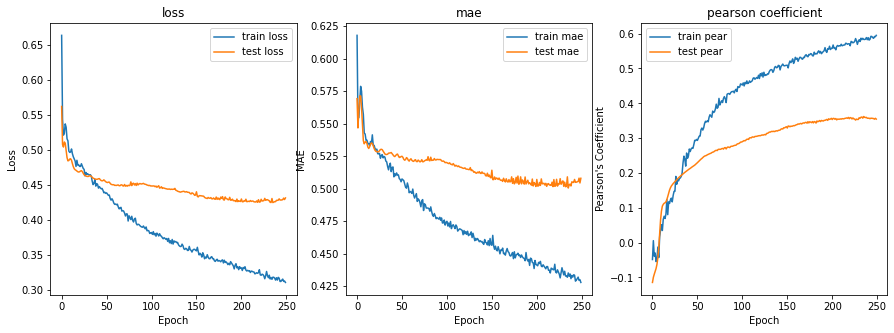

In [ ]:
import matplotlib.pyplot as plt

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.plot(all_train_loss, label="train loss")
ax1.plot(all_test_loss, label="test loss")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.legend(loc="best")
ax1.set_title("loss")

ax2.plot(all_train_mae, label="train mae")
ax2.plot(all_test_mae, label="test mae")
ax2.set_title("mae")
ax2.set_ylabel("MAE")
ax2.set_xlabel("Epoch")
ax2.legend(loc="best")

ax3.plot(all_train_pear, label="train pear")
ax3.plot(all_test_pear, label="test pear")
ax3.set_title("pearson coefficient")
ax3.legend(loc="best")
ax3.set_ylabel("Pearson's Coefficient")
ax3.set_xlabel("Epoch")

# plt.show()

# training result without neutral labels

In [ ]:
# Instantiate model
model = RegressionModelNCE(D_m_text, D_m_audio, D_m_video, D_m_context, D_g, D_p, D_e, D_h, dropout_rec=args["rec_dropout"], dropout=args["dropout"])

if cuda:
    model.cuda()
loss_function = MaskedMSELoss()

# Get optimizer and relevant dataloaders
optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['l2'])
train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/gdrive/MyDrive/11-777 MMML/multilogue-net/data/moseas_full_no_neutral_regression.pickle', valid=0.0, batch_size=batch_size, num_workers=0)
best_loss, best_label, best_pred, best_mask, best_pear = None, None, None, None, None
all_train_loss, all_test_loss, all_train_mae, all_test_mae, all_train_pear, all_test_pear = [],[],[],[],[],[]

In [ ]:
# Training loop
for e in tqdm(range(n_epochs), desc = 'MOSEAS Regression'):
    train_loss, train_mae, train_pear,_,_,_ = train_or_eval_model(model, loss_function, train_loader, e, optimizer, True)
    test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, loss_function, test_loader, e)
    log_res(train_loss, test_loss, train_mae, test_mae, train_pear, test_pear)

    if best_loss == None or best_loss > test_loss:
        best_loss, best_mae, best_label, best_pred, best_mask, best_pear =\
                test_loss, test_mae, test_label, test_pred, test_mask, test_pear
        print(f"saving checkpoint for epoch {e}")
        model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
        torch.save(model_to_save.state_dict(), f"/content/gdrive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_noneutral_regression/epoch{e}_testloss_{best_loss}_testmae_{best_mae}_testpear_{best_pear}.pth")

print('Test performance..')
print('Loss {} MAE {} r {}'.format(best_loss, round(mean_absolute_error(best_label,best_pred,sample_weight=best_mask),4), best_pear))

MOSEAS Regression:   0%|          | 0/250 [00:00<?, ?it/s]

Train Loss - MOSEAS Regression:  1.3135
Test Loss - MOSEAS Regression:  1.1031
Train MAE - MOSEAS Regression:  1.0531
Test MAE - MOSEAS Regression:  0.9688
Train Pearson - MOSEAS Regression:  0.0321
Test Pearson - MOSEAS Regression:  0.0015
saving checkpoint for epoch 0


MOSEAS Regression:   1%|          | 2/250 [00:11<22:41,  5.49s/it]

Train Loss - MOSEAS Regression:  1.1251
Test Loss - MOSEAS Regression:  0.9351
Train MAE - MOSEAS Regression:  0.9609
Test MAE - MOSEAS Regression:  0.8617
Train Pearson - MOSEAS Regression:  -0.0299
Test Pearson - MOSEAS Regression:  0.035
saving checkpoint for epoch 1


MOSEAS Regression:   1%|          | 3/250 [00:15<20:46,  5.05s/it]

Train Loss - MOSEAS Regression:  0.9764
Test Loss - MOSEAS Regression:  0.831
Train MAE - MOSEAS Regression:  0.8591
Test MAE - MOSEAS Regression:  0.7614
Train Pearson - MOSEAS Regression:  -0.0143
Test Pearson - MOSEAS Regression:  0.0443
saving checkpoint for epoch 2


MOSEAS Regression:   2%|▏         | 4/250 [00:20<21:01,  5.13s/it]

Train Loss - MOSEAS Regression:  0.8929
Test Loss - MOSEAS Regression:  0.7808
Train MAE - MOSEAS Regression:  0.7786
Test MAE - MOSEAS Regression:  0.6873
Train Pearson - MOSEAS Regression:  0.0015
Test Pearson - MOSEAS Regression:  0.0487
saving checkpoint for epoch 3


MOSEAS Regression:   2%|▏         | 5/250 [00:25<20:44,  5.08s/it]

Train Loss - MOSEAS Regression:  0.8522
Test Loss - MOSEAS Regression:  0.769
Train MAE - MOSEAS Regression:  0.7221
Test MAE - MOSEAS Regression:  0.6546
Train Pearson - MOSEAS Regression:  0.0161
Test Pearson - MOSEAS Regression:  0.0512
saving checkpoint for epoch 4


MOSEAS Regression:   2%|▏         | 6/250 [00:31<20:53,  5.14s/it]

Train Loss - MOSEAS Regression:  0.8357
Test Loss - MOSEAS Regression:  0.7765
Train MAE - MOSEAS Regression:  0.6873
Test MAE - MOSEAS Regression:  0.6384
Train Pearson - MOSEAS Regression:  0.0431
Test Pearson - MOSEAS Regression:  0.0531


MOSEAS Regression:   3%|▎         | 7/250 [00:35<20:25,  5.04s/it]

Train Loss - MOSEAS Regression:  0.8664
Test Loss - MOSEAS Regression:  0.7867
Train MAE - MOSEAS Regression:  0.6858
Test MAE - MOSEAS Regression:  0.6327
Train Pearson - MOSEAS Regression:  -0.0028
Test Pearson - MOSEAS Regression:  0.0547


MOSEAS Regression:   3%|▎         | 8/250 [00:41<20:27,  5.07s/it]

Train Loss - MOSEAS Regression:  0.8741
Test Loss - MOSEAS Regression:  0.7907
Train MAE - MOSEAS Regression:  0.6768
Test MAE - MOSEAS Regression:  0.6305
Train Pearson - MOSEAS Regression:  -0.0003
Test Pearson - MOSEAS Regression:  0.0563


MOSEAS Regression:   4%|▎         | 9/250 [00:46<20:11,  5.03s/it]

Train Loss - MOSEAS Regression:  0.8822
Test Loss - MOSEAS Regression:  0.7843
Train MAE - MOSEAS Regression:  0.6763
Test MAE - MOSEAS Regression:  0.6268
Train Pearson - MOSEAS Regression:  -0.0083
Test Pearson - MOSEAS Regression:  0.0581


MOSEAS Regression:   4%|▍         | 10/250 [00:50<20:01,  5.01s/it]

Train Loss - MOSEAS Regression:  0.8701
Test Loss - MOSEAS Regression:  0.7723
Train MAE - MOSEAS Regression:  0.6749
Test MAE - MOSEAS Regression:  0.624
Train Pearson - MOSEAS Regression:  -0.0052
Test Pearson - MOSEAS Regression:  0.0601


MOSEAS Regression:   4%|▍         | 11/250 [00:55<19:52,  4.99s/it]

Train Loss - MOSEAS Regression:  0.8575
Test Loss - MOSEAS Regression:  0.7602
Train MAE - MOSEAS Regression:  0.6683
Test MAE - MOSEAS Regression:  0.6254
Train Pearson - MOSEAS Regression:  0.0023
Test Pearson - MOSEAS Regression:  0.0626
saving checkpoint for epoch 10


MOSEAS Regression:   5%|▍         | 12/250 [01:00<19:12,  4.84s/it]

Train Loss - MOSEAS Regression:  0.8354
Test Loss - MOSEAS Regression:  0.7513
Train MAE - MOSEAS Regression:  0.6682
Test MAE - MOSEAS Regression:  0.6293
Train Pearson - MOSEAS Regression:  0.02
Test Pearson - MOSEAS Regression:  0.0656
saving checkpoint for epoch 11


MOSEAS Regression:   5%|▌         | 13/250 [01:05<19:21,  4.90s/it]

Train Loss - MOSEAS Regression:  0.8237
Test Loss - MOSEAS Regression:  0.7465
Train MAE - MOSEAS Regression:  0.6679
Test MAE - MOSEAS Regression:  0.6341
Train Pearson - MOSEAS Regression:  0.0252
Test Pearson - MOSEAS Regression:  0.0692
saving checkpoint for epoch 12


MOSEAS Regression:   6%|▌         | 14/250 [01:10<19:12,  4.88s/it]

Train Loss - MOSEAS Regression:  0.8114
Test Loss - MOSEAS Regression:  0.7453
Train MAE - MOSEAS Regression:  0.671
Test MAE - MOSEAS Regression:  0.6383
Train Pearson - MOSEAS Regression:  0.0525
Test Pearson - MOSEAS Regression:  0.0733
saving checkpoint for epoch 13


MOSEAS Regression:   6%|▌         | 15/250 [01:15<19:29,  4.98s/it]

Train Loss - MOSEAS Regression:  0.8062
Test Loss - MOSEAS Regression:  0.7461
Train MAE - MOSEAS Regression:  0.6774
Test MAE - MOSEAS Regression:  0.642
Train Pearson - MOSEAS Regression:  0.0587
Test Pearson - MOSEAS Regression:  0.0779


MOSEAS Regression:   6%|▋         | 16/250 [01:20<19:25,  4.98s/it]

Train Loss - MOSEAS Regression:  0.8093
Test Loss - MOSEAS Regression:  0.748
Train MAE - MOSEAS Regression:  0.6835
Test MAE - MOSEAS Regression:  0.6471
Train Pearson - MOSEAS Regression:  0.0536
Test Pearson - MOSEAS Regression:  0.0831


MOSEAS Regression:   7%|▋         | 17/250 [01:25<19:16,  4.96s/it]

Train Loss - MOSEAS Regression:  0.8139
Test Loss - MOSEAS Regression:  0.7488
Train MAE - MOSEAS Regression:  0.6927
Test MAE - MOSEAS Regression:  0.6515
Train Pearson - MOSEAS Regression:  0.0443
Test Pearson - MOSEAS Regression:  0.0882


MOSEAS Regression:   7%|▋         | 18/250 [01:30<19:09,  4.95s/it]

Train Loss - MOSEAS Regression:  0.8181
Test Loss - MOSEAS Regression:  0.7484
Train MAE - MOSEAS Regression:  0.6938
Test MAE - MOSEAS Regression:  0.6531
Train Pearson - MOSEAS Regression:  0.0259
Test Pearson - MOSEAS Regression:  0.0931


MOSEAS Regression:   8%|▊         | 19/250 [01:34<18:33,  4.82s/it]

Train Loss - MOSEAS Regression:  0.8094
Test Loss - MOSEAS Regression:  0.7464
Train MAE - MOSEAS Regression:  0.6917
Test MAE - MOSEAS Regression:  0.6501
Train Pearson - MOSEAS Regression:  0.0574
Test Pearson - MOSEAS Regression:  0.0976


MOSEAS Regression:   8%|▊         | 20/250 [01:39<18:32,  4.84s/it]

Train Loss - MOSEAS Regression:  0.8027
Test Loss - MOSEAS Regression:  0.7426
Train MAE - MOSEAS Regression:  0.689
Test MAE - MOSEAS Regression:  0.6424
Train Pearson - MOSEAS Regression:  0.0798
Test Pearson - MOSEAS Regression:  0.1013
saving checkpoint for epoch 19


MOSEAS Regression:   8%|▊         | 21/250 [01:44<18:04,  4.74s/it]

Train Loss - MOSEAS Regression:  0.801
Test Loss - MOSEAS Regression:  0.7392
Train MAE - MOSEAS Regression:  0.6799
Test MAE - MOSEAS Regression:  0.6358
Train Pearson - MOSEAS Regression:  0.0691
Test Pearson - MOSEAS Regression:  0.105
saving checkpoint for epoch 20


MOSEAS Regression:   9%|▉         | 22/250 [01:49<18:10,  4.78s/it]

Train Loss - MOSEAS Regression:  0.8002
Test Loss - MOSEAS Regression:  0.7358
Train MAE - MOSEAS Regression:  0.6733
Test MAE - MOSEAS Regression:  0.6287
Train Pearson - MOSEAS Regression:  0.0659
Test Pearson - MOSEAS Regression:  0.1083
saving checkpoint for epoch 21


MOSEAS Regression:   9%|▉         | 23/250 [01:54<18:19,  4.84s/it]

Train Loss - MOSEAS Regression:  0.7901
Test Loss - MOSEAS Regression:  0.7335
Train MAE - MOSEAS Regression:  0.6629
Test MAE - MOSEAS Regression:  0.6239
Train Pearson - MOSEAS Regression:  0.0929
Test Pearson - MOSEAS Regression:  0.1121
saving checkpoint for epoch 22


MOSEAS Regression:  10%|▉         | 24/250 [01:59<18:23,  4.88s/it]

Train Loss - MOSEAS Regression:  0.7958
Test Loss - MOSEAS Regression:  0.7318
Train MAE - MOSEAS Regression:  0.6636
Test MAE - MOSEAS Regression:  0.6206
Train Pearson - MOSEAS Regression:  0.0683
Test Pearson - MOSEAS Regression:  0.1163
saving checkpoint for epoch 23


MOSEAS Regression:  10%|█         | 25/250 [02:04<18:26,  4.92s/it]

Train Loss - MOSEAS Regression:  0.7923
Test Loss - MOSEAS Regression:  0.7305
Train MAE - MOSEAS Regression:  0.6557
Test MAE - MOSEAS Regression:  0.6173
Train Pearson - MOSEAS Regression:  0.0807
Test Pearson - MOSEAS Regression:  0.1203
saving checkpoint for epoch 24


MOSEAS Regression:  10%|█         | 26/250 [02:08<18:13,  4.88s/it]

Train Loss - MOSEAS Regression:  0.784
Test Loss - MOSEAS Regression:  0.7294
Train MAE - MOSEAS Regression:  0.6531
Test MAE - MOSEAS Regression:  0.6156
Train Pearson - MOSEAS Regression:  0.1065
Test Pearson - MOSEAS Regression:  0.1253
saving checkpoint for epoch 25


MOSEAS Regression:  11%|█         | 27/250 [02:13<18:21,  4.94s/it]

Train Loss - MOSEAS Regression:  0.795
Test Loss - MOSEAS Regression:  0.7284
Train MAE - MOSEAS Regression:  0.6552
Test MAE - MOSEAS Regression:  0.6148
Train Pearson - MOSEAS Regression:  0.069
Test Pearson - MOSEAS Regression:  0.1309
saving checkpoint for epoch 26


MOSEAS Regression:  11%|█         | 28/250 [02:19<18:34,  5.02s/it]

Train Loss - MOSEAS Regression:  0.7816
Test Loss - MOSEAS Regression:  0.7274
Train MAE - MOSEAS Regression:  0.6461
Test MAE - MOSEAS Regression:  0.6146
Train Pearson - MOSEAS Regression:  0.1144
Test Pearson - MOSEAS Regression:  0.1367
saving checkpoint for epoch 27


MOSEAS Regression:  12%|█▏        | 29/250 [02:23<18:05,  4.91s/it]

Train Loss - MOSEAS Regression:  0.7879
Test Loss - MOSEAS Regression:  0.7267
Train MAE - MOSEAS Regression:  0.6499
Test MAE - MOSEAS Regression:  0.6162
Train Pearson - MOSEAS Regression:  0.0946
Test Pearson - MOSEAS Regression:  0.1432
saving checkpoint for epoch 28


MOSEAS Regression:  12%|█▏        | 30/250 [02:28<18:04,  4.93s/it]

Train Loss - MOSEAS Regression:  0.7729
Test Loss - MOSEAS Regression:  0.726
Train MAE - MOSEAS Regression:  0.6448
Test MAE - MOSEAS Regression:  0.6174
Train Pearson - MOSEAS Regression:  0.1459
Test Pearson - MOSEAS Regression:  0.149
saving checkpoint for epoch 29


MOSEAS Regression:  12%|█▏        | 31/250 [02:33<17:39,  4.84s/it]

Train Loss - MOSEAS Regression:  0.7696
Test Loss - MOSEAS Regression:  0.7254
Train MAE - MOSEAS Regression:  0.6429
Test MAE - MOSEAS Regression:  0.6188
Train Pearson - MOSEAS Regression:  0.1576
Test Pearson - MOSEAS Regression:  0.1544
saving checkpoint for epoch 30


MOSEAS Regression:  13%|█▎        | 32/250 [02:38<17:42,  4.87s/it]

Train Loss - MOSEAS Regression:  0.7779
Test Loss - MOSEAS Regression:  0.7247
Train MAE - MOSEAS Regression:  0.6524
Test MAE - MOSEAS Regression:  0.6195
Train Pearson - MOSEAS Regression:  0.1319
Test Pearson - MOSEAS Regression:  0.1594
saving checkpoint for epoch 31


MOSEAS Regression:  13%|█▎        | 33/250 [02:43<17:48,  4.92s/it]

Train Loss - MOSEAS Regression:  0.7746
Test Loss - MOSEAS Regression:  0.7239
Train MAE - MOSEAS Regression:  0.6501
Test MAE - MOSEAS Regression:  0.6195
Train Pearson - MOSEAS Regression:  0.141
Test Pearson - MOSEAS Regression:  0.1639
saving checkpoint for epoch 32


MOSEAS Regression:  14%|█▎        | 34/250 [02:48<17:24,  4.84s/it]

Train Loss - MOSEAS Regression:  0.7648
Test Loss - MOSEAS Regression:  0.7231
Train MAE - MOSEAS Regression:  0.6423
Test MAE - MOSEAS Regression:  0.6197
Train Pearson - MOSEAS Regression:  0.1746
Test Pearson - MOSEAS Regression:  0.1678
saving checkpoint for epoch 33


MOSEAS Regression:  14%|█▍        | 35/250 [02:53<17:43,  4.95s/it]

Train Loss - MOSEAS Regression:  0.7708
Test Loss - MOSEAS Regression:  0.7223
Train MAE - MOSEAS Regression:  0.6481
Test MAE - MOSEAS Regression:  0.6197
Train Pearson - MOSEAS Regression:  0.1553
Test Pearson - MOSEAS Regression:  0.1712
saving checkpoint for epoch 34


MOSEAS Regression:  14%|█▍        | 36/250 [02:58<17:41,  4.96s/it]

Train Loss - MOSEAS Regression:  0.7662
Test Loss - MOSEAS Regression:  0.7214
Train MAE - MOSEAS Regression:  0.646
Test MAE - MOSEAS Regression:  0.6193
Train Pearson - MOSEAS Regression:  0.1712
Test Pearson - MOSEAS Regression:  0.1744
saving checkpoint for epoch 35


MOSEAS Regression:  15%|█▍        | 37/250 [03:03<17:31,  4.94s/it]

Train Loss - MOSEAS Regression:  0.7617
Test Loss - MOSEAS Regression:  0.7205
Train MAE - MOSEAS Regression:  0.6406
Test MAE - MOSEAS Regression:  0.6187
Train Pearson - MOSEAS Regression:  0.1847
Test Pearson - MOSEAS Regression:  0.1775
saving checkpoint for epoch 36


MOSEAS Regression:  15%|█▌        | 38/250 [03:07<17:21,  4.91s/it]

Train Loss - MOSEAS Regression:  0.7674
Test Loss - MOSEAS Regression:  0.7193
Train MAE - MOSEAS Regression:  0.6481
Test MAE - MOSEAS Regression:  0.6173
Train Pearson - MOSEAS Regression:  0.1661
Test Pearson - MOSEAS Regression:  0.1807
saving checkpoint for epoch 37


MOSEAS Regression:  16%|█▌        | 39/250 [03:12<17:03,  4.85s/it]

Train Loss - MOSEAS Regression:  0.7574
Test Loss - MOSEAS Regression:  0.7188
Train MAE - MOSEAS Regression:  0.642
Test MAE - MOSEAS Regression:  0.6183
Train Pearson - MOSEAS Regression:  0.1995
Test Pearson - MOSEAS Regression:  0.183
saving checkpoint for epoch 38


MOSEAS Regression:  16%|█▌        | 40/250 [03:17<17:09,  4.90s/it]

Train Loss - MOSEAS Regression:  0.7579
Test Loss - MOSEAS Regression:  0.7179
Train MAE - MOSEAS Regression:  0.6426
Test MAE - MOSEAS Regression:  0.6179
Train Pearson - MOSEAS Regression:  0.1983
Test Pearson - MOSEAS Regression:  0.1855
saving checkpoint for epoch 39


MOSEAS Regression:  16%|█▋        | 41/250 [03:23<17:29,  5.02s/it]

Train Loss - MOSEAS Regression:  0.7557
Test Loss - MOSEAS Regression:  0.717
Train MAE - MOSEAS Regression:  0.6383
Test MAE - MOSEAS Regression:  0.6175
Train Pearson - MOSEAS Regression:  0.2049
Test Pearson - MOSEAS Regression:  0.1878
saving checkpoint for epoch 40


MOSEAS Regression:  17%|█▋        | 42/250 [03:28<17:41,  5.10s/it]

Train Loss - MOSEAS Regression:  0.753
Test Loss - MOSEAS Regression:  0.7157
Train MAE - MOSEAS Regression:  0.6398
Test MAE - MOSEAS Regression:  0.6155
Train Pearson - MOSEAS Regression:  0.2136
Test Pearson - MOSEAS Regression:  0.1908
saving checkpoint for epoch 41


MOSEAS Regression:  17%|█▋        | 43/250 [03:32<17:02,  4.94s/it]

Train Loss - MOSEAS Regression:  0.7488
Test Loss - MOSEAS Regression:  0.7147
Train MAE - MOSEAS Regression:  0.6361
Test MAE - MOSEAS Regression:  0.6146
Train Pearson - MOSEAS Regression:  0.2242
Test Pearson - MOSEAS Regression:  0.1931
saving checkpoint for epoch 42


MOSEAS Regression:  18%|█▊        | 44/250 [03:37<17:00,  4.95s/it]

Train Loss - MOSEAS Regression:  0.7373
Test Loss - MOSEAS Regression:  0.7139
Train MAE - MOSEAS Regression:  0.6291
Test MAE - MOSEAS Regression:  0.6144
Train Pearson - MOSEAS Regression:  0.2569
Test Pearson - MOSEAS Regression:  0.1953
saving checkpoint for epoch 43


MOSEAS Regression:  18%|█▊        | 45/250 [03:42<16:57,  4.96s/it]

Train Loss - MOSEAS Regression:  0.7404
Test Loss - MOSEAS Regression:  0.7133
Train MAE - MOSEAS Regression:  0.6337
Test MAE - MOSEAS Regression:  0.615
Train Pearson - MOSEAS Regression:  0.2489
Test Pearson - MOSEAS Regression:  0.1968
saving checkpoint for epoch 44


MOSEAS Regression:  18%|█▊        | 46/250 [03:48<17:13,  5.07s/it]

Train Loss - MOSEAS Regression:  0.7356
Test Loss - MOSEAS Regression:  0.7126
Train MAE - MOSEAS Regression:  0.6267
Test MAE - MOSEAS Regression:  0.6155
Train Pearson - MOSEAS Regression:  0.2611
Test Pearson - MOSEAS Regression:  0.1985
saving checkpoint for epoch 45


MOSEAS Regression:  19%|█▉        | 47/250 [03:52<16:36,  4.91s/it]

Train Loss - MOSEAS Regression:  0.7324
Test Loss - MOSEAS Regression:  0.7125
Train MAE - MOSEAS Regression:  0.6255
Test MAE - MOSEAS Regression:  0.6172
Train Pearson - MOSEAS Regression:  0.2707
Test Pearson - MOSEAS Regression:  0.1991
saving checkpoint for epoch 46


MOSEAS Regression:  19%|█▉        | 48/250 [03:57<16:33,  4.92s/it]

Train Loss - MOSEAS Regression:  0.728
Test Loss - MOSEAS Regression:  0.7124
Train MAE - MOSEAS Regression:  0.6308
Test MAE - MOSEAS Regression:  0.6193
Train Pearson - MOSEAS Regression:  0.2821
Test Pearson - MOSEAS Regression:  0.1999
saving checkpoint for epoch 47


MOSEAS Regression:  20%|█▉        | 49/250 [04:02<16:26,  4.91s/it]

Train Loss - MOSEAS Regression:  0.7263
Test Loss - MOSEAS Regression:  0.7112
Train MAE - MOSEAS Regression:  0.6286
Test MAE - MOSEAS Regression:  0.6182
Train Pearson - MOSEAS Regression:  0.2846
Test Pearson - MOSEAS Regression:  0.2028
saving checkpoint for epoch 48


MOSEAS Regression:  20%|██        | 50/250 [04:07<16:20,  4.90s/it]

Train Loss - MOSEAS Regression:  0.7229
Test Loss - MOSEAS Regression:  0.7097
Train MAE - MOSEAS Regression:  0.6235
Test MAE - MOSEAS Regression:  0.6158
Train Pearson - MOSEAS Regression:  0.2918
Test Pearson - MOSEAS Regression:  0.2064
saving checkpoint for epoch 49


MOSEAS Regression:  20%|██        | 51/250 [04:12<16:21,  4.93s/it]

Train Loss - MOSEAS Regression:  0.7219
Test Loss - MOSEAS Regression:  0.7083
Train MAE - MOSEAS Regression:  0.6267
Test MAE - MOSEAS Regression:  0.6134
Train Pearson - MOSEAS Regression:  0.2935
Test Pearson - MOSEAS Regression:  0.2102
saving checkpoint for epoch 50


MOSEAS Regression:  21%|██        | 52/250 [04:17<16:36,  5.03s/it]

Train Loss - MOSEAS Regression:  0.7125
Test Loss - MOSEAS Regression:  0.7071
Train MAE - MOSEAS Regression:  0.618
Test MAE - MOSEAS Regression:  0.6112
Train Pearson - MOSEAS Regression:  0.3151
Test Pearson - MOSEAS Regression:  0.2136
saving checkpoint for epoch 51


MOSEAS Regression:  21%|██        | 53/250 [04:22<16:37,  5.06s/it]

Train Loss - MOSEAS Regression:  0.7162
Test Loss - MOSEAS Regression:  0.7069
Train MAE - MOSEAS Regression:  0.6196
Test MAE - MOSEAS Regression:  0.6131
Train Pearson - MOSEAS Regression:  0.3037
Test Pearson - MOSEAS Regression:  0.2143
saving checkpoint for epoch 52


MOSEAS Regression:  22%|██▏       | 54/250 [04:28<16:39,  5.10s/it]

Train Loss - MOSEAS Regression:  0.7211
Test Loss - MOSEAS Regression:  0.7079
Train MAE - MOSEAS Regression:  0.6225
Test MAE - MOSEAS Regression:  0.6181
Train Pearson - MOSEAS Regression:  0.2925
Test Pearson - MOSEAS Regression:  0.2129


MOSEAS Regression:  22%|██▏       | 55/250 [04:33<16:41,  5.13s/it]

Train Loss - MOSEAS Regression:  0.716
Test Loss - MOSEAS Regression:  0.7082
Train MAE - MOSEAS Regression:  0.625
Test MAE - MOSEAS Regression:  0.6205
Train Pearson - MOSEAS Regression:  0.3042
Test Pearson - MOSEAS Regression:  0.2134


MOSEAS Regression:  22%|██▏       | 56/250 [04:37<16:08,  4.99s/it]

Train Loss - MOSEAS Regression:  0.7052
Test Loss - MOSEAS Regression:  0.7093
Train MAE - MOSEAS Regression:  0.623
Test MAE - MOSEAS Regression:  0.624
Train Pearson - MOSEAS Regression:  0.3271
Test Pearson - MOSEAS Regression:  0.2128


MOSEAS Regression:  23%|██▎       | 57/250 [04:42<15:58,  4.97s/it]

Train Loss - MOSEAS Regression:  0.6992
Test Loss - MOSEAS Regression:  0.7074
Train MAE - MOSEAS Regression:  0.6181
Test MAE - MOSEAS Regression:  0.6213
Train Pearson - MOSEAS Regression:  0.3392
Test Pearson - MOSEAS Regression:  0.217


MOSEAS Regression:  23%|██▎       | 58/250 [04:47<15:52,  4.96s/it]

Train Loss - MOSEAS Regression:  0.6996
Test Loss - MOSEAS Regression:  0.7061
Train MAE - MOSEAS Regression:  0.6203
Test MAE - MOSEAS Regression:  0.6199
Train Pearson - MOSEAS Regression:  0.3389
Test Pearson - MOSEAS Regression:  0.2205
saving checkpoint for epoch 57


MOSEAS Regression:  24%|██▎       | 59/250 [04:52<15:35,  4.90s/it]

Train Loss - MOSEAS Regression:  0.6956
Test Loss - MOSEAS Regression:  0.7038
Train MAE - MOSEAS Regression:  0.615
Test MAE - MOSEAS Regression:  0.6156
Train Pearson - MOSEAS Regression:  0.3451
Test Pearson - MOSEAS Regression:  0.2262
saving checkpoint for epoch 58


MOSEAS Regression:  24%|██▍       | 60/250 [04:57<15:33,  4.92s/it]

Train Loss - MOSEAS Regression:  0.699
Test Loss - MOSEAS Regression:  0.7026
Train MAE - MOSEAS Regression:  0.6091
Test MAE - MOSEAS Regression:  0.613
Train Pearson - MOSEAS Regression:  0.3384
Test Pearson - MOSEAS Regression:  0.2304
saving checkpoint for epoch 59


MOSEAS Regression:  24%|██▍       | 61/250 [05:02<15:37,  4.96s/it]

Train Loss - MOSEAS Regression:  0.697
Test Loss - MOSEAS Regression:  0.7023
Train MAE - MOSEAS Regression:  0.6096
Test MAE - MOSEAS Regression:  0.6147
Train Pearson - MOSEAS Regression:  0.3416
Test Pearson - MOSEAS Regression:  0.2317
saving checkpoint for epoch 60


MOSEAS Regression:  25%|██▍       | 62/250 [05:07<15:30,  4.95s/it]

Train Loss - MOSEAS Regression:  0.6897
Test Loss - MOSEAS Regression:  0.703
Train MAE - MOSEAS Regression:  0.6097
Test MAE - MOSEAS Regression:  0.6197
Train Pearson - MOSEAS Regression:  0.3561
Test Pearson - MOSEAS Regression:  0.2309


MOSEAS Regression:  25%|██▌       | 63/250 [05:12<15:22,  4.93s/it]

Train Loss - MOSEAS Regression:  0.6935
Test Loss - MOSEAS Regression:  0.7033
Train MAE - MOSEAS Regression:  0.6156
Test MAE - MOSEAS Regression:  0.6221
Train Pearson - MOSEAS Regression:  0.3474
Test Pearson - MOSEAS Regression:  0.2317


MOSEAS Regression:  26%|██▌       | 64/250 [05:17<15:30,  5.00s/it]

Train Loss - MOSEAS Regression:  0.6873
Test Loss - MOSEAS Regression:  0.7025
Train MAE - MOSEAS Regression:  0.6137
Test MAE - MOSEAS Regression:  0.622
Train Pearson - MOSEAS Regression:  0.3596
Test Pearson - MOSEAS Regression:  0.2344


MOSEAS Regression:  26%|██▌       | 65/250 [05:22<15:24,  5.00s/it]

Train Loss - MOSEAS Regression:  0.6806
Test Loss - MOSEAS Regression:  0.6997
Train MAE - MOSEAS Regression:  0.6076
Test MAE - MOSEAS Regression:  0.6172
Train Pearson - MOSEAS Regression:  0.3714
Test Pearson - MOSEAS Regression:  0.2408
saving checkpoint for epoch 64


MOSEAS Regression:  26%|██▋       | 66/250 [05:27<15:35,  5.08s/it]

Train Loss - MOSEAS Regression:  0.685
Test Loss - MOSEAS Regression:  0.6978
Train MAE - MOSEAS Regression:  0.6103
Test MAE - MOSEAS Regression:  0.615
Train Pearson - MOSEAS Regression:  0.3632
Test Pearson - MOSEAS Regression:  0.2459
saving checkpoint for epoch 65


MOSEAS Regression:  27%|██▋       | 67/250 [05:33<15:41,  5.15s/it]

Train Loss - MOSEAS Regression:  0.6772
Test Loss - MOSEAS Regression:  0.6973
Train MAE - MOSEAS Regression:  0.6025
Test MAE - MOSEAS Regression:  0.6164
Train Pearson - MOSEAS Regression:  0.3773
Test Pearson - MOSEAS Regression:  0.2478
saving checkpoint for epoch 66


MOSEAS Regression:  27%|██▋       | 68/250 [05:38<15:40,  5.17s/it]

Train Loss - MOSEAS Regression:  0.6765
Test Loss - MOSEAS Regression:  0.6972
Train MAE - MOSEAS Regression:  0.6064
Test MAE - MOSEAS Regression:  0.619
Train Pearson - MOSEAS Regression:  0.3783
Test Pearson - MOSEAS Regression:  0.2488
saving checkpoint for epoch 67


MOSEAS Regression:  28%|██▊       | 69/250 [05:43<15:17,  5.07s/it]

Train Loss - MOSEAS Regression:  0.6707
Test Loss - MOSEAS Regression:  0.696
Train MAE - MOSEAS Regression:  0.6038
Test MAE - MOSEAS Regression:  0.6181
Train Pearson - MOSEAS Regression:  0.3884
Test Pearson - MOSEAS Regression:  0.2524
saving checkpoint for epoch 68


MOSEAS Regression:  28%|██▊       | 70/250 [05:47<15:01,  5.01s/it]

Train Loss - MOSEAS Regression:  0.668
Test Loss - MOSEAS Regression:  0.6958
Train MAE - MOSEAS Regression:  0.6022
Test MAE - MOSEAS Regression:  0.6209
Train Pearson - MOSEAS Regression:  0.3927
Test Pearson - MOSEAS Regression:  0.2539
saving checkpoint for epoch 69


MOSEAS Regression:  28%|██▊       | 71/250 [05:52<14:48,  4.97s/it]

Train Loss - MOSEAS Regression:  0.6638
Test Loss - MOSEAS Regression:  0.6933
Train MAE - MOSEAS Regression:  0.6023
Test MAE - MOSEAS Regression:  0.6157
Train Pearson - MOSEAS Regression:  0.4003
Test Pearson - MOSEAS Regression:  0.2598
saving checkpoint for epoch 70


MOSEAS Regression:  29%|██▉       | 72/250 [05:57<14:50,  5.00s/it]

Train Loss - MOSEAS Regression:  0.6603
Test Loss - MOSEAS Regression:  0.6921
Train MAE - MOSEAS Regression:  0.5966
Test MAE - MOSEAS Regression:  0.61
Train Pearson - MOSEAS Regression:  0.4047
Test Pearson - MOSEAS Regression:  0.2655
saving checkpoint for epoch 71


MOSEAS Regression:  29%|██▉       | 73/250 [06:02<14:26,  4.90s/it]

Train Loss - MOSEAS Regression:  0.6612
Test Loss - MOSEAS Regression:  0.6918
Train MAE - MOSEAS Regression:  0.5956
Test MAE - MOSEAS Regression:  0.6102
Train Pearson - MOSEAS Regression:  0.404
Test Pearson - MOSEAS Regression:  0.2672
saving checkpoint for epoch 72


MOSEAS Regression:  30%|██▉       | 74/250 [06:07<14:26,  4.92s/it]

Train Loss - MOSEAS Regression:  0.662
Test Loss - MOSEAS Regression:  0.6919
Train MAE - MOSEAS Regression:  0.5929
Test MAE - MOSEAS Regression:  0.6161
Train Pearson - MOSEAS Regression:  0.4016
Test Pearson - MOSEAS Regression:  0.2659


MOSEAS Regression:  30%|███       | 75/250 [06:12<14:24,  4.94s/it]

Train Loss - MOSEAS Regression:  0.6616
Test Loss - MOSEAS Regression:  0.6944
Train MAE - MOSEAS Regression:  0.6003
Test MAE - MOSEAS Regression:  0.6244
Train Pearson - MOSEAS Regression:  0.4028
Test Pearson - MOSEAS Regression:  0.2625


MOSEAS Regression:  30%|███       | 76/250 [06:17<14:15,  4.92s/it]

Train Loss - MOSEAS Regression:  0.6454
Test Loss - MOSEAS Regression:  0.6925
Train MAE - MOSEAS Regression:  0.5953
Test MAE - MOSEAS Regression:  0.6208
Train Pearson - MOSEAS Regression:  0.429
Test Pearson - MOSEAS Regression:  0.2666


MOSEAS Regression:  31%|███       | 77/250 [06:22<13:57,  4.84s/it]

Train Loss - MOSEAS Regression:  0.6511
Test Loss - MOSEAS Regression:  0.6907
Train MAE - MOSEAS Regression:  0.5952
Test MAE - MOSEAS Regression:  0.6135
Train Pearson - MOSEAS Regression:  0.4176
Test Pearson - MOSEAS Regression:  0.2727
saving checkpoint for epoch 76


MOSEAS Regression:  31%|███       | 78/250 [06:27<14:12,  4.95s/it]

Train Loss - MOSEAS Regression:  0.6501
Test Loss - MOSEAS Regression:  0.691
Train MAE - MOSEAS Regression:  0.5914
Test MAE - MOSEAS Regression:  0.6168
Train Pearson - MOSEAS Regression:  0.4193
Test Pearson - MOSEAS Regression:  0.2721


MOSEAS Regression:  32%|███▏      | 79/250 [06:32<14:04,  4.94s/it]

Train Loss - MOSEAS Regression:  0.6362
Test Loss - MOSEAS Regression:  0.6917
Train MAE - MOSEAS Regression:  0.5872
Test MAE - MOSEAS Regression:  0.6201
Train Pearson - MOSEAS Regression:  0.4398
Test Pearson - MOSEAS Regression:  0.2712


MOSEAS Regression:  32%|███▏      | 80/250 [06:36<13:19,  4.71s/it]

Train Loss - MOSEAS Regression:  0.644
Test Loss - MOSEAS Regression:  0.6919
Train MAE - MOSEAS Regression:  0.5907
Test MAE - MOSEAS Regression:  0.6209
Train Pearson - MOSEAS Regression:  0.4288
Test Pearson - MOSEAS Regression:  0.2717


MOSEAS Regression:  32%|███▏      | 81/250 [06:41<13:43,  4.87s/it]

Train Loss - MOSEAS Regression:  0.6351
Test Loss - MOSEAS Regression:  0.6911
Train MAE - MOSEAS Regression:  0.5848
Test MAE - MOSEAS Regression:  0.6149
Train Pearson - MOSEAS Regression:  0.4428
Test Pearson - MOSEAS Regression:  0.2755


MOSEAS Regression:  33%|███▎      | 82/250 [06:46<13:46,  4.92s/it]

Train Loss - MOSEAS Regression:  0.6357
Test Loss - MOSEAS Regression:  0.692
Train MAE - MOSEAS Regression:  0.5818
Test MAE - MOSEAS Regression:  0.6171
Train Pearson - MOSEAS Regression:  0.4418
Test Pearson - MOSEAS Regression:  0.2746


MOSEAS Regression:  33%|███▎      | 83/250 [06:51<13:41,  4.92s/it]

Train Loss - MOSEAS Regression:  0.631
Test Loss - MOSEAS Regression:  0.6965
Train MAE - MOSEAS Regression:  0.5853
Test MAE - MOSEAS Regression:  0.6279
Train Pearson - MOSEAS Regression:  0.4489
Test Pearson - MOSEAS Regression:  0.2685


MOSEAS Regression:  34%|███▎      | 84/250 [06:56<13:15,  4.79s/it]

Train Loss - MOSEAS Regression:  0.6263
Test Loss - MOSEAS Regression:  0.6956
Train MAE - MOSEAS Regression:  0.5922
Test MAE - MOSEAS Regression:  0.6242
Train Pearson - MOSEAS Regression:  0.4558
Test Pearson - MOSEAS Regression:  0.2705


MOSEAS Regression:  34%|███▍      | 85/250 [07:00<13:15,  4.82s/it]

Train Loss - MOSEAS Regression:  0.6292
Test Loss - MOSEAS Regression:  0.6954
Train MAE - MOSEAS Regression:  0.585
Test MAE - MOSEAS Regression:  0.62
Train Pearson - MOSEAS Regression:  0.4498
Test Pearson - MOSEAS Regression:  0.2725


MOSEAS Regression:  34%|███▍      | 86/250 [07:05<13:19,  4.88s/it]

Train Loss - MOSEAS Regression:  0.6287
Test Loss - MOSEAS Regression:  0.6969
Train MAE - MOSEAS Regression:  0.585
Test MAE - MOSEAS Regression:  0.6204
Train Pearson - MOSEAS Regression:  0.4503
Test Pearson - MOSEAS Regression:  0.2716


MOSEAS Regression:  35%|███▍      | 87/250 [07:10<13:00,  4.79s/it]

Train Loss - MOSEAS Regression:  0.6226
Test Loss - MOSEAS Regression:  0.6981
Train MAE - MOSEAS Regression:  0.5792
Test MAE - MOSEAS Regression:  0.6189
Train Pearson - MOSEAS Regression:  0.4587
Test Pearson - MOSEAS Regression:  0.2718


MOSEAS Regression:  35%|███▌      | 88/250 [07:15<12:51,  4.76s/it]

Train Loss - MOSEAS Regression:  0.6259
Test Loss - MOSEAS Regression:  0.7019
Train MAE - MOSEAS Regression:  0.5803
Test MAE - MOSEAS Regression:  0.6272
Train Pearson - MOSEAS Regression:  0.4542
Test Pearson - MOSEAS Regression:  0.2669


MOSEAS Regression:  36%|███▌      | 89/250 [07:19<12:33,  4.68s/it]

Train Loss - MOSEAS Regression:  0.6199
Test Loss - MOSEAS Regression:  0.7019
Train MAE - MOSEAS Regression:  0.5805
Test MAE - MOSEAS Regression:  0.6243
Train Pearson - MOSEAS Regression:  0.4627
Test Pearson - MOSEAS Regression:  0.2683


MOSEAS Regression:  36%|███▌      | 90/250 [07:24<12:40,  4.75s/it]

Train Loss - MOSEAS Regression:  0.6274
Test Loss - MOSEAS Regression:  0.7015
Train MAE - MOSEAS Regression:  0.5841
Test MAE - MOSEAS Regression:  0.6193
Train Pearson - MOSEAS Regression:  0.4518
Test Pearson - MOSEAS Regression:  0.2712


MOSEAS Regression:  36%|███▋      | 91/250 [07:29<12:45,  4.82s/it]

Train Loss - MOSEAS Regression:  0.6143
Test Loss - MOSEAS Regression:  0.7023
Train MAE - MOSEAS Regression:  0.5769
Test MAE - MOSEAS Regression:  0.6186
Train Pearson - MOSEAS Regression:  0.4703
Test Pearson - MOSEAS Regression:  0.2716


MOSEAS Regression:  37%|███▋      | 92/250 [07:34<12:49,  4.87s/it]

Train Loss - MOSEAS Regression:  0.6145
Test Loss - MOSEAS Regression:  0.705
Train MAE - MOSEAS Regression:  0.5762
Test MAE - MOSEAS Regression:  0.6269
Train Pearson - MOSEAS Regression:  0.4703
Test Pearson - MOSEAS Regression:  0.268


MOSEAS Regression:  37%|███▋      | 93/250 [07:39<12:49,  4.90s/it]

Train Loss - MOSEAS Regression:  0.61
Test Loss - MOSEAS Regression:  0.7045
Train MAE - MOSEAS Regression:  0.5767
Test MAE - MOSEAS Regression:  0.6242
Train Pearson - MOSEAS Regression:  0.4769
Test Pearson - MOSEAS Regression:  0.2702


MOSEAS Regression:  38%|███▊      | 94/250 [07:44<12:56,  4.98s/it]

Train Loss - MOSEAS Regression:  0.612
Test Loss - MOSEAS Regression:  0.7044
Train MAE - MOSEAS Regression:  0.579
Test MAE - MOSEAS Regression:  0.6196
Train Pearson - MOSEAS Regression:  0.4738
Test Pearson - MOSEAS Regression:  0.2729


MOSEAS Regression:  38%|███▊      | 95/250 [07:49<12:59,  5.03s/it]

Train Loss - MOSEAS Regression:  0.6049
Test Loss - MOSEAS Regression:  0.7063
Train MAE - MOSEAS Regression:  0.575
Test MAE - MOSEAS Regression:  0.6244
Train Pearson - MOSEAS Regression:  0.4834
Test Pearson - MOSEAS Regression:  0.2714


MOSEAS Regression:  38%|███▊      | 96/250 [07:55<13:00,  5.07s/it]

Train Loss - MOSEAS Regression:  0.6076
Test Loss - MOSEAS Regression:  0.7105
Train MAE - MOSEAS Regression:  0.5777
Test MAE - MOSEAS Regression:  0.6319
Train Pearson - MOSEAS Regression:  0.4799
Test Pearson - MOSEAS Regression:  0.2683


MOSEAS Regression:  39%|███▉      | 97/250 [07:59<12:43,  4.99s/it]

Train Loss - MOSEAS Regression:  0.6031
Test Loss - MOSEAS Regression:  0.7069
Train MAE - MOSEAS Regression:  0.5795
Test MAE - MOSEAS Regression:  0.621
Train Pearson - MOSEAS Regression:  0.4866
Test Pearson - MOSEAS Regression:  0.2745


MOSEAS Regression:  39%|███▉      | 98/250 [08:04<12:37,  4.98s/it]

Train Loss - MOSEAS Regression:  0.6007
Test Loss - MOSEAS Regression:  0.7077
Train MAE - MOSEAS Regression:  0.5682
Test MAE - MOSEAS Regression:  0.6215
Train Pearson - MOSEAS Regression:  0.4892
Test Pearson - MOSEAS Regression:  0.2749


MOSEAS Regression:  40%|███▉      | 99/250 [08:09<12:10,  4.84s/it]

Train Loss - MOSEAS Regression:  0.5912
Test Loss - MOSEAS Regression:  0.7185
Train MAE - MOSEAS Regression:  0.5674
Test MAE - MOSEAS Regression:  0.6402
Train Pearson - MOSEAS Regression:  0.5007
Test Pearson - MOSEAS Regression:  0.2658


MOSEAS Regression:  40%|████      | 100/250 [08:14<12:11,  4.88s/it]

Train Loss - MOSEAS Regression:  0.6015
Test Loss - MOSEAS Regression:  0.7093
Train MAE - MOSEAS Regression:  0.5818
Test MAE - MOSEAS Regression:  0.6251
Train Pearson - MOSEAS Regression:  0.4918
Test Pearson - MOSEAS Regression:  0.2752


MOSEAS Regression:  40%|████      | 101/250 [08:18<11:48,  4.76s/it]

Train Loss - MOSEAS Regression:  0.6
Test Loss - MOSEAS Regression:  0.709
Train MAE - MOSEAS Regression:  0.5729
Test MAE - MOSEAS Regression:  0.6131
Train Pearson - MOSEAS Regression:  0.4893
Test Pearson - MOSEAS Regression:  0.2827


MOSEAS Regression:  41%|████      | 102/250 [08:23<11:53,  4.82s/it]

Train Loss - MOSEAS Regression:  0.6024
Test Loss - MOSEAS Regression:  0.7085
Train MAE - MOSEAS Regression:  0.5705
Test MAE - MOSEAS Regression:  0.625
Train Pearson - MOSEAS Regression:  0.4877
Test Pearson - MOSEAS Regression:  0.2785


MOSEAS Regression:  41%|████      | 103/250 [08:28<11:49,  4.83s/it]

Train Loss - MOSEAS Regression:  0.5981
Test Loss - MOSEAS Regression:  0.7126
Train MAE - MOSEAS Regression:  0.572
Test MAE - MOSEAS Regression:  0.6336
Train Pearson - MOSEAS Regression:  0.4913
Test Pearson - MOSEAS Regression:  0.2758


MOSEAS Regression:  42%|████▏     | 104/250 [08:33<11:46,  4.84s/it]

Train Loss - MOSEAS Regression:  0.5923
Test Loss - MOSEAS Regression:  0.7066
Train MAE - MOSEAS Regression:  0.5724
Test MAE - MOSEAS Regression:  0.6218
Train Pearson - MOSEAS Regression:  0.5003
Test Pearson - MOSEAS Regression:  0.2832


MOSEAS Regression:  42%|████▏     | 105/250 [08:38<11:51,  4.91s/it]

Train Loss - MOSEAS Regression:  0.5852
Test Loss - MOSEAS Regression:  0.706
Train MAE - MOSEAS Regression:  0.5666
Test MAE - MOSEAS Regression:  0.6203
Train Pearson - MOSEAS Regression:  0.5084
Test Pearson - MOSEAS Regression:  0.2855


MOSEAS Regression:  42%|████▏     | 106/250 [08:43<11:46,  4.91s/it]

Train Loss - MOSEAS Regression:  0.5832
Test Loss - MOSEAS Regression:  0.7091
Train MAE - MOSEAS Regression:  0.5625
Test MAE - MOSEAS Regression:  0.6286
Train Pearson - MOSEAS Regression:  0.511
Test Pearson - MOSEAS Regression:  0.2826


MOSEAS Regression:  43%|████▎     | 107/250 [08:48<11:30,  4.83s/it]

Train Loss - MOSEAS Regression:  0.5879
Test Loss - MOSEAS Regression:  0.7092
Train MAE - MOSEAS Regression:  0.5713
Test MAE - MOSEAS Regression:  0.6305
Train Pearson - MOSEAS Regression:  0.5051
Test Pearson - MOSEAS Regression:  0.2837


MOSEAS Regression:  43%|████▎     | 108/250 [08:52<11:20,  4.79s/it]

Train Loss - MOSEAS Regression:  0.5808
Test Loss - MOSEAS Regression:  0.7034
Train MAE - MOSEAS Regression:  0.5616
Test MAE - MOSEAS Regression:  0.6177
Train Pearson - MOSEAS Regression:  0.5133
Test Pearson - MOSEAS Regression:  0.2924


MOSEAS Regression:  44%|████▎     | 109/250 [08:57<11:32,  4.91s/it]

Train Loss - MOSEAS Regression:  0.5899
Test Loss - MOSEAS Regression:  0.7031
Train MAE - MOSEAS Regression:  0.564
Test MAE - MOSEAS Regression:  0.6228
Train Pearson - MOSEAS Regression:  0.5033
Test Pearson - MOSEAS Regression:  0.292


MOSEAS Regression:  44%|████▍     | 110/250 [09:03<11:36,  4.97s/it]

Train Loss - MOSEAS Regression:  0.5856
Test Loss - MOSEAS Regression:  0.7068
Train MAE - MOSEAS Regression:  0.5654
Test MAE - MOSEAS Regression:  0.6322
Train Pearson - MOSEAS Regression:  0.5071
Test Pearson - MOSEAS Regression:  0.2897


MOSEAS Regression:  44%|████▍     | 111/250 [09:07<11:13,  4.84s/it]

Train Loss - MOSEAS Regression:  0.5839
Test Loss - MOSEAS Regression:  0.7002
Train MAE - MOSEAS Regression:  0.5699
Test MAE - MOSEAS Regression:  0.6228
Train Pearson - MOSEAS Regression:  0.511
Test Pearson - MOSEAS Regression:  0.2969


MOSEAS Regression:  45%|████▍     | 112/250 [09:12<11:20,  4.93s/it]

Train Loss - MOSEAS Regression:  0.5792
Test Loss - MOSEAS Regression:  0.6982
Train MAE - MOSEAS Regression:  0.5638
Test MAE - MOSEAS Regression:  0.6187
Train Pearson - MOSEAS Regression:  0.5164
Test Pearson - MOSEAS Regression:  0.3008


MOSEAS Regression:  45%|████▌     | 113/250 [09:17<11:18,  4.95s/it]

Train Loss - MOSEAS Regression:  0.5753
Test Loss - MOSEAS Regression:  0.7011
Train MAE - MOSEAS Regression:  0.5619
Test MAE - MOSEAS Regression:  0.6258
Train Pearson - MOSEAS Regression:  0.5211
Test Pearson - MOSEAS Regression:  0.2988


MOSEAS Regression:  46%|████▌     | 114/250 [09:22<11:14,  4.96s/it]

Train Loss - MOSEAS Regression:  0.5793
Test Loss - MOSEAS Regression:  0.7013
Train MAE - MOSEAS Regression:  0.569
Test MAE - MOSEAS Regression:  0.6256
Train Pearson - MOSEAS Regression:  0.5155
Test Pearson - MOSEAS Regression:  0.3


MOSEAS Regression:  46%|████▌     | 115/250 [09:27<11:10,  4.96s/it]

Train Loss - MOSEAS Regression:  0.5737
Test Loss - MOSEAS Regression:  0.6999
Train MAE - MOSEAS Regression:  0.564
Test MAE - MOSEAS Regression:  0.6206
Train Pearson - MOSEAS Regression:  0.5223
Test Pearson - MOSEAS Regression:  0.3035


MOSEAS Regression:  46%|████▋     | 116/250 [09:32<10:58,  4.91s/it]

Train Loss - MOSEAS Regression:  0.5792
Test Loss - MOSEAS Regression:  0.7018
Train MAE - MOSEAS Regression:  0.5598
Test MAE - MOSEAS Regression:  0.6251
Train Pearson - MOSEAS Regression:  0.5154
Test Pearson - MOSEAS Regression:  0.3027


MOSEAS Regression:  47%|████▋     | 117/250 [09:37<10:55,  4.93s/it]

Train Loss - MOSEAS Regression:  0.5749
Test Loss - MOSEAS Regression:  0.7034
Train MAE - MOSEAS Regression:  0.5653
Test MAE - MOSEAS Regression:  0.6288
Train Pearson - MOSEAS Regression:  0.5206
Test Pearson - MOSEAS Regression:  0.3025


MOSEAS Regression:  47%|████▋     | 118/250 [09:42<10:59,  5.00s/it]

Train Loss - MOSEAS Regression:  0.5698
Test Loss - MOSEAS Regression:  0.6994
Train MAE - MOSEAS Regression:  0.5594
Test MAE - MOSEAS Regression:  0.6221
Train Pearson - MOSEAS Regression:  0.5266
Test Pearson - MOSEAS Regression:  0.3075


MOSEAS Regression:  48%|████▊     | 119/250 [09:47<10:52,  4.98s/it]

Train Loss - MOSEAS Regression:  0.5708
Test Loss - MOSEAS Regression:  0.6975
Train MAE - MOSEAS Regression:  0.5608
Test MAE - MOSEAS Regression:  0.6189
Train Pearson - MOSEAS Regression:  0.5252
Test Pearson - MOSEAS Regression:  0.3106


MOSEAS Regression:  48%|████▊     | 120/250 [09:52<10:47,  4.98s/it]

Train Loss - MOSEAS Regression:  0.5713
Test Loss - MOSEAS Regression:  0.7003
Train MAE - MOSEAS Regression:  0.56
Test MAE - MOSEAS Regression:  0.6258
Train Pearson - MOSEAS Regression:  0.525
Test Pearson - MOSEAS Regression:  0.3078


MOSEAS Regression:  48%|████▊     | 121/250 [09:57<10:49,  5.03s/it]

Train Loss - MOSEAS Regression:  0.5681
Test Loss - MOSEAS Regression:  0.7003
Train MAE - MOSEAS Regression:  0.5611
Test MAE - MOSEAS Regression:  0.6258
Train Pearson - MOSEAS Regression:  0.5289
Test Pearson - MOSEAS Regression:  0.3087


MOSEAS Regression:  49%|████▉     | 122/250 [10:02<10:38,  4.99s/it]

Train Loss - MOSEAS Regression:  0.5703
Test Loss - MOSEAS Regression:  0.6979
Train MAE - MOSEAS Regression:  0.5641
Test MAE - MOSEAS Regression:  0.6183
Train Pearson - MOSEAS Regression:  0.526
Test Pearson - MOSEAS Regression:  0.3131


MOSEAS Regression:  49%|████▉     | 123/250 [10:07<10:31,  4.97s/it]

Train Loss - MOSEAS Regression:  0.5632
Test Loss - MOSEAS Regression:  0.6994
Train MAE - MOSEAS Regression:  0.5562
Test MAE - MOSEAS Regression:  0.622
Train Pearson - MOSEAS Regression:  0.5348
Test Pearson - MOSEAS Regression:  0.3114


MOSEAS Regression:  50%|████▉     | 124/250 [10:12<10:25,  4.96s/it]

Train Loss - MOSEAS Regression:  0.5599
Test Loss - MOSEAS Regression:  0.7005
Train MAE - MOSEAS Regression:  0.5592
Test MAE - MOSEAS Regression:  0.6239
Train Pearson - MOSEAS Regression:  0.5388
Test Pearson - MOSEAS Regression:  0.3106


MOSEAS Regression:  50%|█████     | 125/250 [10:17<10:05,  4.85s/it]

Train Loss - MOSEAS Regression:  0.5602
Test Loss - MOSEAS Regression:  0.699
Train MAE - MOSEAS Regression:  0.5563
Test MAE - MOSEAS Regression:  0.6213
Train Pearson - MOSEAS Regression:  0.538
Test Pearson - MOSEAS Regression:  0.313


MOSEAS Regression:  50%|█████     | 126/250 [10:21<09:59,  4.84s/it]

Train Loss - MOSEAS Regression:  0.565
Test Loss - MOSEAS Regression:  0.6981
Train MAE - MOSEAS Regression:  0.5565
Test MAE - MOSEAS Regression:  0.6222
Train Pearson - MOSEAS Regression:  0.5323
Test Pearson - MOSEAS Regression:  0.314


MOSEAS Regression:  51%|█████     | 127/250 [10:26<09:48,  4.79s/it]

Train Loss - MOSEAS Regression:  0.5634
Test Loss - MOSEAS Regression:  0.6981
Train MAE - MOSEAS Regression:  0.5589
Test MAE - MOSEAS Regression:  0.6243
Train Pearson - MOSEAS Regression:  0.5342
Test Pearson - MOSEAS Regression:  0.3146


MOSEAS Regression:  51%|█████     | 128/250 [10:31<09:35,  4.71s/it]

Train Loss - MOSEAS Regression:  0.5572
Test Loss - MOSEAS Regression:  0.6993
Train MAE - MOSEAS Regression:  0.555
Test MAE - MOSEAS Regression:  0.6268
Train Pearson - MOSEAS Regression:  0.5414
Test Pearson - MOSEAS Regression:  0.3143


MOSEAS Regression:  52%|█████▏    | 129/250 [10:36<09:44,  4.83s/it]

Train Loss - MOSEAS Regression:  0.5572
Test Loss - MOSEAS Regression:  0.6971
Train MAE - MOSEAS Regression:  0.5543
Test MAE - MOSEAS Regression:  0.6225
Train Pearson - MOSEAS Regression:  0.5425
Test Pearson - MOSEAS Regression:  0.317


MOSEAS Regression:  52%|█████▏    | 130/250 [10:40<09:37,  4.82s/it]

Train Loss - MOSEAS Regression:  0.5524
Test Loss - MOSEAS Regression:  0.6984
Train MAE - MOSEAS Regression:  0.5518
Test MAE - MOSEAS Regression:  0.6238
Train Pearson - MOSEAS Regression:  0.5472
Test Pearson - MOSEAS Regression:  0.3167


MOSEAS Regression:  52%|█████▏    | 131/250 [10:46<09:45,  4.92s/it]

Train Loss - MOSEAS Regression:  0.5473
Test Loss - MOSEAS Regression:  0.7011
Train MAE - MOSEAS Regression:  0.55
Test MAE - MOSEAS Regression:  0.6271
Train Pearson - MOSEAS Regression:  0.5533
Test Pearson - MOSEAS Regression:  0.3152


MOSEAS Regression:  53%|█████▎    | 132/250 [10:50<09:26,  4.80s/it]

Train Loss - MOSEAS Regression:  0.5595
Test Loss - MOSEAS Regression:  0.6979
Train MAE - MOSEAS Regression:  0.5597
Test MAE - MOSEAS Regression:  0.622
Train Pearson - MOSEAS Regression:  0.539
Test Pearson - MOSEAS Regression:  0.3195


MOSEAS Regression:  53%|█████▎    | 133/250 [10:55<09:08,  4.69s/it]

Train Loss - MOSEAS Regression:  0.5501
Test Loss - MOSEAS Regression:  0.6965
Train MAE - MOSEAS Regression:  0.5468
Test MAE - MOSEAS Regression:  0.6211
Train Pearson - MOSEAS Regression:  0.5502
Test Pearson - MOSEAS Regression:  0.3216


MOSEAS Regression:  54%|█████▎    | 134/250 [10:59<09:00,  4.66s/it]

Train Loss - MOSEAS Regression:  0.549
Test Loss - MOSEAS Regression:  0.6975
Train MAE - MOSEAS Regression:  0.5518
Test MAE - MOSEAS Regression:  0.6258
Train Pearson - MOSEAS Regression:  0.5514
Test Pearson - MOSEAS Regression:  0.3208


MOSEAS Regression:  54%|█████▍    | 135/250 [11:04<09:03,  4.73s/it]

Train Loss - MOSEAS Regression:  0.549
Test Loss - MOSEAS Regression:  0.6927
Train MAE - MOSEAS Regression:  0.5524
Test MAE - MOSEAS Regression:  0.6219
Train Pearson - MOSEAS Regression:  0.5516
Test Pearson - MOSEAS Regression:  0.3259


MOSEAS Regression:  54%|█████▍    | 136/250 [11:09<09:14,  4.86s/it]

Train Loss - MOSEAS Regression:  0.5404
Test Loss - MOSEAS Regression:  0.6885
Train MAE - MOSEAS Regression:  0.5481
Test MAE - MOSEAS Regression:  0.6148
Train Pearson - MOSEAS Regression:  0.5611
Test Pearson - MOSEAS Regression:  0.3318
saving checkpoint for epoch 135


MOSEAS Regression:  55%|█████▍    | 137/250 [11:14<09:19,  4.95s/it]

Train Loss - MOSEAS Regression:  0.5511
Test Loss - MOSEAS Regression:  0.6959
Train MAE - MOSEAS Regression:  0.5536
Test MAE - MOSEAS Regression:  0.6296
Train Pearson - MOSEAS Regression:  0.5486
Test Pearson - MOSEAS Regression:  0.3255


MOSEAS Regression:  55%|█████▌    | 138/250 [11:19<09:17,  4.97s/it]

Train Loss - MOSEAS Regression:  0.5474
Test Loss - MOSEAS Regression:  0.6871
Train MAE - MOSEAS Regression:  0.5517
Test MAE - MOSEAS Regression:  0.6151
Train Pearson - MOSEAS Regression:  0.5542
Test Pearson - MOSEAS Regression:  0.3343
saving checkpoint for epoch 137


MOSEAS Regression:  56%|█████▌    | 139/250 [11:24<09:12,  4.98s/it]

Train Loss - MOSEAS Regression:  0.54
Test Loss - MOSEAS Regression:  0.6869
Train MAE - MOSEAS Regression:  0.5408
Test MAE - MOSEAS Regression:  0.6177
Train Pearson - MOSEAS Regression:  0.5623
Test Pearson - MOSEAS Regression:  0.3341
saving checkpoint for epoch 138


MOSEAS Regression:  56%|█████▌    | 140/250 [11:29<08:50,  4.82s/it]

Train Loss - MOSEAS Regression:  0.5465
Test Loss - MOSEAS Regression:  0.6897
Train MAE - MOSEAS Regression:  0.551
Test MAE - MOSEAS Regression:  0.624
Train Pearson - MOSEAS Regression:  0.5538
Test Pearson - MOSEAS Regression:  0.3315


MOSEAS Regression:  56%|█████▋    | 141/250 [11:33<08:38,  4.75s/it]

Train Loss - MOSEAS Regression:  0.5396
Test Loss - MOSEAS Regression:  0.6833
Train MAE - MOSEAS Regression:  0.5454
Test MAE - MOSEAS Regression:  0.6174
Train Pearson - MOSEAS Regression:  0.5622
Test Pearson - MOSEAS Regression:  0.3379
saving checkpoint for epoch 140


MOSEAS Regression:  57%|█████▋    | 142/250 [11:38<08:37,  4.79s/it]

Train Loss - MOSEAS Regression:  0.539
Test Loss - MOSEAS Regression:  0.6813
Train MAE - MOSEAS Regression:  0.5443
Test MAE - MOSEAS Regression:  0.615
Train Pearson - MOSEAS Regression:  0.5624
Test Pearson - MOSEAS Regression:  0.3408
saving checkpoint for epoch 141


MOSEAS Regression:  57%|█████▋    | 143/250 [11:43<08:30,  4.77s/it]

Train Loss - MOSEAS Regression:  0.536
Test Loss - MOSEAS Regression:  0.6867
Train MAE - MOSEAS Regression:  0.5486
Test MAE - MOSEAS Regression:  0.6231
Train Pearson - MOSEAS Regression:  0.5663
Test Pearson - MOSEAS Regression:  0.3358


MOSEAS Regression:  58%|█████▊    | 144/250 [11:48<08:23,  4.75s/it]

Train Loss - MOSEAS Regression:  0.5353
Test Loss - MOSEAS Regression:  0.6817
Train MAE - MOSEAS Regression:  0.5481
Test MAE - MOSEAS Regression:  0.6154
Train Pearson - MOSEAS Regression:  0.5677
Test Pearson - MOSEAS Regression:  0.3417


MOSEAS Regression:  58%|█████▊    | 145/250 [11:53<08:30,  4.86s/it]

Train Loss - MOSEAS Regression:  0.5424
Test Loss - MOSEAS Regression:  0.6823
Train MAE - MOSEAS Regression:  0.5499
Test MAE - MOSEAS Regression:  0.617
Train Pearson - MOSEAS Regression:  0.5603
Test Pearson - MOSEAS Regression:  0.3416


MOSEAS Regression:  58%|█████▊    | 146/250 [11:58<08:24,  4.85s/it]

Train Loss - MOSEAS Regression:  0.5338
Test Loss - MOSEAS Regression:  0.6902
Train MAE - MOSEAS Regression:  0.5469
Test MAE - MOSEAS Regression:  0.6267
Train Pearson - MOSEAS Regression:  0.5686
Test Pearson - MOSEAS Regression:  0.336


MOSEAS Regression:  59%|█████▉    | 147/250 [12:03<08:19,  4.85s/it]

Train Loss - MOSEAS Regression:  0.5346
Test Loss - MOSEAS Regression:  0.6819
Train MAE - MOSEAS Regression:  0.5488
Test MAE - MOSEAS Regression:  0.6127
Train Pearson - MOSEAS Regression:  0.5677
Test Pearson - MOSEAS Regression:  0.345


MOSEAS Regression:  59%|█████▉    | 148/250 [12:07<08:04,  4.75s/it]

Train Loss - MOSEAS Regression:  0.5316
Test Loss - MOSEAS Regression:  0.6851
Train MAE - MOSEAS Regression:  0.5407
Test MAE - MOSEAS Regression:  0.6206
Train Pearson - MOSEAS Regression:  0.5717
Test Pearson - MOSEAS Regression:  0.3408


MOSEAS Regression:  60%|█████▉    | 149/250 [12:12<08:04,  4.79s/it]

Train Loss - MOSEAS Regression:  0.5242
Test Loss - MOSEAS Regression:  0.6852
Train MAE - MOSEAS Regression:  0.5417
Test MAE - MOSEAS Regression:  0.6202
Train Pearson - MOSEAS Regression:  0.5794
Test Pearson - MOSEAS Regression:  0.3412


MOSEAS Regression:  60%|██████    | 150/250 [12:17<08:02,  4.82s/it]

Train Loss - MOSEAS Regression:  0.5245
Test Loss - MOSEAS Regression:  0.6821
Train MAE - MOSEAS Regression:  0.5401
Test MAE - MOSEAS Regression:  0.6148
Train Pearson - MOSEAS Regression:  0.58
Test Pearson - MOSEAS Regression:  0.3462


MOSEAS Regression:  60%|██████    | 151/250 [12:22<07:56,  4.81s/it]

Train Loss - MOSEAS Regression:  0.5208
Test Loss - MOSEAS Regression:  0.6847
Train MAE - MOSEAS Regression:  0.5392
Test MAE - MOSEAS Regression:  0.6215
Train Pearson - MOSEAS Regression:  0.584
Test Pearson - MOSEAS Regression:  0.3437


MOSEAS Regression:  61%|██████    | 152/250 [12:26<07:43,  4.73s/it]

Train Loss - MOSEAS Regression:  0.52
Test Loss - MOSEAS Regression:  0.6837
Train MAE - MOSEAS Regression:  0.5397
Test MAE - MOSEAS Regression:  0.6213
Train Pearson - MOSEAS Regression:  0.5843
Test Pearson - MOSEAS Regression:  0.3456


MOSEAS Regression:  61%|██████    | 153/250 [12:31<07:44,  4.79s/it]

Train Loss - MOSEAS Regression:  0.5197
Test Loss - MOSEAS Regression:  0.6796
Train MAE - MOSEAS Regression:  0.5402
Test MAE - MOSEAS Regression:  0.6166
Train Pearson - MOSEAS Regression:  0.584
Test Pearson - MOSEAS Regression:  0.3509
saving checkpoint for epoch 152


MOSEAS Regression:  62%|██████▏   | 154/250 [12:36<07:49,  4.89s/it]

Train Loss - MOSEAS Regression:  0.5158
Test Loss - MOSEAS Regression:  0.6807
Train MAE - MOSEAS Regression:  0.5389
Test MAE - MOSEAS Regression:  0.6191
Train Pearson - MOSEAS Regression:  0.588
Test Pearson - MOSEAS Regression:  0.3506


MOSEAS Regression:  62%|██████▏   | 155/250 [12:41<07:53,  4.98s/it]

Train Loss - MOSEAS Regression:  0.5231
Test Loss - MOSEAS Regression:  0.6799
Train MAE - MOSEAS Regression:  0.5441
Test MAE - MOSEAS Regression:  0.6189
Train Pearson - MOSEAS Regression:  0.58
Test Pearson - MOSEAS Regression:  0.3518


MOSEAS Regression:  62%|██████▏   | 156/250 [12:46<07:39,  4.89s/it]

Train Loss - MOSEAS Regression:  0.5167
Test Loss - MOSEAS Regression:  0.6781
Train MAE - MOSEAS Regression:  0.5383
Test MAE - MOSEAS Regression:  0.619
Train Pearson - MOSEAS Regression:  0.5872
Test Pearson - MOSEAS Regression:  0.3534
saving checkpoint for epoch 155


MOSEAS Regression:  63%|██████▎   | 157/250 [12:51<07:31,  4.86s/it]

Train Loss - MOSEAS Regression:  0.5127
Test Loss - MOSEAS Regression:  0.6784
Train MAE - MOSEAS Regression:  0.5373
Test MAE - MOSEAS Regression:  0.6209
Train Pearson - MOSEAS Regression:  0.5919
Test Pearson - MOSEAS Regression:  0.3534


MOSEAS Regression:  63%|██████▎   | 158/250 [12:56<07:30,  4.90s/it]

Train Loss - MOSEAS Regression:  0.5177
Test Loss - MOSEAS Regression:  0.6745
Train MAE - MOSEAS Regression:  0.5391
Test MAE - MOSEAS Regression:  0.6093
Train Pearson - MOSEAS Regression:  0.5858
Test Pearson - MOSEAS Regression:  0.3628
saving checkpoint for epoch 157


MOSEAS Regression:  64%|██████▎   | 159/250 [13:00<07:16,  4.80s/it]

Train Loss - MOSEAS Regression:  0.5216
Test Loss - MOSEAS Regression:  0.6807
Train MAE - MOSEAS Regression:  0.5387
Test MAE - MOSEAS Regression:  0.6259
Train Pearson - MOSEAS Regression:  0.5858
Test Pearson - MOSEAS Regression:  0.3529


MOSEAS Regression:  64%|██████▍   | 160/250 [13:05<07:12,  4.81s/it]

Train Loss - MOSEAS Regression:  0.5192
Test Loss - MOSEAS Regression:  0.6694
Train MAE - MOSEAS Regression:  0.5453
Test MAE - MOSEAS Regression:  0.6131
Train Pearson - MOSEAS Regression:  0.5887
Test Pearson - MOSEAS Regression:  0.3619
saving checkpoint for epoch 159


MOSEAS Regression:  64%|██████▍   | 161/250 [13:10<07:12,  4.86s/it]

Train Loss - MOSEAS Regression:  0.5166
Test Loss - MOSEAS Regression:  0.6684
Train MAE - MOSEAS Regression:  0.5382
Test MAE - MOSEAS Regression:  0.6074
Train Pearson - MOSEAS Regression:  0.5875
Test Pearson - MOSEAS Regression:  0.3667
saving checkpoint for epoch 160


MOSEAS Regression:  65%|██████▍   | 162/250 [13:15<07:04,  4.83s/it]

Train Loss - MOSEAS Regression:  0.513
Test Loss - MOSEAS Regression:  0.6828
Train MAE - MOSEAS Regression:  0.5308
Test MAE - MOSEAS Regression:  0.6285
Train Pearson - MOSEAS Regression:  0.5927
Test Pearson - MOSEAS Regression:  0.3527


MOSEAS Regression:  65%|██████▌   | 163/250 [13:19<06:46,  4.67s/it]

Train Loss - MOSEAS Regression:  0.5161
Test Loss - MOSEAS Regression:  0.6701
Train MAE - MOSEAS Regression:  0.5376
Test MAE - MOSEAS Regression:  0.6123
Train Pearson - MOSEAS Regression:  0.5909
Test Pearson - MOSEAS Regression:  0.3627


MOSEAS Regression:  66%|██████▌   | 164/250 [13:24<06:47,  4.73s/it]

Train Loss - MOSEAS Regression:  0.5078
Test Loss - MOSEAS Regression:  0.6699
Train MAE - MOSEAS Regression:  0.5314
Test MAE - MOSEAS Regression:  0.6087
Train Pearson - MOSEAS Regression:  0.6006
Test Pearson - MOSEAS Regression:  0.3675


MOSEAS Regression:  66%|██████▌   | 165/250 [13:29<06:45,  4.77s/it]

Train Loss - MOSEAS Regression:  0.511
Test Loss - MOSEAS Regression:  0.6864
Train MAE - MOSEAS Regression:  0.5347
Test MAE - MOSEAS Regression:  0.6319
Train Pearson - MOSEAS Regression:  0.5946
Test Pearson - MOSEAS Regression:  0.3528


MOSEAS Regression:  66%|██████▋   | 166/250 [13:34<06:43,  4.81s/it]

Train Loss - MOSEAS Regression:  0.5105
Test Loss - MOSEAS Regression:  0.6687
Train MAE - MOSEAS Regression:  0.5396
Test MAE - MOSEAS Regression:  0.6121
Train Pearson - MOSEAS Regression:  0.5981
Test Pearson - MOSEAS Regression:  0.3659


MOSEAS Regression:  67%|██████▋   | 167/250 [13:38<06:31,  4.72s/it]

Train Loss - MOSEAS Regression:  0.5036
Test Loss - MOSEAS Regression:  0.6683
Train MAE - MOSEAS Regression:  0.5296
Test MAE - MOSEAS Regression:  0.6083
Train Pearson - MOSEAS Regression:  0.6027
Test Pearson - MOSEAS Regression:  0.3702
saving checkpoint for epoch 166


MOSEAS Regression:  67%|██████▋   | 168/250 [13:43<06:34,  4.82s/it]

Train Loss - MOSEAS Regression:  0.5054
Test Loss - MOSEAS Regression:  0.677
Train MAE - MOSEAS Regression:  0.5327
Test MAE - MOSEAS Regression:  0.6248
Train Pearson - MOSEAS Regression:  0.6002
Test Pearson - MOSEAS Regression:  0.3622


MOSEAS Regression:  68%|██████▊   | 169/250 [13:49<06:38,  4.92s/it]

Train Loss - MOSEAS Regression:  0.5031
Test Loss - MOSEAS Regression:  0.6699
Train MAE - MOSEAS Regression:  0.5375
Test MAE - MOSEAS Regression:  0.6111
Train Pearson - MOSEAS Regression:  0.6059
Test Pearson - MOSEAS Regression:  0.3691


MOSEAS Regression:  68%|██████▊   | 170/250 [13:53<06:24,  4.81s/it]

Train Loss - MOSEAS Regression:  0.5028
Test Loss - MOSEAS Regression:  0.6723
Train MAE - MOSEAS Regression:  0.5277
Test MAE - MOSEAS Regression:  0.6114
Train Pearson - MOSEAS Regression:  0.6037
Test Pearson - MOSEAS Regression:  0.3694


MOSEAS Regression:  68%|██████▊   | 171/250 [13:58<06:12,  4.71s/it]

Train Loss - MOSEAS Regression:  0.5064
Test Loss - MOSEAS Regression:  0.6836
Train MAE - MOSEAS Regression:  0.5322
Test MAE - MOSEAS Regression:  0.6284
Train Pearson - MOSEAS Regression:  0.5982
Test Pearson - MOSEAS Regression:  0.3593


MOSEAS Regression:  69%|██████▉   | 172/250 [14:02<06:09,  4.73s/it]

Train Loss - MOSEAS Regression:  0.5031
Test Loss - MOSEAS Regression:  0.6737
Train MAE - MOSEAS Regression:  0.5378
Test MAE - MOSEAS Regression:  0.6153
Train Pearson - MOSEAS Regression:  0.6032
Test Pearson - MOSEAS Regression:  0.368


MOSEAS Regression:  69%|██████▉   | 173/250 [14:08<06:13,  4.85s/it]

Train Loss - MOSEAS Regression:  0.4894
Test Loss - MOSEAS Regression:  0.6743
Train MAE - MOSEAS Regression:  0.5233
Test MAE - MOSEAS Regression:  0.6174
Train Pearson - MOSEAS Regression:  0.6188
Test Pearson - MOSEAS Regression:  0.3673


MOSEAS Regression:  70%|██████▉   | 174/250 [14:13<06:10,  4.87s/it]

Train Loss - MOSEAS Regression:  0.4969
Test Loss - MOSEAS Regression:  0.6803
Train MAE - MOSEAS Regression:  0.5294
Test MAE - MOSEAS Regression:  0.625
Train Pearson - MOSEAS Regression:  0.6079
Test Pearson - MOSEAS Regression:  0.3627


MOSEAS Regression:  70%|███████   | 175/250 [14:17<06:06,  4.89s/it]

Train Loss - MOSEAS Regression:  0.4949
Test Loss - MOSEAS Regression:  0.6699
Train MAE - MOSEAS Regression:  0.5298
Test MAE - MOSEAS Regression:  0.6149
Train Pearson - MOSEAS Regression:  0.6105
Test Pearson - MOSEAS Regression:  0.3728


MOSEAS Regression:  70%|███████   | 176/250 [14:23<06:07,  4.96s/it]

Train Loss - MOSEAS Regression:  0.4902
Test Loss - MOSEAS Regression:  0.6698
Train MAE - MOSEAS Regression:  0.5238
Test MAE - MOSEAS Regression:  0.6178
Train Pearson - MOSEAS Regression:  0.6158
Test Pearson - MOSEAS Regression:  0.372


MOSEAS Regression:  71%|███████   | 177/250 [14:28<06:05,  5.01s/it]

Train Loss - MOSEAS Regression:  0.4886
Test Loss - MOSEAS Regression:  0.6701
Train MAE - MOSEAS Regression:  0.5255
Test MAE - MOSEAS Regression:  0.6197
Train Pearson - MOSEAS Regression:  0.6171
Test Pearson - MOSEAS Regression:  0.3722


MOSEAS Regression:  71%|███████   | 178/250 [14:33<06:00,  5.00s/it]

Train Loss - MOSEAS Regression:  0.4934
Test Loss - MOSEAS Regression:  0.6668
Train MAE - MOSEAS Regression:  0.5262
Test MAE - MOSEAS Regression:  0.615
Train Pearson - MOSEAS Regression:  0.6122
Test Pearson - MOSEAS Regression:  0.376
saving checkpoint for epoch 177


MOSEAS Regression:  72%|███████▏  | 179/250 [14:37<05:35,  4.72s/it]

Train Loss - MOSEAS Regression:  0.4841
Test Loss - MOSEAS Regression:  0.6699
Train MAE - MOSEAS Regression:  0.5229
Test MAE - MOSEAS Regression:  0.6182
Train Pearson - MOSEAS Regression:  0.6218
Test Pearson - MOSEAS Regression:  0.3732


MOSEAS Regression:  72%|███████▏  | 180/250 [14:42<05:32,  4.75s/it]

Train Loss - MOSEAS Regression:  0.4818
Test Loss - MOSEAS Regression:  0.6735
Train MAE - MOSEAS Regression:  0.5211
Test MAE - MOSEAS Regression:  0.622
Train Pearson - MOSEAS Regression:  0.624
Test Pearson - MOSEAS Regression:  0.3707


MOSEAS Regression:  72%|███████▏  | 181/250 [14:47<05:36,  4.88s/it]

Train Loss - MOSEAS Regression:  0.4854
Test Loss - MOSEAS Regression:  0.6669
Train MAE - MOSEAS Regression:  0.5247
Test MAE - MOSEAS Regression:  0.6137
Train Pearson - MOSEAS Regression:  0.62
Test Pearson - MOSEAS Regression:  0.3782


MOSEAS Regression:  73%|███████▎  | 182/250 [14:51<05:26,  4.80s/it]

Train Loss - MOSEAS Regression:  0.4841
Test Loss - MOSEAS Regression:  0.665
Train MAE - MOSEAS Regression:  0.5199
Test MAE - MOSEAS Regression:  0.6139
Train Pearson - MOSEAS Regression:  0.622
Test Pearson - MOSEAS Regression:  0.3795
saving checkpoint for epoch 181


MOSEAS Regression:  73%|███████▎  | 183/250 [14:56<05:16,  4.72s/it]

Train Loss - MOSEAS Regression:  0.486
Test Loss - MOSEAS Regression:  0.6662
Train MAE - MOSEAS Regression:  0.5221
Test MAE - MOSEAS Regression:  0.6184
Train Pearson - MOSEAS Regression:  0.6193
Test Pearson - MOSEAS Regression:  0.3787


MOSEAS Regression:  74%|███████▎  | 184/250 [15:01<05:20,  4.85s/it]

Train Loss - MOSEAS Regression:  0.485
Test Loss - MOSEAS Regression:  0.661
Train MAE - MOSEAS Regression:  0.524
Test MAE - MOSEAS Regression:  0.6124
Train Pearson - MOSEAS Regression:  0.6205
Test Pearson - MOSEAS Regression:  0.3843
saving checkpoint for epoch 183


MOSEAS Regression:  74%|███████▍  | 185/250 [15:06<05:13,  4.82s/it]

Train Loss - MOSEAS Regression:  0.4792
Test Loss - MOSEAS Regression:  0.6614
Train MAE - MOSEAS Regression:  0.5193
Test MAE - MOSEAS Regression:  0.6133
Train Pearson - MOSEAS Regression:  0.6269
Test Pearson - MOSEAS Regression:  0.3841


MOSEAS Regression:  74%|███████▍  | 186/250 [15:11<05:14,  4.91s/it]

Train Loss - MOSEAS Regression:  0.48
Test Loss - MOSEAS Regression:  0.6656
Train MAE - MOSEAS Regression:  0.5185
Test MAE - MOSEAS Regression:  0.6198
Train Pearson - MOSEAS Regression:  0.6256
Test Pearson - MOSEAS Regression:  0.38


MOSEAS Regression:  75%|███████▍  | 187/250 [15:16<05:14,  4.99s/it]

Train Loss - MOSEAS Regression:  0.4777
Test Loss - MOSEAS Regression:  0.6595
Train MAE - MOSEAS Regression:  0.5184
Test MAE - MOSEAS Regression:  0.6105
Train Pearson - MOSEAS Regression:  0.6283
Test Pearson - MOSEAS Regression:  0.3878
saving checkpoint for epoch 186


MOSEAS Regression:  75%|███████▌  | 188/250 [15:21<05:08,  4.97s/it]

Train Loss - MOSEAS Regression:  0.4763
Test Loss - MOSEAS Regression:  0.6615
Train MAE - MOSEAS Regression:  0.5174
Test MAE - MOSEAS Regression:  0.6167
Train Pearson - MOSEAS Regression:  0.6302
Test Pearson - MOSEAS Regression:  0.3841


MOSEAS Regression:  76%|███████▌  | 189/250 [15:26<05:06,  5.02s/it]

Train Loss - MOSEAS Regression:  0.4738
Test Loss - MOSEAS Regression:  0.6605
Train MAE - MOSEAS Regression:  0.5179
Test MAE - MOSEAS Regression:  0.6148
Train Pearson - MOSEAS Regression:  0.632
Test Pearson - MOSEAS Regression:  0.3854


MOSEAS Regression:  76%|███████▌  | 190/250 [15:31<04:58,  4.97s/it]

Train Loss - MOSEAS Regression:  0.4687
Test Loss - MOSEAS Regression:  0.6601
Train MAE - MOSEAS Regression:  0.5165
Test MAE - MOSEAS Regression:  0.611
Train Pearson - MOSEAS Regression:  0.6368
Test Pearson - MOSEAS Regression:  0.3882


MOSEAS Regression:  76%|███████▋  | 191/250 [15:36<04:56,  5.02s/it]

Train Loss - MOSEAS Regression:  0.4682
Test Loss - MOSEAS Regression:  0.6628
Train MAE - MOSEAS Regression:  0.5132
Test MAE - MOSEAS Regression:  0.6159
Train Pearson - MOSEAS Regression:  0.6377
Test Pearson - MOSEAS Regression:  0.3849


MOSEAS Regression:  77%|███████▋  | 192/250 [15:41<04:49,  4.99s/it]

Train Loss - MOSEAS Regression:  0.4738
Test Loss - MOSEAS Regression:  0.662
Train MAE - MOSEAS Regression:  0.5177
Test MAE - MOSEAS Regression:  0.6126
Train Pearson - MOSEAS Regression:  0.6316
Test Pearson - MOSEAS Regression:  0.3885


MOSEAS Regression:  77%|███████▋  | 193/250 [15:45<04:34,  4.81s/it]

Train Loss - MOSEAS Regression:  0.4674
Test Loss - MOSEAS Regression:  0.6625
Train MAE - MOSEAS Regression:  0.513
Test MAE - MOSEAS Regression:  0.6151
Train Pearson - MOSEAS Regression:  0.6387
Test Pearson - MOSEAS Regression:  0.3871


MOSEAS Regression:  78%|███████▊  | 194/250 [15:50<04:30,  4.83s/it]

Train Loss - MOSEAS Regression:  0.4638
Test Loss - MOSEAS Regression:  0.6641
Train MAE - MOSEAS Regression:  0.5103
Test MAE - MOSEAS Regression:  0.6185
Train Pearson - MOSEAS Regression:  0.6418
Test Pearson - MOSEAS Regression:  0.3861


MOSEAS Regression:  78%|███████▊  | 195/250 [15:55<04:25,  4.82s/it]

Train Loss - MOSEAS Regression:  0.4665
Test Loss - MOSEAS Regression:  0.6627
Train MAE - MOSEAS Regression:  0.5144
Test MAE - MOSEAS Regression:  0.614
Train Pearson - MOSEAS Regression:  0.6391
Test Pearson - MOSEAS Regression:  0.3893


MOSEAS Regression:  78%|███████▊  | 196/250 [16:00<04:17,  4.77s/it]

Train Loss - MOSEAS Regression:  0.4684
Test Loss - MOSEAS Regression:  0.6668
Train MAE - MOSEAS Regression:  0.5135
Test MAE - MOSEAS Regression:  0.6201
Train Pearson - MOSEAS Regression:  0.6382
Test Pearson - MOSEAS Regression:  0.3849


MOSEAS Regression:  79%|███████▉  | 197/250 [16:05<04:14,  4.80s/it]

Train Loss - MOSEAS Regression:  0.4585
Test Loss - MOSEAS Regression:  0.6635
Train MAE - MOSEAS Regression:  0.5114
Test MAE - MOSEAS Regression:  0.6154
Train Pearson - MOSEAS Regression:  0.6468
Test Pearson - MOSEAS Regression:  0.3885


MOSEAS Regression:  79%|███████▉  | 198/250 [16:10<04:10,  4.83s/it]

Train Loss - MOSEAS Regression:  0.4583
Test Loss - MOSEAS Regression:  0.6639
Train MAE - MOSEAS Regression:  0.507
Test MAE - MOSEAS Regression:  0.6178
Train Pearson - MOSEAS Regression:  0.6476
Test Pearson - MOSEAS Regression:  0.3879


MOSEAS Regression:  80%|███████▉  | 199/250 [16:14<04:07,  4.85s/it]

Train Loss - MOSEAS Regression:  0.4612
Test Loss - MOSEAS Regression:  0.6613
Train MAE - MOSEAS Regression:  0.511
Test MAE - MOSEAS Regression:  0.6145
Train Pearson - MOSEAS Regression:  0.6444
Test Pearson - MOSEAS Regression:  0.3911


MOSEAS Regression:  80%|████████  | 200/250 [16:19<04:02,  4.85s/it]

Train Loss - MOSEAS Regression:  0.4685
Test Loss - MOSEAS Regression:  0.661
Train MAE - MOSEAS Regression:  0.5096
Test MAE - MOSEAS Regression:  0.616
Train Pearson - MOSEAS Regression:  0.6373
Test Pearson - MOSEAS Regression:  0.3907


MOSEAS Regression:  80%|████████  | 201/250 [16:24<03:51,  4.73s/it]

Train Loss - MOSEAS Regression:  0.4543
Test Loss - MOSEAS Regression:  0.6633
Train MAE - MOSEAS Regression:  0.5056
Test MAE - MOSEAS Regression:  0.6201
Train Pearson - MOSEAS Regression:  0.651
Test Pearson - MOSEAS Regression:  0.3888


MOSEAS Regression:  81%|████████  | 202/250 [16:28<03:44,  4.68s/it]

Train Loss - MOSEAS Regression:  0.4604
Test Loss - MOSEAS Regression:  0.6604
Train MAE - MOSEAS Regression:  0.5109
Test MAE - MOSEAS Regression:  0.6152
Train Pearson - MOSEAS Regression:  0.645
Test Pearson - MOSEAS Regression:  0.3923


MOSEAS Regression:  81%|████████  | 203/250 [16:33<03:42,  4.74s/it]

Train Loss - MOSEAS Regression:  0.4614
Test Loss - MOSEAS Regression:  0.6607
Train MAE - MOSEAS Regression:  0.5086
Test MAE - MOSEAS Regression:  0.6152
Train Pearson - MOSEAS Regression:  0.6442
Test Pearson - MOSEAS Regression:  0.3926


MOSEAS Regression:  82%|████████▏ | 204/250 [16:38<03:39,  4.78s/it]

Train Loss - MOSEAS Regression:  0.4593
Test Loss - MOSEAS Regression:  0.6614
Train MAE - MOSEAS Regression:  0.5096
Test MAE - MOSEAS Regression:  0.6187
Train Pearson - MOSEAS Regression:  0.6462
Test Pearson - MOSEAS Regression:  0.3912


MOSEAS Regression:  82%|████████▏ | 205/250 [16:43<03:39,  4.89s/it]

Train Loss - MOSEAS Regression:  0.4581
Test Loss - MOSEAS Regression:  0.6595
Train MAE - MOSEAS Regression:  0.5118
Test MAE - MOSEAS Regression:  0.6171
Train Pearson - MOSEAS Regression:  0.6471
Test Pearson - MOSEAS Regression:  0.3931


MOSEAS Regression:  82%|████████▏ | 206/250 [16:48<03:35,  4.91s/it]

Train Loss - MOSEAS Regression:  0.4533
Test Loss - MOSEAS Regression:  0.6581
Train MAE - MOSEAS Regression:  0.5118
Test MAE - MOSEAS Regression:  0.613
Train Pearson - MOSEAS Regression:  0.6519
Test Pearson - MOSEAS Regression:  0.3961
saving checkpoint for epoch 205


MOSEAS Regression:  83%|████████▎ | 207/250 [16:53<03:29,  4.87s/it]

Train Loss - MOSEAS Regression:  0.4568
Test Loss - MOSEAS Regression:  0.6614
Train MAE - MOSEAS Regression:  0.5081
Test MAE - MOSEAS Regression:  0.6182
Train Pearson - MOSEAS Regression:  0.6488
Test Pearson - MOSEAS Regression:  0.392


MOSEAS Regression:  83%|████████▎ | 208/250 [16:58<03:25,  4.89s/it]

Train Loss - MOSEAS Regression:  0.4432
Test Loss - MOSEAS Regression:  0.6613
Train MAE - MOSEAS Regression:  0.502
Test MAE - MOSEAS Regression:  0.6177
Train Pearson - MOSEAS Regression:  0.6619
Test Pearson - MOSEAS Regression:  0.3925


MOSEAS Regression:  84%|████████▎ | 209/250 [17:03<03:25,  5.00s/it]

Train Loss - MOSEAS Regression:  0.4484
Test Loss - MOSEAS Regression:  0.6608
Train MAE - MOSEAS Regression:  0.5041
Test MAE - MOSEAS Regression:  0.6141
Train Pearson - MOSEAS Regression:  0.657
Test Pearson - MOSEAS Regression:  0.3961


MOSEAS Regression:  84%|████████▍ | 210/250 [17:08<03:18,  4.97s/it]

Train Loss - MOSEAS Regression:  0.4505
Test Loss - MOSEAS Regression:  0.6647
Train MAE - MOSEAS Regression:  0.5034
Test MAE - MOSEAS Regression:  0.6224
Train Pearson - MOSEAS Regression:  0.6554
Test Pearson - MOSEAS Regression:  0.391


MOSEAS Regression:  84%|████████▍ | 211/250 [17:13<03:12,  4.94s/it]

Train Loss - MOSEAS Regression:  0.4442
Test Loss - MOSEAS Regression:  0.66
Train MAE - MOSEAS Regression:  0.5028
Test MAE - MOSEAS Regression:  0.6158
Train Pearson - MOSEAS Regression:  0.6616
Test Pearson - MOSEAS Regression:  0.3966


MOSEAS Regression:  85%|████████▍ | 212/250 [17:18<03:05,  4.88s/it]

Train Loss - MOSEAS Regression:  0.4485
Test Loss - MOSEAS Regression:  0.6648
Train MAE - MOSEAS Regression:  0.504
Test MAE - MOSEAS Regression:  0.6205
Train Pearson - MOSEAS Regression:  0.6576
Test Pearson - MOSEAS Regression:  0.3928


MOSEAS Regression:  85%|████████▌ | 213/250 [17:22<02:56,  4.77s/it]

Train Loss - MOSEAS Regression:  0.4405
Test Loss - MOSEAS Regression:  0.6677
Train MAE - MOSEAS Regression:  0.5019
Test MAE - MOSEAS Regression:  0.6235
Train Pearson - MOSEAS Regression:  0.6642
Test Pearson - MOSEAS Regression:  0.3912


MOSEAS Regression:  86%|████████▌ | 214/250 [17:27<02:53,  4.81s/it]

Train Loss - MOSEAS Regression:  0.4439
Test Loss - MOSEAS Regression:  0.6673
Train MAE - MOSEAS Regression:  0.5022
Test MAE - MOSEAS Regression:  0.6221
Train Pearson - MOSEAS Regression:  0.661
Test Pearson - MOSEAS Regression:  0.3929


MOSEAS Regression:  86%|████████▌ | 215/250 [17:32<02:48,  4.81s/it]

Train Loss - MOSEAS Regression:  0.4493
Test Loss - MOSEAS Regression:  0.6705
Train MAE - MOSEAS Regression:  0.5064
Test MAE - MOSEAS Regression:  0.6267
Train Pearson - MOSEAS Regression:  0.656
Test Pearson - MOSEAS Regression:  0.3904


MOSEAS Regression:  86%|████████▋ | 216/250 [17:37<02:43,  4.80s/it]

Train Loss - MOSEAS Regression:  0.4365
Test Loss - MOSEAS Regression:  0.6634
Train MAE - MOSEAS Regression:  0.5017
Test MAE - MOSEAS Regression:  0.6214
Train Pearson - MOSEAS Regression:  0.6682
Test Pearson - MOSEAS Regression:  0.396


MOSEAS Regression:  87%|████████▋ | 217/250 [17:42<02:41,  4.89s/it]

Train Loss - MOSEAS Regression:  0.4423
Test Loss - MOSEAS Regression:  0.6635
Train MAE - MOSEAS Regression:  0.499
Test MAE - MOSEAS Regression:  0.6232
Train Pearson - MOSEAS Regression:  0.6626
Test Pearson - MOSEAS Regression:  0.3956


MOSEAS Regression:  87%|████████▋ | 218/250 [17:47<02:36,  4.90s/it]

Train Loss - MOSEAS Regression:  0.4419
Test Loss - MOSEAS Regression:  0.665
Train MAE - MOSEAS Regression:  0.5015
Test MAE - MOSEAS Regression:  0.6233
Train Pearson - MOSEAS Regression:  0.6635
Test Pearson - MOSEAS Regression:  0.3937


MOSEAS Regression:  88%|████████▊ | 219/250 [17:51<02:28,  4.78s/it]

Train Loss - MOSEAS Regression:  0.4353
Test Loss - MOSEAS Regression:  0.6647
Train MAE - MOSEAS Regression:  0.4958
Test MAE - MOSEAS Regression:  0.6218
Train Pearson - MOSEAS Regression:  0.6699
Test Pearson - MOSEAS Regression:  0.3935


MOSEAS Regression:  88%|████████▊ | 220/250 [17:56<02:20,  4.68s/it]

Train Loss - MOSEAS Regression:  0.438
Test Loss - MOSEAS Regression:  0.6629
Train MAE - MOSEAS Regression:  0.5004
Test MAE - MOSEAS Regression:  0.6212
Train Pearson - MOSEAS Regression:  0.6667
Test Pearson - MOSEAS Regression:  0.3948


MOSEAS Regression:  88%|████████▊ | 221/250 [18:01<02:17,  4.76s/it]

Train Loss - MOSEAS Regression:  0.4358
Test Loss - MOSEAS Regression:  0.6555
Train MAE - MOSEAS Regression:  0.4961
Test MAE - MOSEAS Regression:  0.6144
Train Pearson - MOSEAS Regression:  0.6687
Test Pearson - MOSEAS Regression:  0.4022
saving checkpoint for epoch 220


MOSEAS Regression:  89%|████████▉ | 222/250 [18:06<02:17,  4.89s/it]

Train Loss - MOSEAS Regression:  0.4329
Test Loss - MOSEAS Regression:  0.6563
Train MAE - MOSEAS Regression:  0.4954
Test MAE - MOSEAS Regression:  0.6192
Train Pearson - MOSEAS Regression:  0.6718
Test Pearson - MOSEAS Regression:  0.4008


MOSEAS Regression:  89%|████████▉ | 223/250 [18:11<02:14,  4.98s/it]

Train Loss - MOSEAS Regression:  0.4344
Test Loss - MOSEAS Regression:  0.6553
Train MAE - MOSEAS Regression:  0.4985
Test MAE - MOSEAS Regression:  0.6163
Train Pearson - MOSEAS Regression:  0.6701
Test Pearson - MOSEAS Regression:  0.4028
saving checkpoint for epoch 222


MOSEAS Regression:  90%|████████▉ | 224/250 [18:16<02:10,  5.04s/it]

Train Loss - MOSEAS Regression:  0.4353
Test Loss - MOSEAS Regression:  0.6555
Train MAE - MOSEAS Regression:  0.4972
Test MAE - MOSEAS Regression:  0.6149
Train Pearson - MOSEAS Regression:  0.6697
Test Pearson - MOSEAS Regression:  0.4044


MOSEAS Regression:  90%|█████████ | 225/250 [18:21<02:05,  5.01s/it]

Train Loss - MOSEAS Regression:  0.437
Test Loss - MOSEAS Regression:  0.657
Train MAE - MOSEAS Regression:  0.4971
Test MAE - MOSEAS Regression:  0.6217
Train Pearson - MOSEAS Regression:  0.6681
Test Pearson - MOSEAS Regression:  0.401


MOSEAS Regression:  90%|█████████ | 226/250 [18:26<01:57,  4.89s/it]

Train Loss - MOSEAS Regression:  0.4365
Test Loss - MOSEAS Regression:  0.6519
Train MAE - MOSEAS Regression:  0.4987
Test MAE - MOSEAS Regression:  0.6153
Train Pearson - MOSEAS Regression:  0.6683
Test Pearson - MOSEAS Regression:  0.4065
saving checkpoint for epoch 225


MOSEAS Regression:  91%|█████████ | 227/250 [18:31<01:52,  4.88s/it]

Train Loss - MOSEAS Regression:  0.4273
Test Loss - MOSEAS Regression:  0.6524
Train MAE - MOSEAS Regression:  0.4912
Test MAE - MOSEAS Regression:  0.6183
Train Pearson - MOSEAS Regression:  0.6768
Test Pearson - MOSEAS Regression:  0.4054


MOSEAS Regression:  91%|█████████ | 228/250 [18:36<01:49,  4.96s/it]

Train Loss - MOSEAS Regression:  0.4267
Test Loss - MOSEAS Regression:  0.6519
Train MAE - MOSEAS Regression:  0.4964
Test MAE - MOSEAS Regression:  0.6124
Train Pearson - MOSEAS Regression:  0.6774
Test Pearson - MOSEAS Regression:  0.4078


MOSEAS Regression:  92%|█████████▏| 229/250 [18:41<01:44,  4.96s/it]

Train Loss - MOSEAS Regression:  0.4249
Test Loss - MOSEAS Regression:  0.6588
Train MAE - MOSEAS Regression:  0.4942
Test MAE - MOSEAS Regression:  0.6214
Train Pearson - MOSEAS Regression:  0.6797
Test Pearson - MOSEAS Regression:  0.4003


MOSEAS Regression:  92%|█████████▏| 230/250 [18:46<01:39,  4.97s/it]

Train Loss - MOSEAS Regression:  0.4288
Test Loss - MOSEAS Regression:  0.6613
Train MAE - MOSEAS Regression:  0.4947
Test MAE - MOSEAS Regression:  0.6173
Train Pearson - MOSEAS Regression:  0.6756
Test Pearson - MOSEAS Regression:  0.3994


MOSEAS Regression:  92%|█████████▏| 231/250 [18:51<01:35,  5.02s/it]

Train Loss - MOSEAS Regression:  0.424
Test Loss - MOSEAS Regression:  0.6649
Train MAE - MOSEAS Regression:  0.4899
Test MAE - MOSEAS Regression:  0.6186
Train Pearson - MOSEAS Regression:  0.6807
Test Pearson - MOSEAS Regression:  0.3977


MOSEAS Regression:  93%|█████████▎| 232/250 [18:55<01:27,  4.88s/it]

Train Loss - MOSEAS Regression:  0.4204
Test Loss - MOSEAS Regression:  0.6668
Train MAE - MOSEAS Regression:  0.4885
Test MAE - MOSEAS Regression:  0.6263
Train Pearson - MOSEAS Regression:  0.6835
Test Pearson - MOSEAS Regression:  0.3952


MOSEAS Regression:  93%|█████████▎| 233/250 [19:00<01:21,  4.80s/it]

Train Loss - MOSEAS Regression:  0.4284
Test Loss - MOSEAS Regression:  0.6623
Train MAE - MOSEAS Regression:  0.4929
Test MAE - MOSEAS Regression:  0.6155
Train Pearson - MOSEAS Regression:  0.6763
Test Pearson - MOSEAS Regression:  0.4071


MOSEAS Regression:  94%|█████████▎| 234/250 [19:04<01:15,  4.71s/it]

Train Loss - MOSEAS Regression:  0.4279
Test Loss - MOSEAS Regression:  0.6604
Train MAE - MOSEAS Regression:  0.4897
Test MAE - MOSEAS Regression:  0.6265
Train Pearson - MOSEAS Regression:  0.6821
Test Pearson - MOSEAS Regression:  0.4035


MOSEAS Regression:  94%|█████████▍| 235/250 [19:09<01:10,  4.73s/it]

Train Loss - MOSEAS Regression:  0.4323
Test Loss - MOSEAS Regression:  0.6591
Train MAE - MOSEAS Regression:  0.4976
Test MAE - MOSEAS Regression:  0.6241
Train Pearson - MOSEAS Regression:  0.6773
Test Pearson - MOSEAS Regression:  0.4028


MOSEAS Regression:  94%|█████████▍| 236/250 [19:14<01:08,  4.87s/it]

Train Loss - MOSEAS Regression:  0.4231
Test Loss - MOSEAS Regression:  0.6638
Train MAE - MOSEAS Regression:  0.4873
Test MAE - MOSEAS Regression:  0.6176
Train Pearson - MOSEAS Regression:  0.6815
Test Pearson - MOSEAS Regression:  0.4046


MOSEAS Regression:  95%|█████████▍| 237/250 [19:19<01:03,  4.86s/it]

Train Loss - MOSEAS Regression:  0.4262
Test Loss - MOSEAS Regression:  0.6764
Train MAE - MOSEAS Regression:  0.4899
Test MAE - MOSEAS Regression:  0.637
Train Pearson - MOSEAS Regression:  0.679
Test Pearson - MOSEAS Regression:  0.3922


MOSEAS Regression:  95%|█████████▌| 238/250 [19:24<00:57,  4.78s/it]

Train Loss - MOSEAS Regression:  0.427
Test Loss - MOSEAS Regression:  0.6609
Train MAE - MOSEAS Regression:  0.4957
Test MAE - MOSEAS Regression:  0.6159
Train Pearson - MOSEAS Regression:  0.6803
Test Pearson - MOSEAS Regression:  0.405


MOSEAS Regression:  96%|█████████▌| 239/250 [19:29<00:53,  4.89s/it]

Train Loss - MOSEAS Regression:  0.4248
Test Loss - MOSEAS Regression:  0.6515
Train MAE - MOSEAS Regression:  0.4923
Test MAE - MOSEAS Regression:  0.6154
Train Pearson - MOSEAS Regression:  0.6845
Test Pearson - MOSEAS Regression:  0.4083
saving checkpoint for epoch 238


MOSEAS Regression:  96%|█████████▌| 240/250 [19:34<00:49,  4.96s/it]

Train Loss - MOSEAS Regression:  0.415
Test Loss - MOSEAS Regression:  0.6525
Train MAE - MOSEAS Regression:  0.4885
Test MAE - MOSEAS Regression:  0.6209
Train Pearson - MOSEAS Regression:  0.6884
Test Pearson - MOSEAS Regression:  0.4073


MOSEAS Regression:  96%|█████████▋| 241/250 [19:39<00:44,  4.96s/it]

Train Loss - MOSEAS Regression:  0.4145
Test Loss - MOSEAS Regression:  0.6516
Train MAE - MOSEAS Regression:  0.4857
Test MAE - MOSEAS Regression:  0.6119
Train Pearson - MOSEAS Regression:  0.689
Test Pearson - MOSEAS Regression:  0.4112


MOSEAS Regression:  97%|█████████▋| 242/250 [19:44<00:39,  4.94s/it]

Train Loss - MOSEAS Regression:  0.4204
Test Loss - MOSEAS Regression:  0.6545
Train MAE - MOSEAS Regression:  0.4895
Test MAE - MOSEAS Regression:  0.6204
Train Pearson - MOSEAS Regression:  0.6853
Test Pearson - MOSEAS Regression:  0.4043


MOSEAS Regression:  97%|█████████▋| 243/250 [19:49<00:34,  4.92s/it]

Train Loss - MOSEAS Regression:  0.4117
Test Loss - MOSEAS Regression:  0.6546
Train MAE - MOSEAS Regression:  0.4873
Test MAE - MOSEAS Regression:  0.6179
Train Pearson - MOSEAS Regression:  0.6919
Test Pearson - MOSEAS Regression:  0.4047


MOSEAS Regression:  98%|█████████▊| 244/250 [19:54<00:30,  5.00s/it]

Train Loss - MOSEAS Regression:  0.4165
Test Loss - MOSEAS Regression:  0.6519
Train MAE - MOSEAS Regression:  0.4875
Test MAE - MOSEAS Regression:  0.614
Train Pearson - MOSEAS Regression:  0.6879
Test Pearson - MOSEAS Regression:  0.4095


MOSEAS Regression:  98%|█████████▊| 245/250 [19:59<00:24,  4.93s/it]

Train Loss - MOSEAS Regression:  0.4128
Test Loss - MOSEAS Regression:  0.6563
Train MAE - MOSEAS Regression:  0.4846
Test MAE - MOSEAS Regression:  0.6243
Train Pearson - MOSEAS Regression:  0.6906
Test Pearson - MOSEAS Regression:  0.4076


MOSEAS Regression:  98%|█████████▊| 246/250 [20:03<00:19,  4.86s/it]

Train Loss - MOSEAS Regression:  0.4129
Test Loss - MOSEAS Regression:  0.6504
Train MAE - MOSEAS Regression:  0.4893
Test MAE - MOSEAS Regression:  0.6147
Train Pearson - MOSEAS Regression:  0.6912
Test Pearson - MOSEAS Regression:  0.4122
saving checkpoint for epoch 245


MOSEAS Regression:  99%|█████████▉| 247/250 [20:09<00:14,  4.93s/it]

Train Loss - MOSEAS Regression:  0.4084
Test Loss - MOSEAS Regression:  0.6522
Train MAE - MOSEAS Regression:  0.4839
Test MAE - MOSEAS Regression:  0.6142
Train Pearson - MOSEAS Regression:  0.6948
Test Pearson - MOSEAS Regression:  0.4126


MOSEAS Regression:  99%|█████████▉| 248/250 [20:13<00:09,  4.81s/it]

Train Loss - MOSEAS Regression:  0.4161
Test Loss - MOSEAS Regression:  0.6551
Train MAE - MOSEAS Regression:  0.4858
Test MAE - MOSEAS Regression:  0.62
Train Pearson - MOSEAS Regression:  0.6874
Test Pearson - MOSEAS Regression:  0.4093


MOSEAS Regression: 100%|█████████▉| 249/250 [20:18<00:04,  4.92s/it]

Train Loss - MOSEAS Regression:  0.3984
Test Loss - MOSEAS Regression:  0.6566
Train MAE - MOSEAS Regression:  0.4794
Test MAE - MOSEAS Regression:  0.6181
Train Pearson - MOSEAS Regression:  0.7037
Test Pearson - MOSEAS Regression:  0.4091


MOSEAS Regression: 100%|██████████| 250/250 [20:23<00:00,  4.89s/it]

Train Loss - MOSEAS Regression:  0.4059
Test Loss - MOSEAS Regression:  0.6575
Train MAE - MOSEAS Regression:  0.4824
Test MAE - MOSEAS Regression:  0.6175
Train Pearson - MOSEAS Regression:  0.6968
Test Pearson - MOSEAS Regression:  0.4099
Test performance..
Loss 0.6504 MAE 0.6147000193595886 r 0.4122


In [ ]:
import pickle

with open("noneutral_training_res.pickle", "wb") as f:
    pickle.dump({"all_train_loss": all_train_loss,
    "all_test_loss": all_test_loss,
    "all_train_mae": all_train_mae,
    "all_test_mae":all_test_mae,
    "all_train_pear":all_train_pear,
    "all_test_pear": all_test_pear},f)

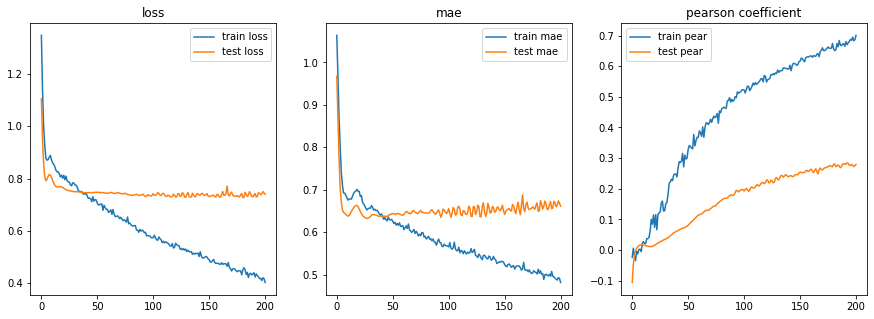

In [ ]:
import matplotlib.pyplot as plt

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.plot(all_train_loss, label="train loss")
ax1.plot(all_test_loss, label="test loss")
ax1.legend(loc="best")
ax1.set_title("loss")

ax2.plot(all_train_mae, label="train mae")
ax2.plot(all_test_mae, label="test mae")
ax2.set_title("mae")
ax2.legend(loc="best")

ax3.plot(all_train_pear, label="train pear")
ax3.plot(all_test_pear, label="test pear")
ax3.set_title("pearson coefficient")
ax3.legend(loc="best")

# plt.show()

In [ ]:
# Instantiate model
model = RegressionModel(D_m_text, D_m_audio, D_m_video, D_m_context, D_g, D_p, D_e, D_h, dropout_rec=args["rec_dropout"], dropout=args["dropout"])
model.load_state_dict(torch.load("/content/gdrive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_noneutral_regression/epoch179_testloss_0.7277_testmae_0.6488000154495239_testpear_0.28.pth"))

train_loader, valid_loader, test_loader = get_MOSEI_loaders('/content/gdrive/MyDrive/11-777 MMML/multilogue-net/data/moseas_full_no_neutral_regression.pickle', valid=0.0, batch_size=batch_size, num_workers=0)
if cuda:
    model.cuda()
loss_function = MaskedMSELoss()
train_loss, train_mae, train_pear,train_labels, train_preds, train_masks = train_or_eval_model(model, loss_function, train_loader, 1)
test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, loss_function, test_loader, 1)


dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataloader.py 0
dataload

In [ ]:
all_labels = np.concatenate([train_labels, test_label])
all_preds = np.concatenate([train_preds, test_pred])

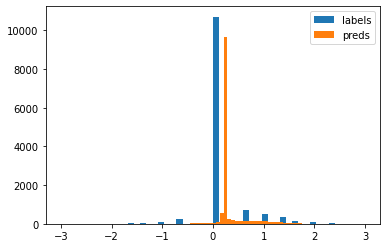

In [ ]:
import matplotlib.pyplot as plt

plt.hist(all_labels, bins=50, label="labels")
plt.hist(all_preds, bins=50, label="preds")
plt.legend()
plt.show()

In [ ]:
all_labels

array([0.6666667, 0.6666667, 1.6666666, ..., 0.       , 0.       ,
       0.       ], dtype=float32)

In [ ]:
np.logical_and(all_labels<=0.5, all_labels >= -0.5).sum()

10711

In [ ]:
all_labels

array([1.6666666, 0.       , 0.       , ..., 0.       , 0.       ,
       0.       ], dtype=float32)

# evaluate multilogue-net-nce on spanish dataset

In [ ]:
import pickle

spanish_moseas_data = pickle.load(open("/content/drive/MyDrive/11-777 MMML/multilogue-net/data/moseas_spanish_full_regression.pickle", "rb"))

In [ ]:
len(spanish_moseas_data[0])

258

In [ ]:
all_videos_seg, all_speakers, all_labels, text_feat, audio_feat, visual_feat, train_videos, test_videos = spanish_moseas_data

In [ ]:
spanish_moseas_data = (all_videos_seg, all_speakers, all_labels, text_feat, text_feat, audio_feat, visual_feat, train_videos, test_videos)

In [ ]:
pickle.dump(spanish_moseas_data, open("/content/drive/MyDrive/11-777 MMML/multilogue-net/data/moseas_spanish_duptextfornce_full_regression.pickle", "wb"))

In [36]:
# Instantiate model
model = RegressionModelNCE(D_m_text, D_m_audio, D_m_video, D_m_context, D_g, D_p, D_e, D_h, dropout_rec=args["rec_dropout"], dropout=args["dropout"])
model.load_state_dict(torch.load("/content/drive/MyDrive/11-777 MMML/multilogue-net/logs/moseas_regression/epoch99_testloss_0.4166_testmae_0.4966999888420105_testpear_0.3735.t7"))
if cuda:
    model.cuda()
MSEloss = MaskedMSELoss()
NCEloss = CrossLingualNCELoss(visual=True,audio=True)

# Get optimizer and relevant dataloaders
optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['l2'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7,patience=10,verbose=True)


train_loader, valid_loader, test_loader = get_MOSEI_loaders_NCE('/content/drive/MyDrive/11-777 MMML/multilogue-net/data/moseas_spanish_duptextfornce_full_regression.pickle', valid=0.0, batch_size=batch_size, num_workers=0)



french
testset.len:  52


In [37]:
test_loss, test_mae, test_pear, test_label, test_pred, test_mask = train_or_eval_model(model, MSEloss, NCEloss, test_loader, 0)
print("Test Loss - spanish MOSEAS: ", test_loss)
print("Test MAE - spanish MOSEAS: ", test_mae)
print("Test Pear - spanish MOSEAS: ", test_pear)



torch.Size([105, 52, 300]) torch.Size([105, 52, 300])
872.0224839448929
1.3867842
Test Loss - spanish MOSEAS:  0.8648
Test MAE - spanish MOSEAS:  0.7655
Test Pear - spanish MOSEAS:  0.3258
